In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import pearsonr
import random

## Извлечение данных и предварительная обработка

In [2]:
def extract_data(file_name):
    data_text = open(file_name, 'r')
    data_list = []
    event_counter = 0
    for line in data_text:
        line_data = list(map(float, line.split()))
        line_data = line_data[0:2]
        data_list.append(line_data)
        event_counter += 1
    first_event_time = data_list[0][0]
    last_event_time = data_list[-1][0]
    normolized_events = np.linspace(first_event_time,
                                    last_event_time, event_counter)
    for i in range(0, event_counter):
        data_list[i][0] = normolized_events[i]

    return data_list

In [3]:
data = extract_data('wnaap.dat')

In [4]:
def add_graph_parametrs(fig_size_x = 15, figsize_y = 15, #размеры окна с графиком
                    left_border = 1900, right_border = 2016, #границы, в которых показывается график по оси абсцисс
                    lower_border = -30, upper_border = 30 #границы, в которых показывается график по оси ординат
                   ):
    plt.figure(figsize=(fig_size_x, figsize_y))
    axes = plt.gca()
    axes.set_xlim([left_border, right_border])
    axes.set_ylim([lower_border, upper_border])
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('number')

In [5]:
month = 1 / 12
activity_minimums_list = [1902 + 1 * month,
                          1913 + 7 * month,
                          1923 + 7 * month,
                          1933 + 8 * month,
                          1944 + 1 * month,
                          1954 + 3 * month,
                          1964 + 9 * month,
                          1976 + 5 * month,
                          1986 + 8 * month,
                          1996 + 4 * month,
                          2009 + 0 * month]

In [6]:
def get_changed_data(data, minimums):
    i = 0
    j = 0
    event_num = len(data)
    minimums_num = len(minimums)
    changed_data = []
    sign = -1
    while (i < event_num):
        while (i < event_num and
               (j >= minimums_num or data[i][0] < minimums[j])):
            data_pair = [data[i][0], sign * np.sqrt(data[i][1])]
            changed_data.append(data_pair)
            i += 1
        j += 1
        sign *= -1 
    return changed_data

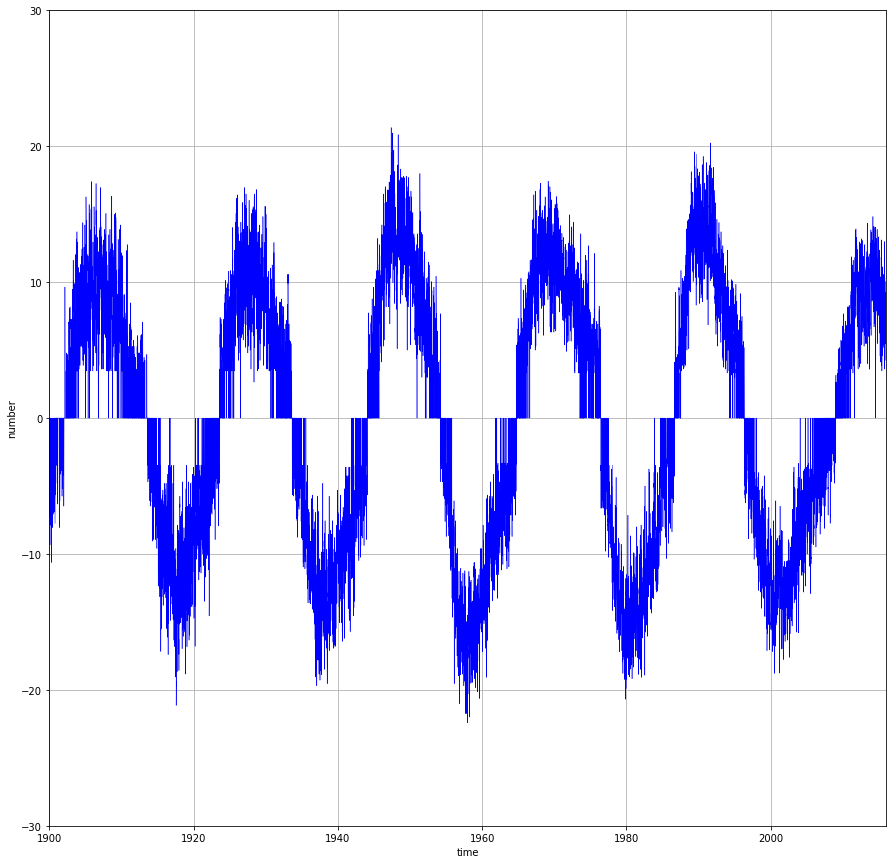

In [7]:
new_data = np.array(get_changed_data(data, activity_minimums_list))
add_graph_parametrs()
plt.plot(new_data[:,0], new_data[:,1], linewidth=0.5, color='b')
plt.show()

In [8]:
def FFT_low_pass(signal, fc, b):
    
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = list(signal[:,1])
    new_signal_data = np.convolve(s, sinc_func, mode='same')
    new_signal = []
    dots_num = len(s)
    for i in range(0, dots_num):
        append_data = [signal[i][0], new_signal_data[i]]
        new_signal.append(append_data)
    return new_signal

In [9]:
smoothed_data = np.array(FFT_low_pass(new_data, 0.0001, 0.0021))

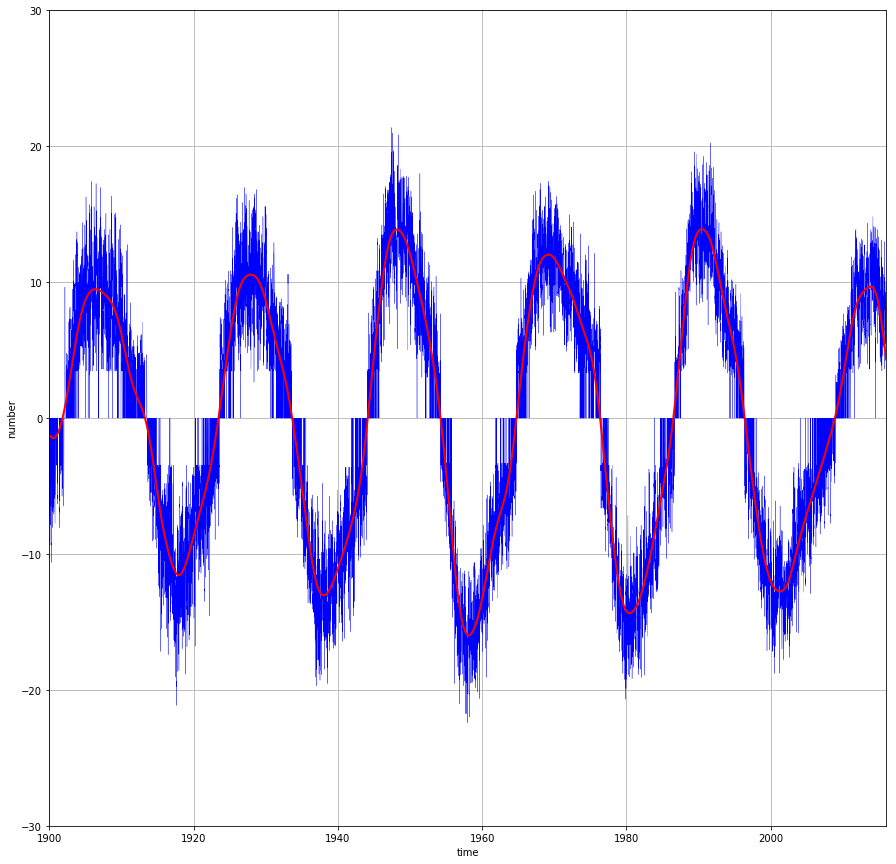

In [10]:
add_graph_parametrs()
plt.plot(new_data[:,0], new_data[:,1], linewidth=0.3, color='b')
plt.plot(smoothed_data[:,0], smoothed_data[:,1], linewidth=2, color='r')
plt.show()

## Получение циклов и их фазовых портретов

In [11]:
def find_last_max(data):
    i = np.shape(data)[0] - 1
    while (data[i - 1, 1] > data[i, 1]):
        i -= 1
    return i

In [12]:
def find_first_zero(data):
    i = 0
    while (data[i, 1] < 0):
        i += 1
    return i

In [13]:
def get_cycles_borders(data):
    borders = []
    start = find_first_zero(data)
    finish = find_last_max(data)
    i = start
    while (i <= finish):
        while (i <= finish and (data[i, 1] * data[i + 1, 1] > 0)):
            i += 1
        cycle_borders = [start, i]
        start = i + 1
        borders.append(cycle_borders)
        i += 1
    return borders

In [14]:
def get_derivative (data, index):
    interval = np.array(data[index - 5: index + 5])
    k = np.polyfit(interval[:,0], interval[:, 1], 1)
    return k[0]

In [15]:
cycles = get_cycles_borders(smoothed_data)

In [16]:
def cycle_phase_portrait(start, finish, data):
    portrait = []
    for i in range(start, finish + 1):
        x = get_derivative(data, i)
        append_pair = [data[i][1], x]
        portrait.append(append_pair)
    return portrait

In [17]:
portraits = []
for cycle in cycles:
    portraits.append(np.array(cycle_phase_portrait(cycle[0], cycle[1], smoothed_data)))

In [18]:
def draw_cycles(portraits, number, col='r'):
    if (number < 0 or number >= len(portraits)):
        picture = np.concatenate(portraits, axis = 0)
        plt.plot(picture[:,0], picture[:,1], linewidth=0.5, color = col)
    else:
        plt.plot(portraits[number][:,0], portraits[number][:,1], linewidth=0.5, color = col)

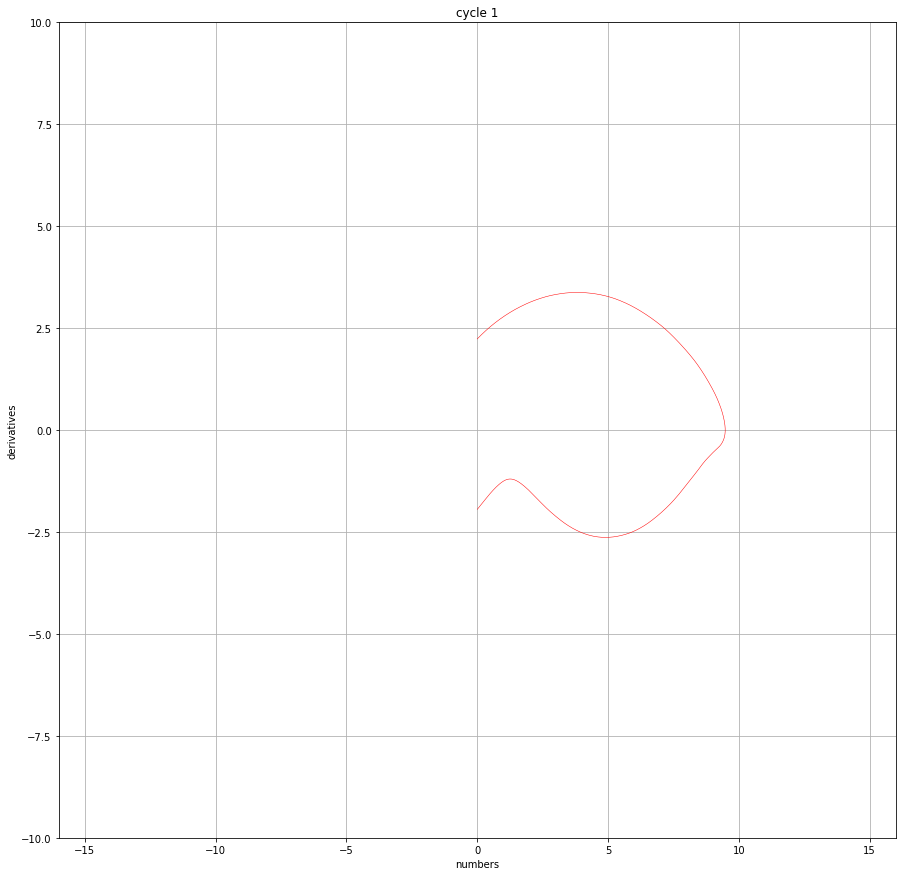

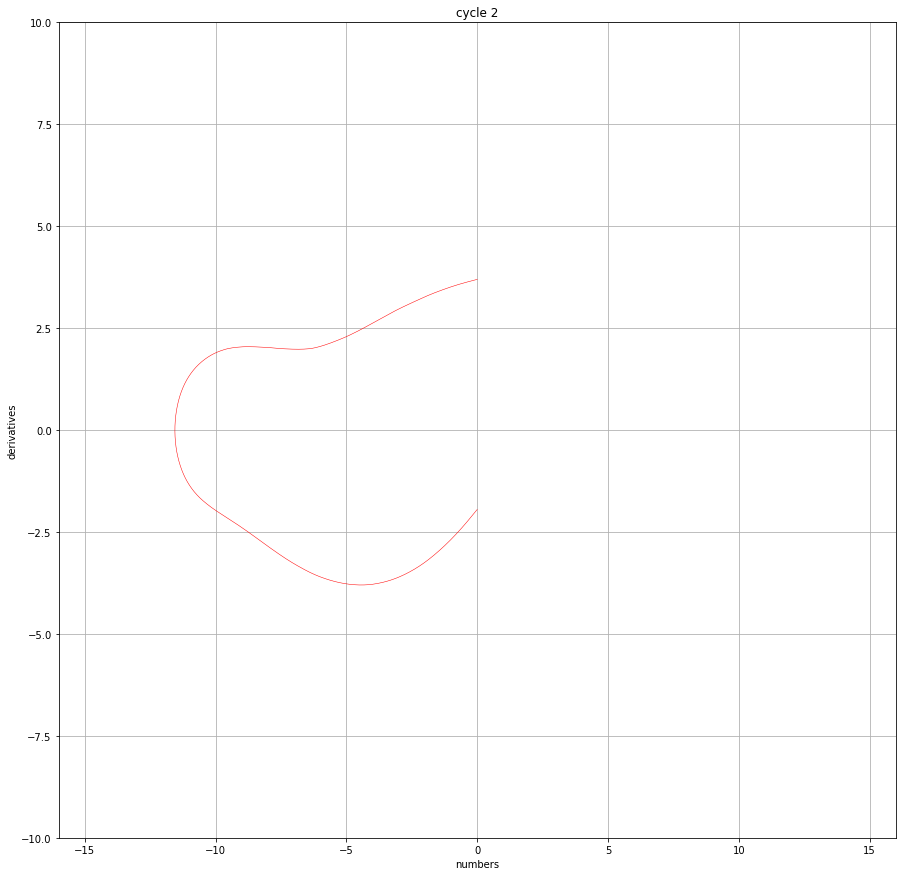

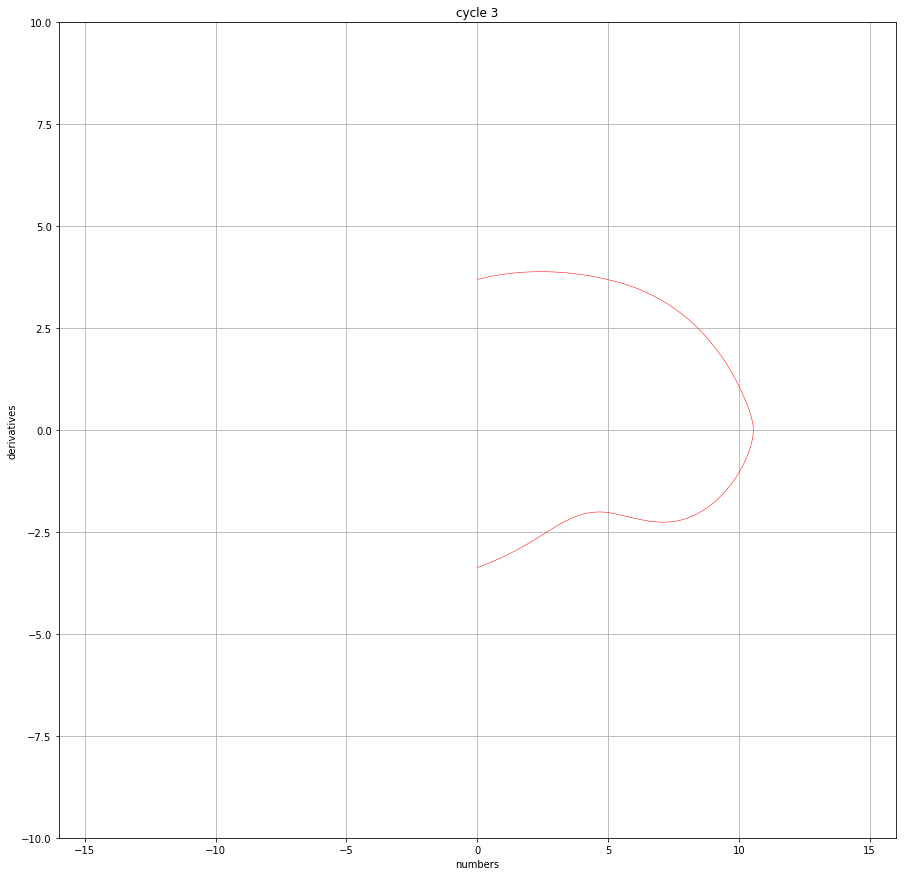

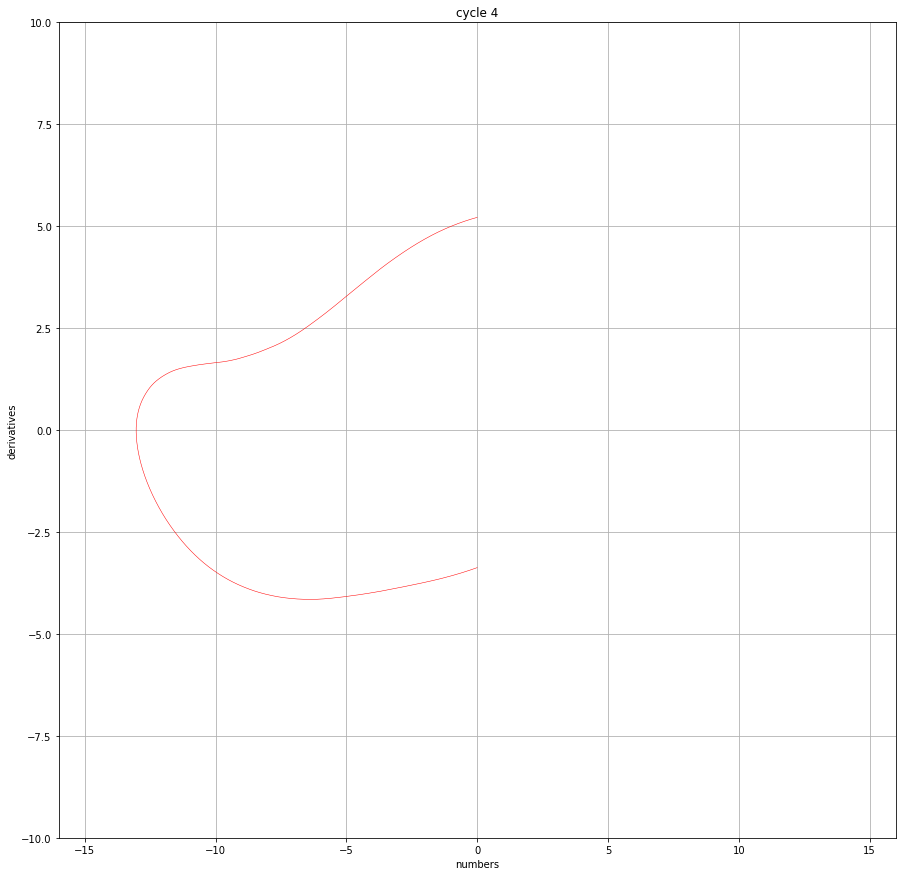

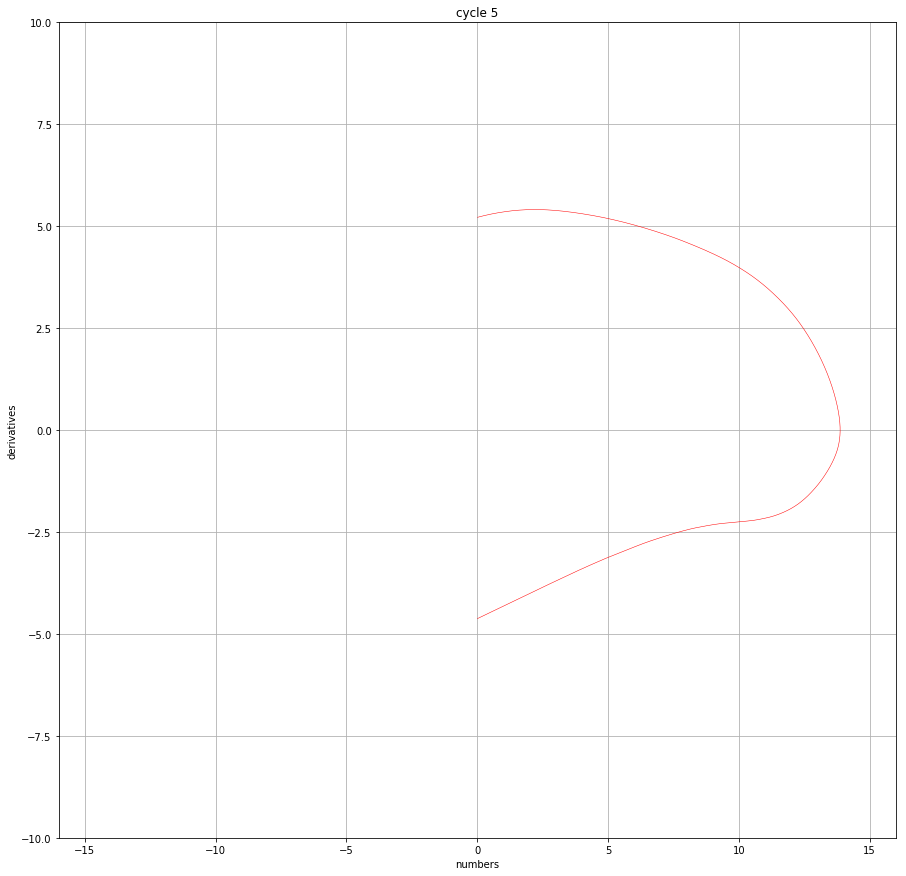

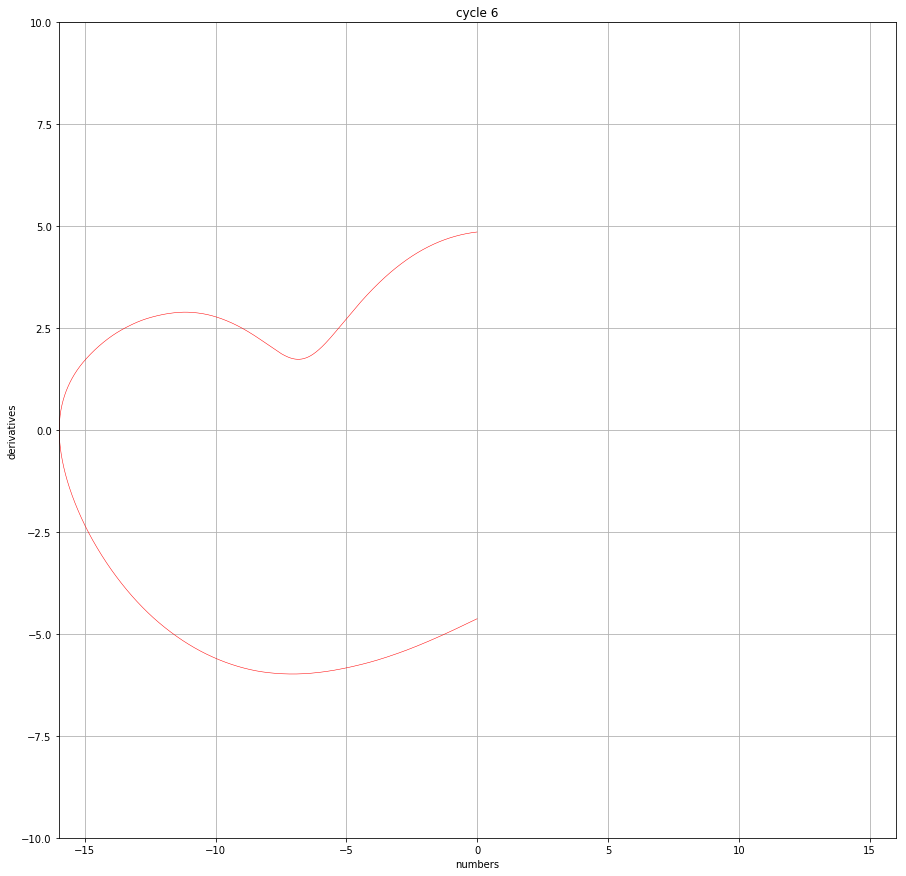

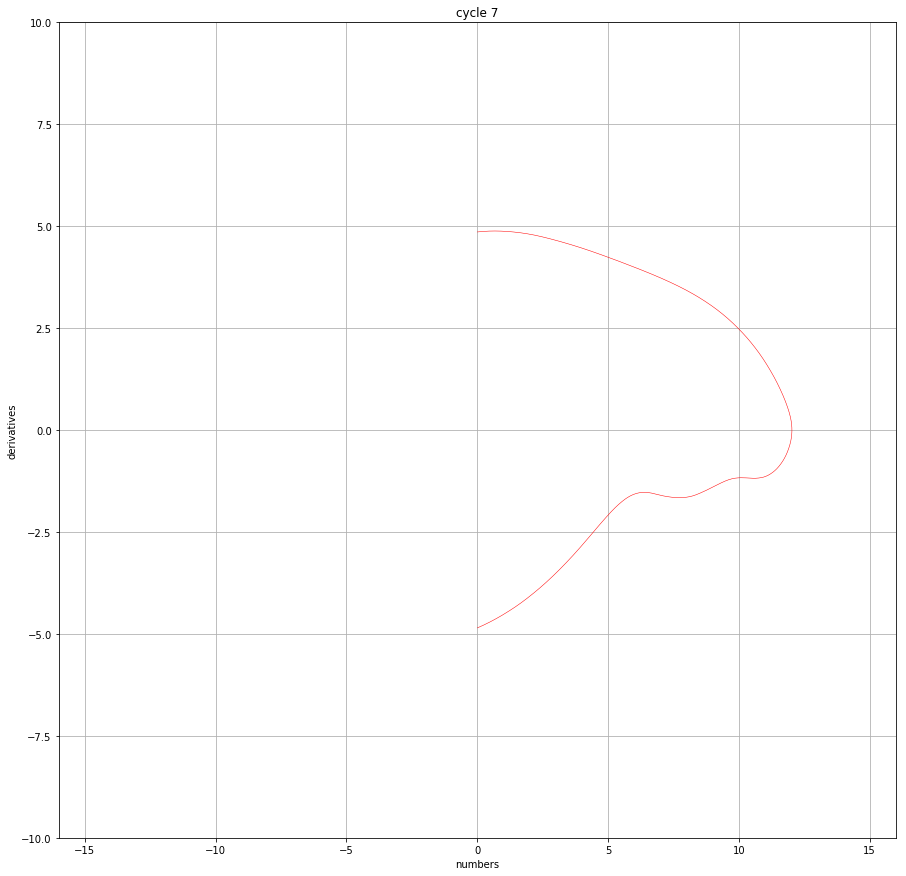

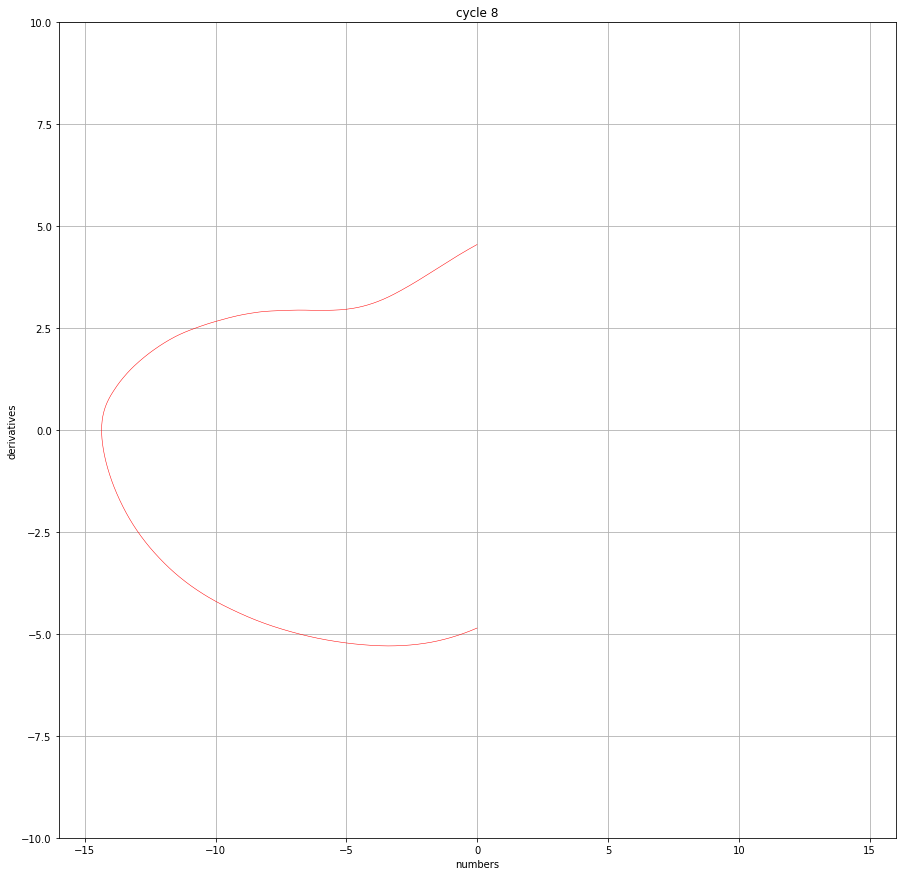

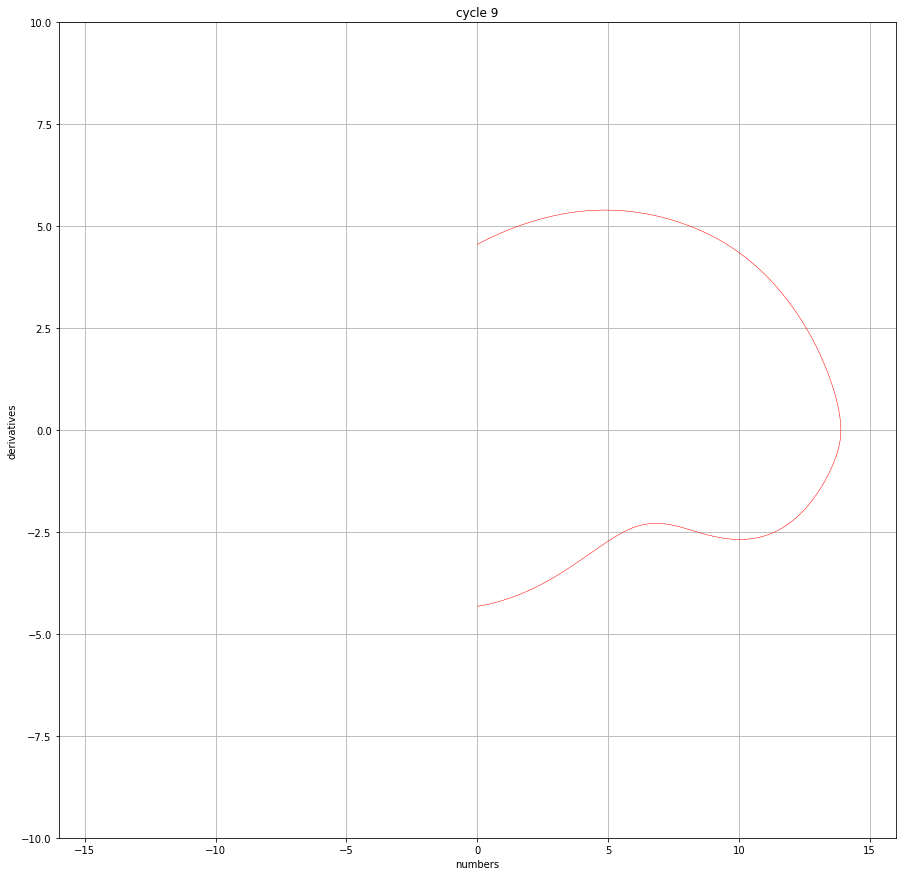

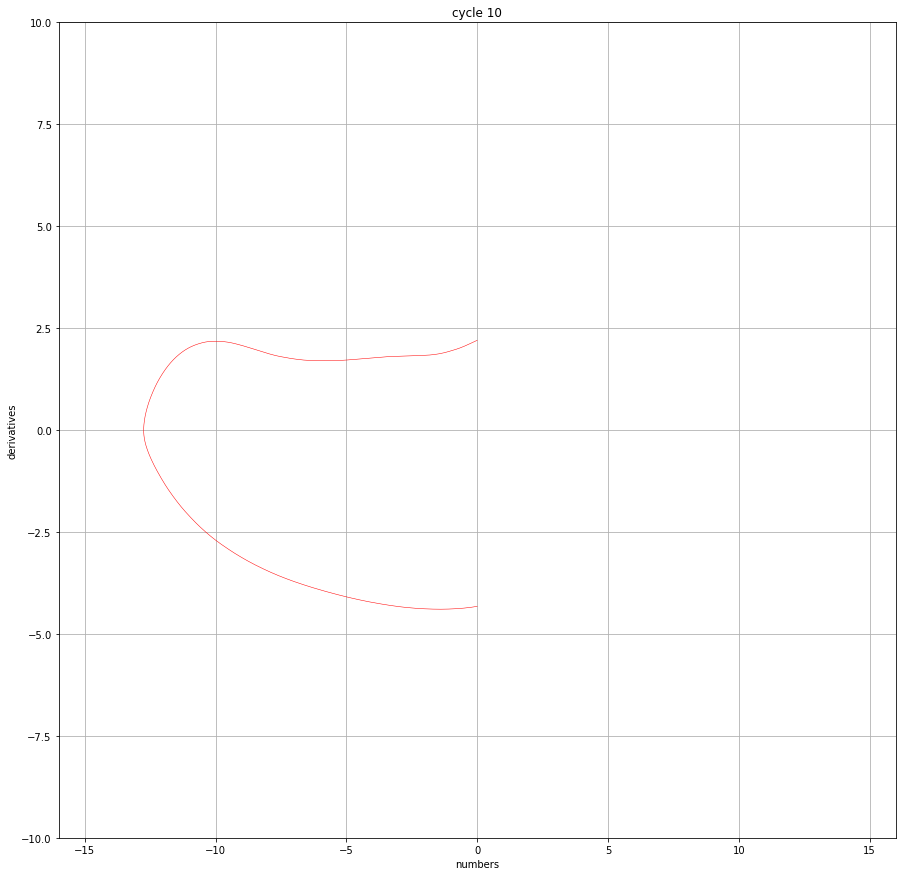

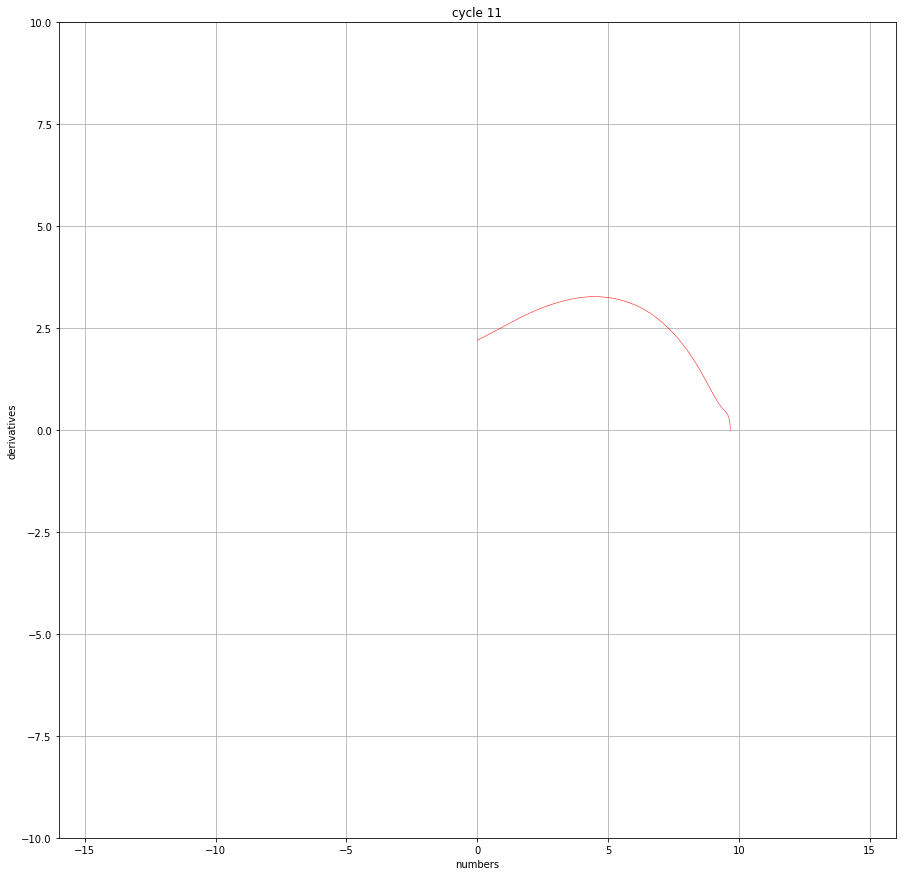

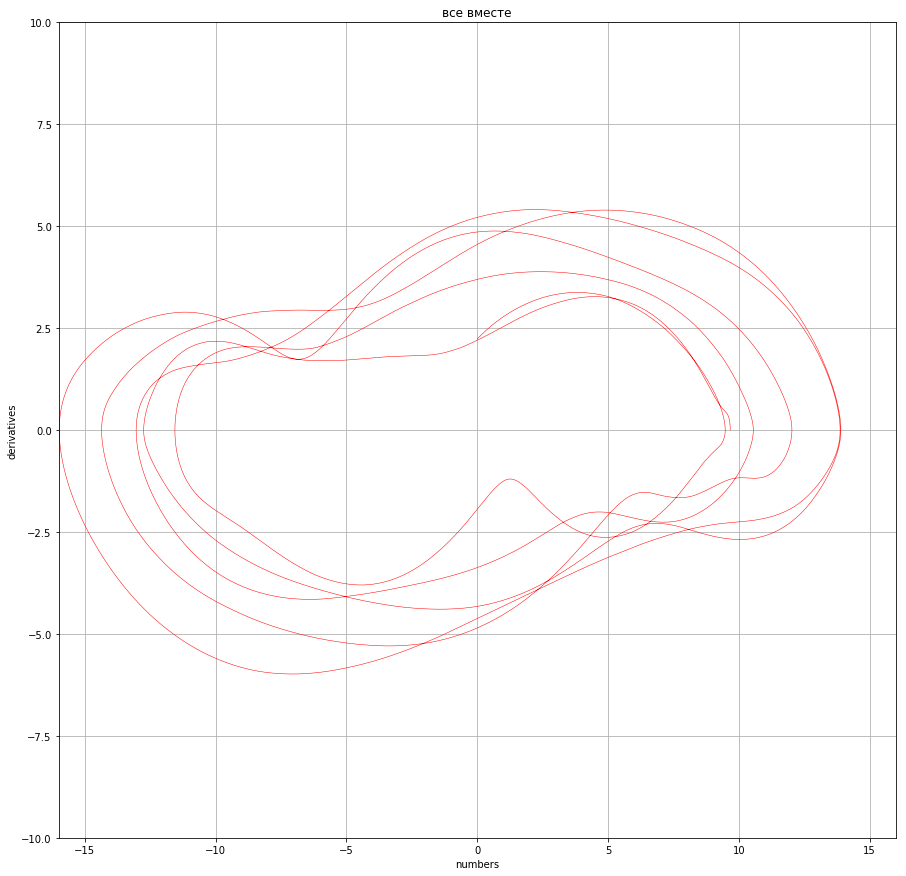

In [19]:
for i in range(0, len(portraits)):
    add_graph_parametrs(lower_border=-10, upper_border = 10,
                            left_border = -16, right_border = 16)
    plt.title(u'cycle ' + str(i + 1))
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    draw_cycles(portraits, i)
    plt.show()
add_graph_parametrs(lower_border=-10, upper_border = 10,
                            left_border = -16, right_border = 16)
plt.title(u'все вместе')
plt.xlabel('numbers')
plt.ylabel('derivatives')
draw_cycles(portraits, -1)

## Функции для первичного приближения

In [20]:
eps = 1
lamda = 1
mu = 1
omega = 1

In [21]:
def VDPD (t, y):
    dydt = [y[1], -lamda * y[0] ** 3 -omega ** 2 * y[0]
           -mu*(eps*y[0] ** 2 - 1) * y[1]]
    return dydt

In [22]:
def reg_difference(approx_data, portrait):
    int_sum = 0
    events_num = len(portrait)
    for i in range(0, events_num):
        int_sum += np.sqrt((approx_data[0, i] - portrait[i, 0]) ** 2 +
                           (approx_data[1, i] - portrait[i, 1]) ** 2)
    return int_sum / events_num

In [23]:
def integral_difference(approx_data, portrait):
    int_sum = 0
    events_num = len(portrait)
    for i in range(1, events_num):
        int_sum += (approx_data[0, i] - portrait[i, 0]) ** 2 * (data[i + 1][0] - data[i][0])
    return int_sum

In [24]:
def find_max(data):
    for i in range(0, len(data)- 1):
        if (abs(data[i + 1, 1]) <= abs(data[i, 1])):
            return data[i, 1]
    return data[-1, 1]

In [25]:
def calculate_approx(data, period, sign, start):
    init_sol = solve_ivp(VDPD, (0, 20 * period), start, method='RK45',
                         t_eval=np.linspace(0, 20 * period, 10000)).y
    i = np.shape(init_sol)[1] - 1
    while (not (init_sol[0, i] * sign <= 0 and init_sol[0, i - 1] * sign > 0)):
        i -= 1
    while (not (init_sol[0, i] * sign >= 0 and init_sol[0, i - 1] * sign < 0)):
        i -= 1
    true_start = [init_sol[0, i], init_sol[1, i]]
    events_num = np.shape(data)[0]
    sol = solve_ivp(VDPD, (data[0, 0], data[-1, 0]), true_start, method='RK45',
                    t_eval=np.linspace(data[0, 0], data[-1, 0], events_num)).y
    return sol

In [26]:
def get_moves(step):
    moves = []
    for i in range (-1, 2):
        for j in range (-1, 2):
            for k in range (-1, 2):
                for t in range (-1, 2):
                    if (k or t or j or i):
                        moves.append([i * step, j * step, k * step, t * step])
    return moves

In [27]:
#условие положительности параметров и повторения
def get_block(move, moves, step):
    global lamda, mu, eps, omega
    blocked_moves = []
    for i in range (-1, 2):
        for j in range (-1, 2):
            for k in range (-1, 2):
                for t in range (-1, 2):
                    v = [i * step + move[0], j * step + move[1], k * step + move[2], t * step + move[3]]
                    if ((i < 0 and lamda < step) or
                        (j < 0 and mu < step) or
                        (k < 0 and eps < step) or
                        (t < 0 and omega < step) or
                        (v in moves)):
                        blocked_moves.append([i * step, j * step, k * step, t * step])
    return blocked_moves.copy()

In [28]:
def get_approx(data, difference, portrait):
    global mu, omega, eps, lamda
    t_span = data[-1, 0] - data[0, 0]
    max_data = find_max(data)
    sign = np.sign(max_data)
    blocked = []
    mu = 0
    omega  = round(np.pi / t_span, 4)
    eps = round((2 / abs(max_data)) ** 2, 4)
    lamda = 0
    init_parameters = [lamda, mu, eps, omega]
    
    step = 0.1
    step_counter = 0
    best_approx = calculate_approx(data, t_span, sign, [max_data, 0])
    best_move = [0, 0, 0, 0]
    min_difference = difference(best_approx, portrait)
    
    while (step_counter < 10000000 and step > 0.00001):
        moves = get_moves(step)
        blocked = get_block([0, 0, 0, 0], [], step)
        end_flag = 0
        while (not end_flag):
            end_flag = 1
            for move in moves:
                if (not (move in blocked)):
                    step_counter += 1
                    lamda = round(init_parameters[0] + np.sign(move[0]) * 0.0001, 4) #lamda мало по виду данных
                    mu = round(init_parameters[1] + move[1], 4)
                    eps = round(init_parameters[2] + move[2], 4)
                    omega = round(init_parameters[3] + move[3], 4)
                    approx_data = calculate_approx(data, t_span, sign, [max_data, 0])
                    diff = difference(approx_data, portrait)
                    if (diff < min_difference):
                        end_flag = 0
                        min_difference = diff
                        best_approx = approx_data
                        best_move = move
            if (not end_flag):
                init_parameters = [round(init_parameters[0] + np.sign(best_move[0]) * 0.0001, 4),
                                   round(init_parameters[1] + best_move[1], 4),
                                   round(init_parameters[2] + best_move[2], 4),
                                   round(init_parameters[3] + best_move[3], 4)]

            if (step_counter >= 10000000):
                end_flag = 1
            lamda, mu, eps, omega = init_parameters
            blocked = get_block(best_move, moves, step)
        step /= 10
    
    return (best_approx.copy(), min_difference, init_parameters)

In [29]:
def approximate_cycle(number, difference, portraits, smoothed_data, cycles):
    cycle_data = smoothed_data[cycles[number][0] : cycles[number][1] + 1,:]
    approx_data = get_approx(cycle_data, difference, portraits[number])
    return [cycle_data[:, 0], approx_data]

In [30]:
def drow_cycle_results(result_data, num, portraits):
    add_graph_parametrs(lower_border=-16, upper_border = 16,
                                left_border = -16, right_border = 16)
    freq = []
    print('mistake =', result_data[1][1])
    print('lamda =', result_data[1][2][0])
    print('mu =', result_data[1][2][1])
    print('eps =', result_data[1][2][2])
    print('omega =', result_data[1][2][3])
    plt.title(u'cycle ' + str(num + 1))
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    plt.plot(result_data[1][0][0,:], result_data[1][0][1,:])
    plt.plot(portraits[num][:,0], portraits[num][:,1], color ='r')
    plt.show()
    add_graph_parametrs()
    plt.plot(result_data[0], result_data[1][0][0,:])
    plt.plot(result_data[0], portraits[num][:,0], color ='r')
    plt.show()
    return result_data[1][2]

In [31]:
def cycles_approx(difference, portraits, smoothed_data, cycles):
    cycles_num = len(cycles)
    total_result = []
    parameters = []
    for i in range (0, cycles_num):
        result_data = approximate_cycle(i, difference, portraits, smoothed_data, cycles)
        total_result.append(result_data[1][0])
        c_parameters = drow_cycle_results(result_data, i, portraits)
        parameters.append(c_parameters)
    all_approx_data = np.concatenate(total_result, axis = 1)
    add_graph_parametrs(lower_border=-10, upper_border = 10,
                        left_border = -16, right_border = 16)
    plt.title(u'все вместе')
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    draw_cycles(portraits, -1)
    plt.plot(all_approx_data[0,:], all_approx_data[1,:])
    plt.show()
    add_graph_parametrs()
    data_span = smoothed_data[cycles[0][0]:cycles[-1][1] + 1, :]
    plt.plot(data_span[:, 0], data_span[:, 1], color='r')
    plt.plot(data_span[:, 0], all_approx_data[0, :])
    plt.show()
    return np.array(parameters)

## Приближение с функцией ошибки равной усредненному расстоянию

mistake = 0.5208067577365206
lamda = 0.0001
mu = 0.181
eps = 0.0435
omega = 0.275


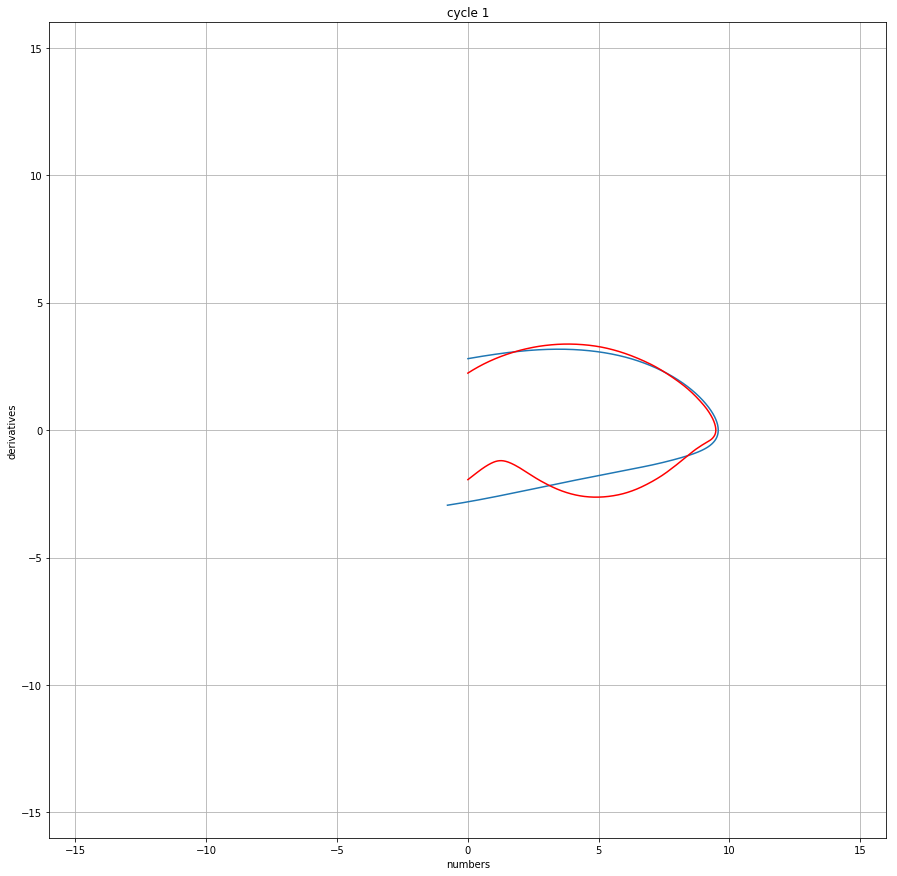

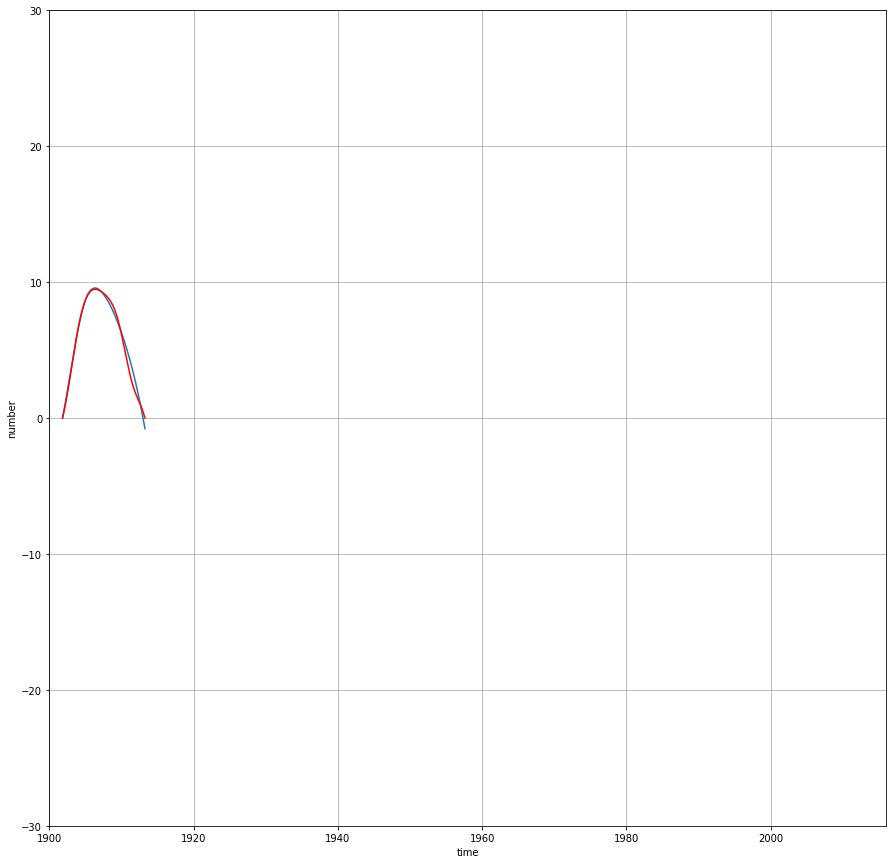

mistake = 0.467027060369216
lamda = 0.0002
mu = 0.0899
eps = 0.0329
omega = 0.2774


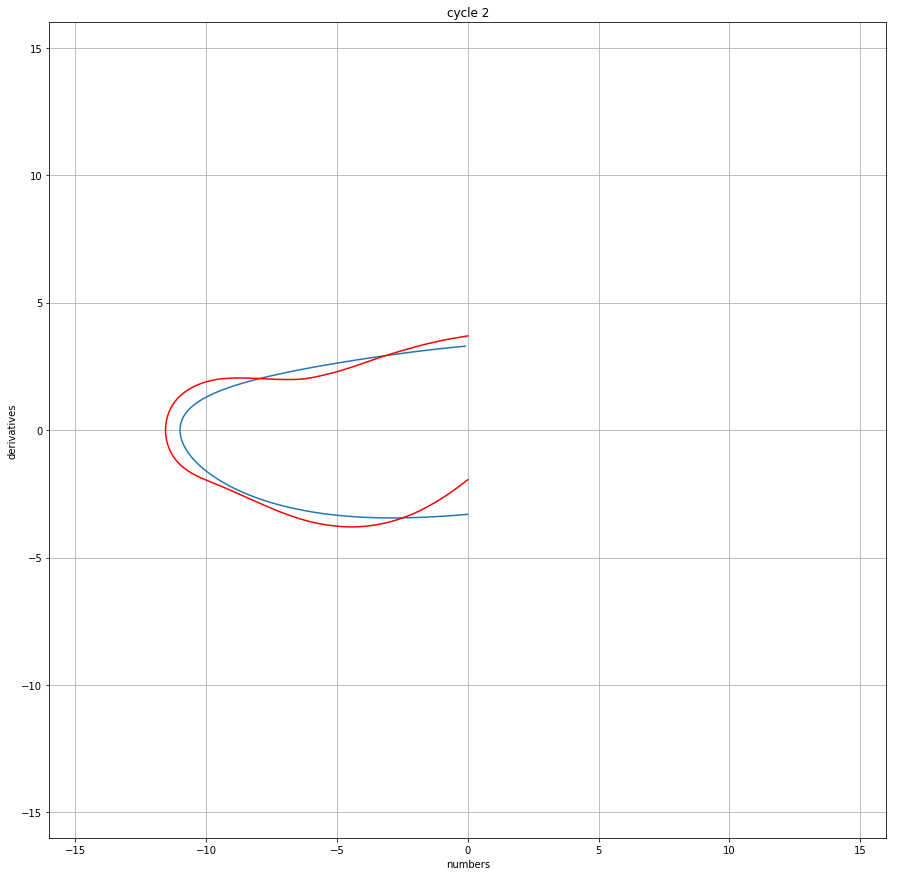

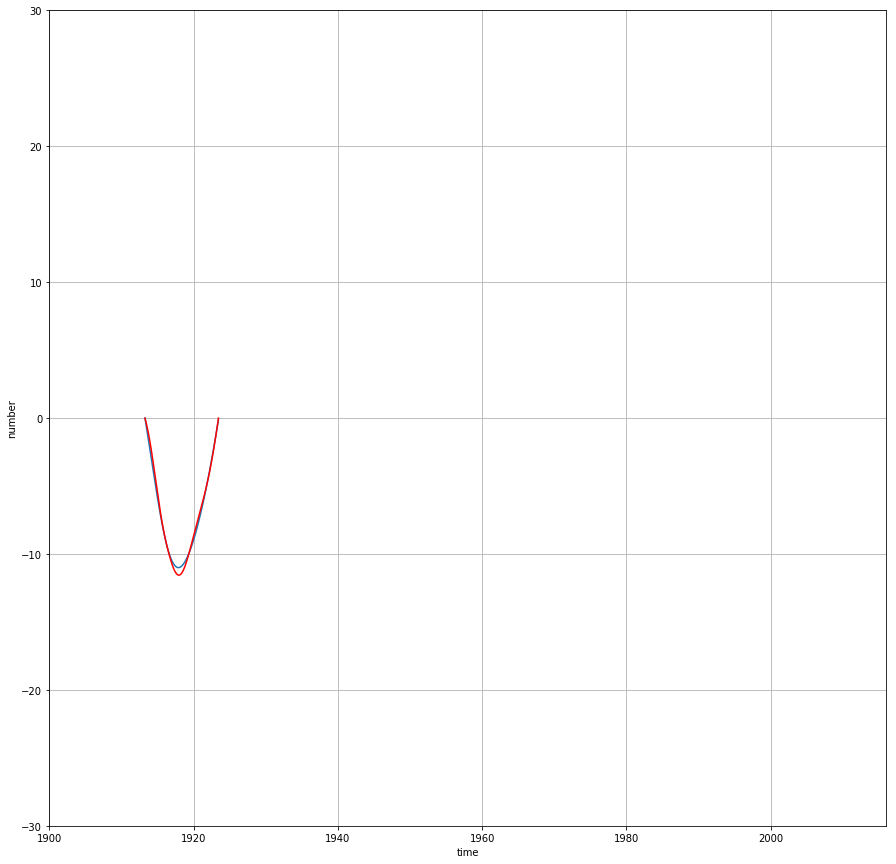

mistake = 0.3083892623707398
lamda = 0.0002
mu = 0.2001
eps = 0.0357
omega = 0.2871


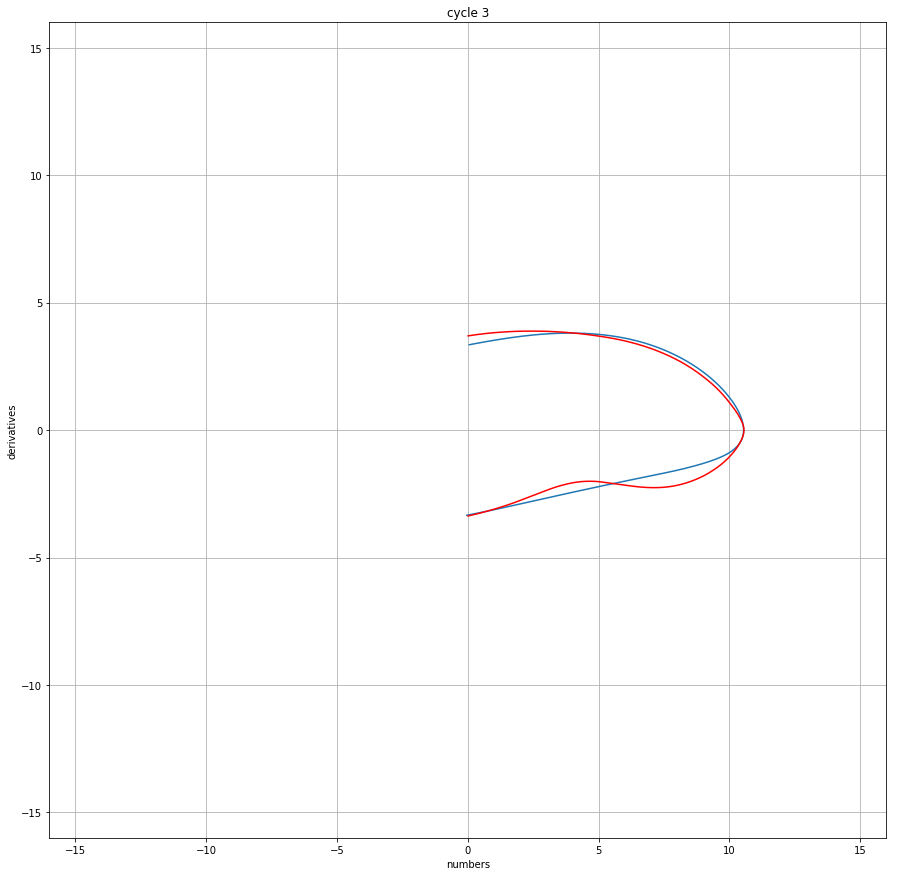

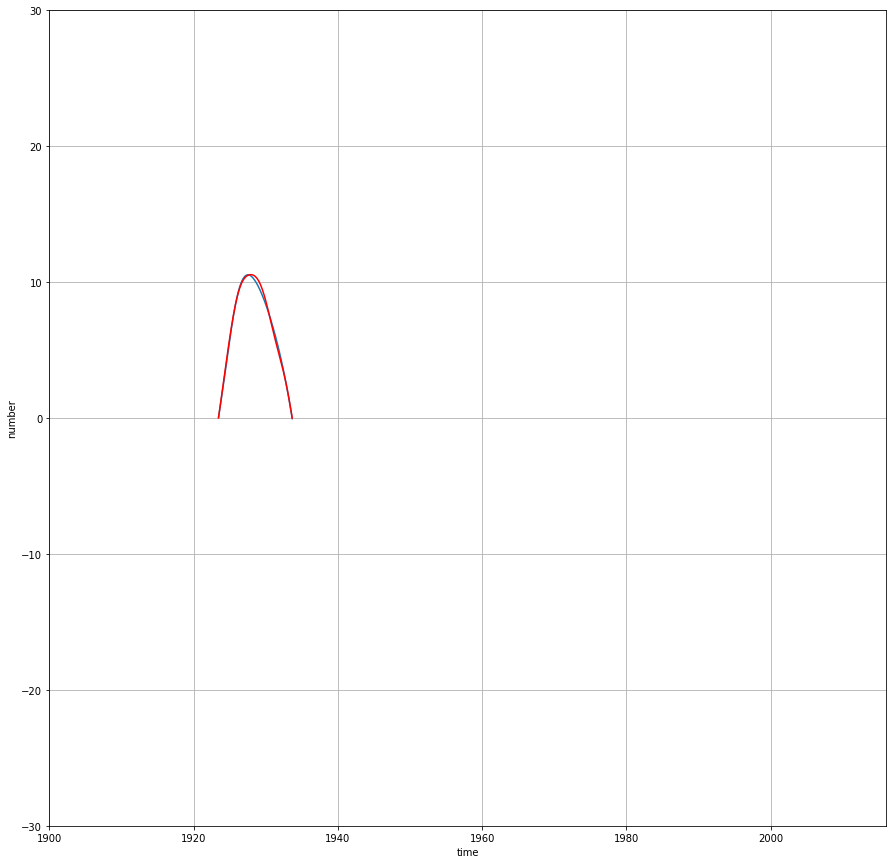

mistake = 0.46695015803647677
lamda = 0.0
mu = 0.1821
eps = 0.0244
omega = 0.2973


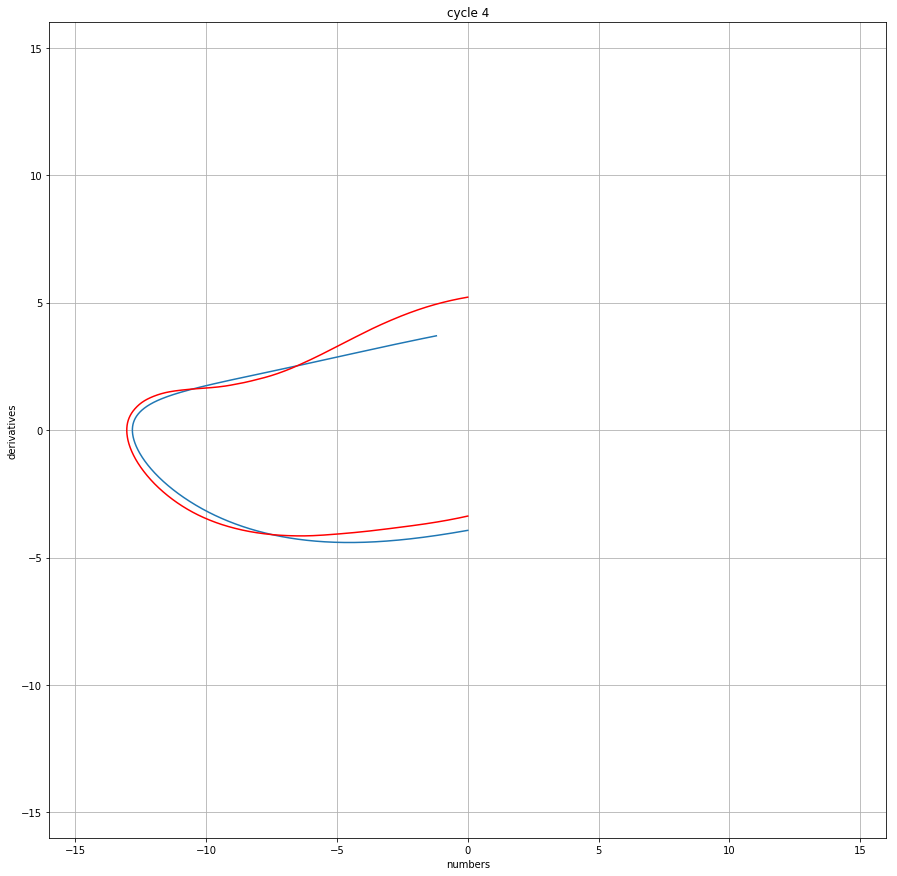

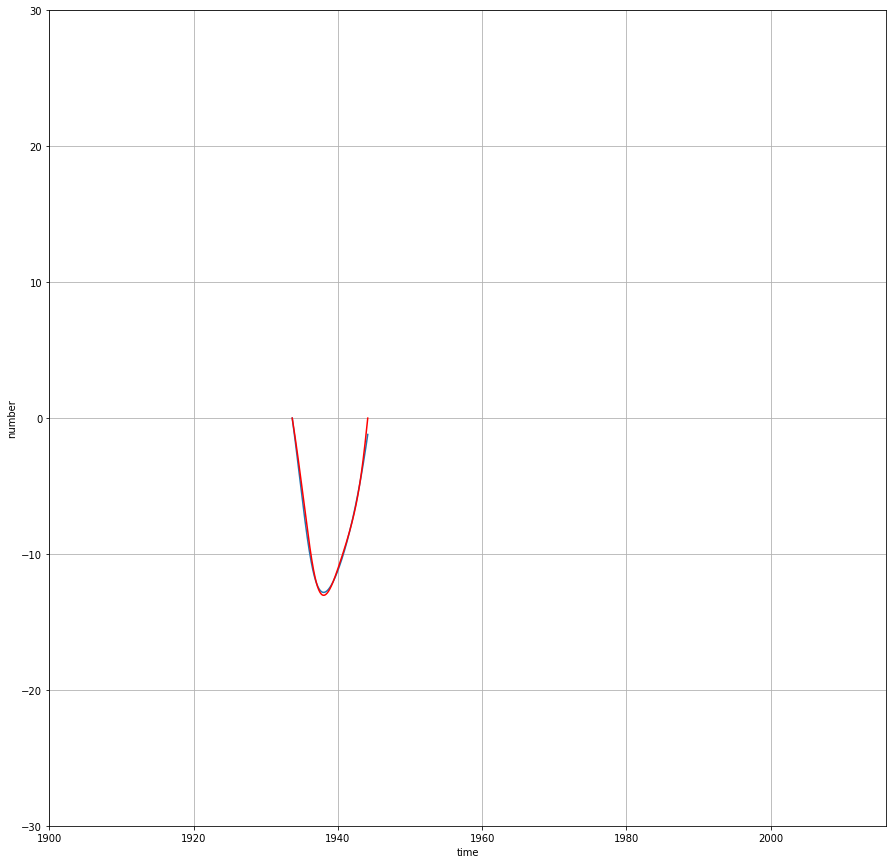

mistake = 0.2247864216019536
lamda = 0.0
mu = 0.2101
eps = 0.0209
omega = 0.319


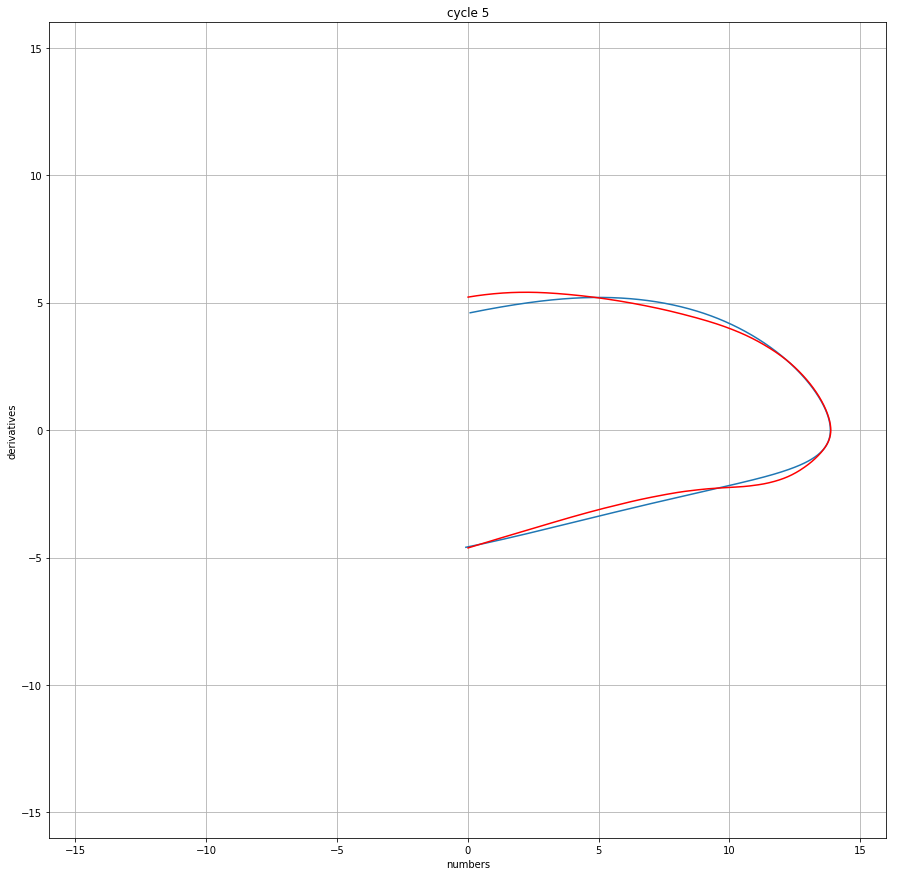

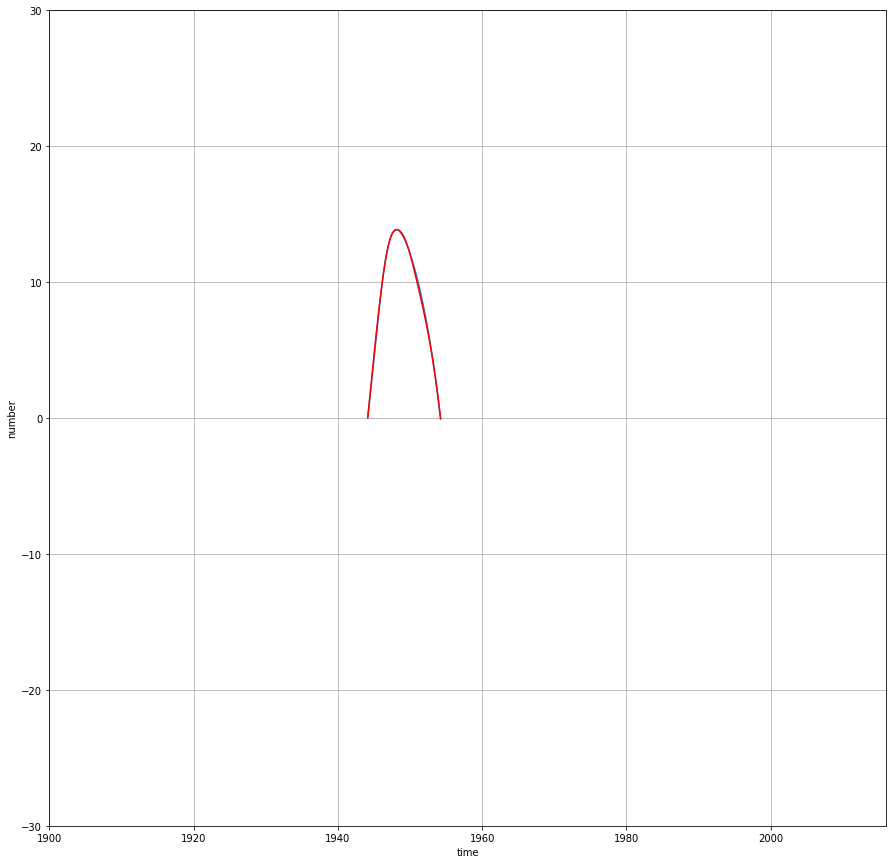

mistake = 0.7773422544020664
lamda = 0.0001
mu = 0.2409
eps = 0.0164
omega = 0.2791


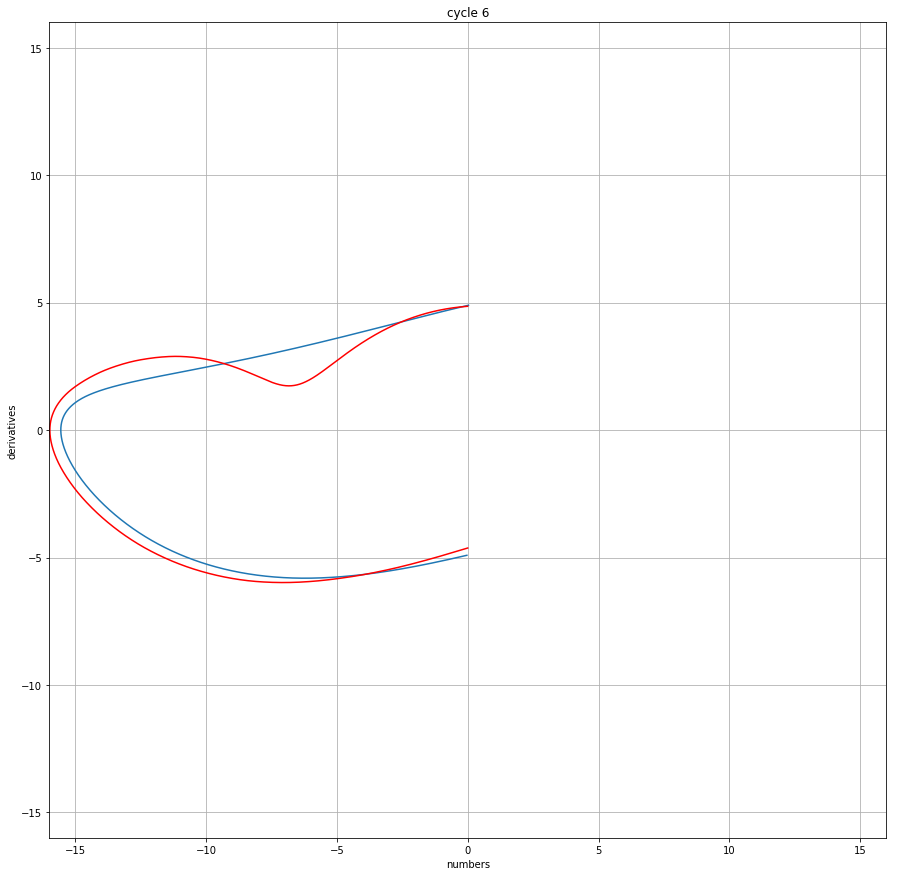

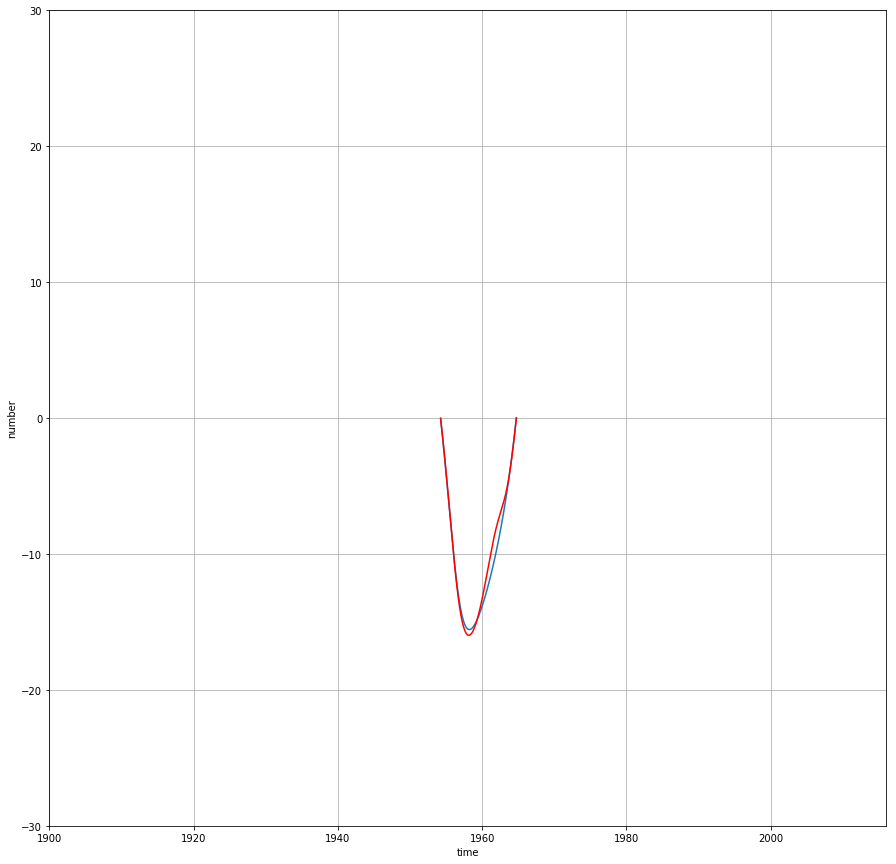

mistake = 0.38365002817272825
lamda = 0.0001
mu = 0.288
eps = 0.0275
omega = 0.2629


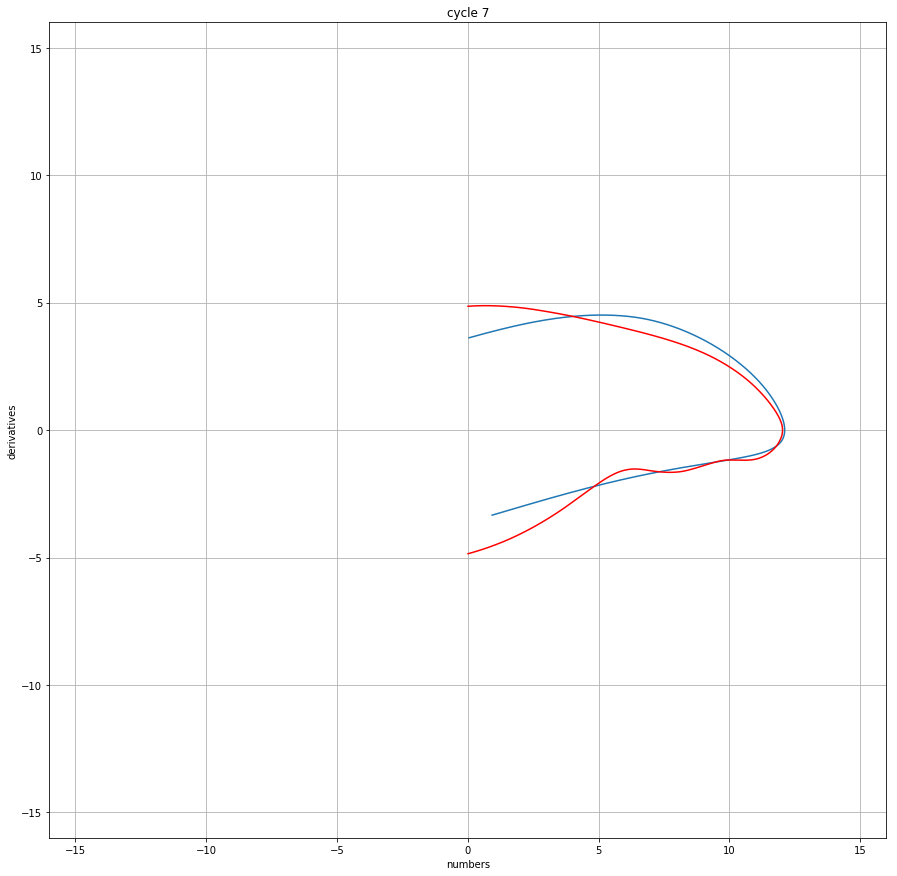

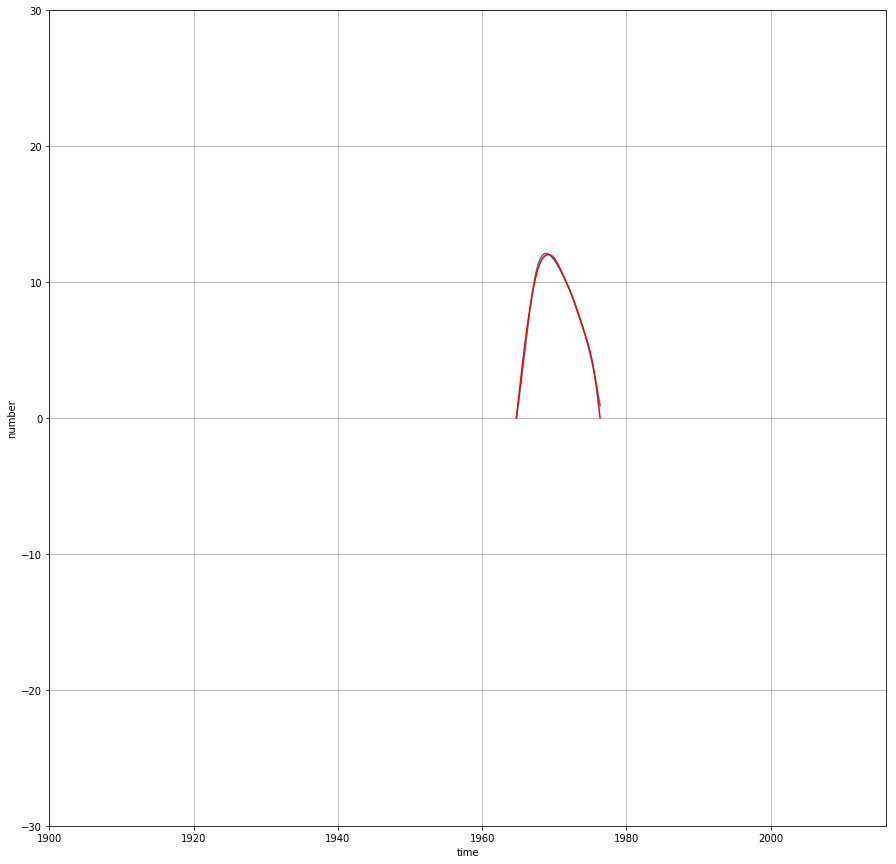

mistake = 0.2824683464463066
lamda = 0.0
mu = 0.192
eps = 0.0196
omega = 0.3189


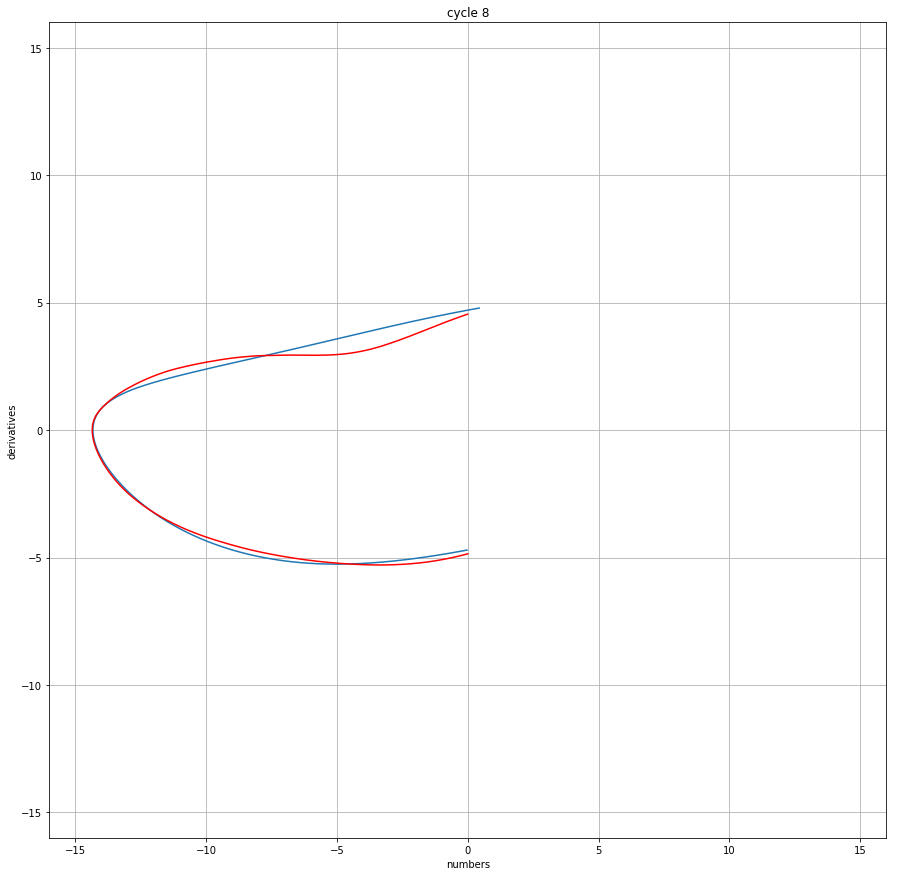

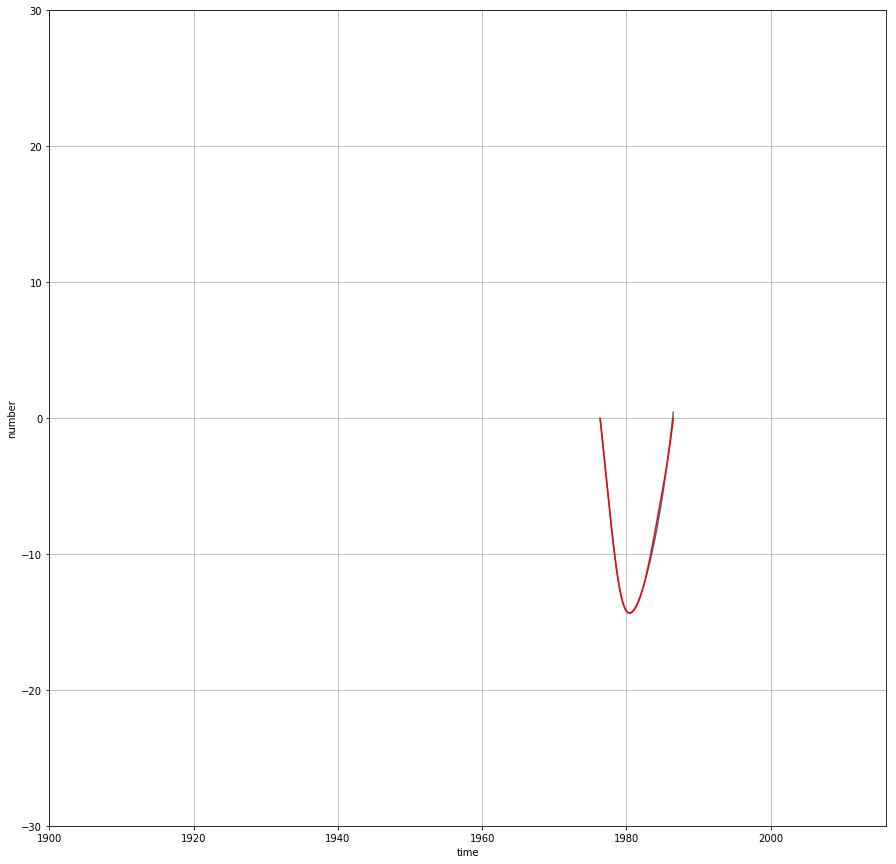

mistake = 0.3503938053104349
lamda = 0.0001
mu = 0.2201
eps = 0.0206
omega = 0.307


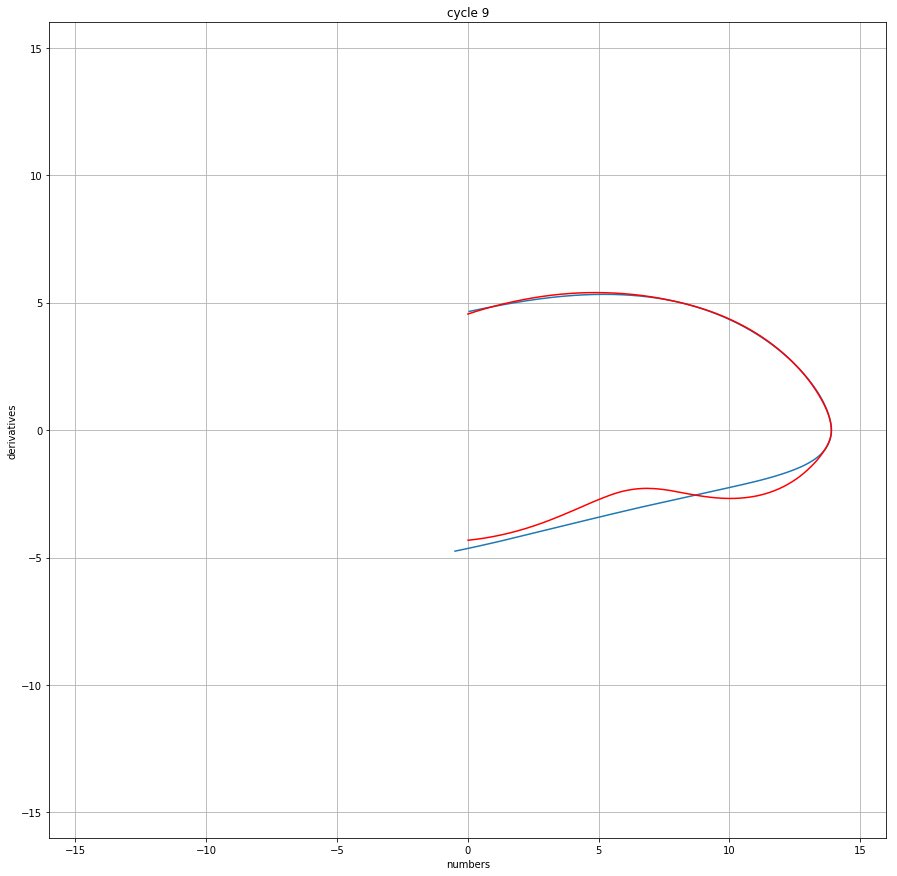

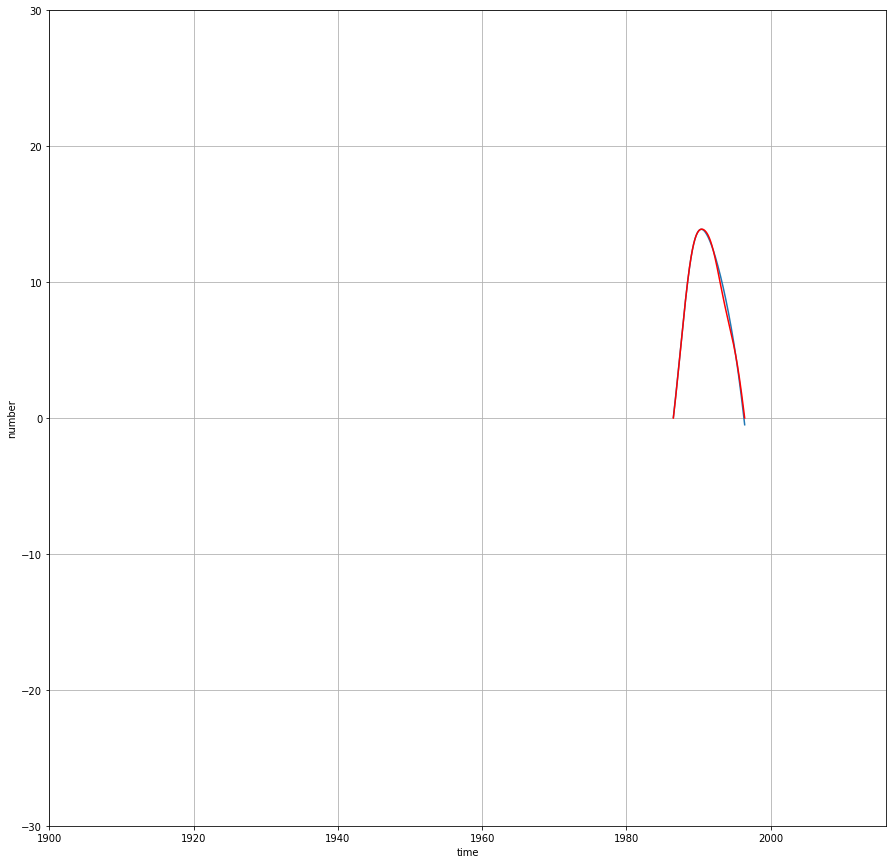

mistake = 0.7829875552315497
lamda = 0.0001
mu = 0.2109
eps = 0.0256
omega = 0.2514


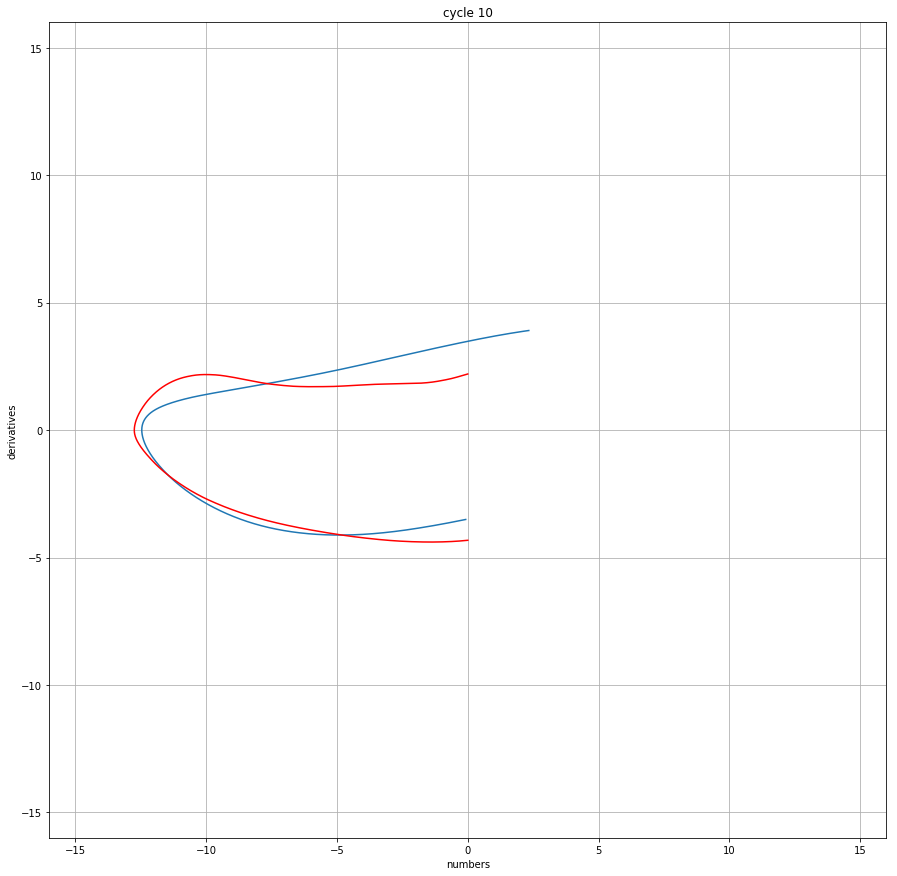

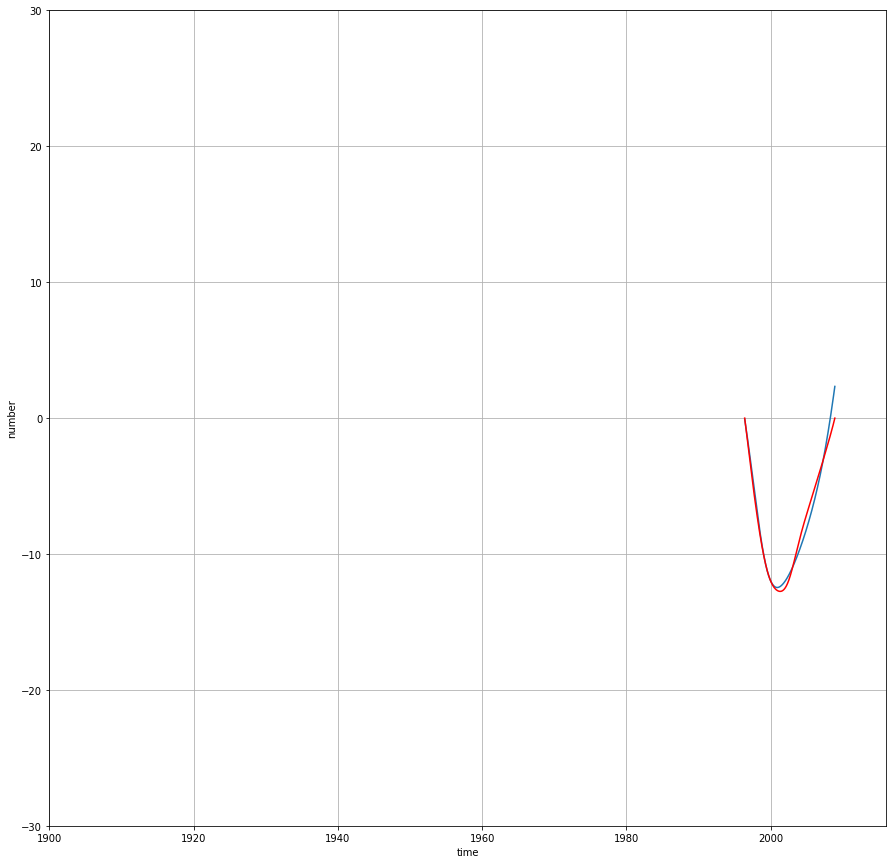

mistake = 0.27610415096765867
lamda = 0.0008
mu = 0.141
eps = 0.0427
omega = 0.2125


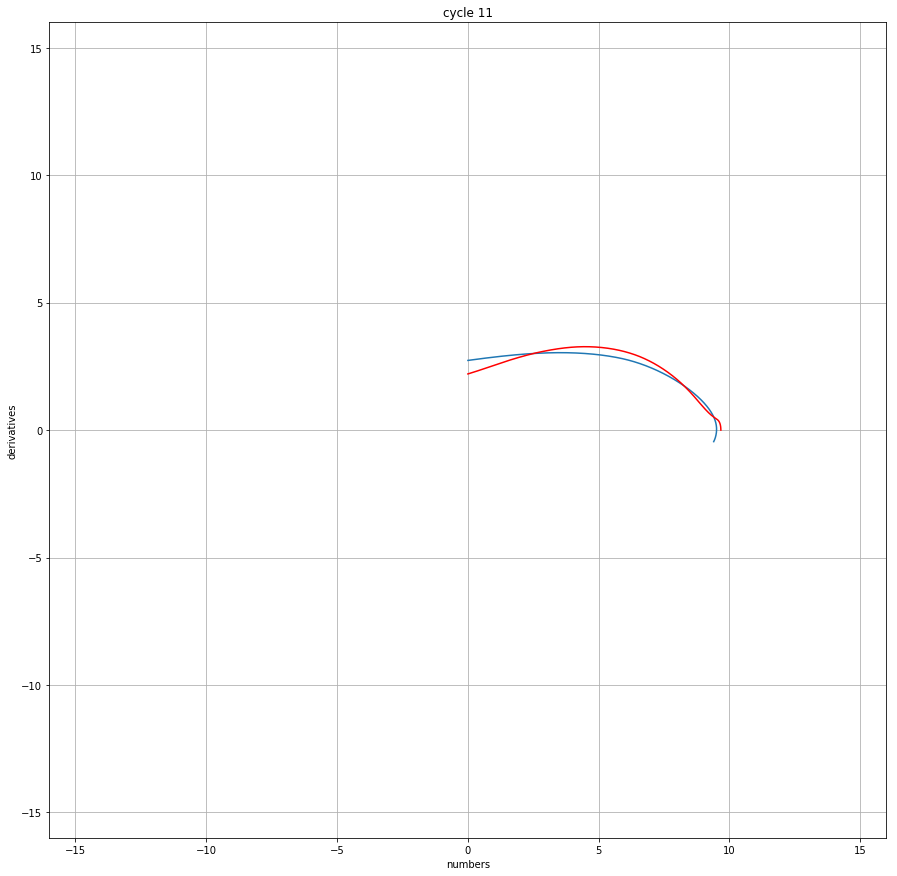

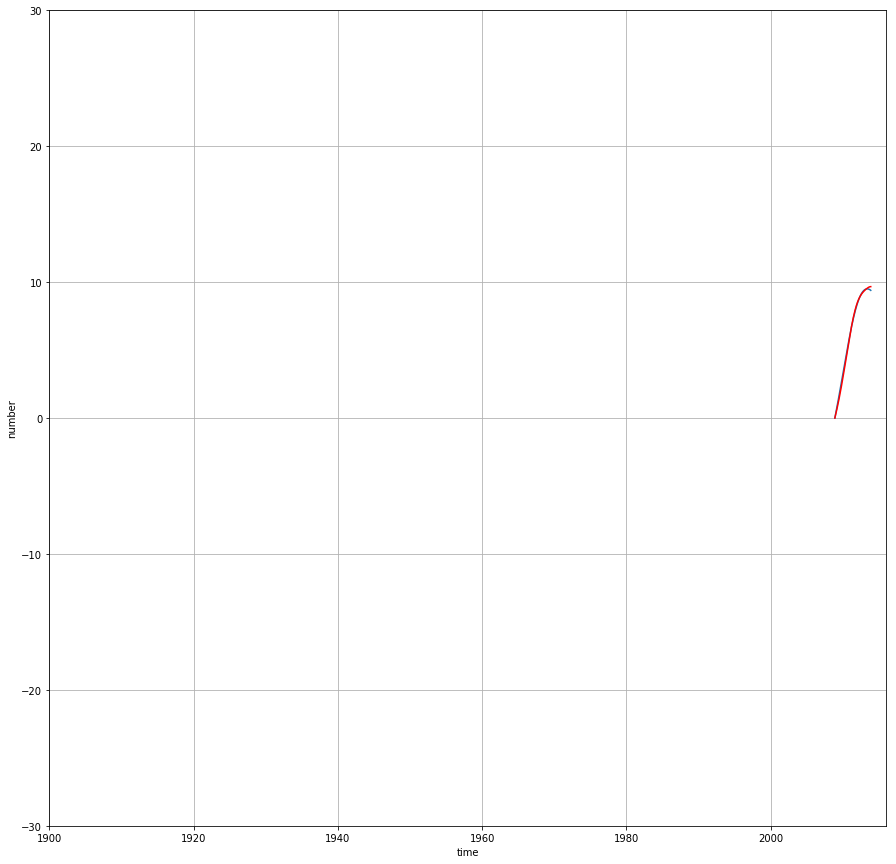

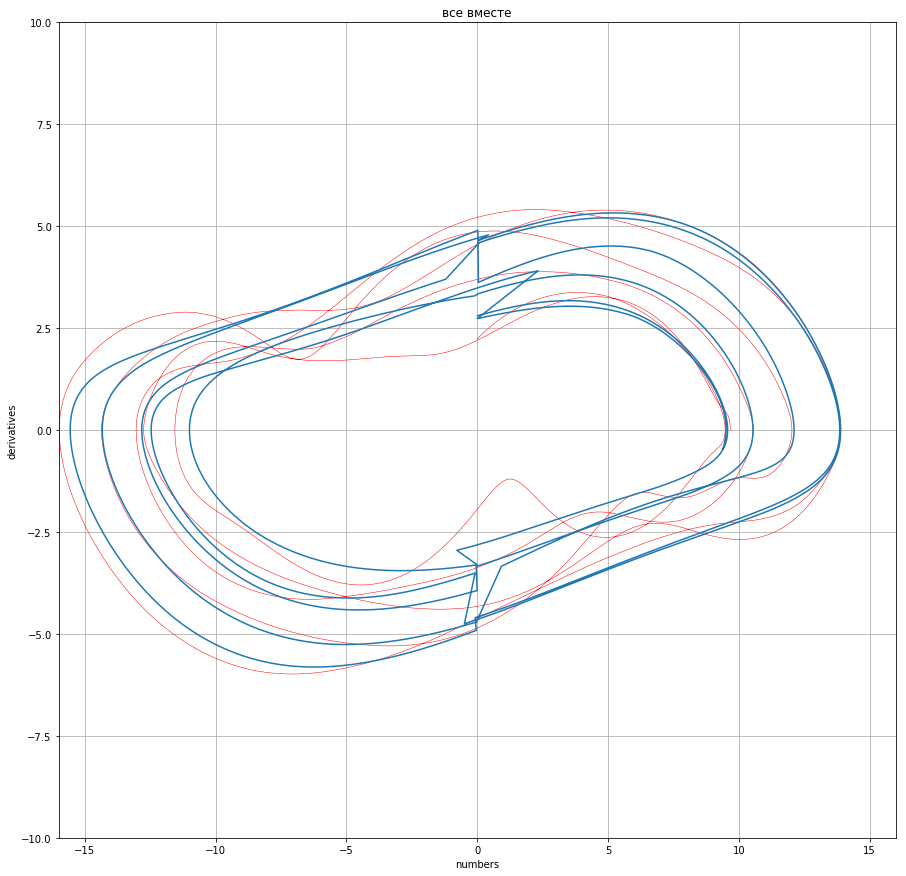

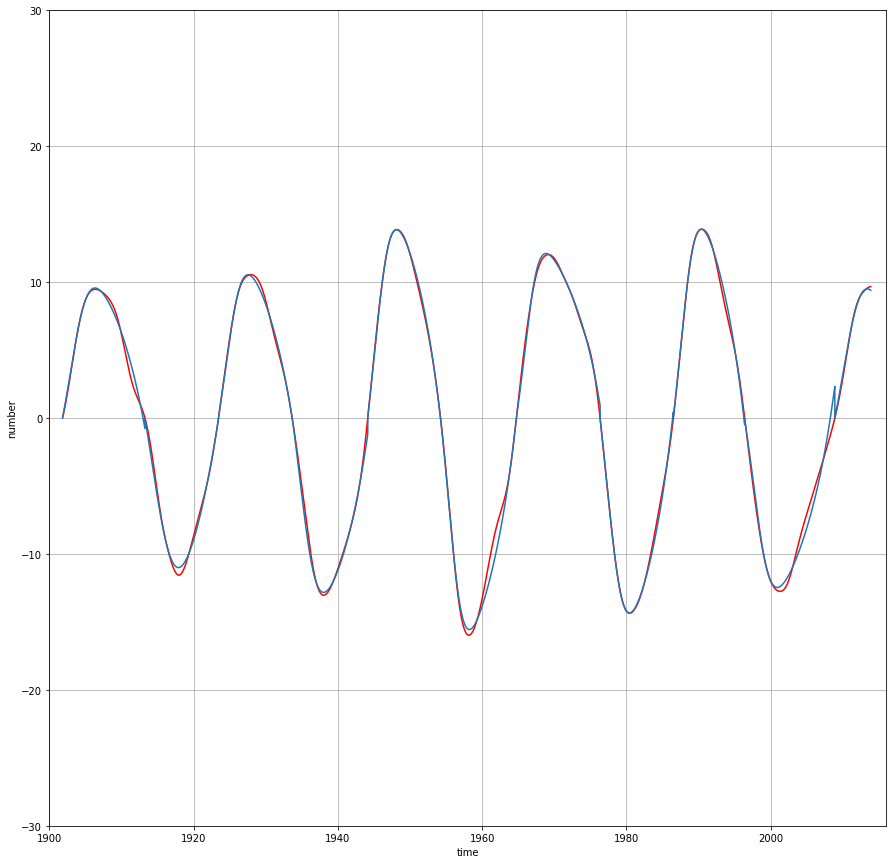

In [33]:
reg_approx_param = cycles_approx(reg_difference, portraits, smoothed_data, cycles)

## Приближение с функцией ошибки равной интегралу разности квадратов

mistake = 1.677954337843614
lamda = 0.0001
mu = 0.117
eps = 0.0434
omega = 0.2757


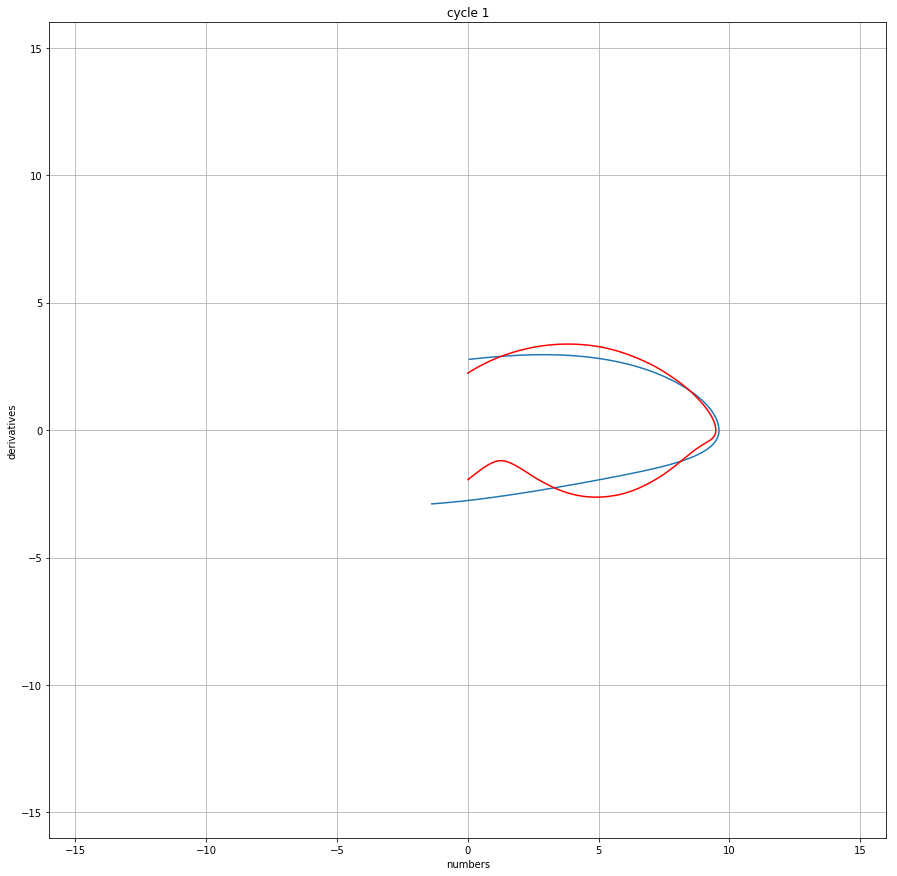

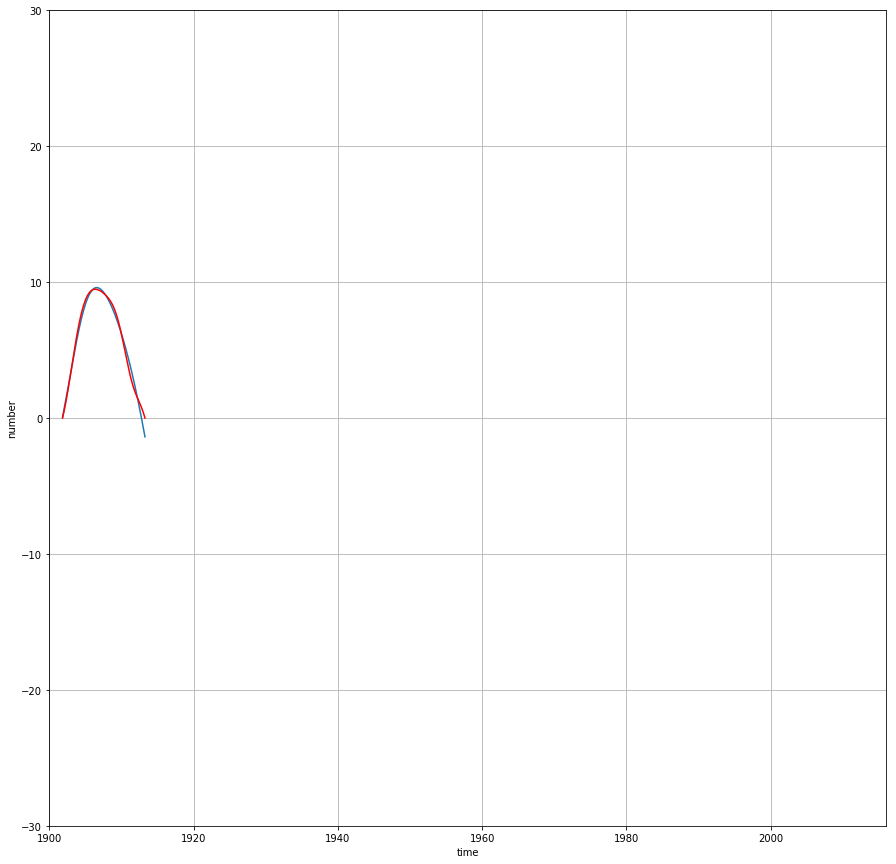

mistake = 1.2471055018859414
lamda = 0.0001
mu = 0.068
eps = 0.033
omega = 0.2954


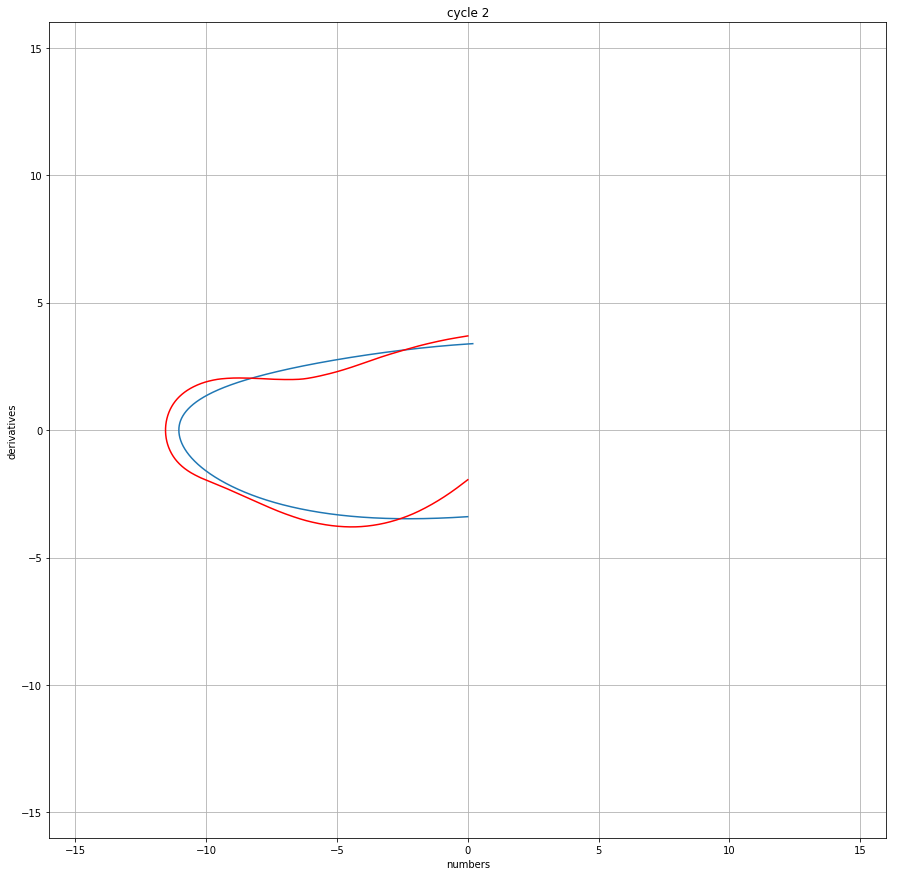

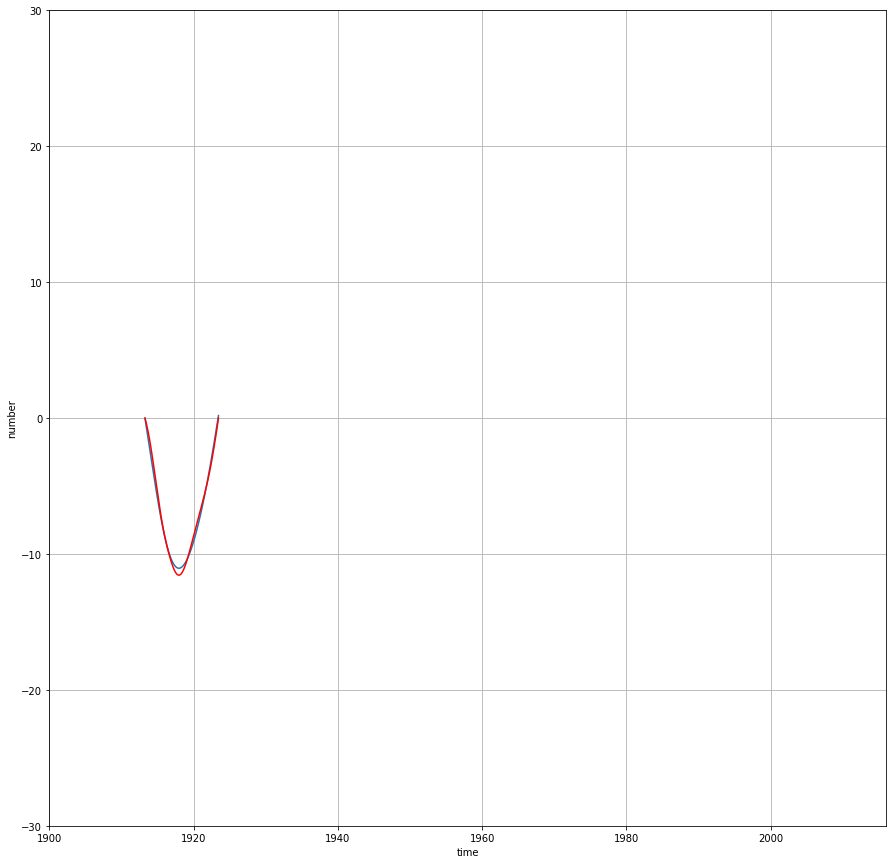

mistake = 0.35196478347269833
lamda = 0.0002
mu = 0.1792
eps = 0.0348
omega = 0.2865


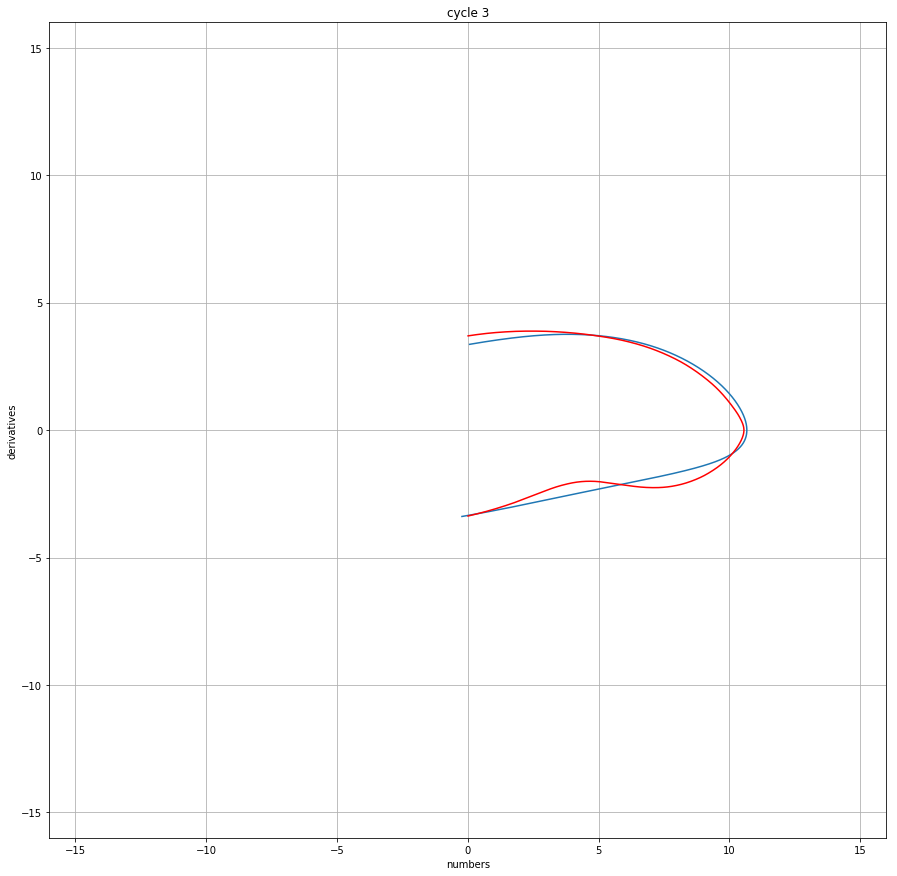

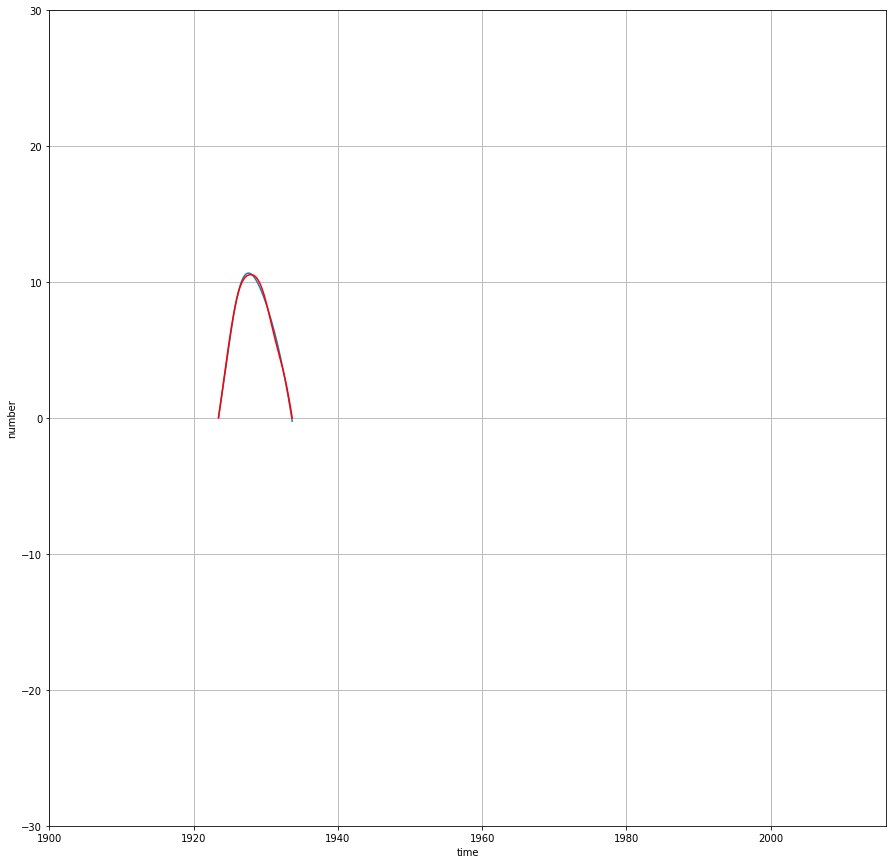

mistake = 0.8062151508652683
lamda = 0.0
mu = 0.1229
eps = 0.0246
omega = 0.2982


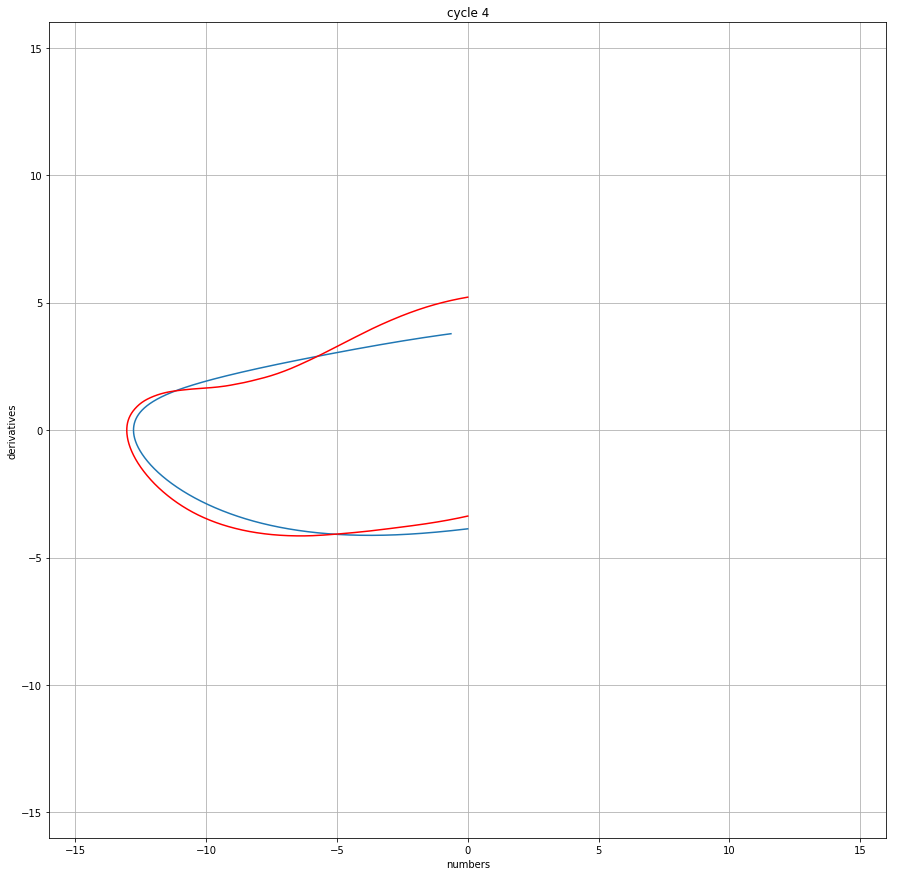

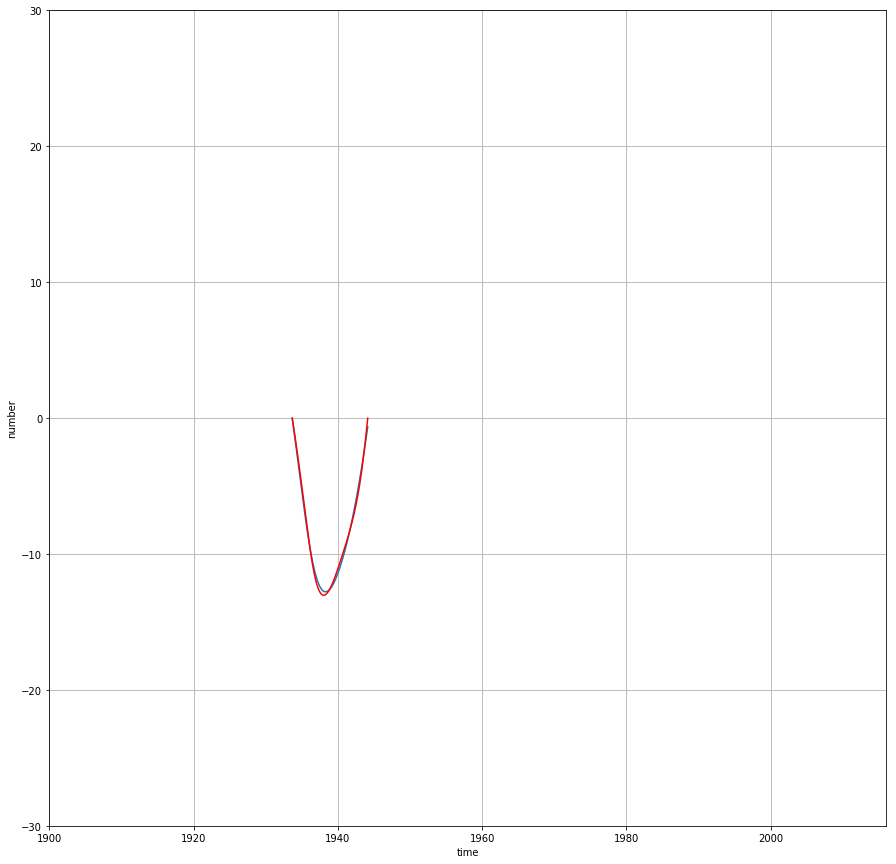

mistake = 0.22253542009719557
lamda = 0.0
mu = 0.2102
eps = 0.0211
omega = 0.3202


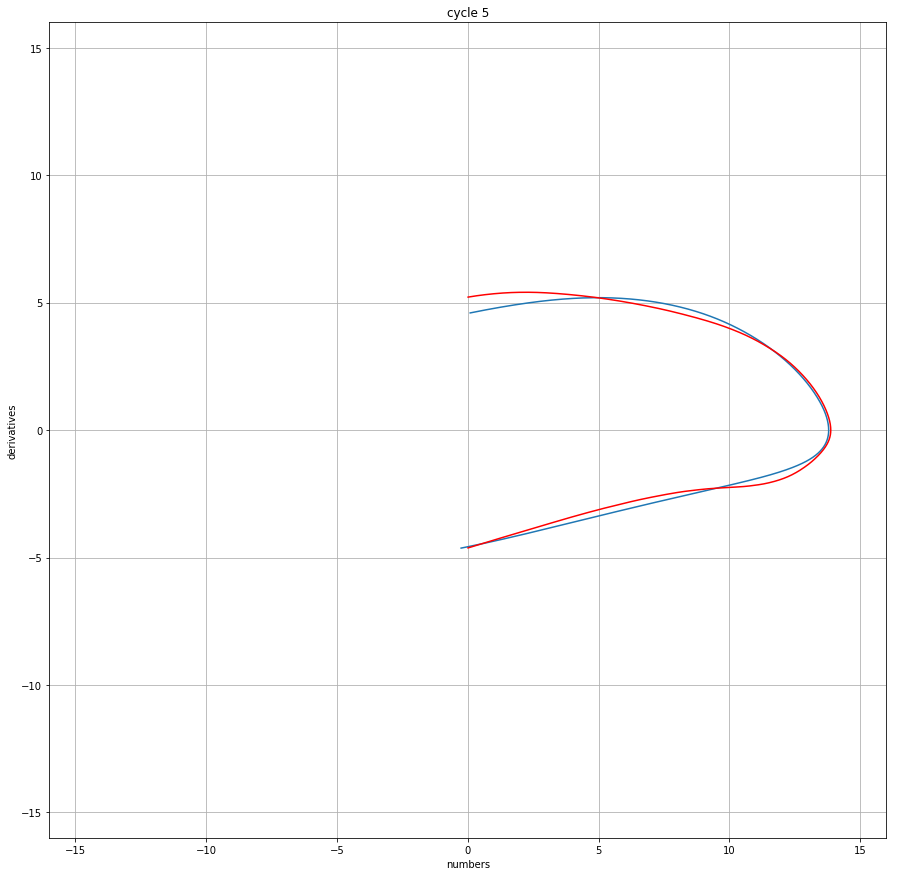

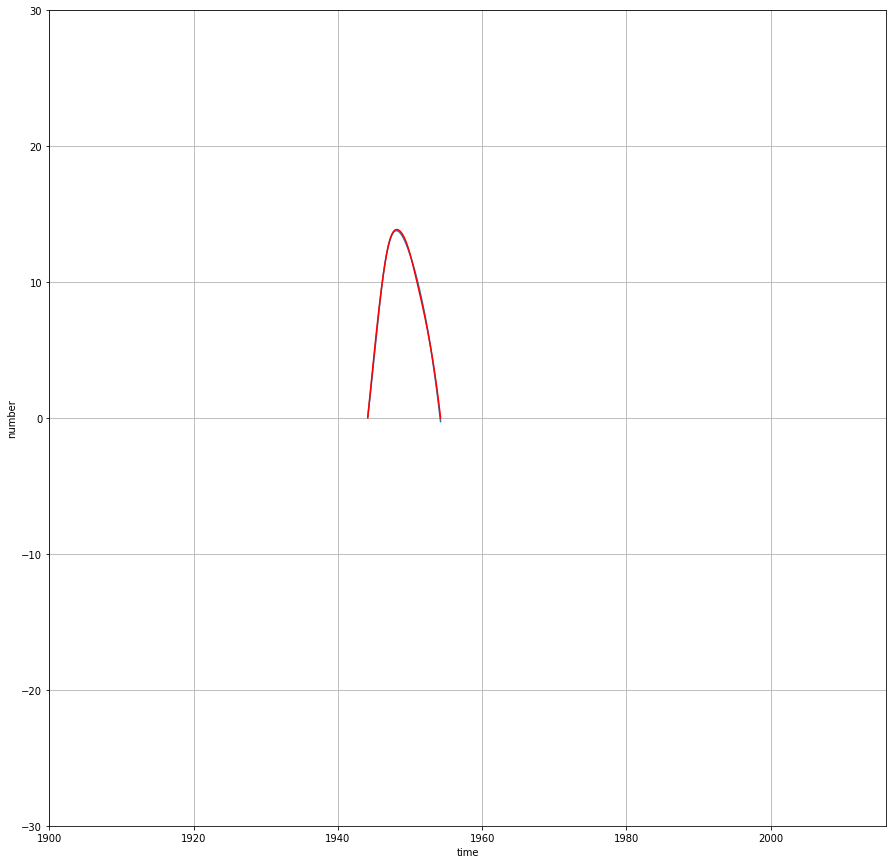

mistake = 4.286230452624857
lamda = 0.0001
mu = 0.262
eps = 0.0167
omega = 0.2871


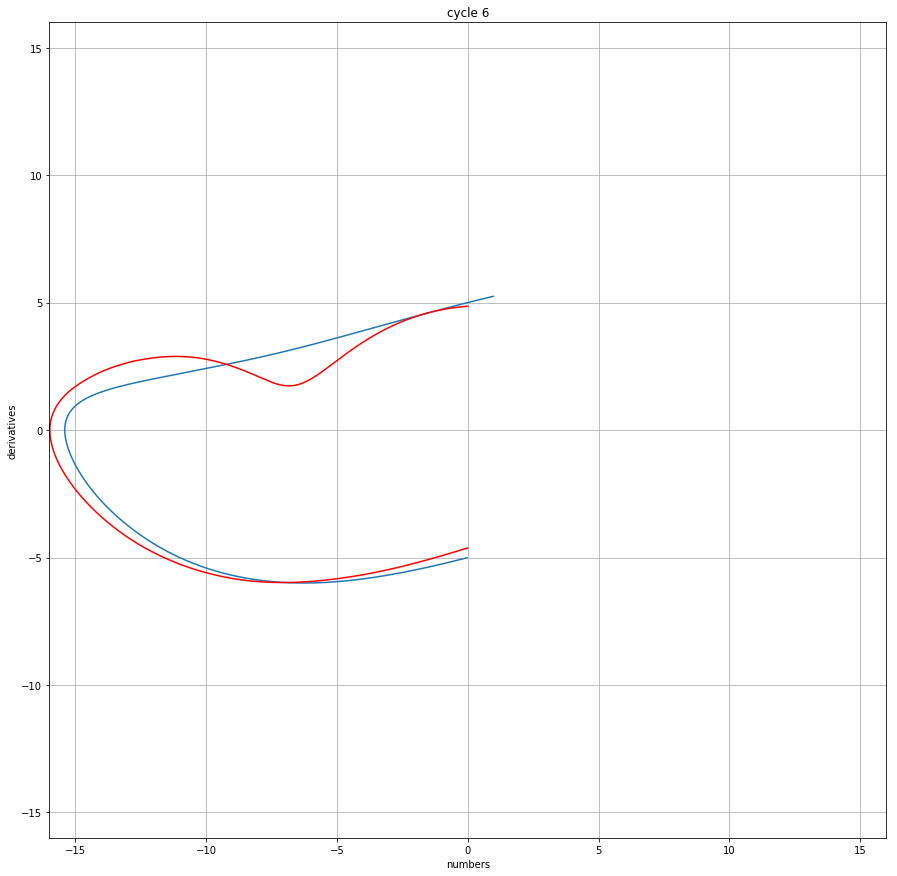

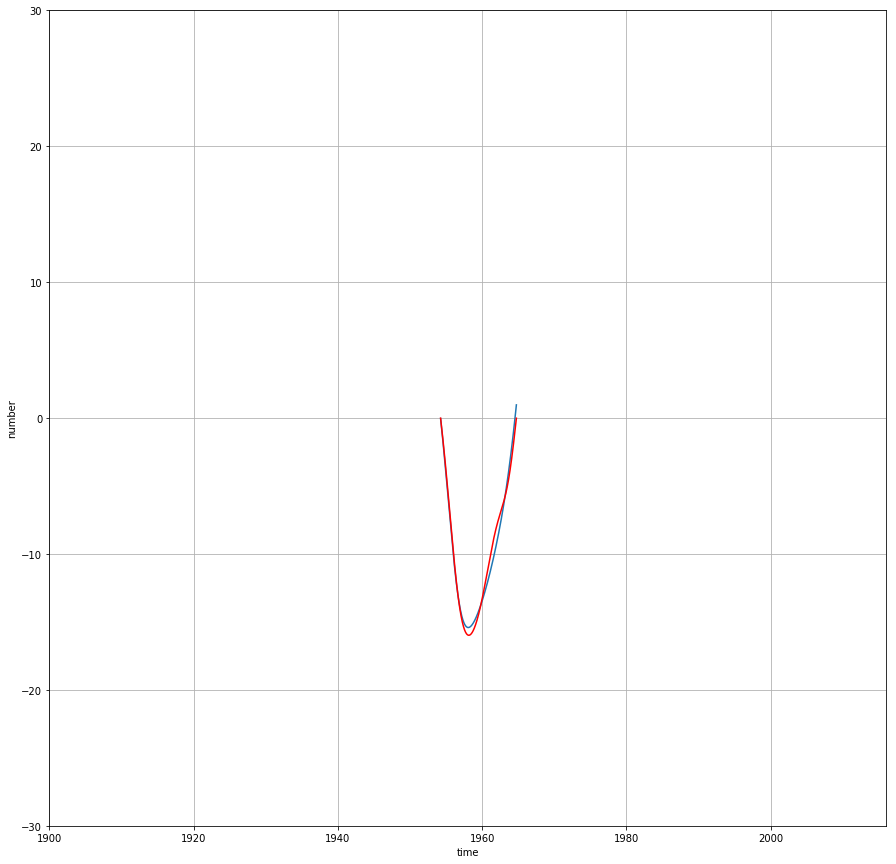

mistake = 0.5953930036996815
lamda = 0.0001
mu = 0.288
eps = 0.0274
omega = 0.2616


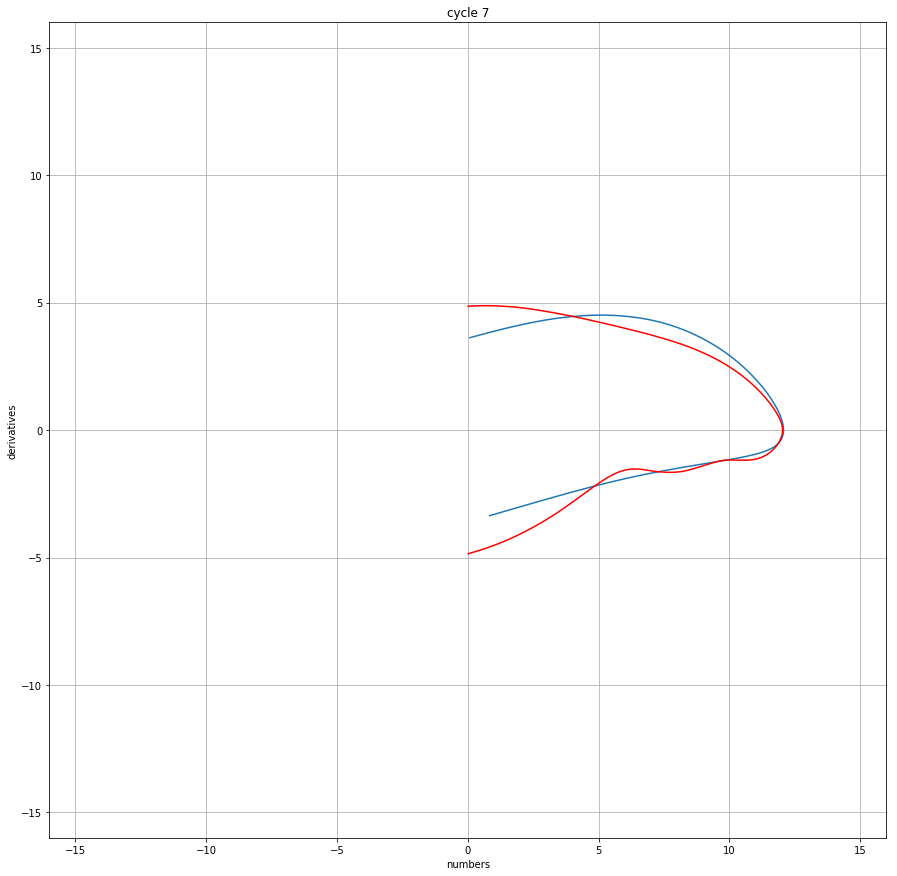

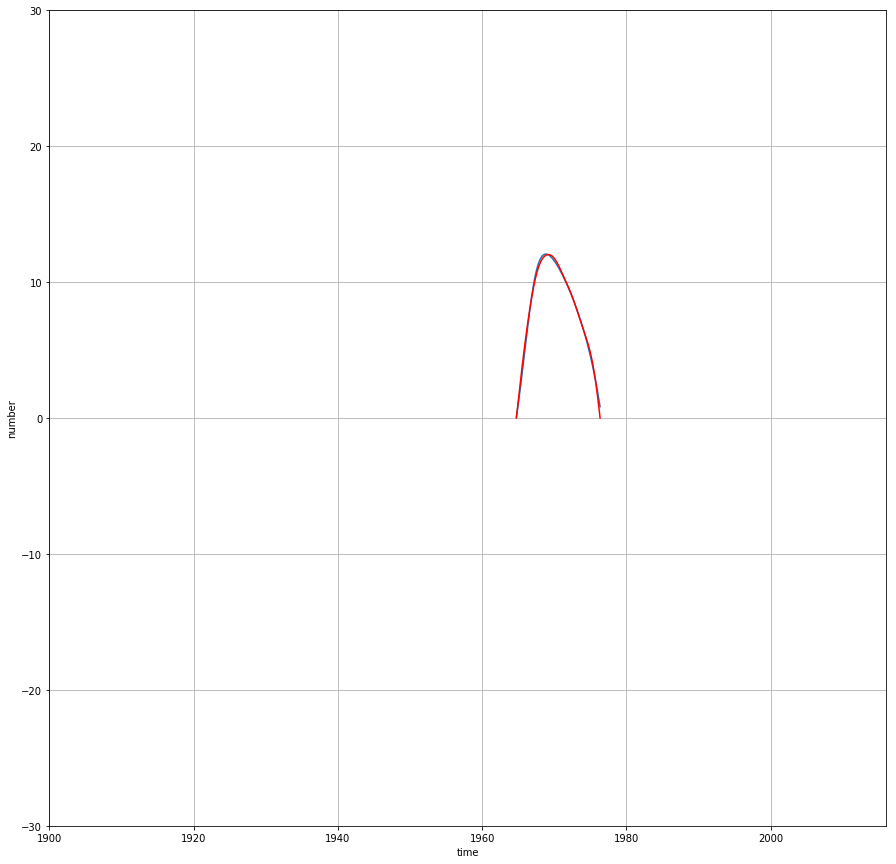

mistake = 0.44462949455853396
lamda = 0.0
mu = 0.2002
eps = 0.0198
omega = 0.3199


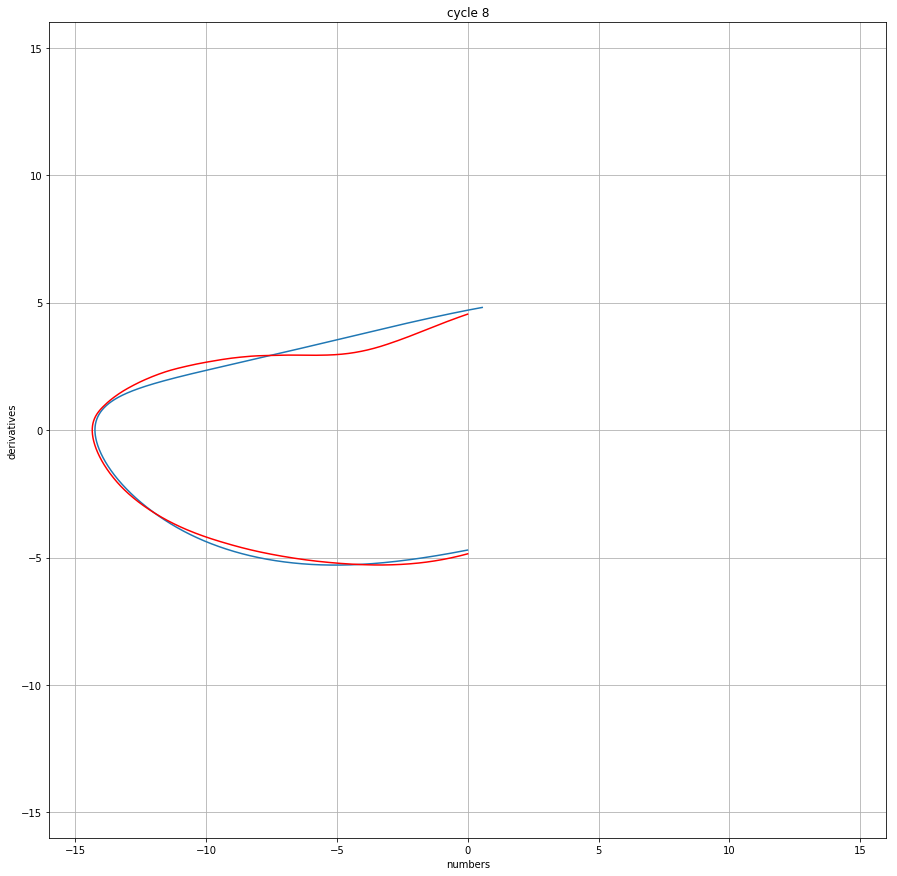

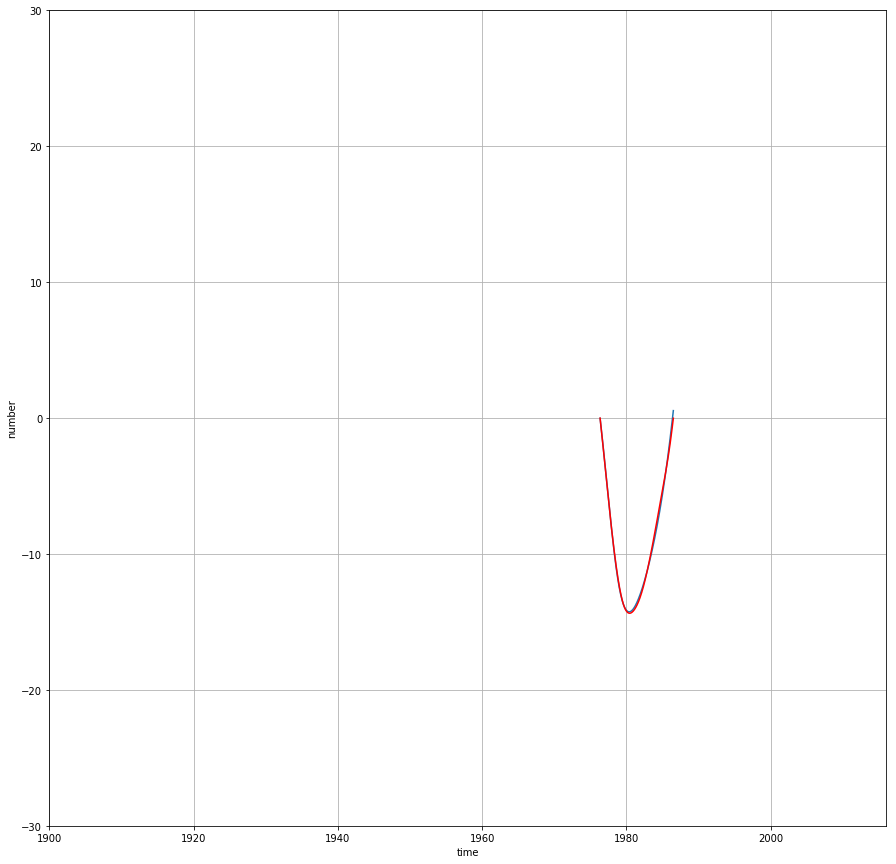

mistake = 1.5472863022077283
lamda = 0.0001
mu = 0.301
eps = 0.0217
omega = 0.3189


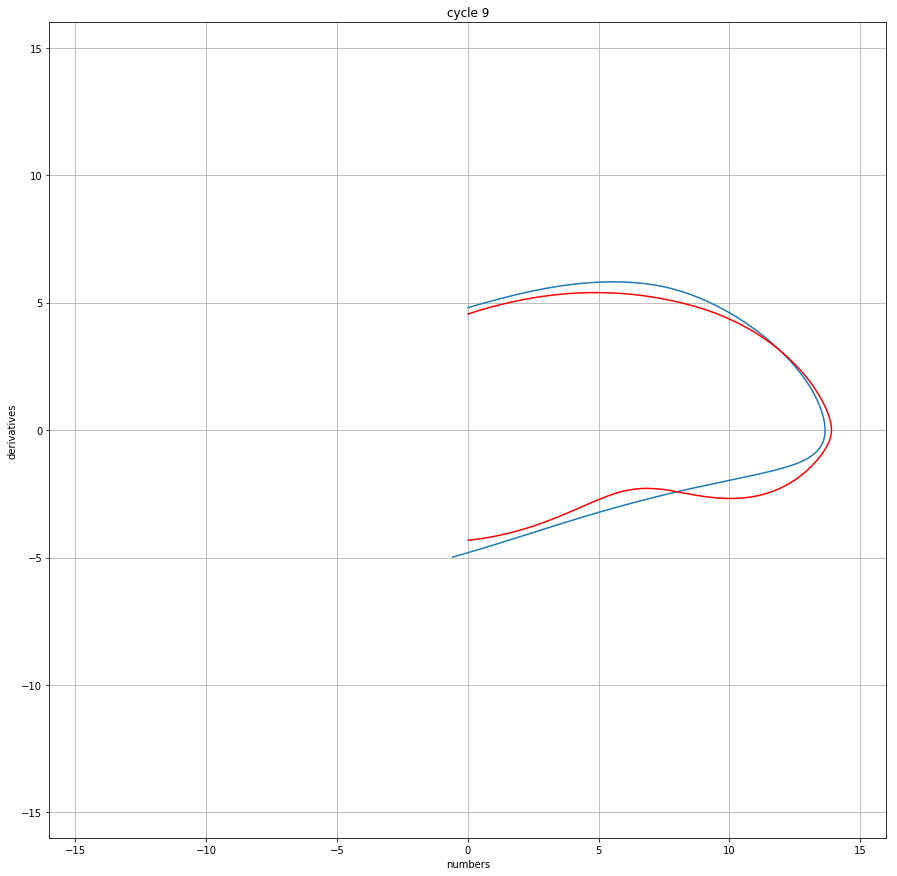

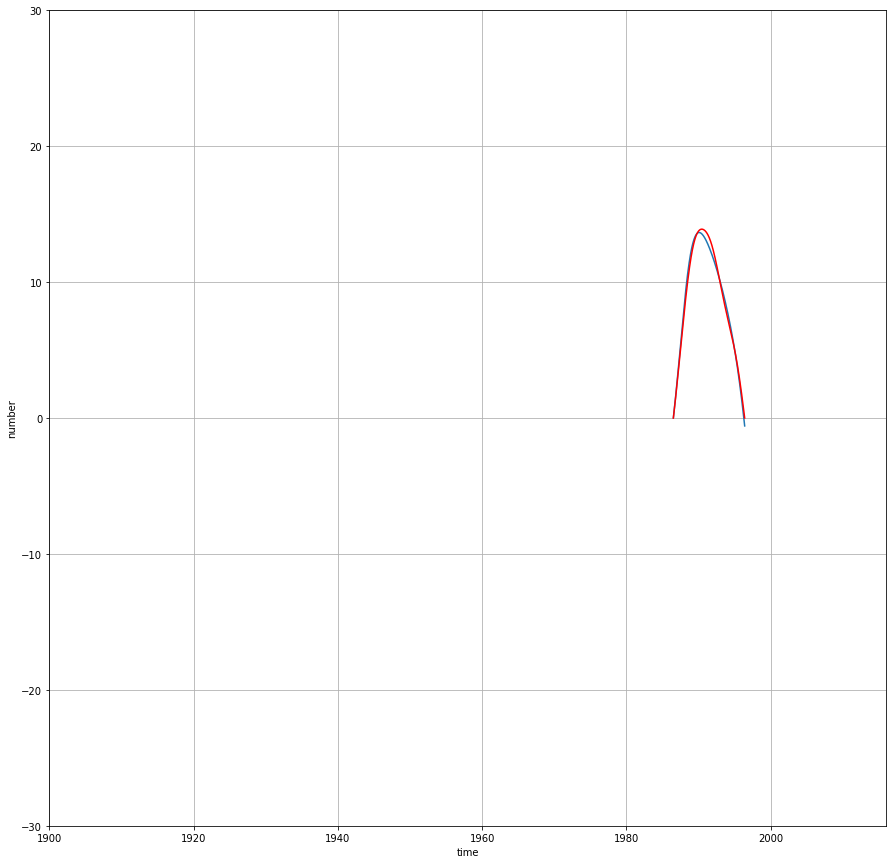

mistake = 5.052644587041574
lamda = 0.0001
mu = 0.2219
eps = 0.0266
omega = 0.2513


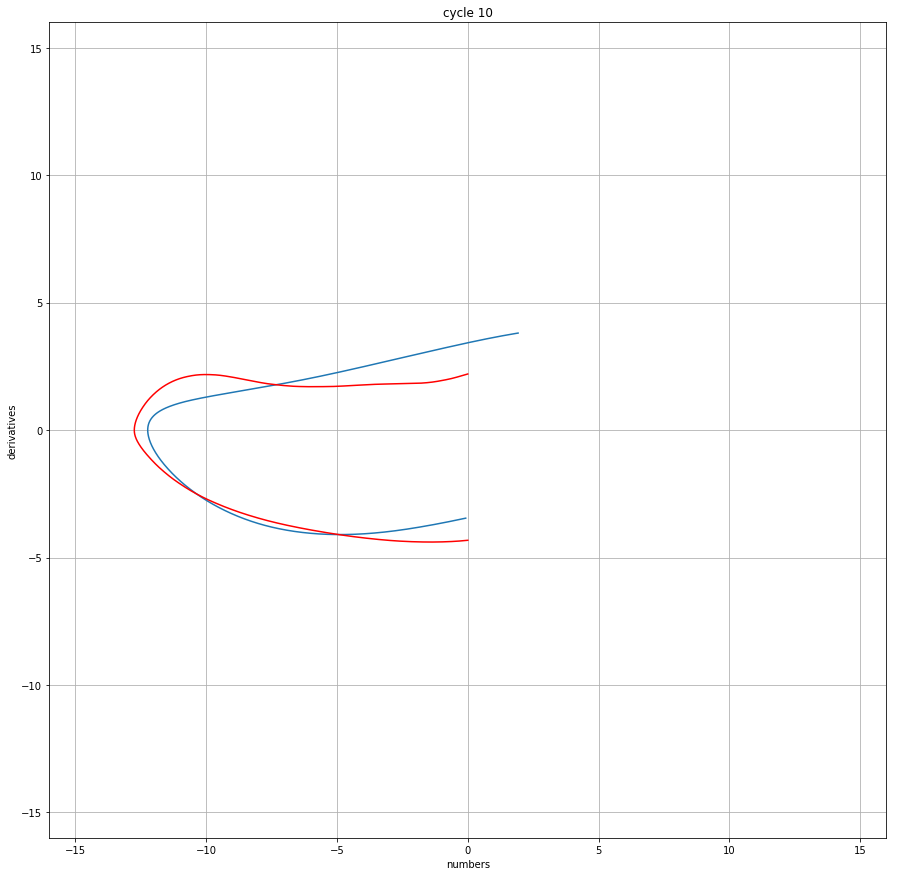

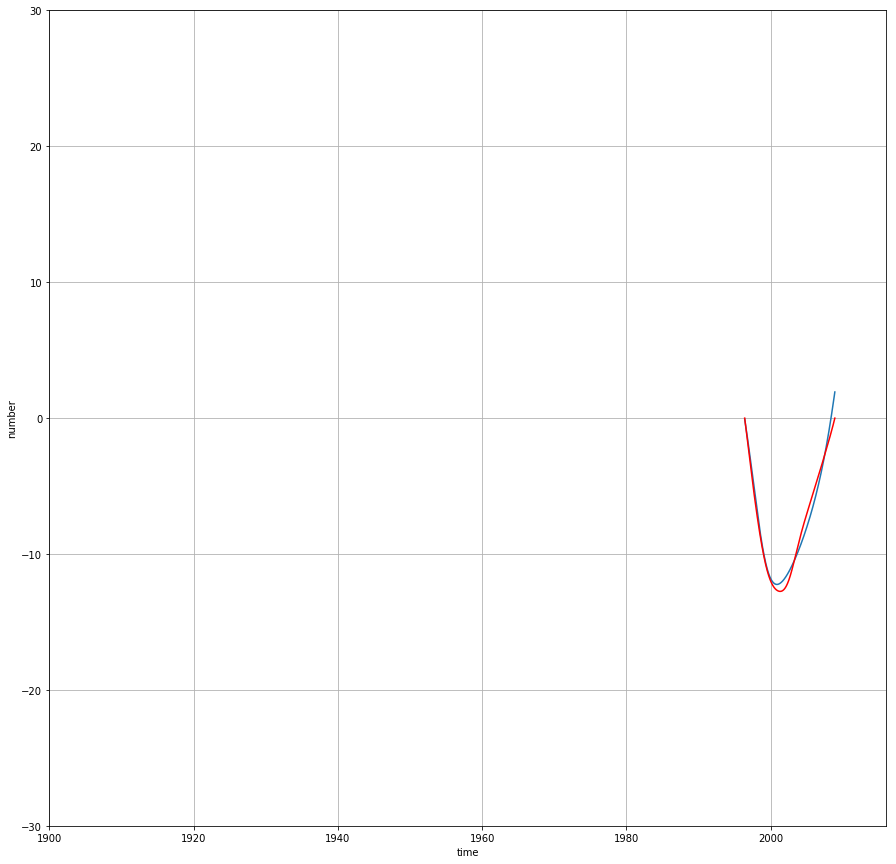

mistake = 0.1676074720934889
lamda = 0.0006
mu = 0.064
eps = 0.0427
omega = 0.2525


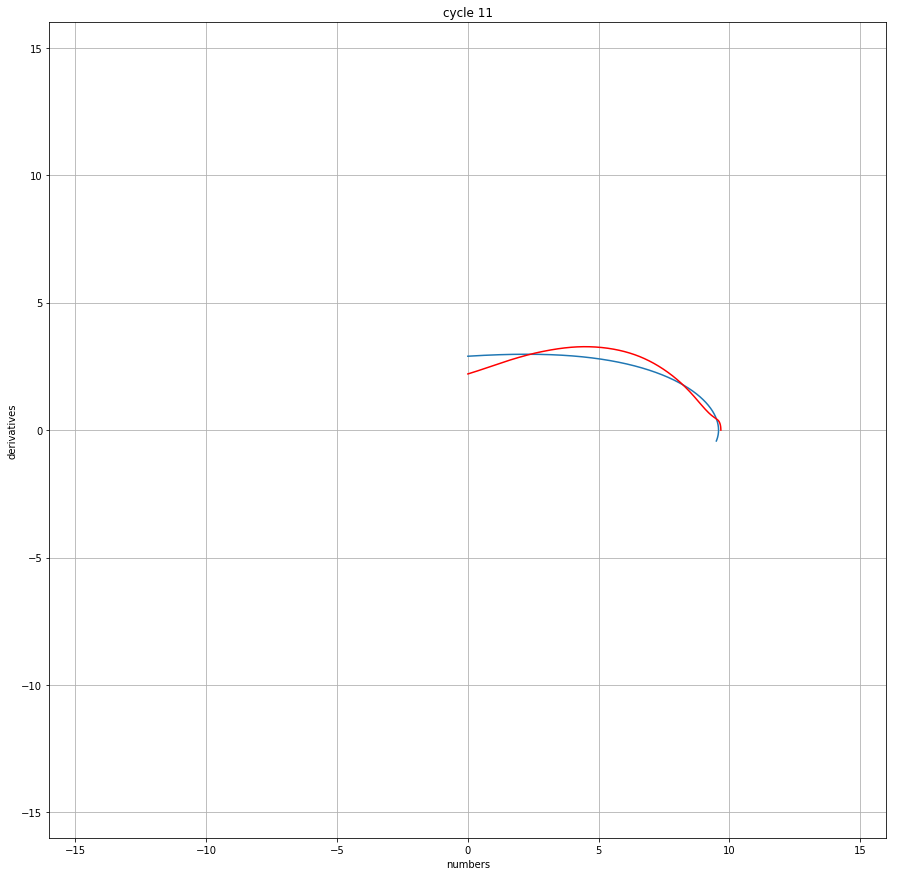

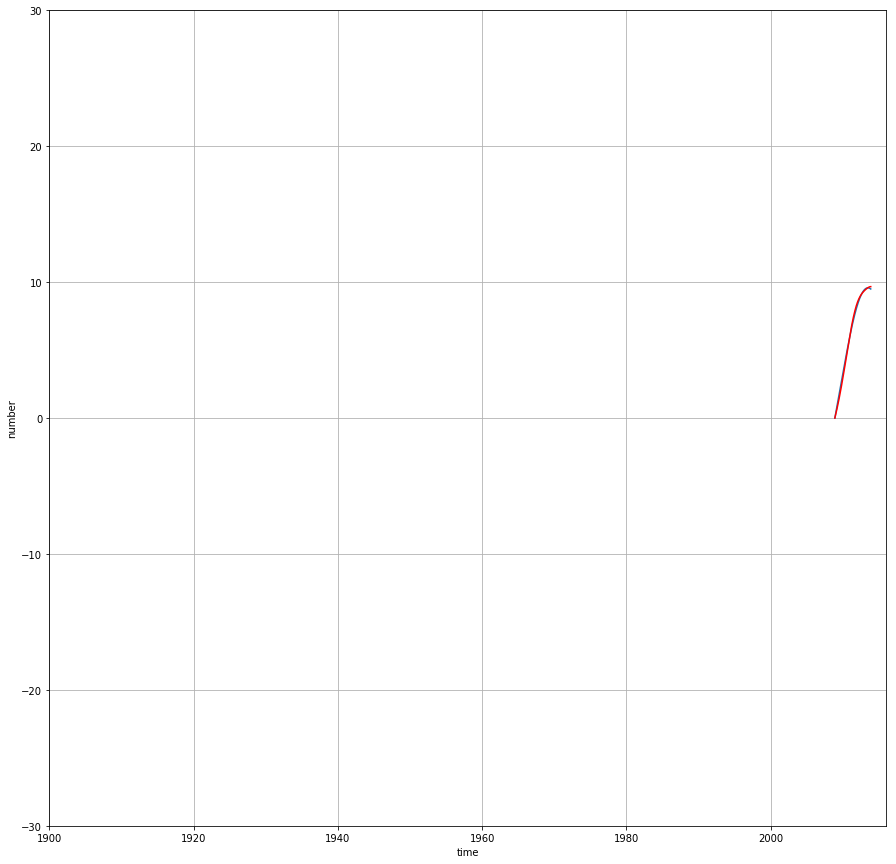

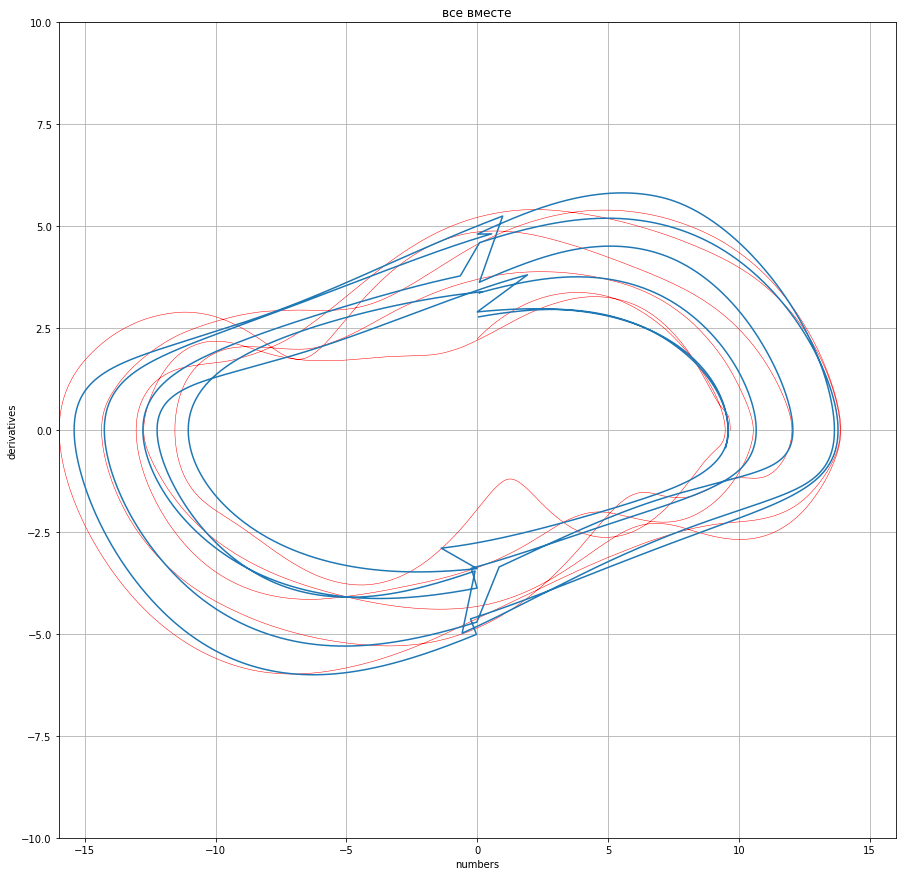

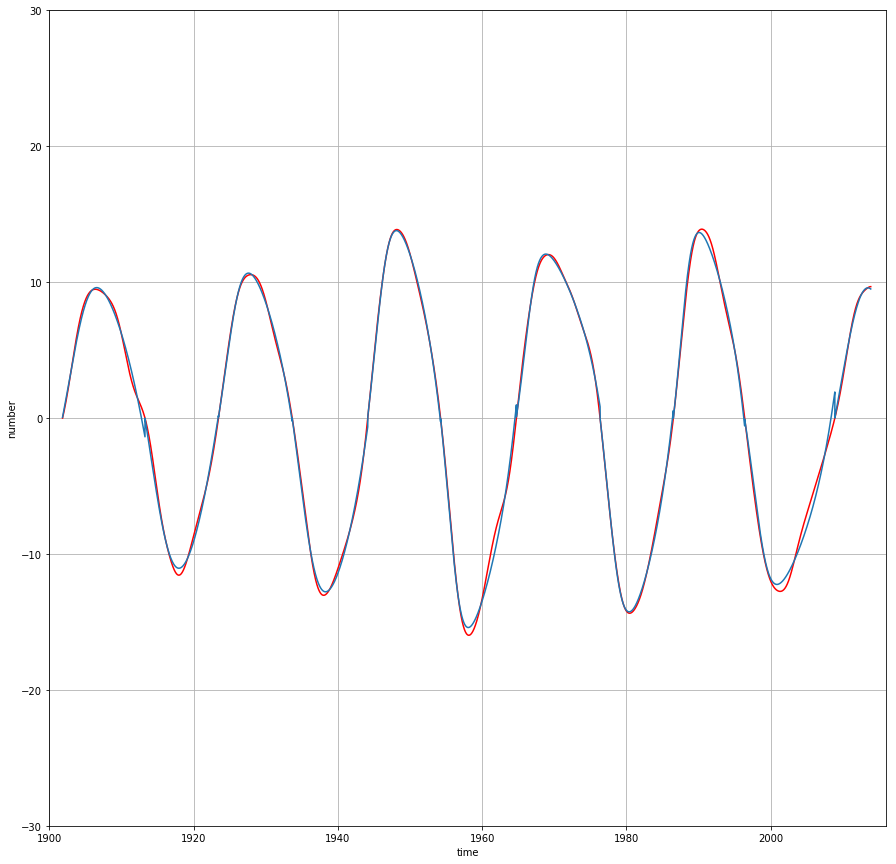

In [34]:
integral_approx_param = cycles_approx(integral_difference, portraits, smoothed_data, cycles)

## Получение амплитуды и периодов

In [35]:
def get_period_and_amplitude(cycles, smoothed_data):
    res = []
    for i in range(0, len(cycles) - 1):
        cycle = smoothed_data[cycles[i][0] : cycles[i][1] + 1,:]
        A = find_max(cycle)
        period = cycle[-1, 0] - cycle[0, 0]
        res.append([abs(A), period])
    return np.array(res)

In [36]:
ap_table = get_period_and_amplitude(cycles, smoothed_data)

## Составление таблиц данных о приближении 1
по столбцам: амплитуда, период, $\lambda$, $\mu$, $\epsilon$, $\omega$

reg_approx_param_table - для приближению по расстоянию

integral_approx_param_table - для приближению по интегралу

In [37]:
reg_approx_param_table = np.concatenate((ap_table, reg_approx_param[0:-1,:]), axis=1)
integral_approx_param_table = np.concatenate((ap_table, integral_approx_param[0:-1,:]), axis=1)

## Получение сглаживания вероятностным методом

In [40]:
def get_changed_data_2(data, minimums):
    i = 0
    j = 0
    event_num = len(data)
    minimums_num = len(minimums)
    changed_data = []
    while (i < event_num):
        while (i < event_num and
               (j >= minimums_num or data[i][0] < minimums[j])):
            data_pair = [data[i][0], np.sqrt(data[i][1])]
            changed_data.append(data_pair)
            i += 1
        j += 1
    return changed_data

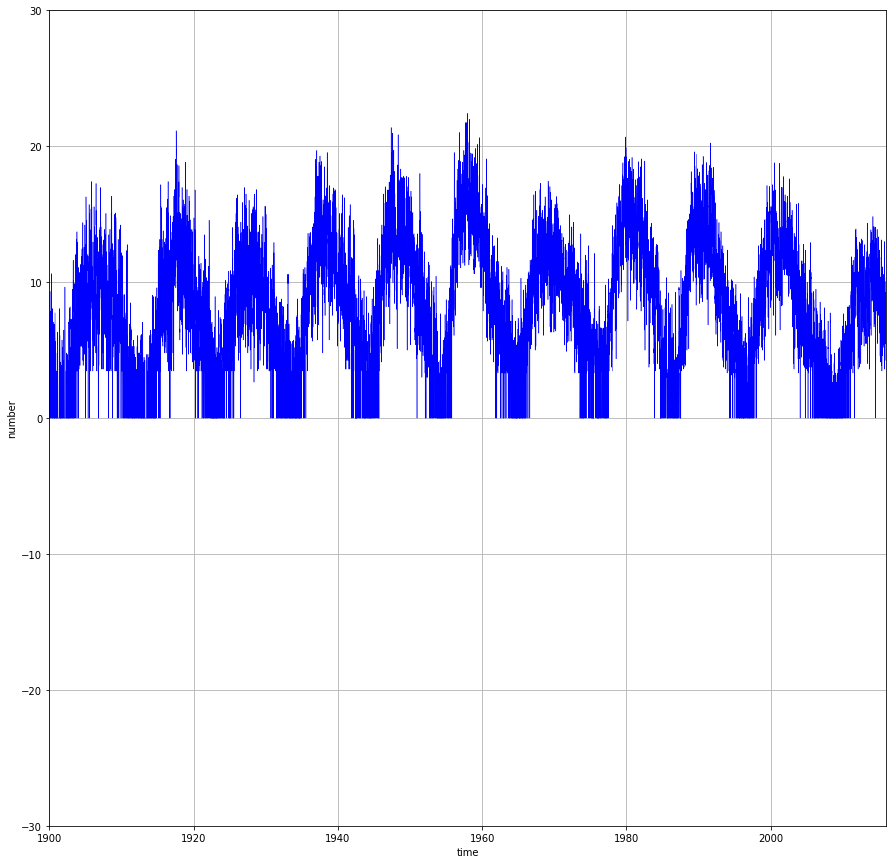

In [41]:
new_data_2 = np.array(get_changed_data_2(data, activity_minimums_list))
add_graph_parametrs()
plt.plot(new_data_2[:,0], new_data_2[:,1], linewidth=0.5, color='b')
plt.show()

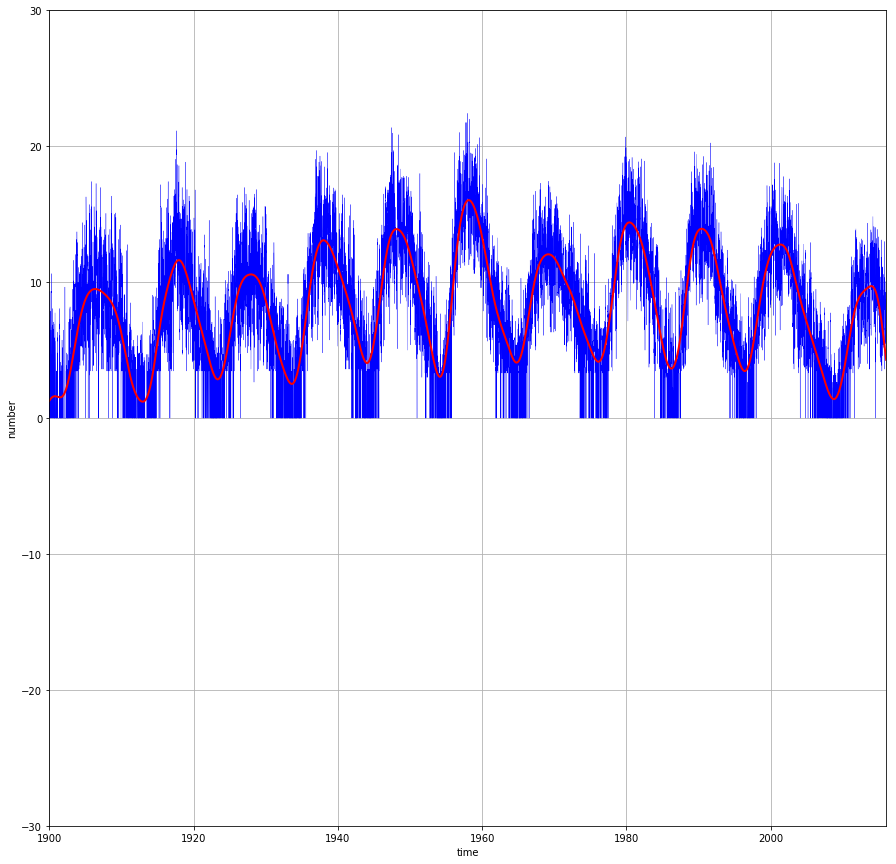

In [42]:
raw_smoothed_data_2 = np.array(FFT_low_pass(new_data_2, 0.0001, 0.0022))
add_graph_parametrs()
plt.plot(new_data_2[:,0], new_data_2[:,1], linewidth=0.3, color='b')
plt.plot(raw_smoothed_data_2[:,0], raw_smoothed_data_2[:,1], linewidth=2, color='r')
plt.show()

In [43]:
def find_minimums(data):
    minimums = []
    for i in range(1, len(data) - 1):
        if (data[i - 1, 1] > data[i, 1] and data[i, 1] < data[i + 1, 1]):
            minimums.append(i)
    return minimums

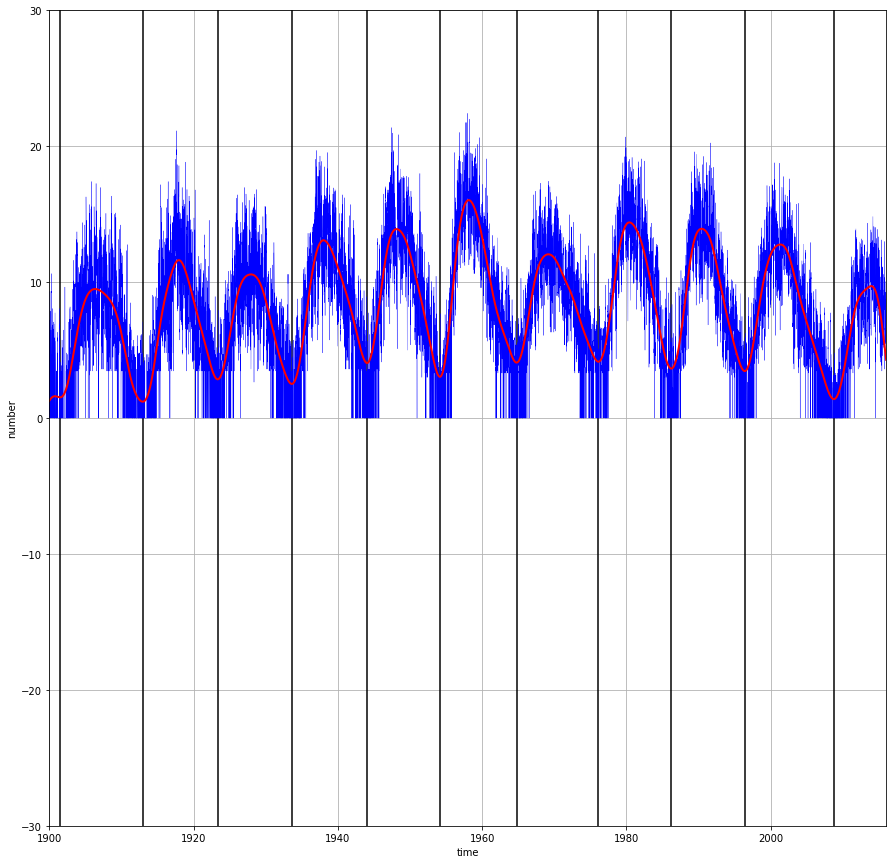

In [44]:
add_graph_parametrs()
minimums = find_minimums(raw_smoothed_data_2);
for i in minimums:
    plt.plot([raw_smoothed_data_2[i, 0], raw_smoothed_data_2[i, 0]], [-30, 30], color='black')
plt.plot(new_data_2[:,0], new_data_2[:,1], linewidth=0.3, color='b')
plt.plot(raw_smoothed_data_2[:,0], raw_smoothed_data_2[:,1], linewidth=2, color='r')
plt.show()

In [45]:
def get_ranges(data, minimums):
    i = 0
    j = 0
    events_num = len(data)
    min_num = len(minimums)
    flag_first = 0
    ranges = []
    append_pair = []
    while (i < events_num and j < min_num):
        if (not flag_first and abs(data[i, 0] - data[minimums[j], 0]) <= 0.75):
            flag_first = 1
            append_pair.append(i)
        if (flag_first and abs(data[i, 0] - data[minimums[j], 0]) > 0.75):
            flag_first = 0
            append_pair.append(i - 1)
            ranges.append(append_pair)
            append_pair = []
            j += 1
        i += 1
    return ranges

In [46]:
def get_signs(data, minimums, ranges):
    signs = []
    i = 0
    j = 0
    events_num = len(data)
    min_num = len(minimums)
    cur_sign = -1
    while (i < events_num):
        if (j < min_num and i == ranges[j][0]):
            a = data[minimums[j],:]
            sig = np.array([[0.75 ** 2, 0],
                           [0, (data[ranges[j][0], 1] + data[ranges[j][1], 1]) ** 2 / 4]])
            while (i <= minimums[j]):
                prob = 4 * multivariate_normal.cdf([data[i, 0],
                                                    2 * data[minimums[j], 1] - data[i, 1]],
                                                    mean=a, cov=sig)
                if (prob >= random.random()):
                    signs.append(-cur_sign)
                else:
                    signs.append(cur_sign)
                i += 1
            cur_sign = -cur_sign
            while (i <= ranges[j][1]):
                prob = 4 * multivariate_normal.cdf([2 * data[minimums[j], 0] - data[i, 0], 
                                                    2 * data[minimums[j], 1] - data[i, 1]],
                                                    mean=a, cov=sig)
                if (prob >= random.random()):
                    signs.append(-cur_sign)
                else:
                    signs.append(cur_sign)
                i += 1
            j += 1
        else:
            signs.append(cur_sign)
            i += 1
    return signs

In [47]:
ranges = get_ranges(raw_smoothed_data_2, minimums)

In [48]:
singns = get_signs(raw_smoothed_data_2, minimums, ranges)

In [49]:
def signed_data(data, signs):
    events_num = len(data)
    changed_data = []
    for i in range (0, events_num):
        changed_data.append([data[i, 0], data[i, 1] * signs[i]])
    return np.array(changed_data)

In [51]:
changed_data_2 = signed_data(new_data_2, singns)

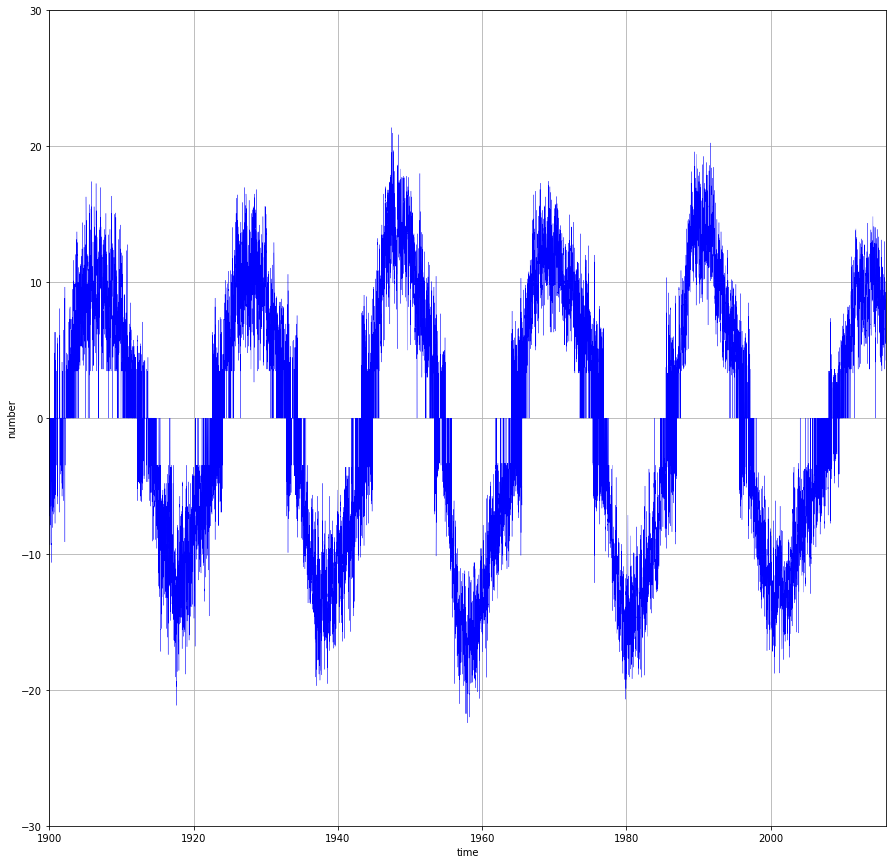

In [53]:
add_graph_parametrs()
plt.plot(changed_data_2[:,0], changed_data_2[:,1], linewidth=0.3, color='b')
plt.show()

In [54]:
smoothed_data_2 = np.array(FFT_low_pass(changed_data_2, 0.0001, 0.0022))

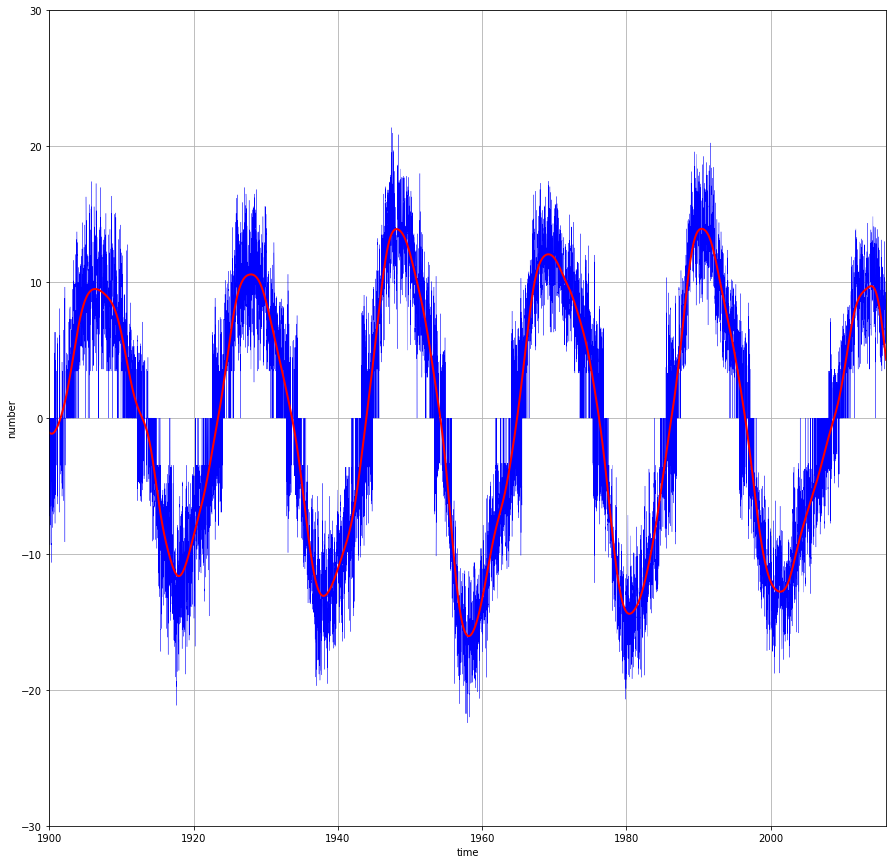

In [55]:
add_graph_parametrs()
plt.plot(changed_data_2[:,0], changed_data_2[:,1], linewidth=0.3, color='b')
plt.plot(smoothed_data_2[:,0], smoothed_data_2[:,1], linewidth=2, color='r')
plt.show()

## Сравнение с предыдущим

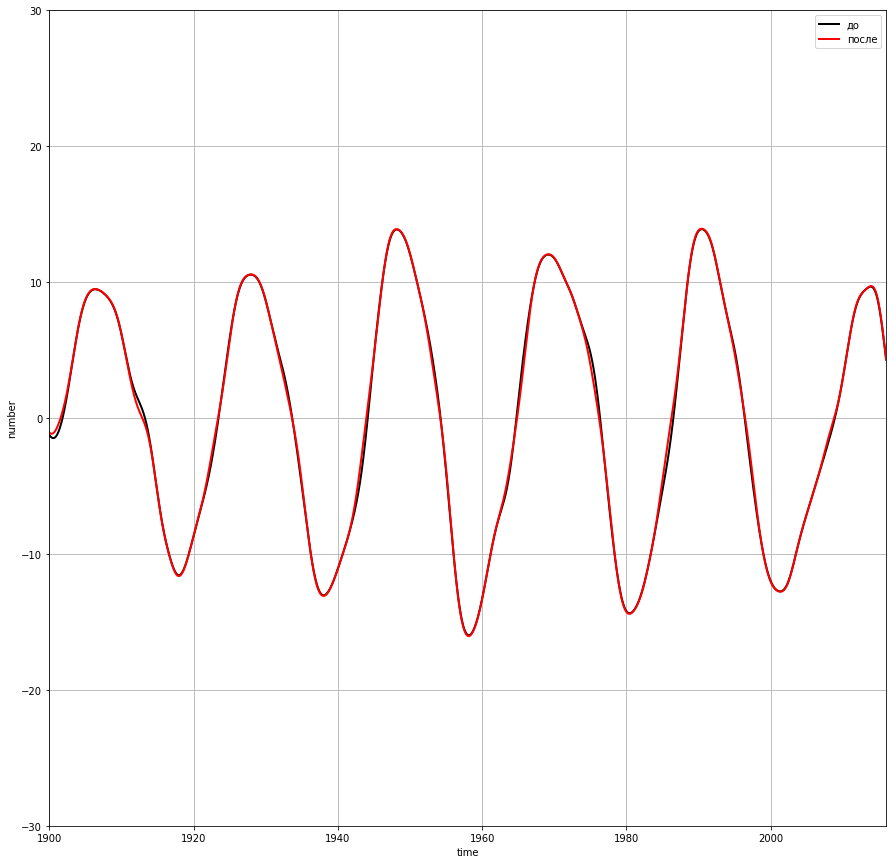

In [56]:
add_graph_parametrs()
plt.plot(smoothed_data[:,0], smoothed_data[:,1], linewidth=2, color='black', label='до')
plt.plot(smoothed_data_2[:,0], smoothed_data_2[:,1], linewidth=2, color='r', label='после')
plt.legend()
plt.show()

In [58]:
cycles_2 = get_cycles_borders(smoothed_data_2)

In [60]:
portraits_2 = []
for cycle in cycles_2:
    portraits_2.append(np.array(cycle_phase_portrait(cycle[0], cycle[1], smoothed_data_2)))

красный - без вероятности 
 синий - с вероятностью



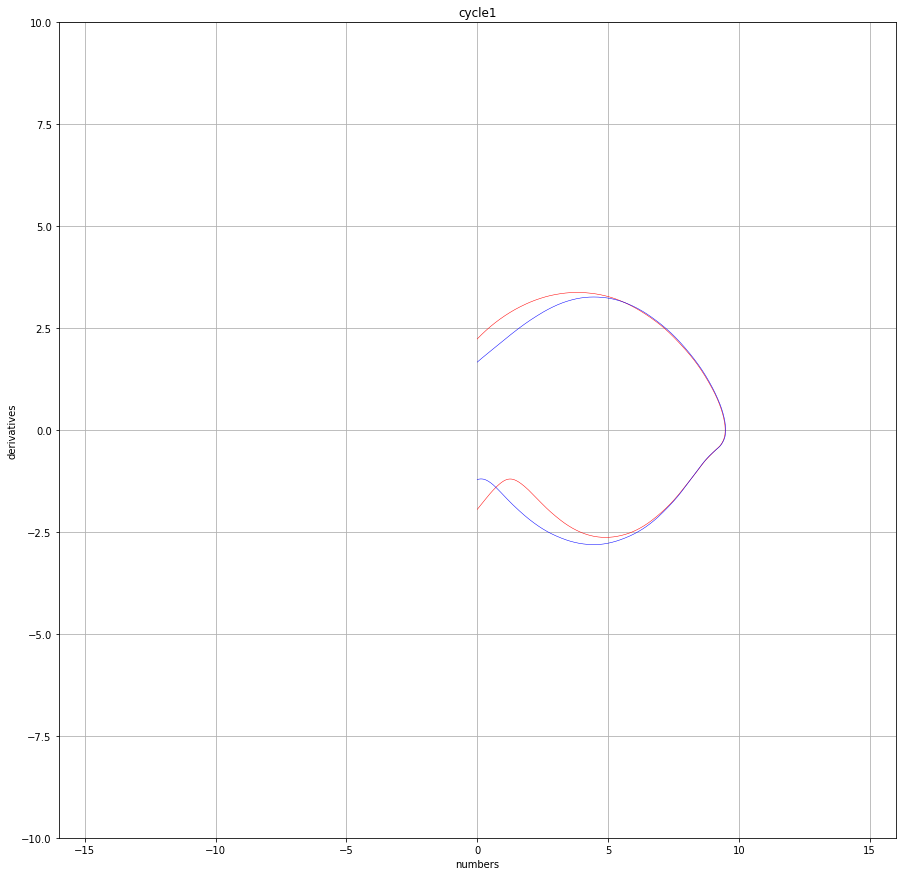

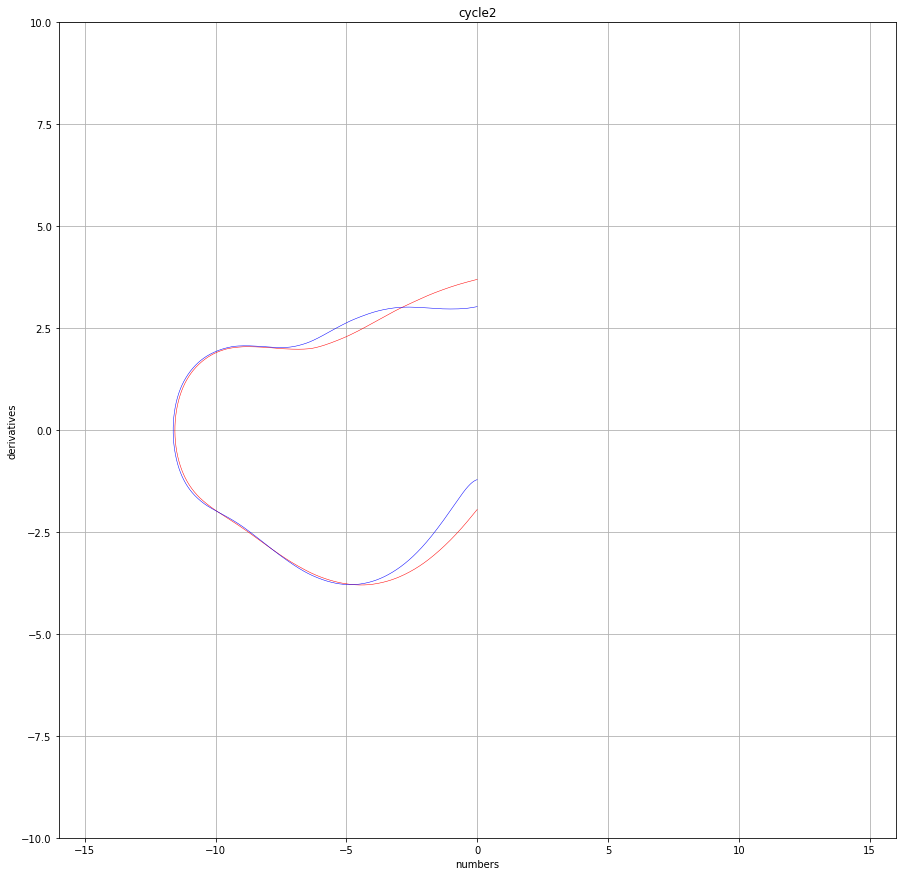

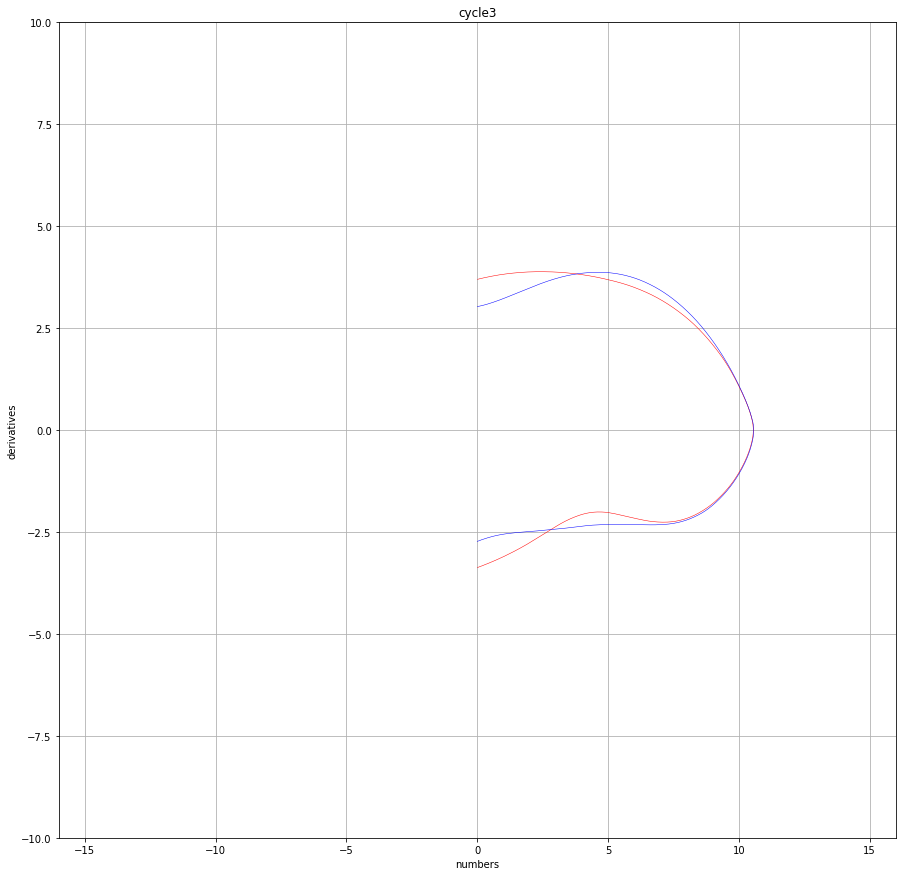

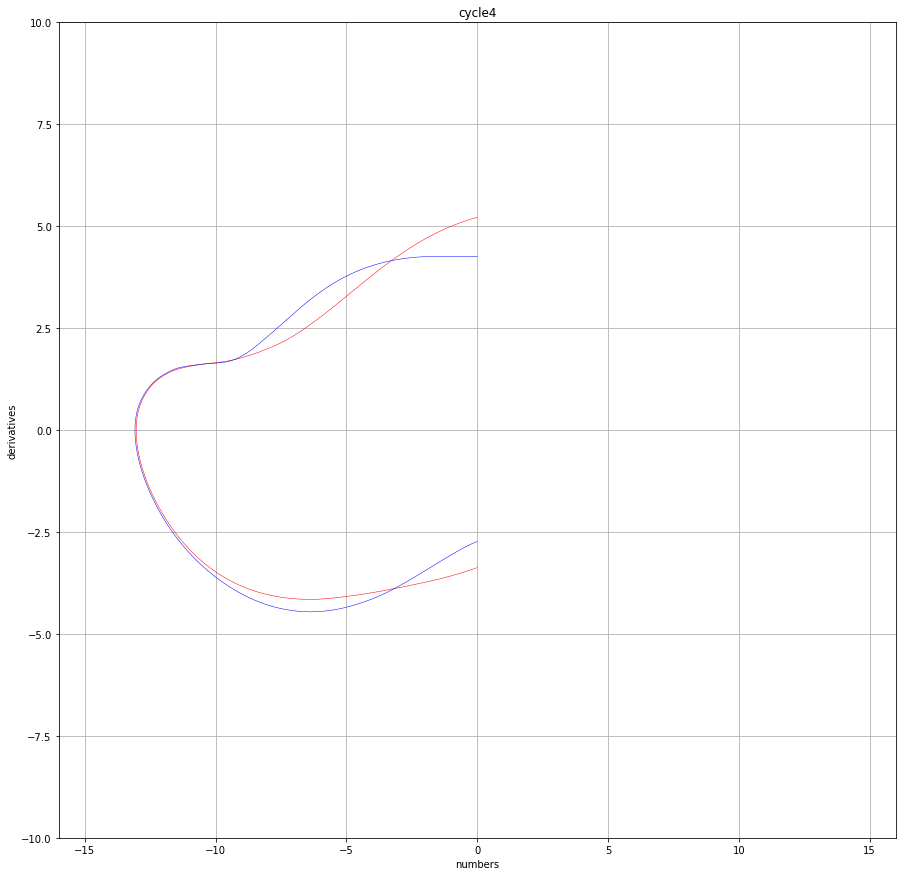

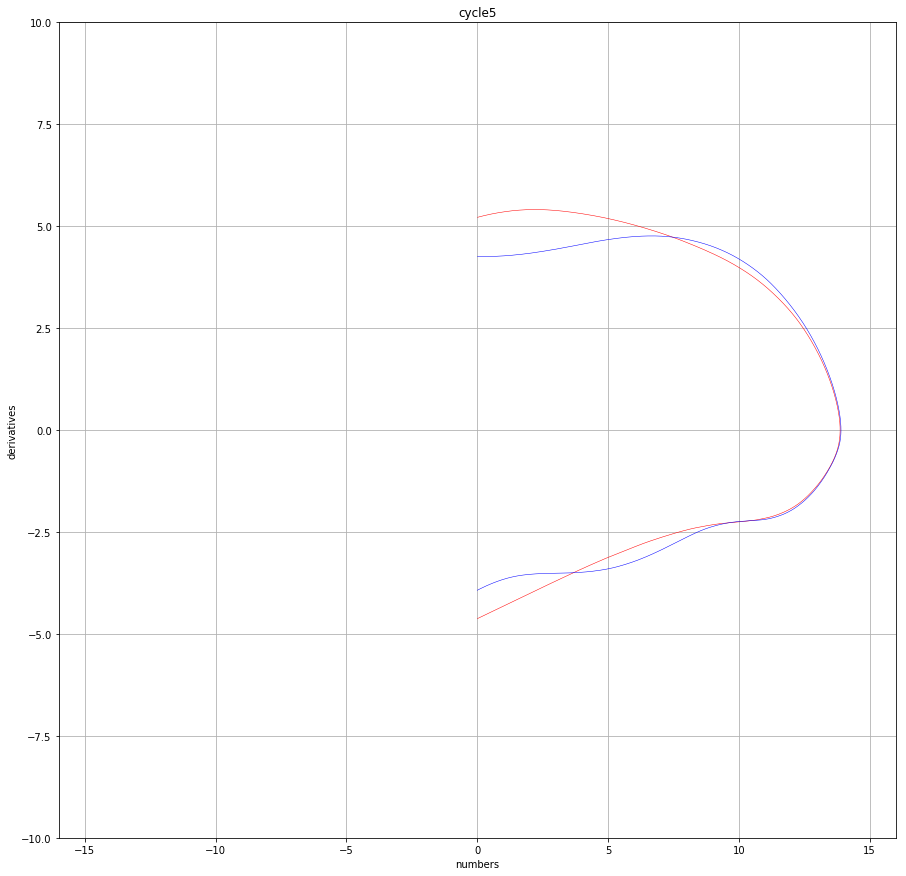

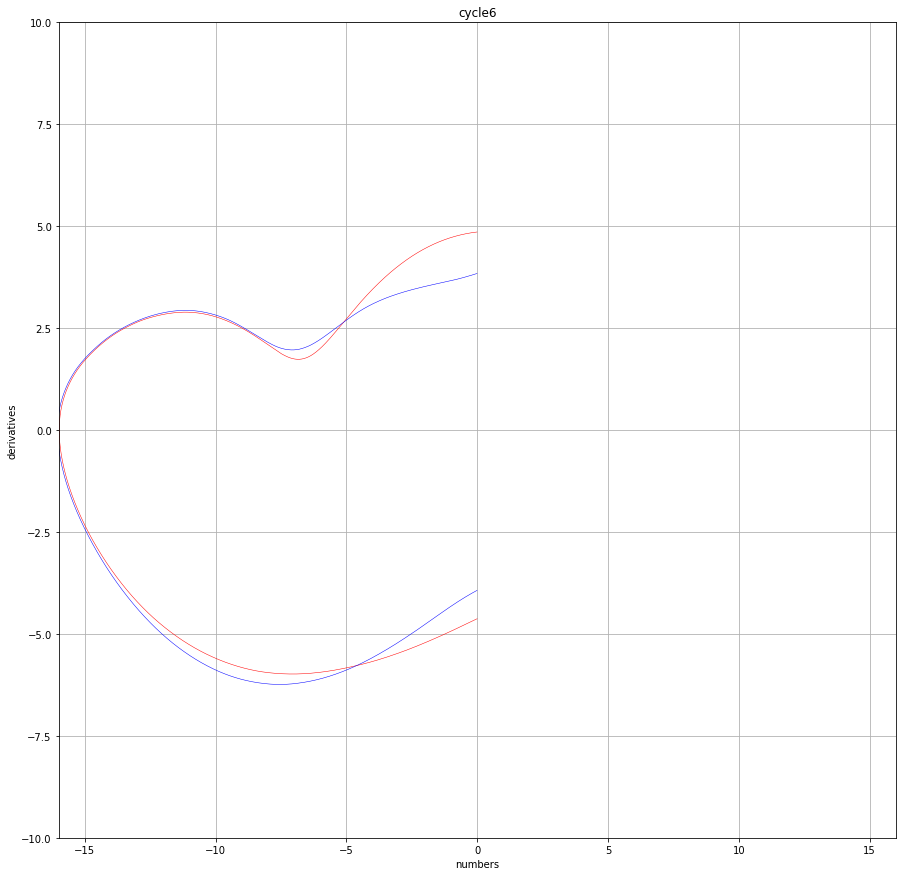

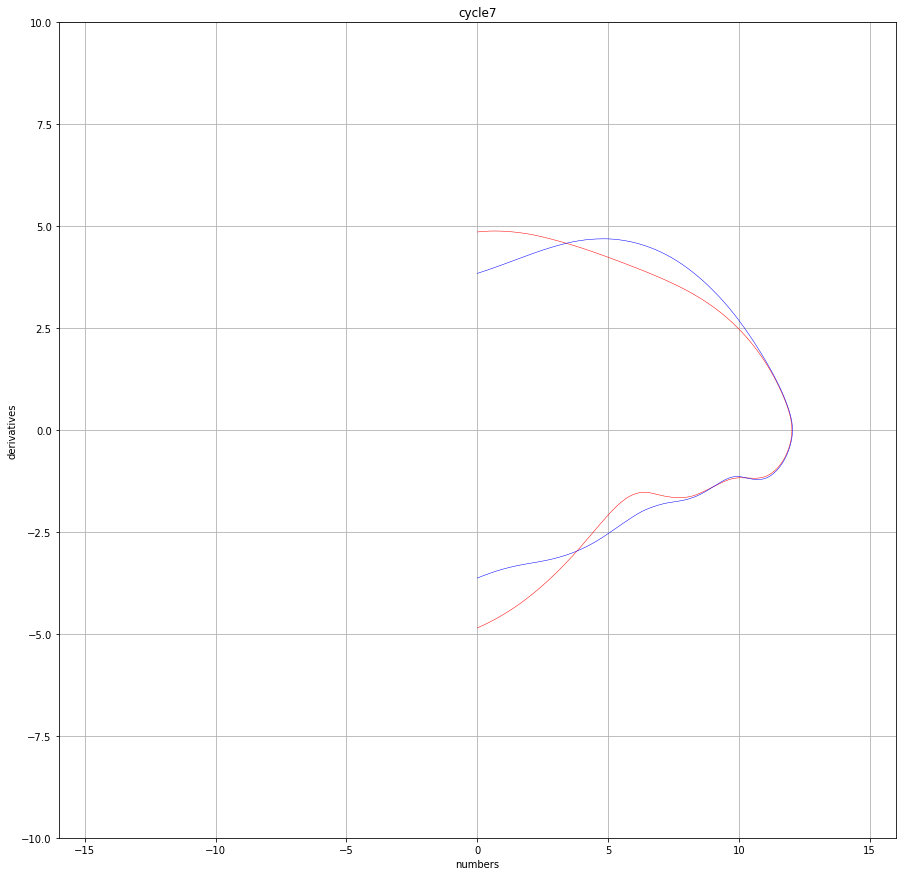

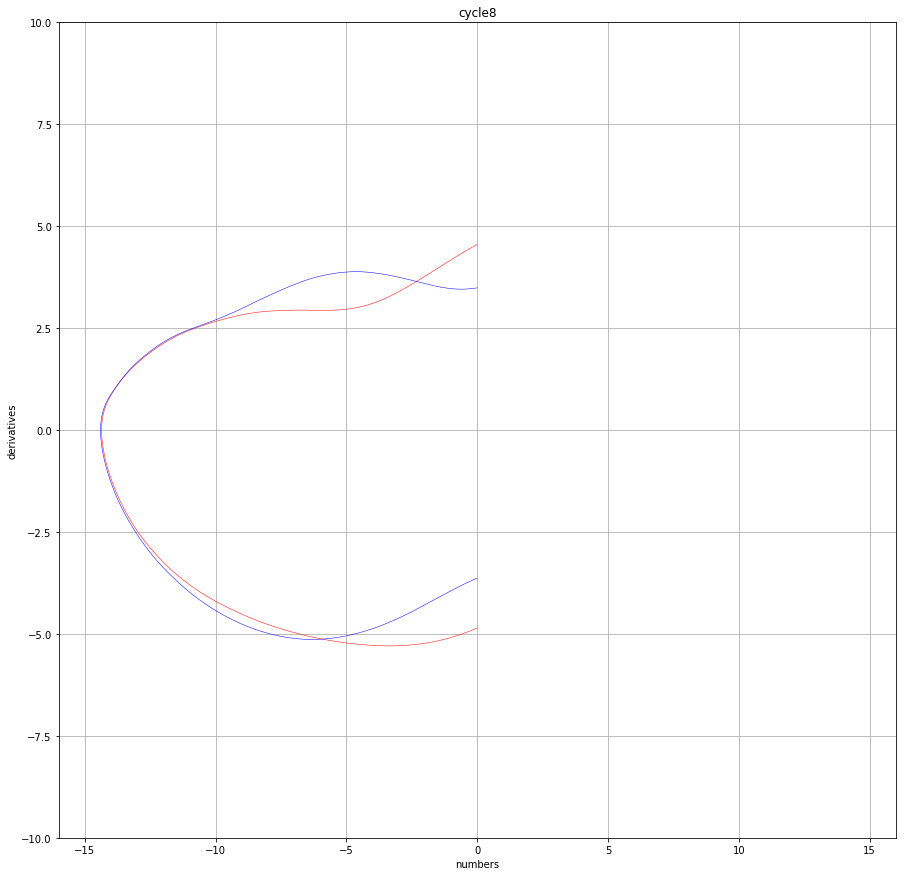

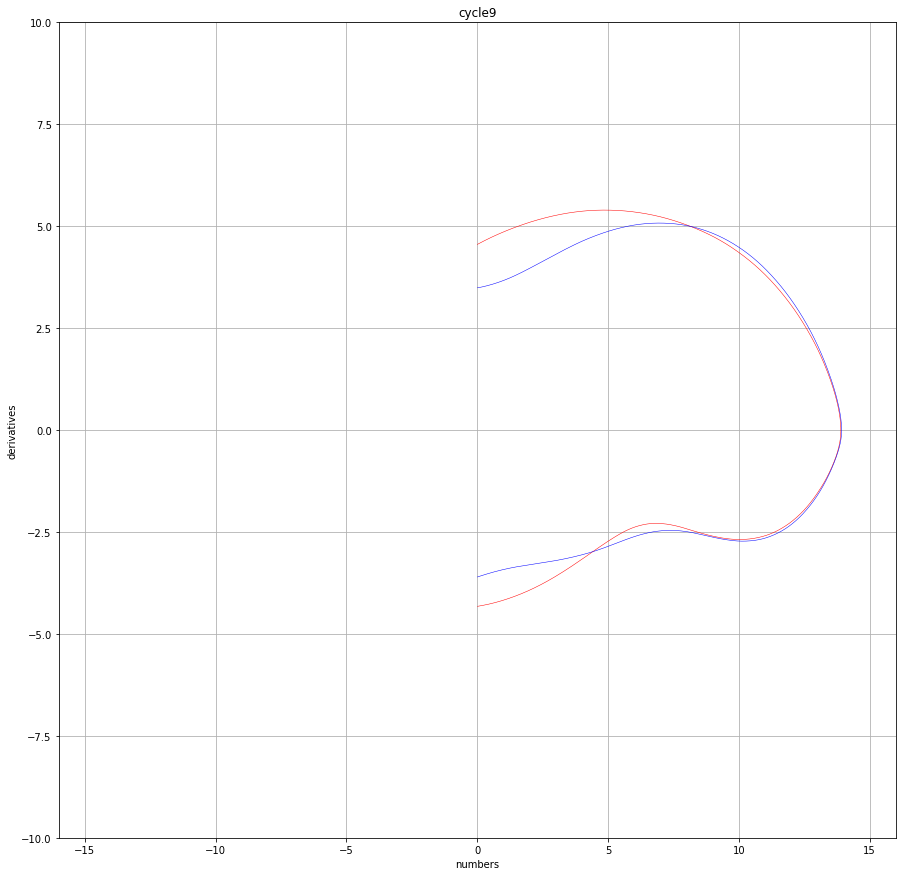

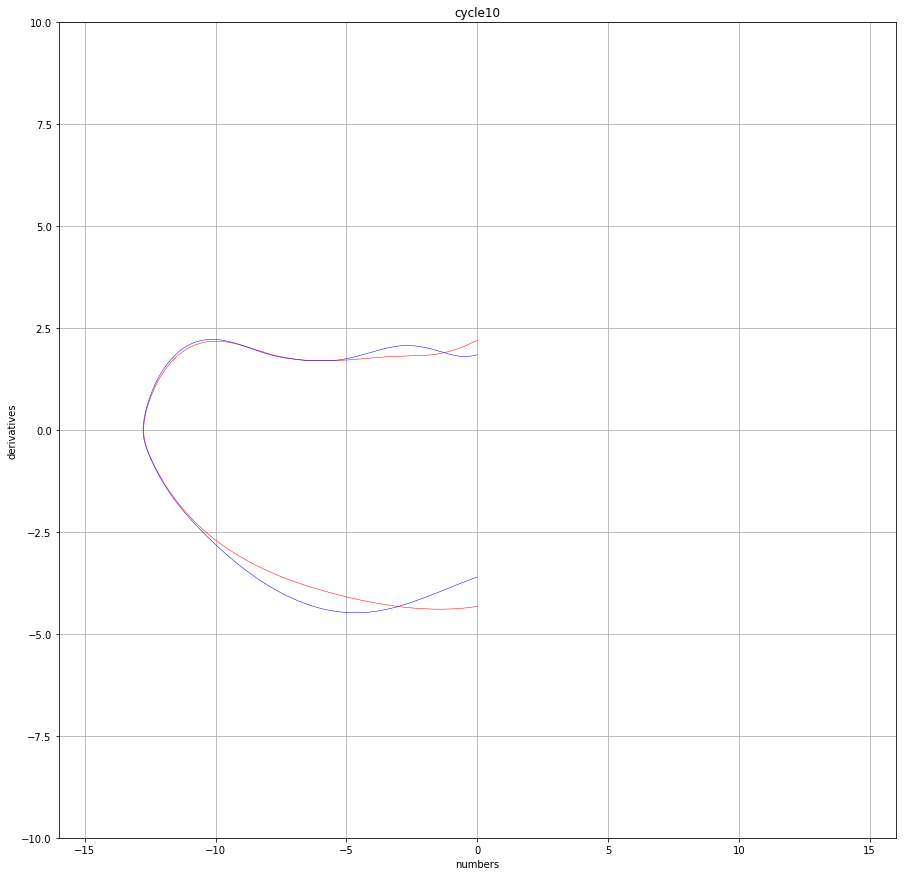

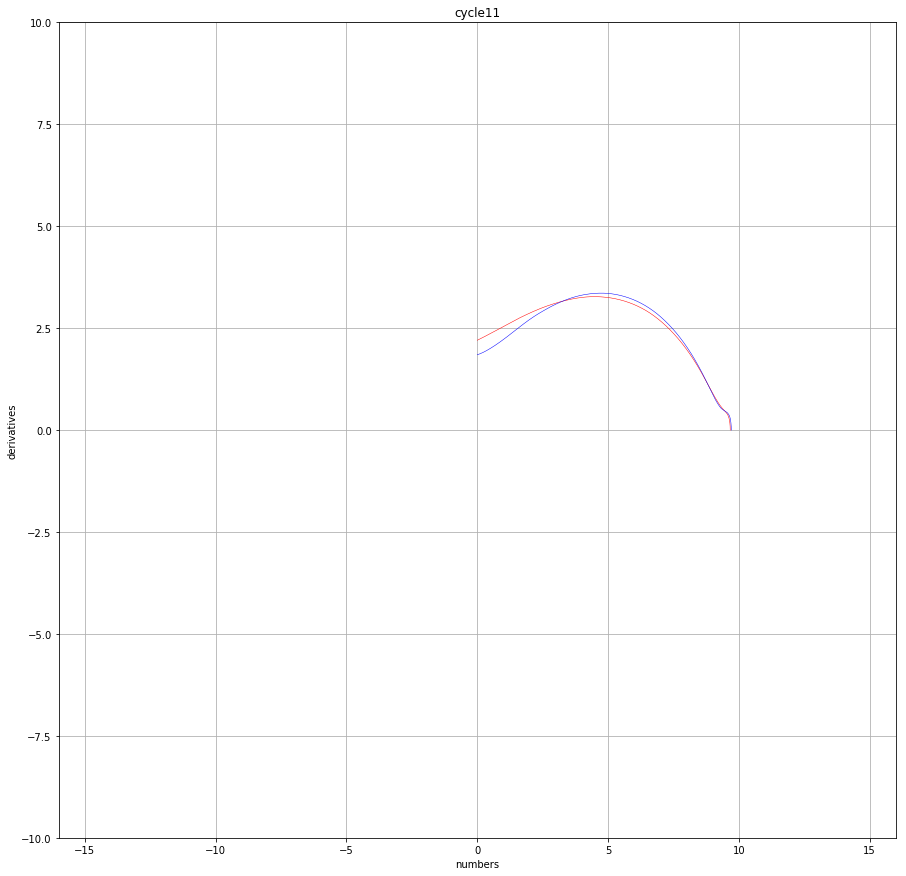

In [62]:
print('красный - без вероятности \n синий - с вероятностью\n')
for i in range(0, len(cycles)):
    add_graph_parametrs(lower_border=-10, upper_border = 10,
                        left_border = -16, right_border = 16)
    plt.title(u'cycle' + str(i + 1))
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    draw_cycles(portraits, i)
    draw_cycles(portraits_2, i, col='b')

## Приближение новых данных с функцией ошибки равной усредненному расстоянию

mistake = 0.5722157280760941
lamda = 0.0001
mu = 0.11
eps = 0.0443
omega = 0.2773


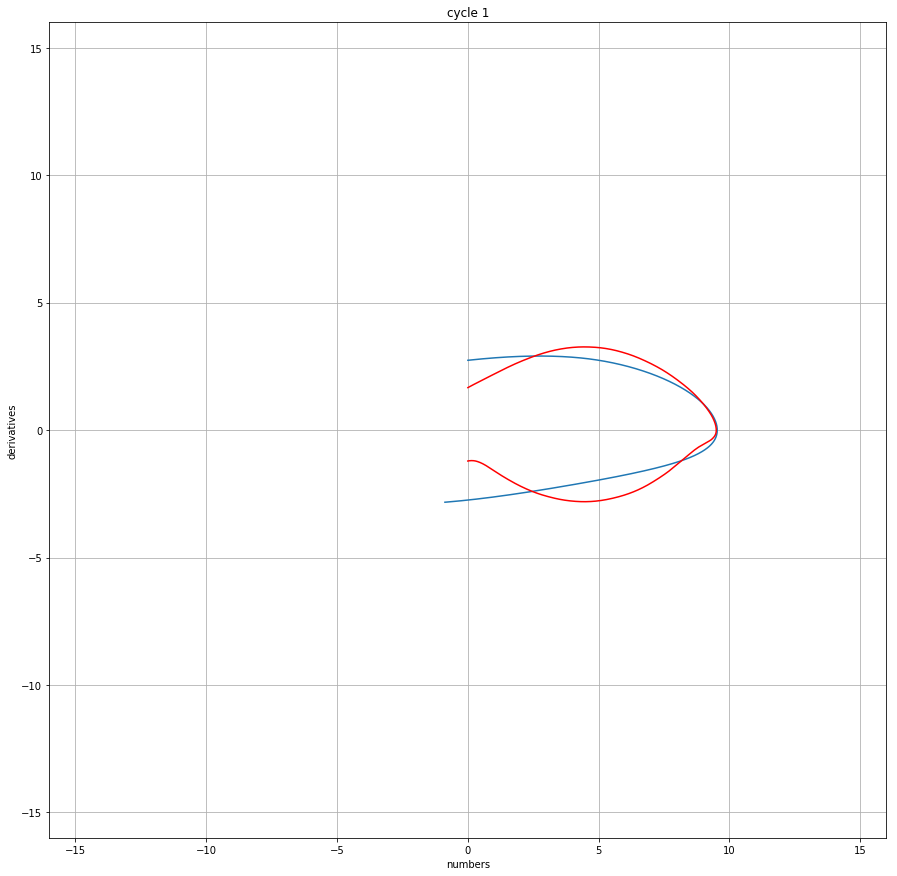

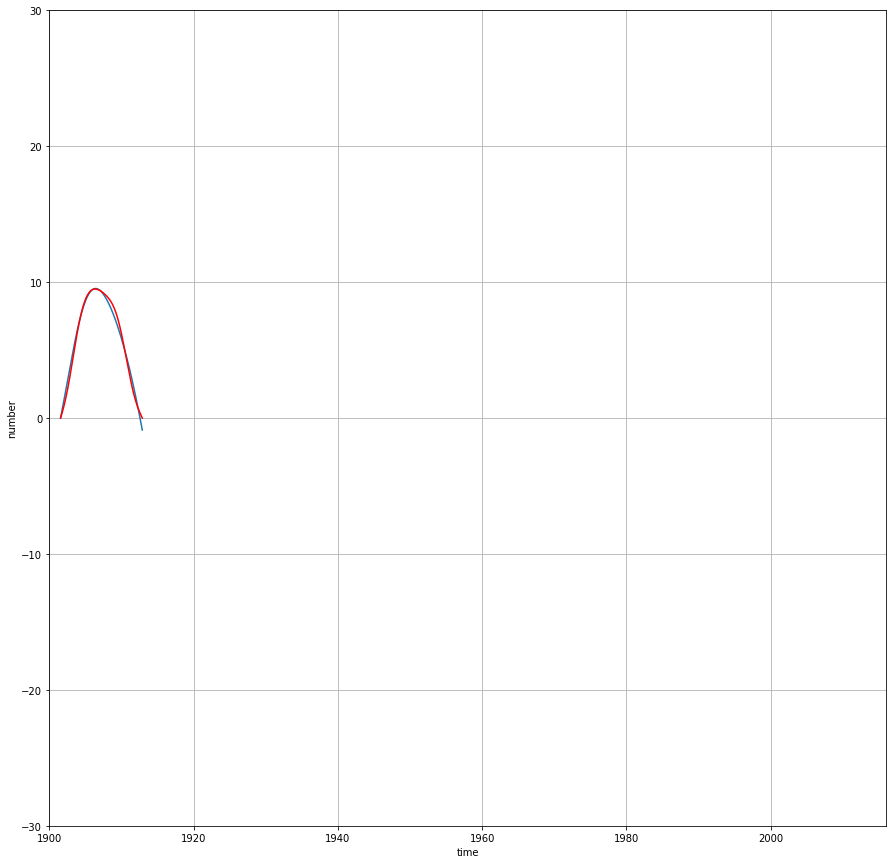

mistake = 0.7953841445681297
lamda = 0.0
mu = 0.011
eps = 0.0365
omega = 0.3004


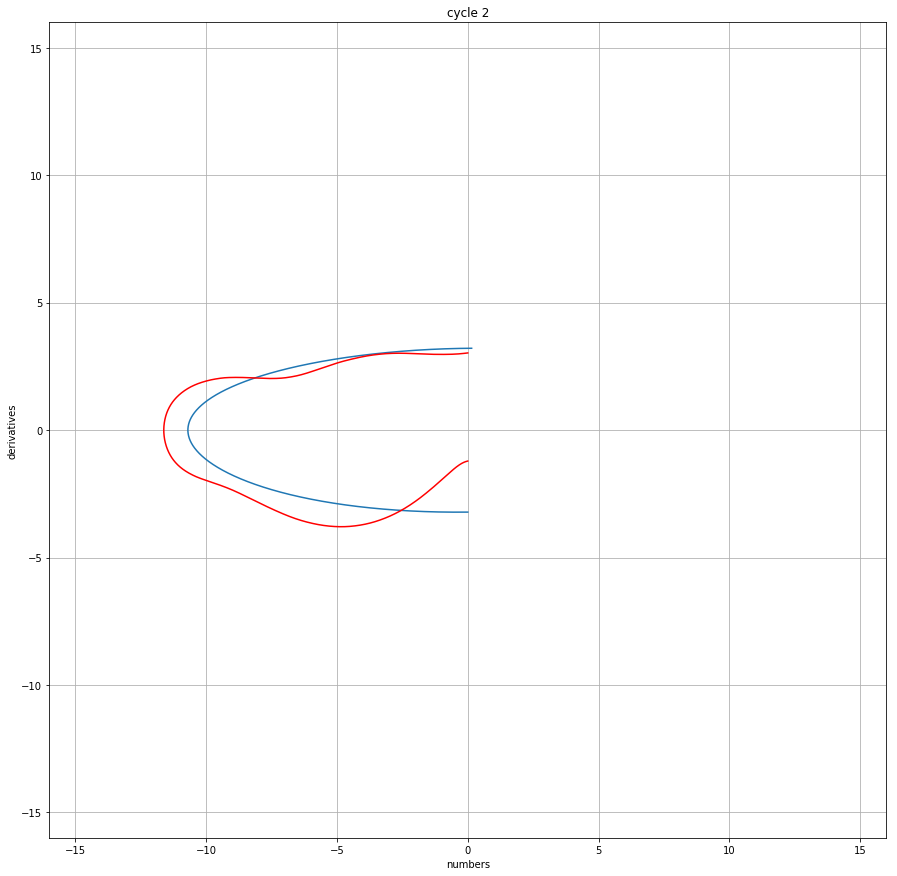

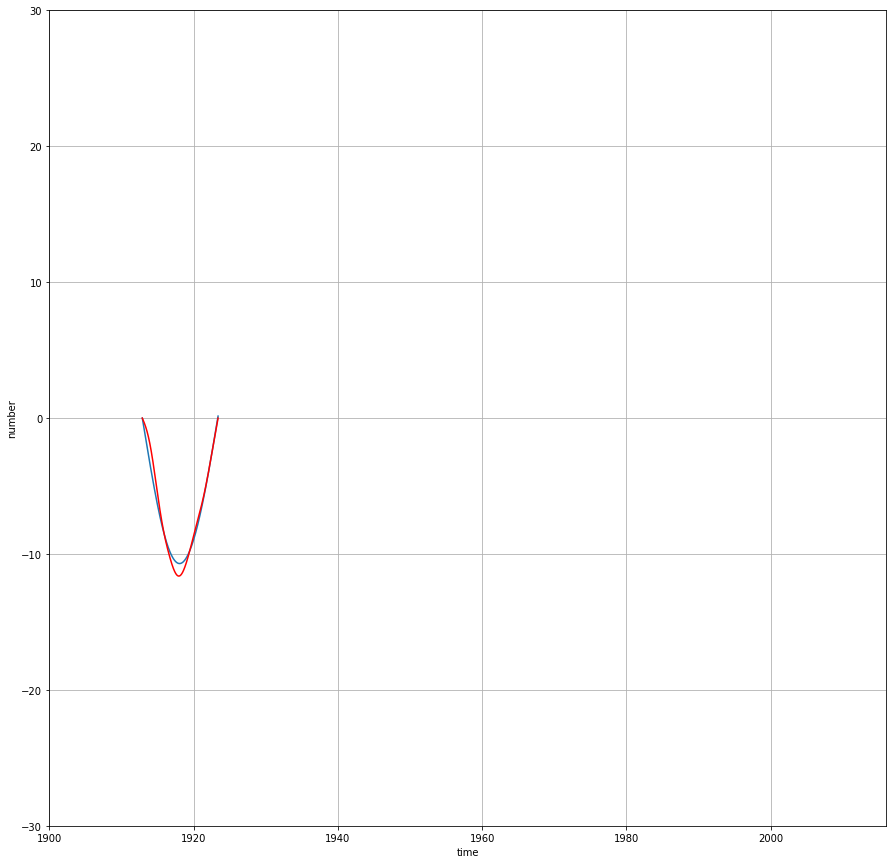

mistake = 0.3287541626077412
lamda = 0.0002
mu = 0.1638
eps = 0.035
omega = 0.2876


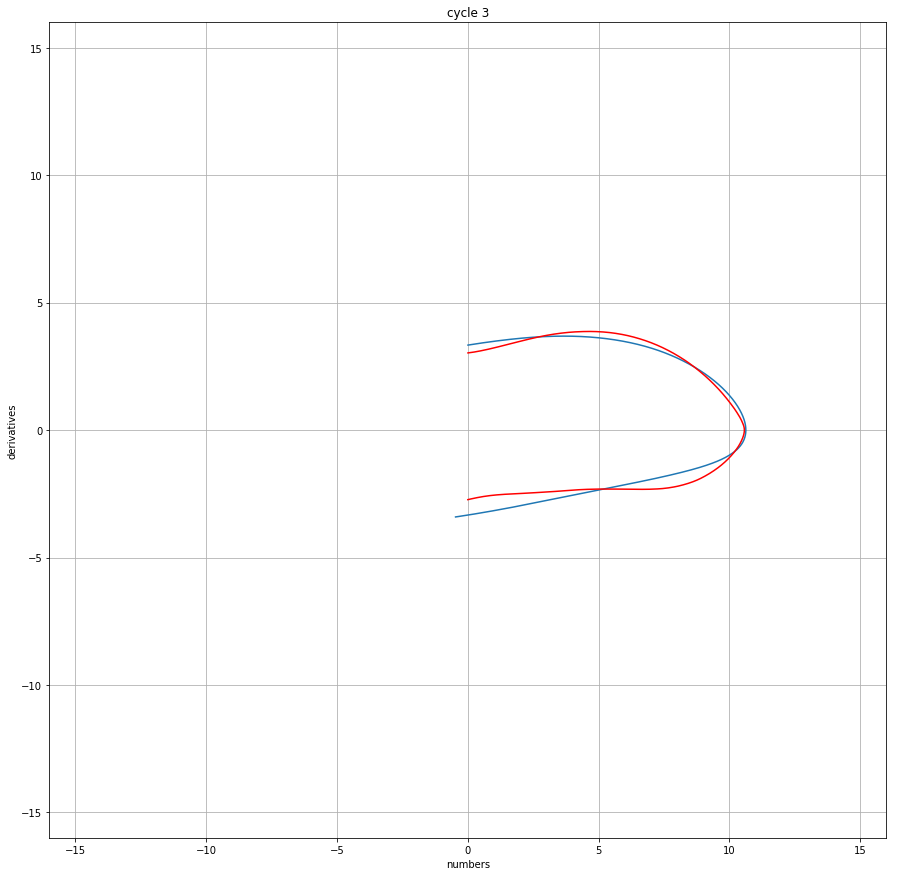

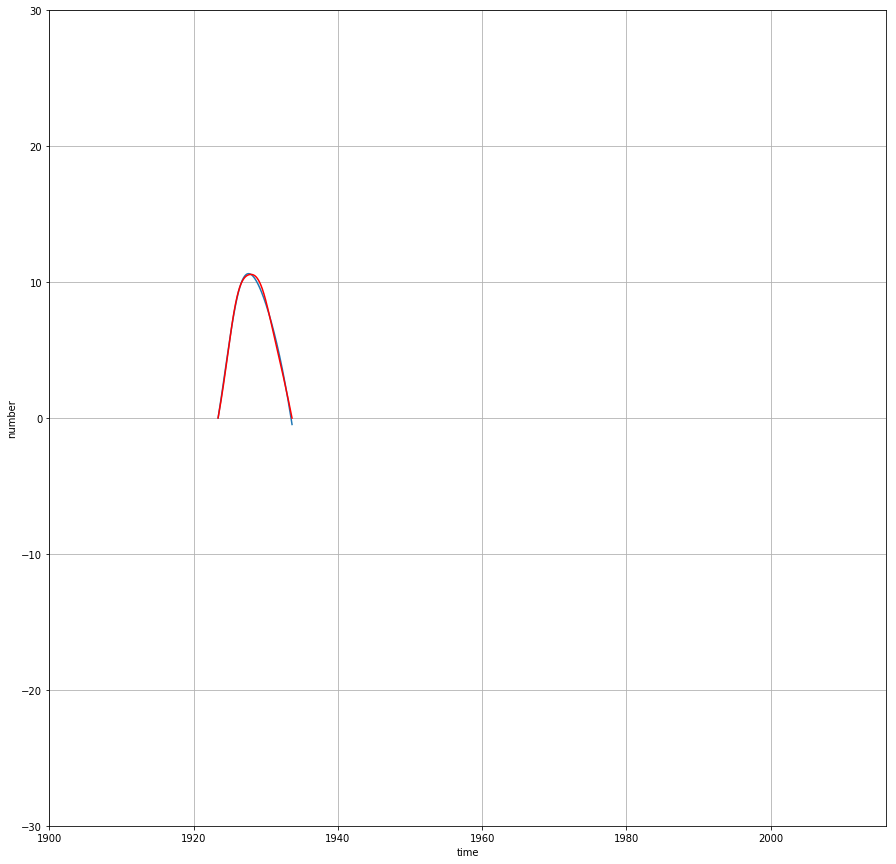

mistake = 0.5489756517725128
lamda = 0.0
mu = 0.1193
eps = 0.024
omega = 0.3034


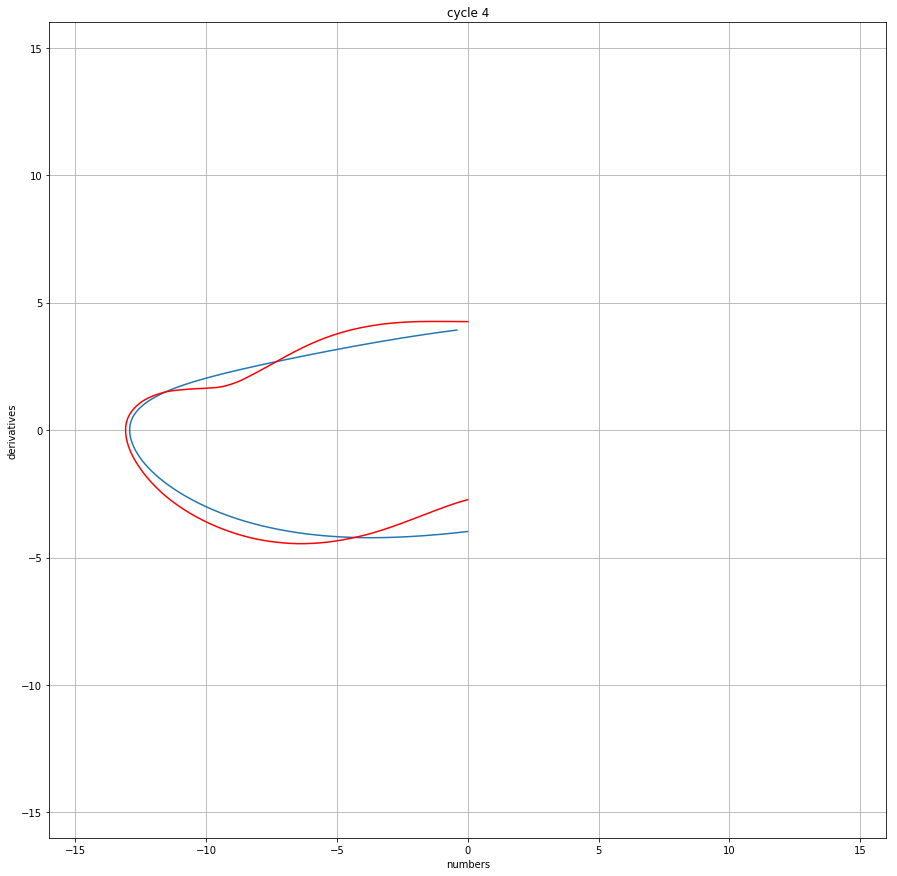

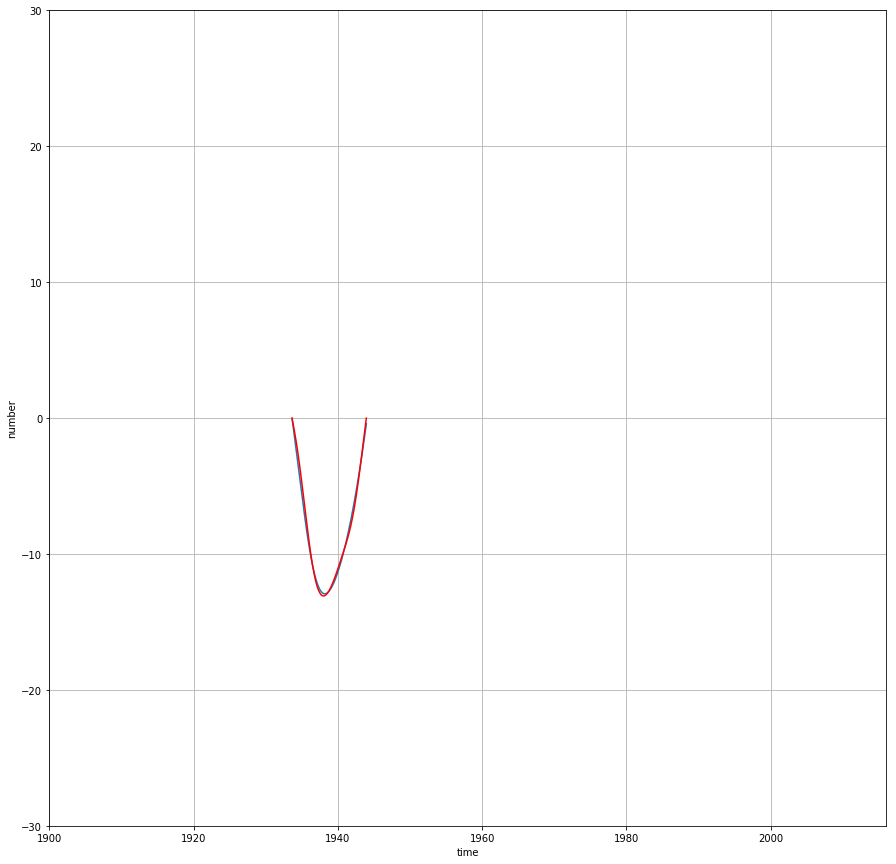

mistake = 0.2851713095462703
lamda = 0.0
mu = 0.1599
eps = 0.0216
omega = 0.3165


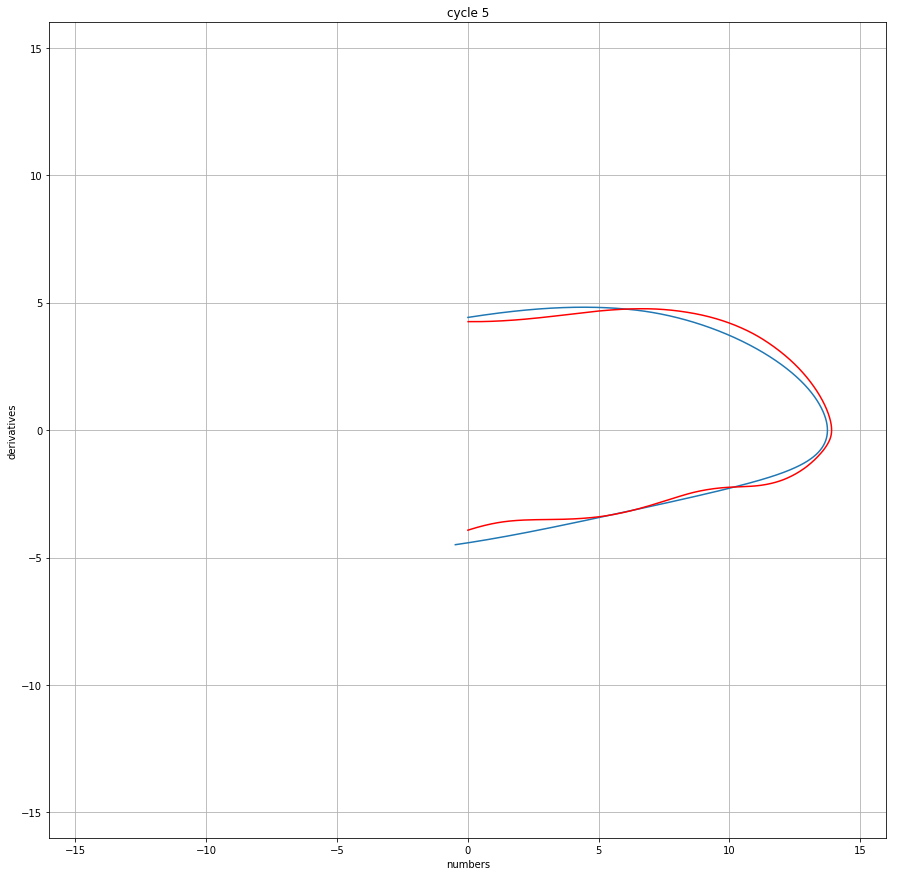

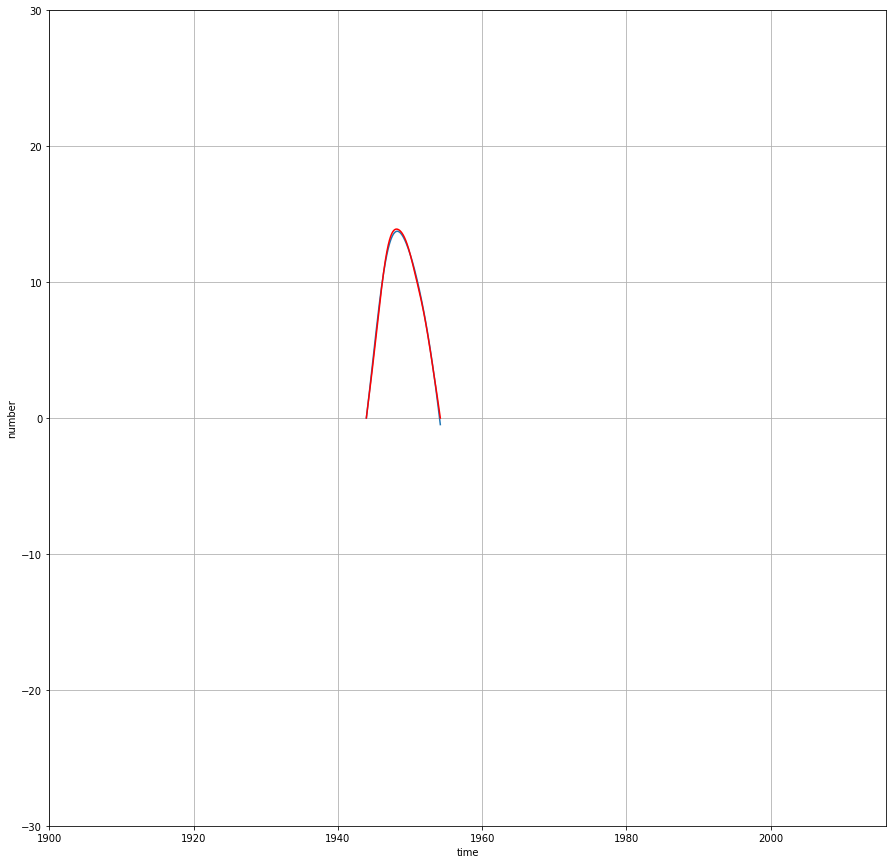

mistake = 0.951312326533301
lamda = 0.0001
mu = 0.23
eps = 0.0165
omega = 0.2844


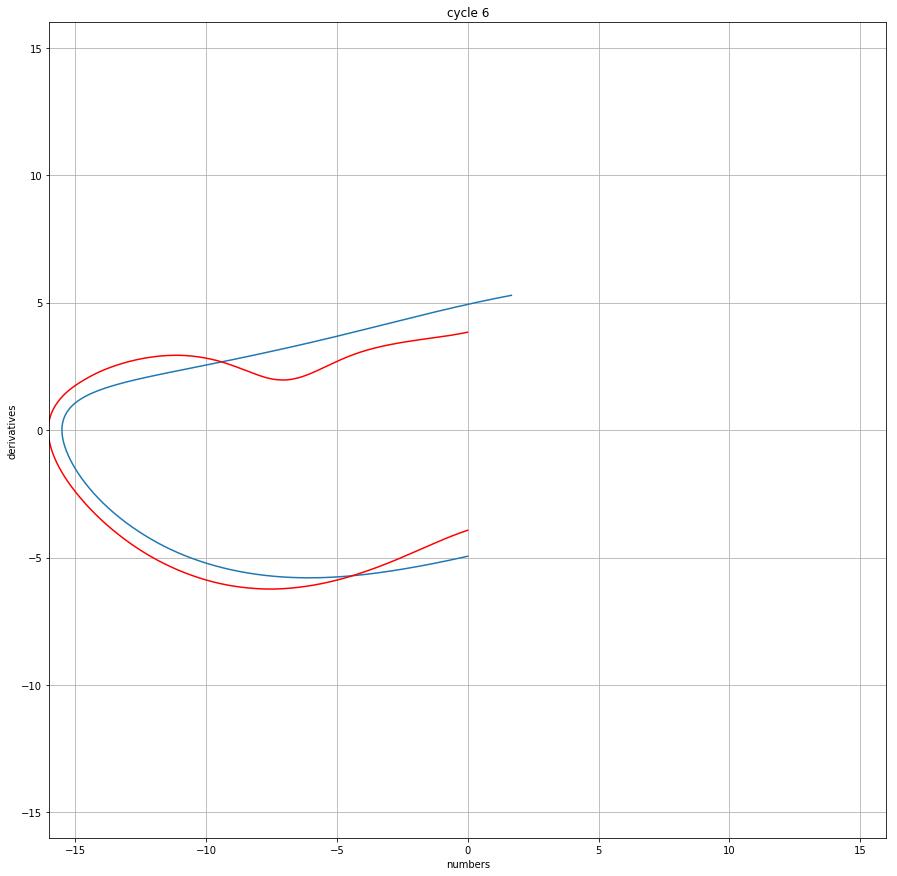

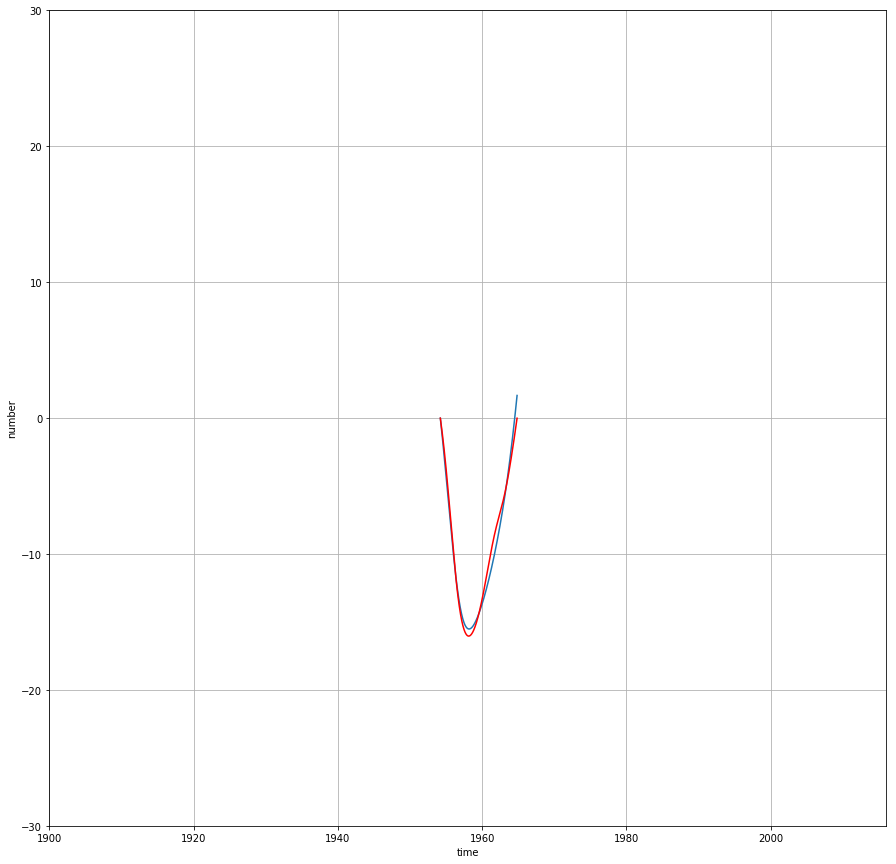

mistake = 0.24819987199786753
lamda = 0.0001
mu = 0.3099
eps = 0.0276
omega = 0.2767


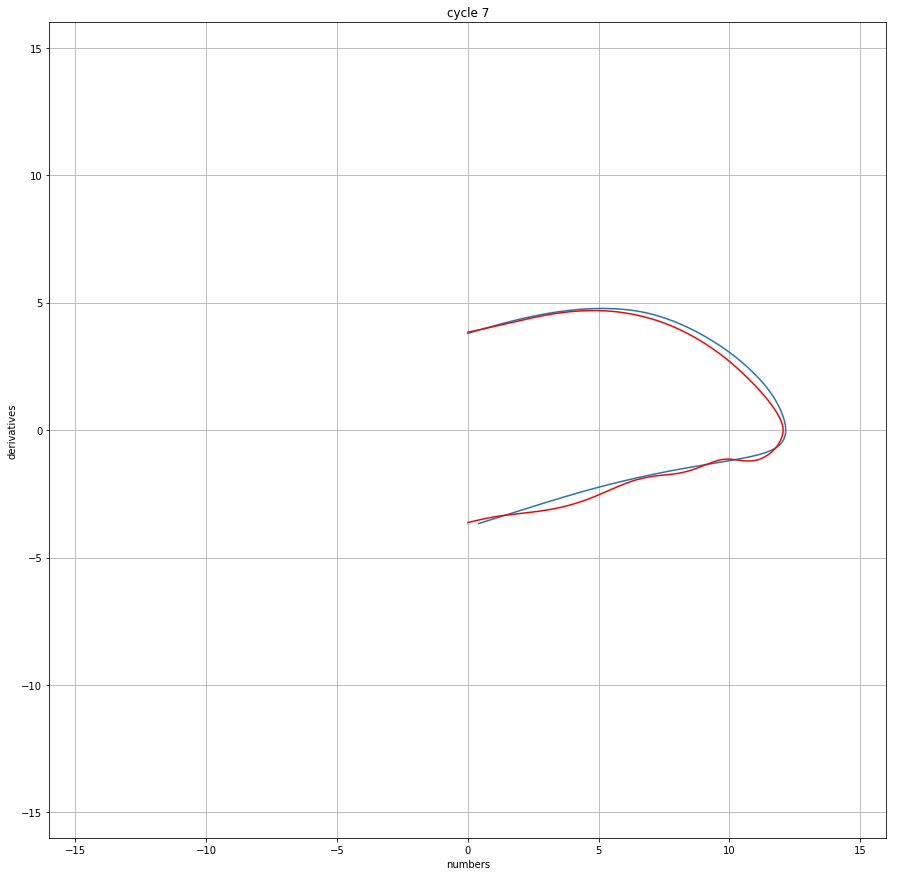

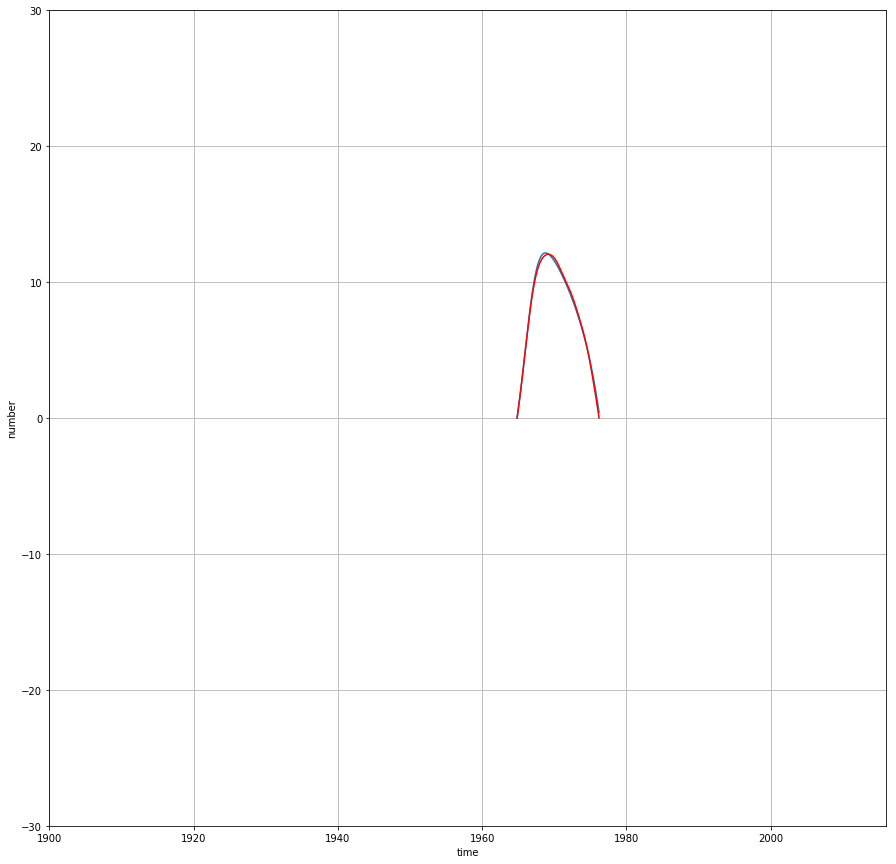

mistake = 0.3313547377314773
lamda = 0.0
mu = 0.1202
eps = 0.0196
omega = 0.3213


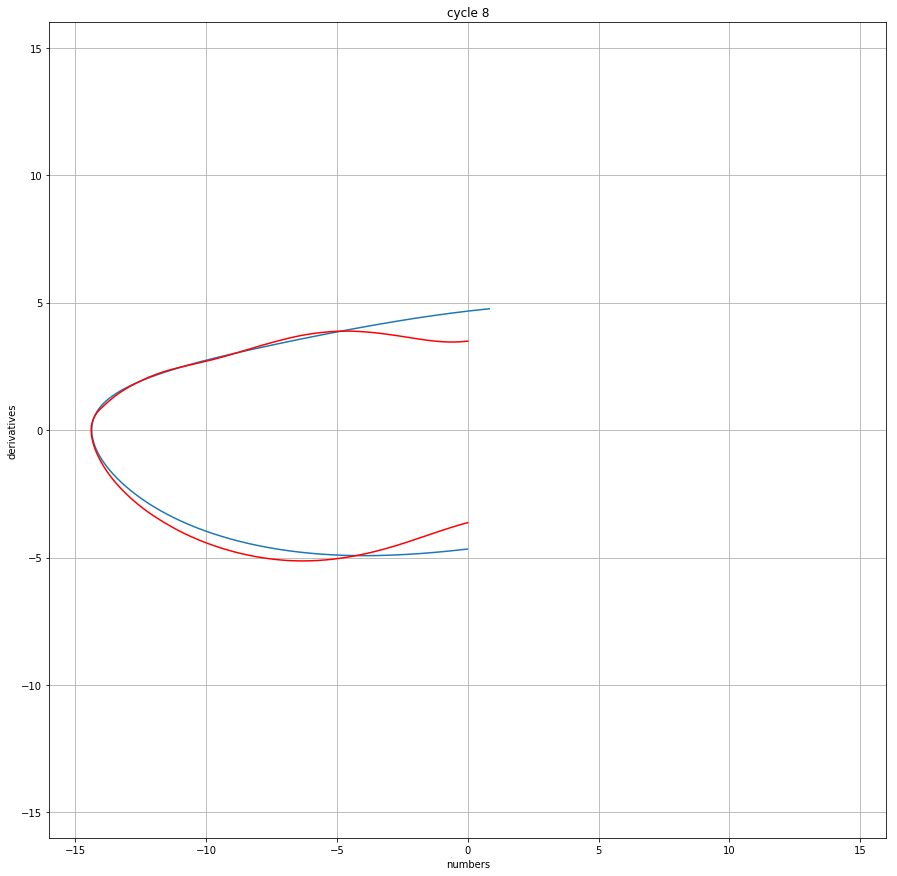

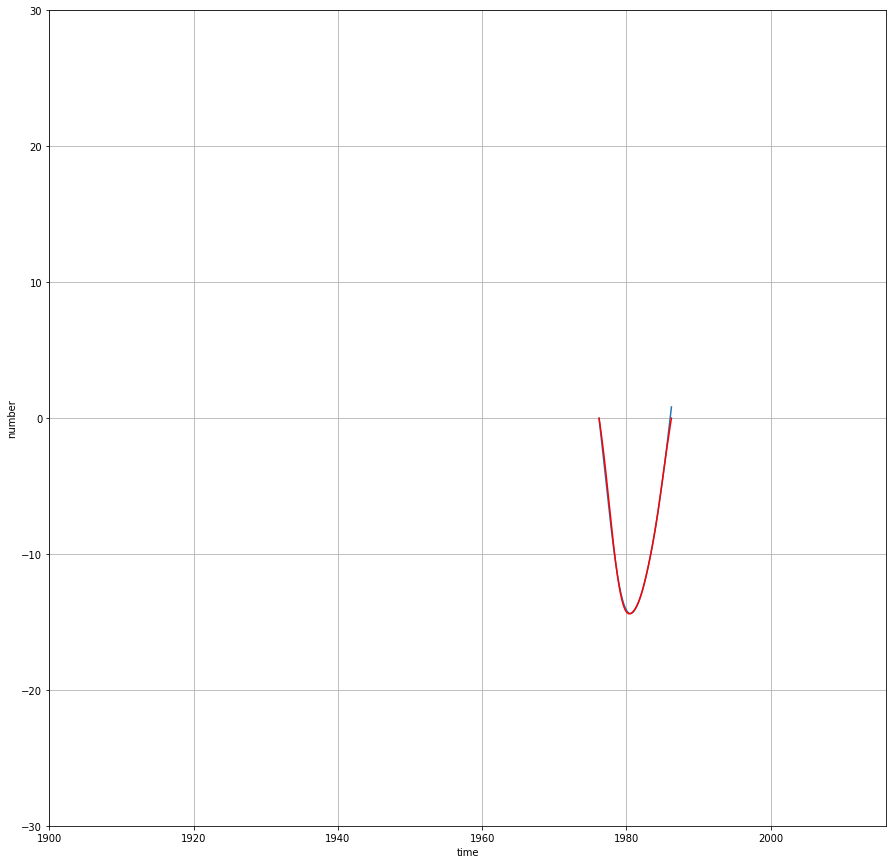

mistake = 0.6603641392030238
lamda = 0.0001
mu = 0.1202
eps = 0.0208
omega = 0.2955


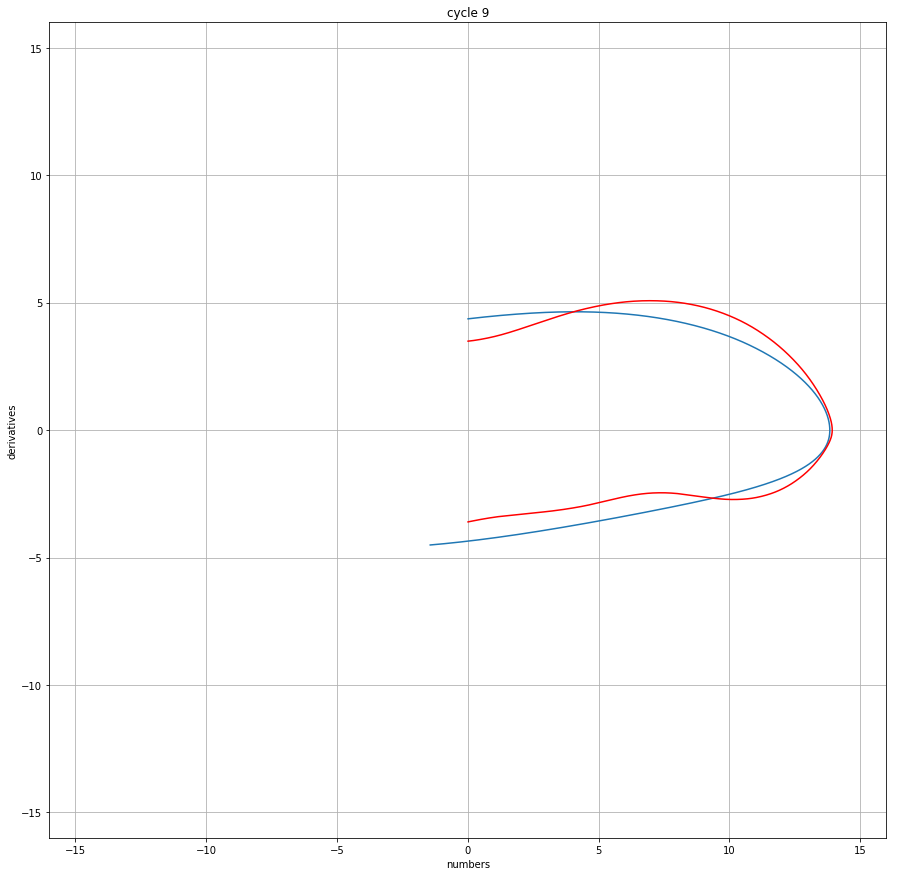

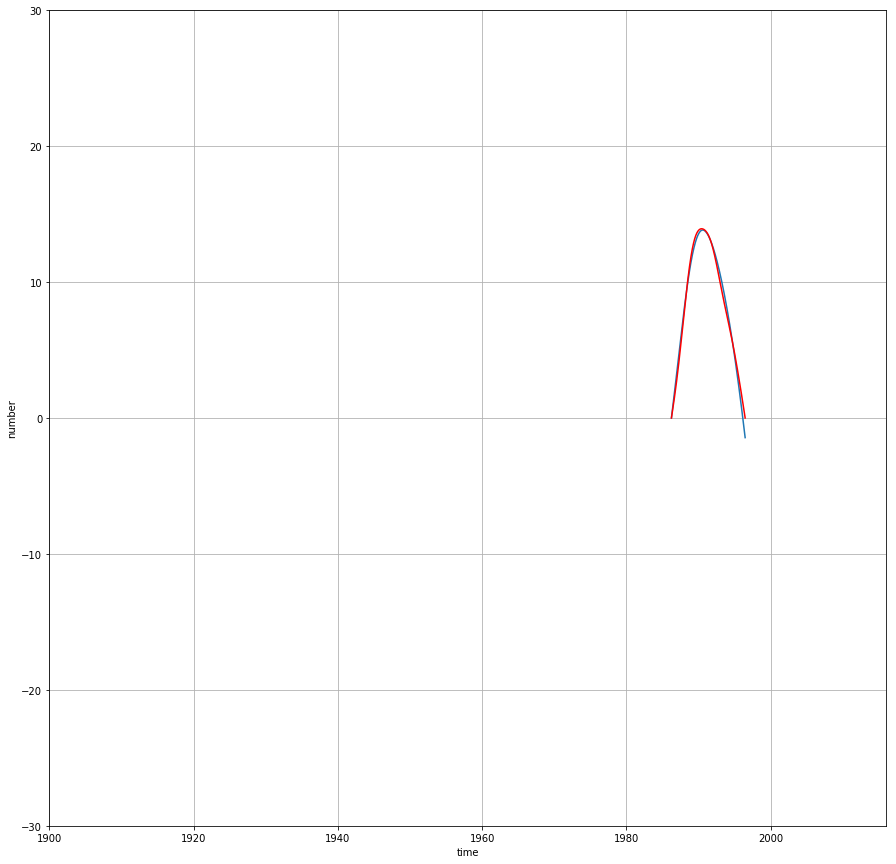

mistake = 0.7109670307817074
lamda = 0.0001
mu = 0.212
eps = 0.0253
omega = 0.2549


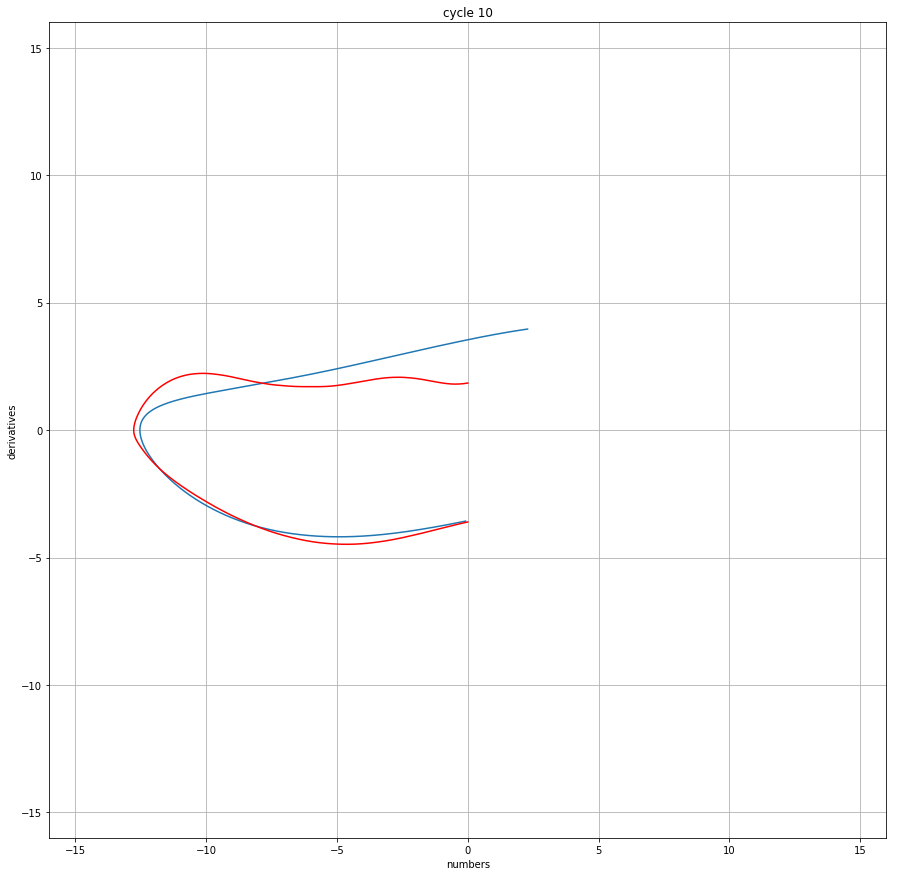

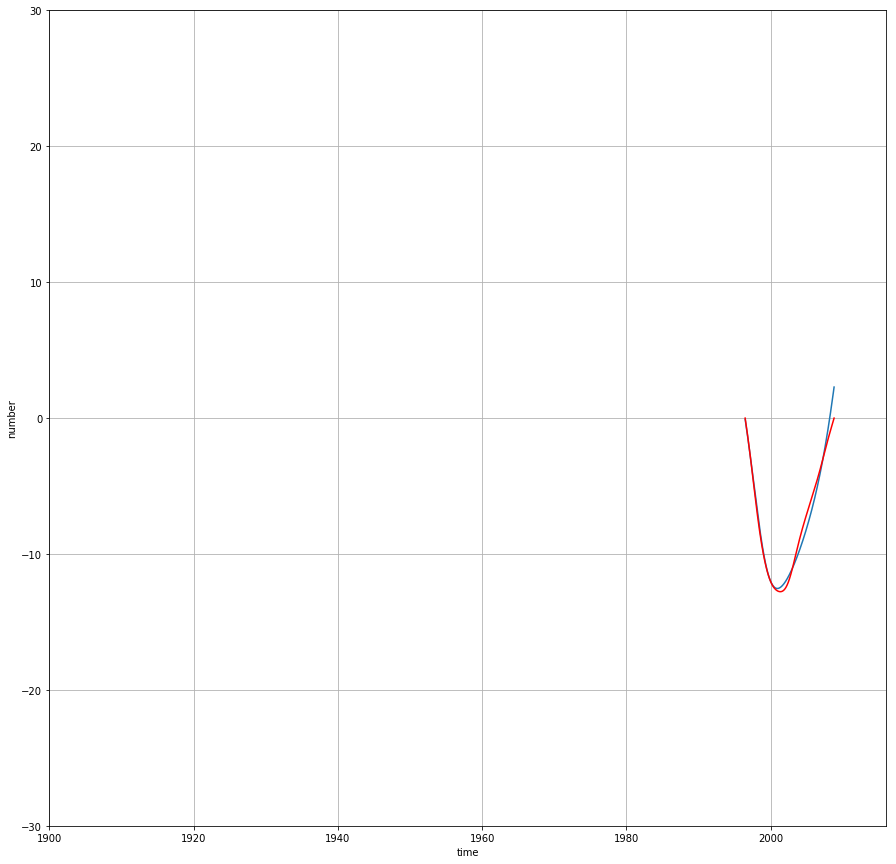

mistake = 0.1898944477509012
lamda = 0.0007
mu = 0.3709
eps = 0.0423
omega = 0.0107


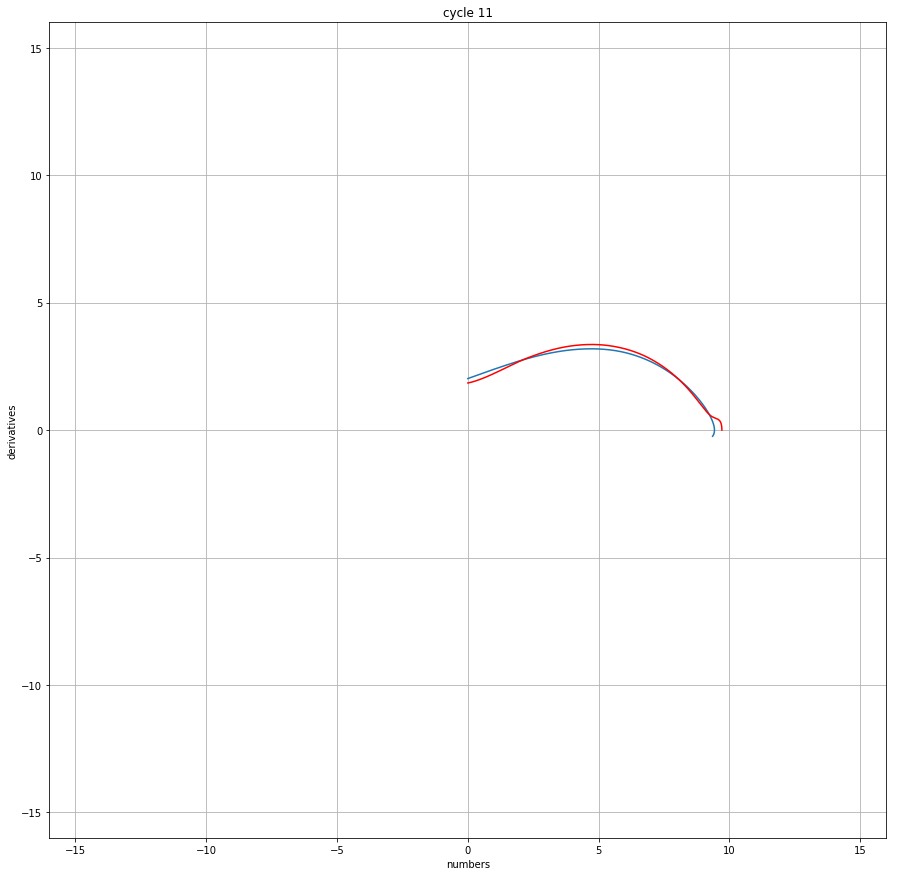

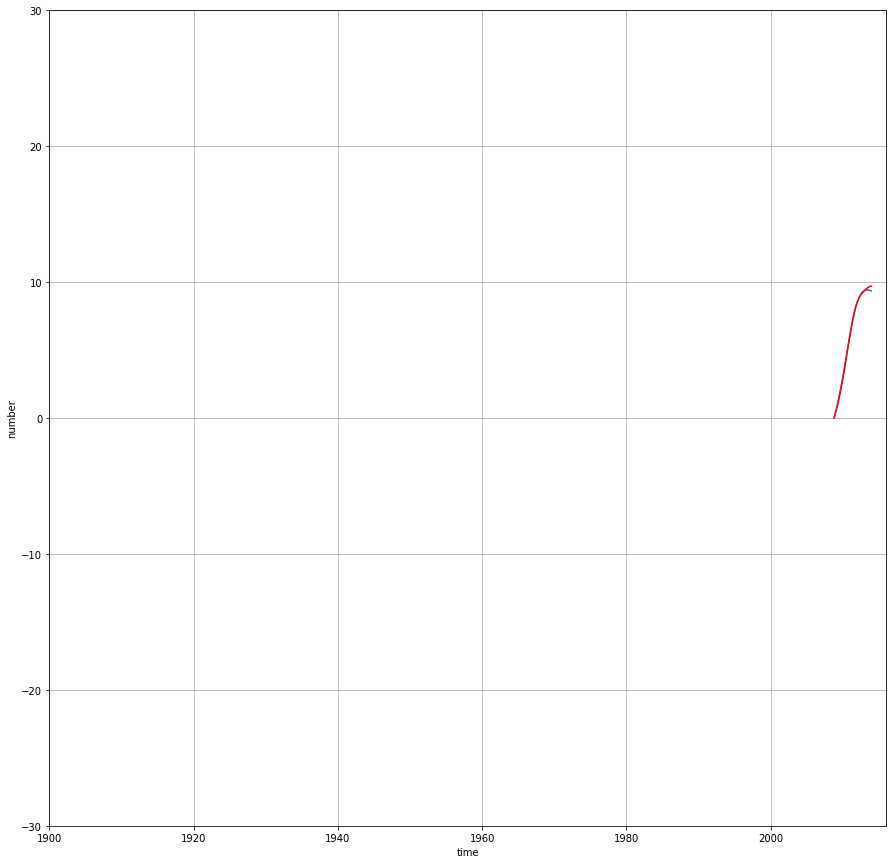

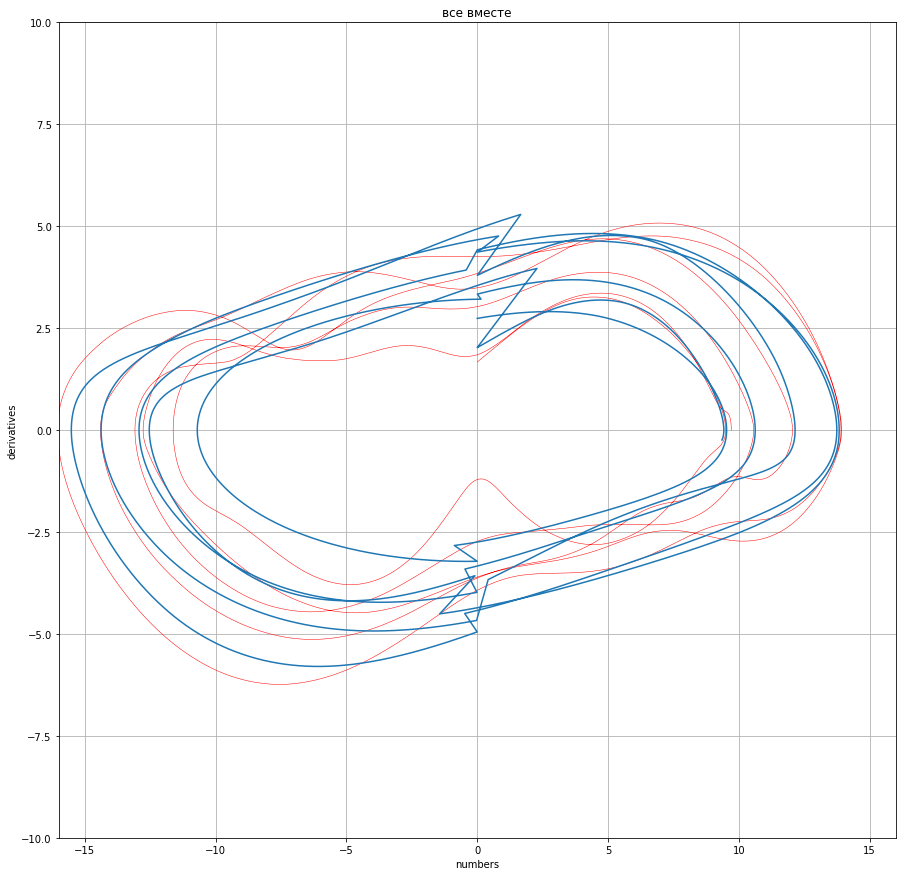

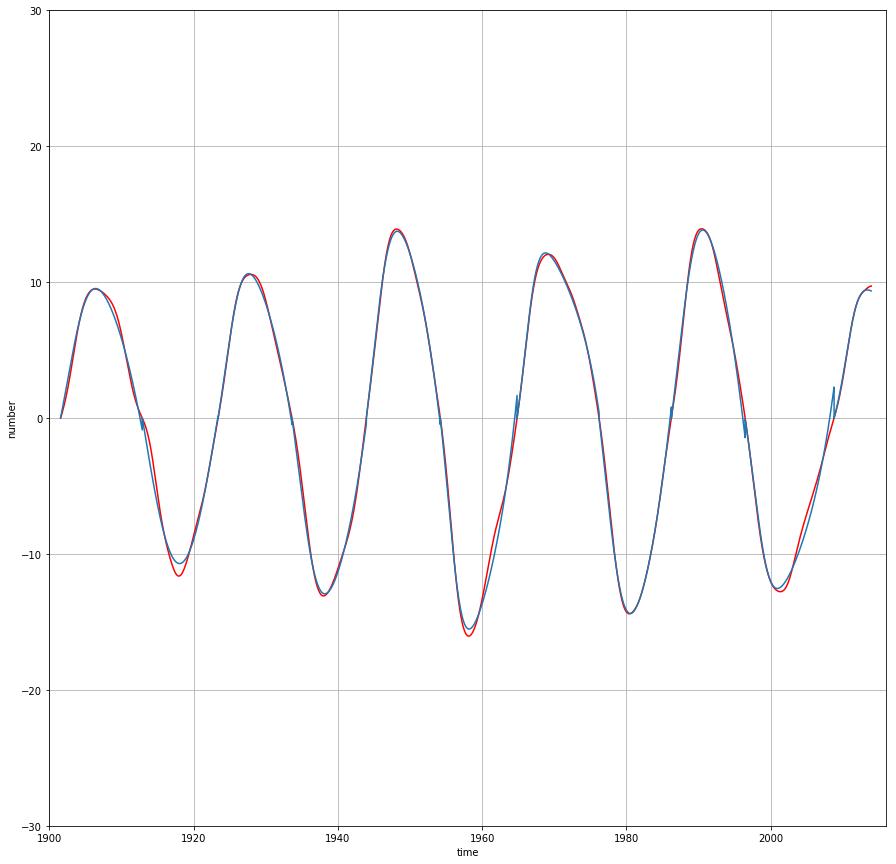

In [63]:
reg_approx_param_2 = cycles_approx(reg_difference, portraits_2, smoothed_data_2, cycles_2)

## Приближение новых данных с функцией ошибки равной интегралу разности квадратов

mistake = 1.193430093184036
lamda = 0.0001
mu = 0.0461
eps = 0.0422
omega = 0.2755


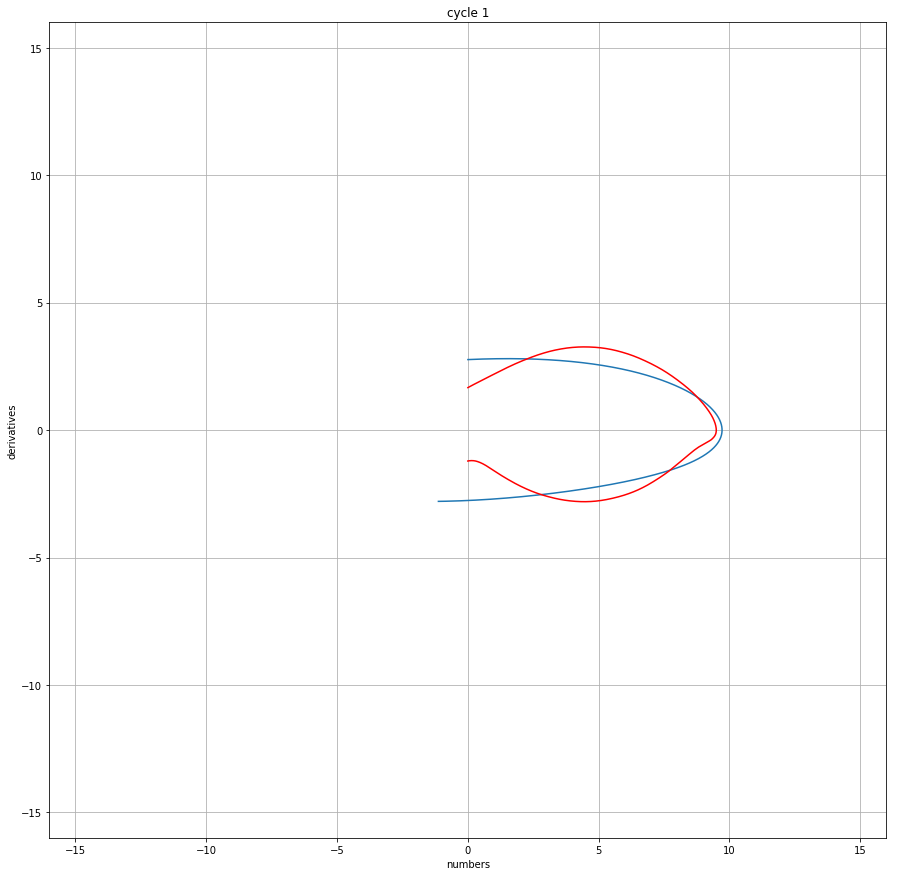

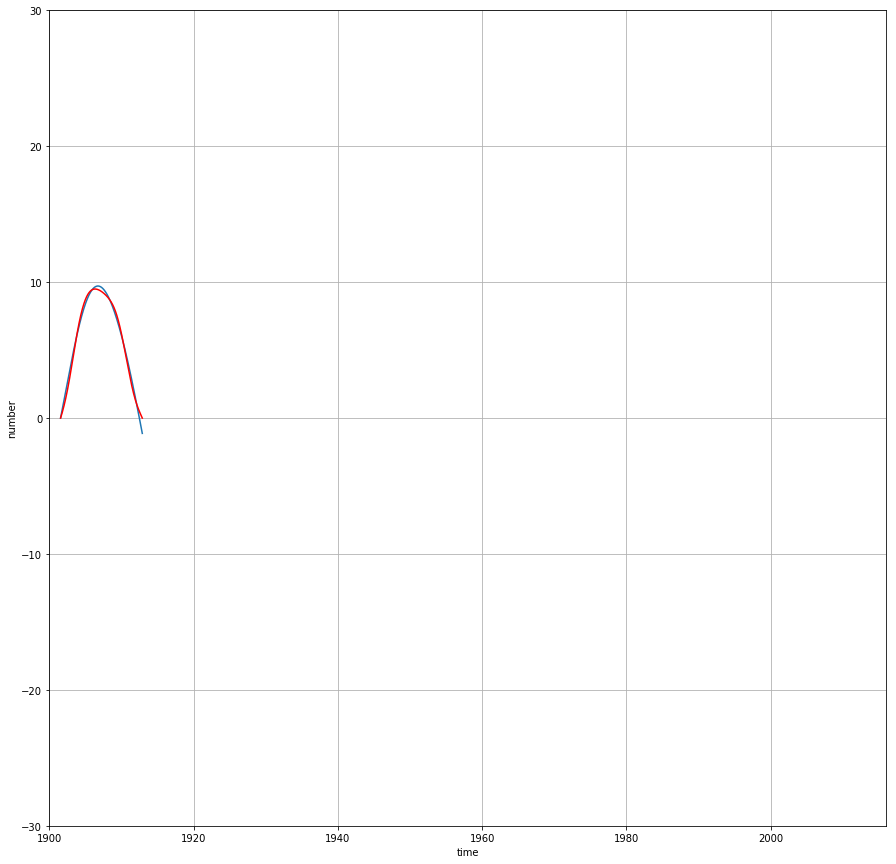

mistake = 4.389590893010636
lamda = 0.0
mu = 0.01
eps = 0.0355
omega = 0.3013


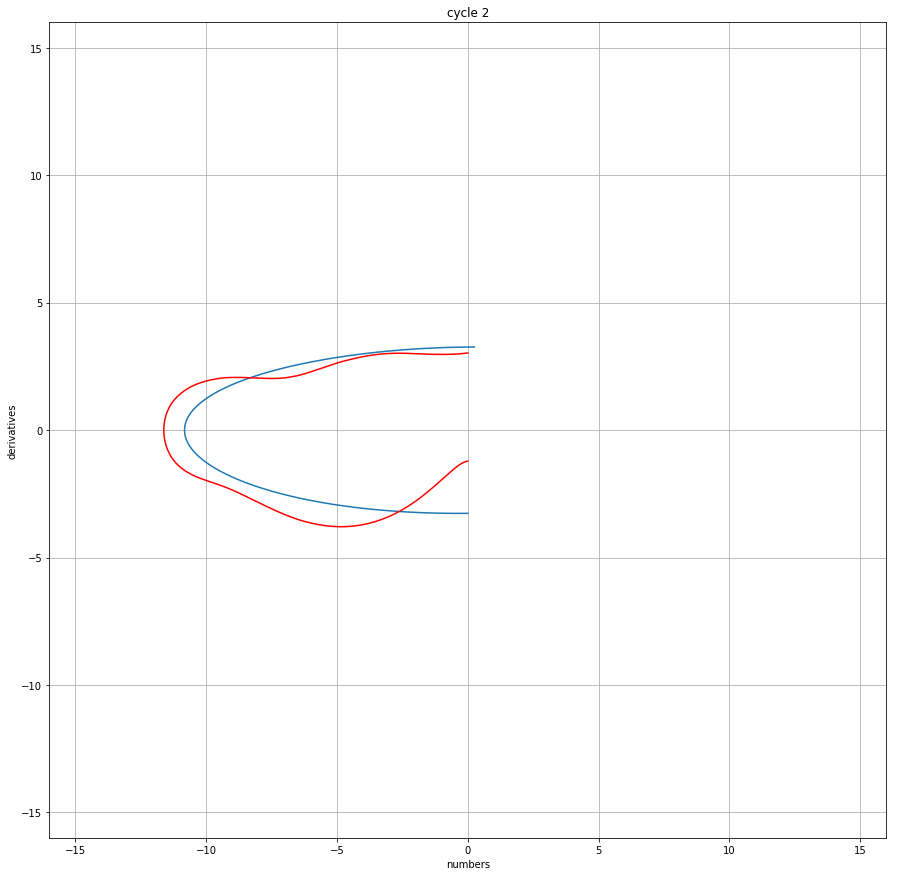

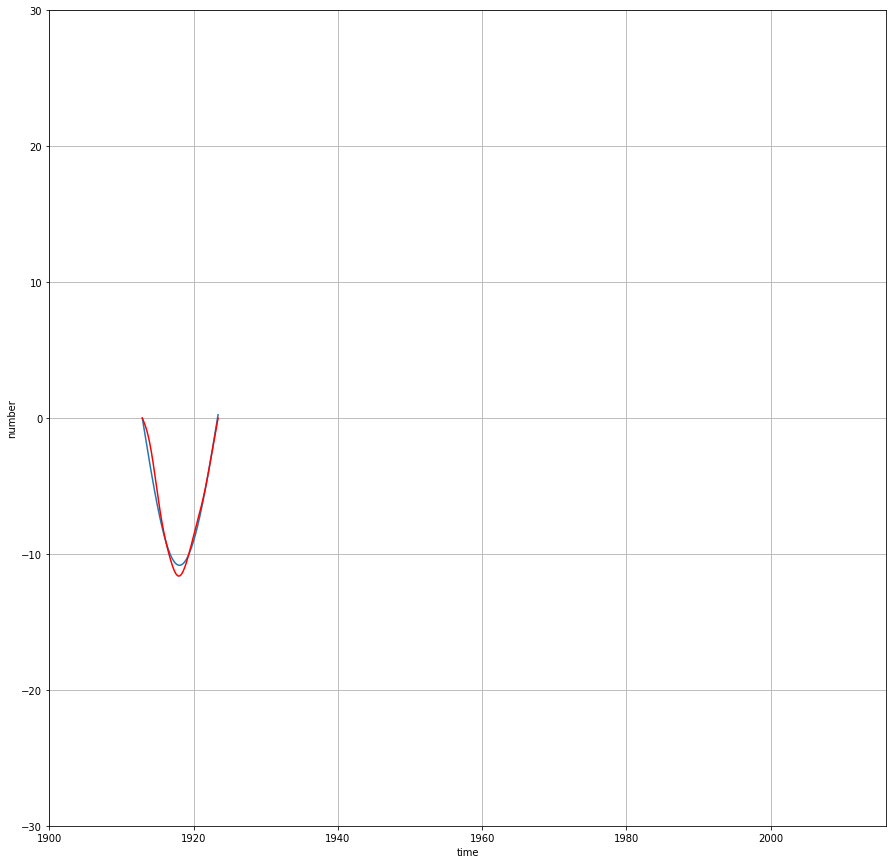

mistake = 0.8410107707328242
lamda = 0.0001
mu = 0.201
eps = 0.0358
omega = 0.3076


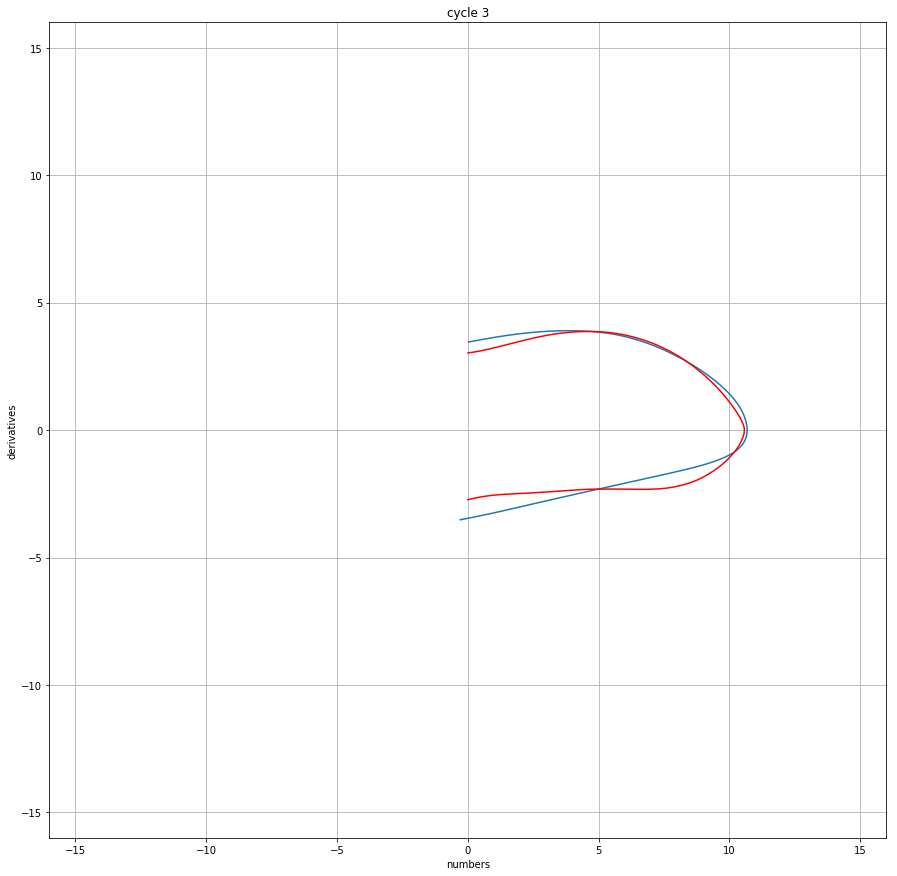

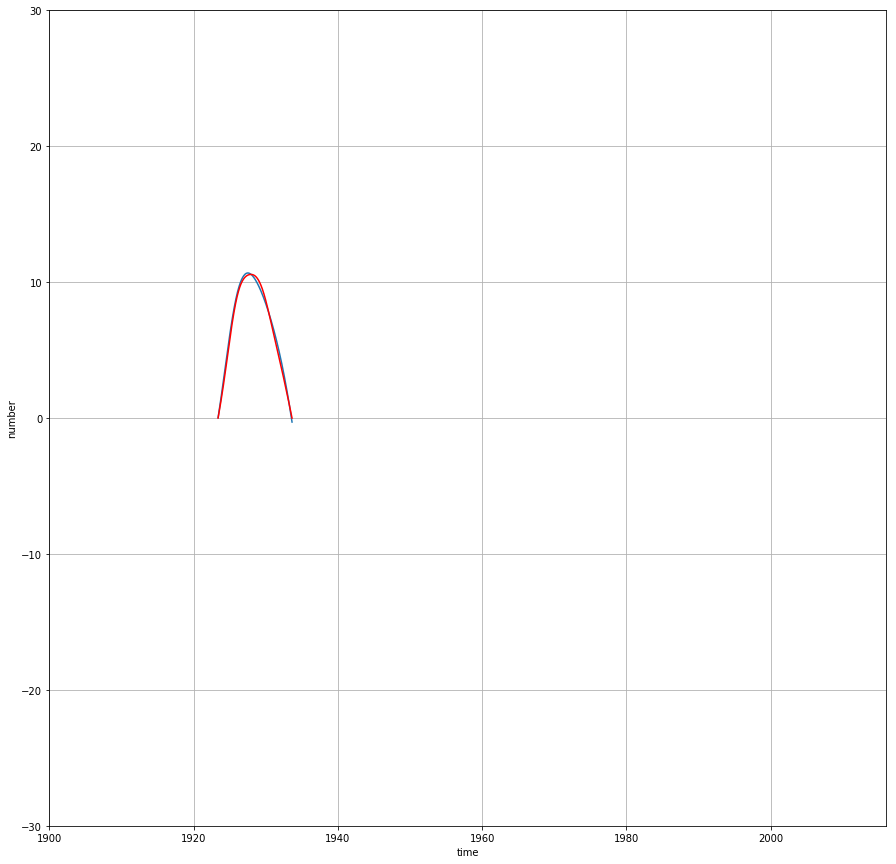

mistake = 1.405561625367325
lamda = 0.0
mu = 0.0909
eps = 0.0243
omega = 0.3033


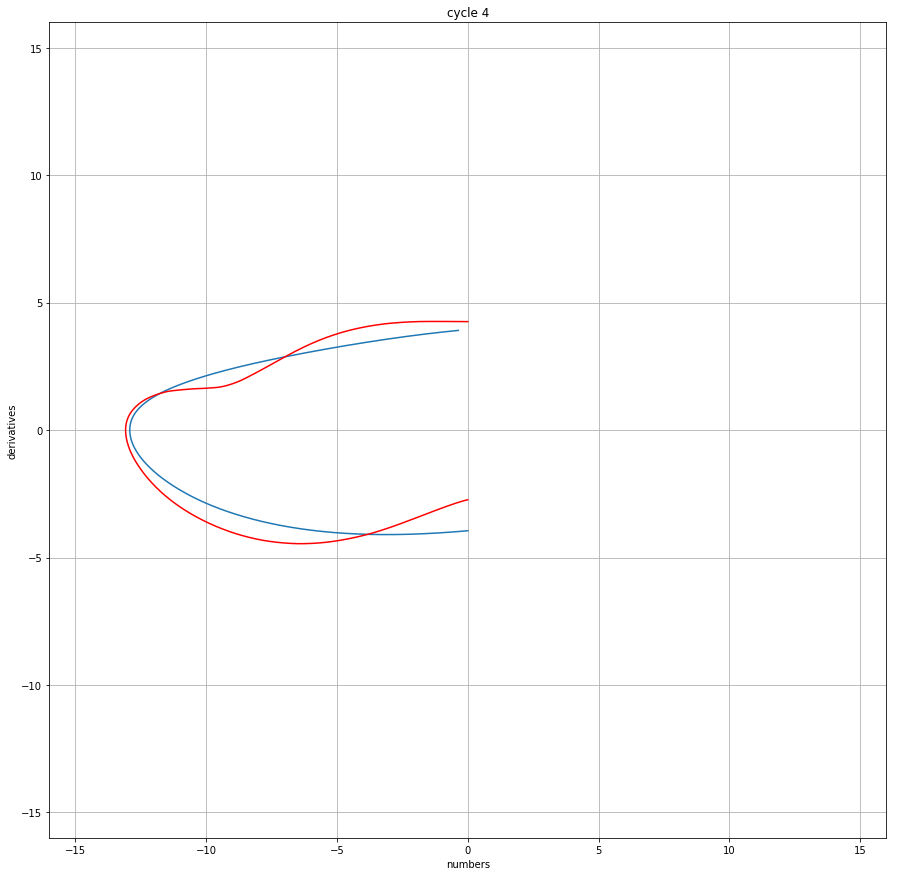

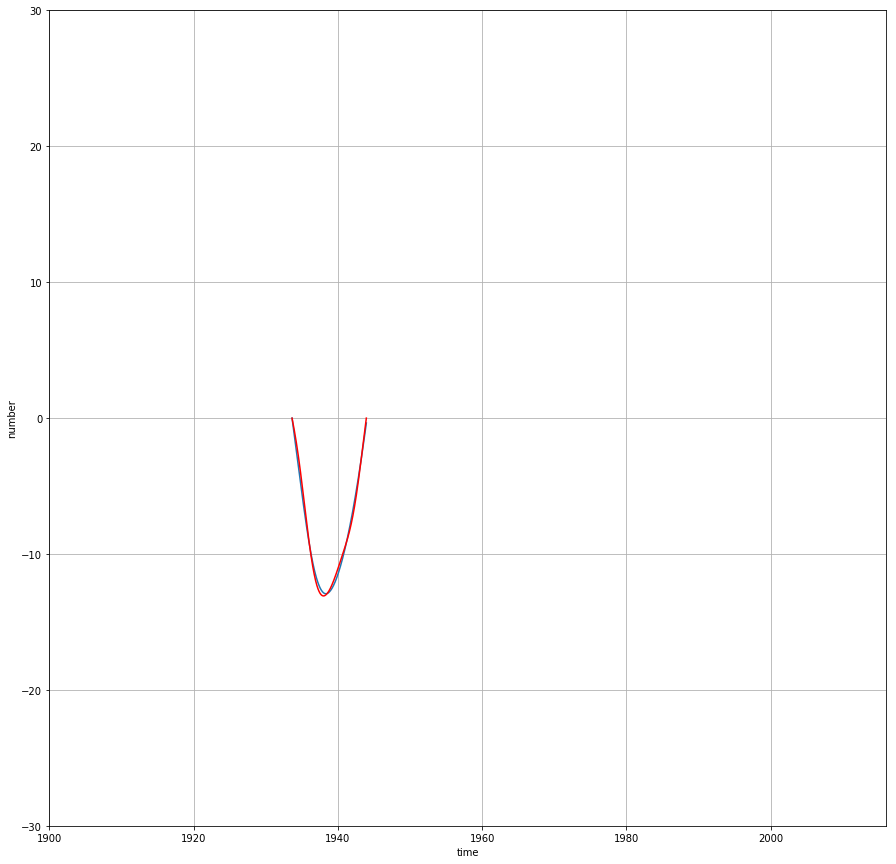

mistake = 0.5141678065904811
lamda = 0.0
mu = 0.1302
eps = 0.021
omega = 0.3134


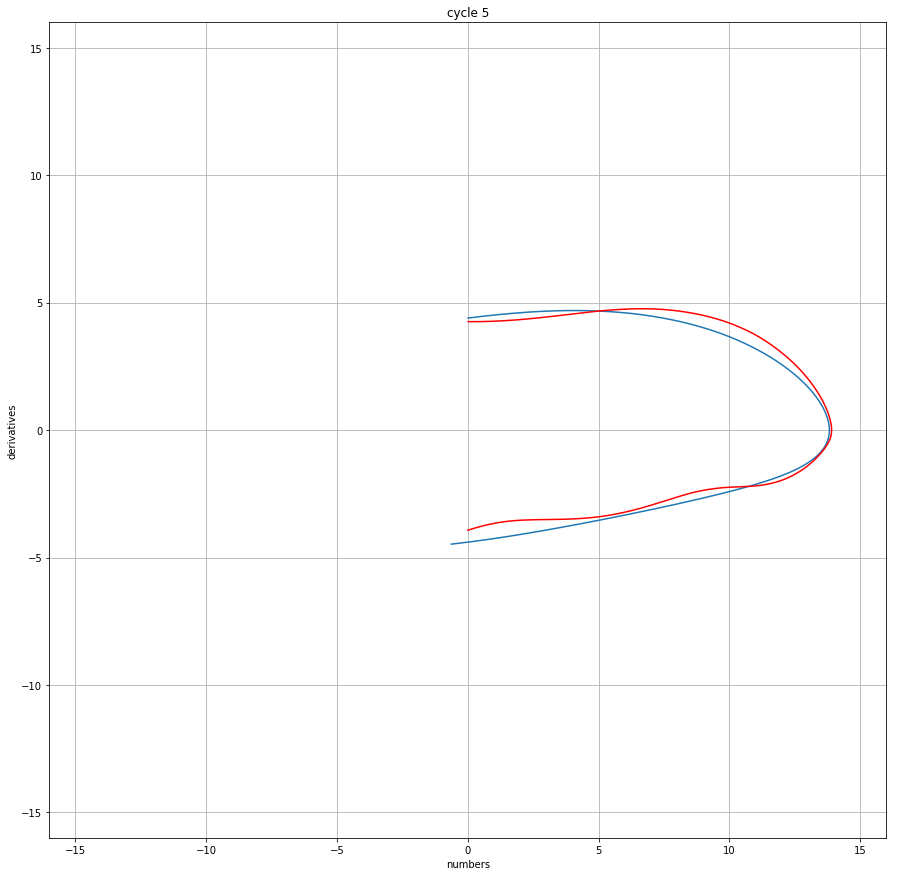

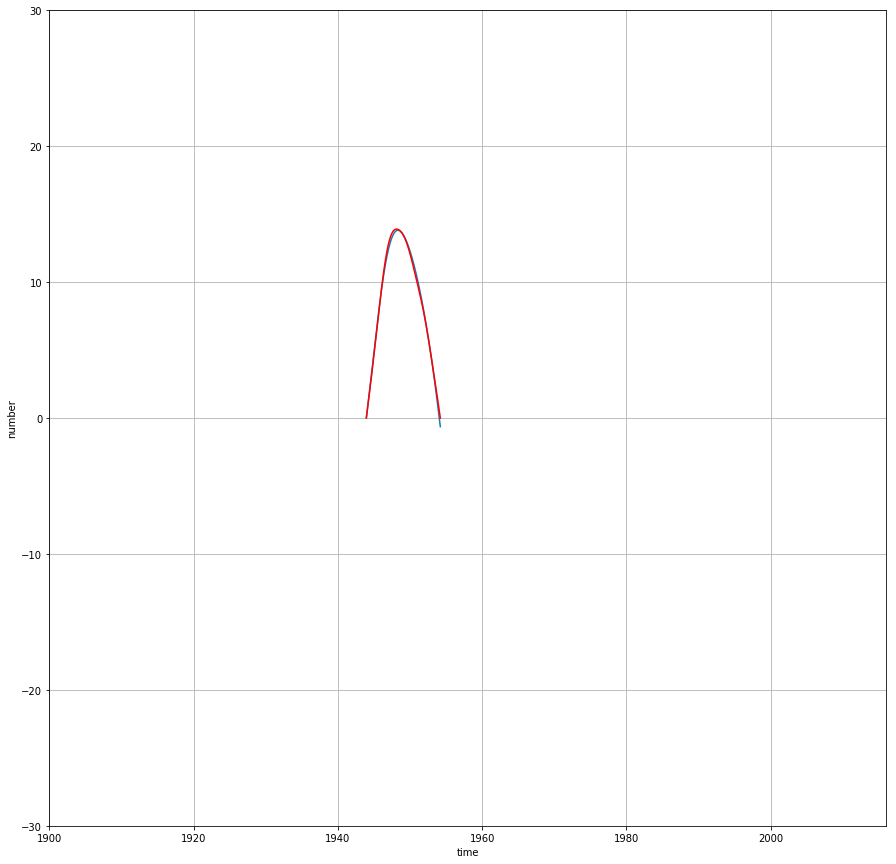

mistake = 4.95391330094317
lamda = 0.0001
mu = 0.2699
eps = 0.0172
omega = 0.2871


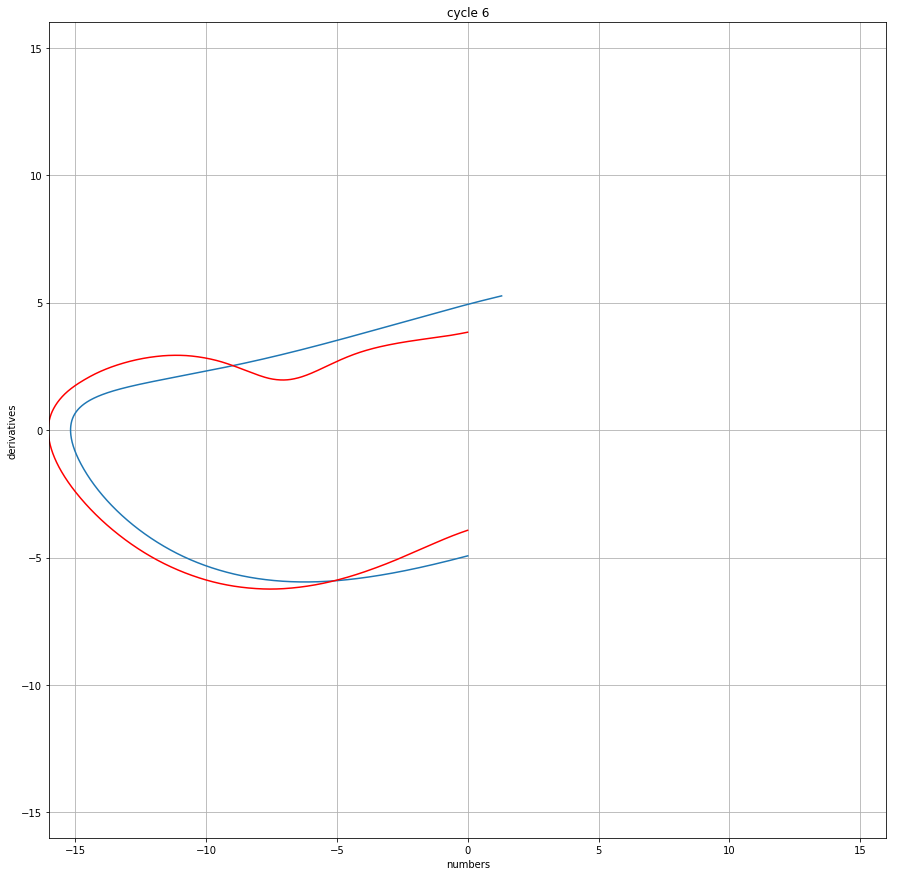

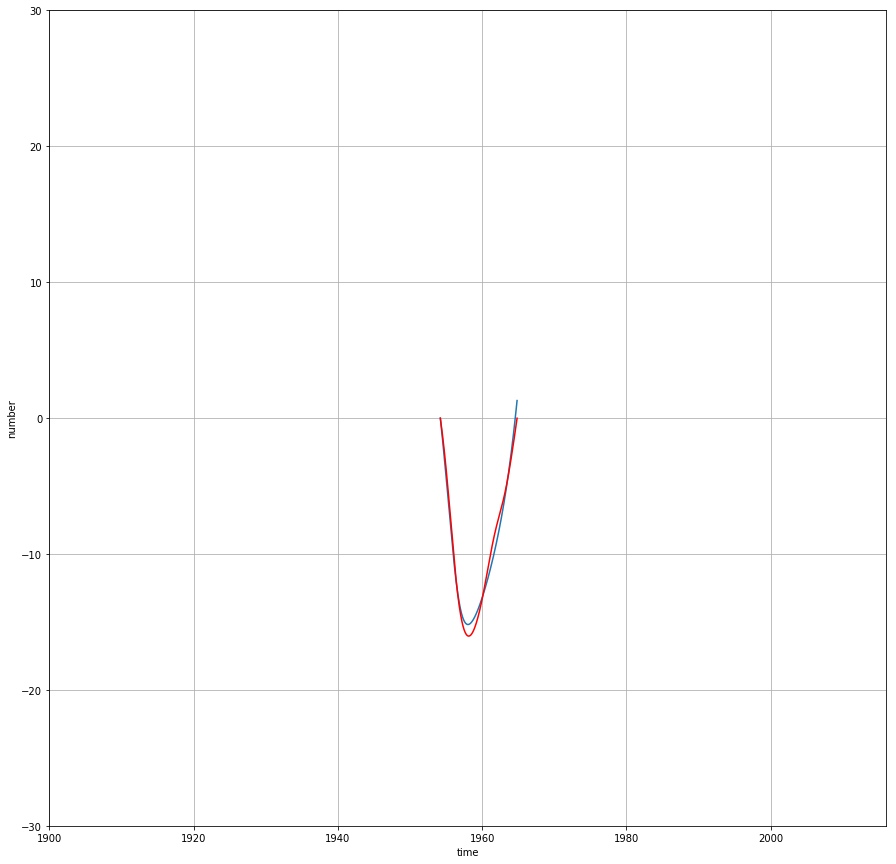

mistake = 0.44700283203131796
lamda = 0.0001
mu = 0.3099
eps = 0.0276
omega = 0.2767


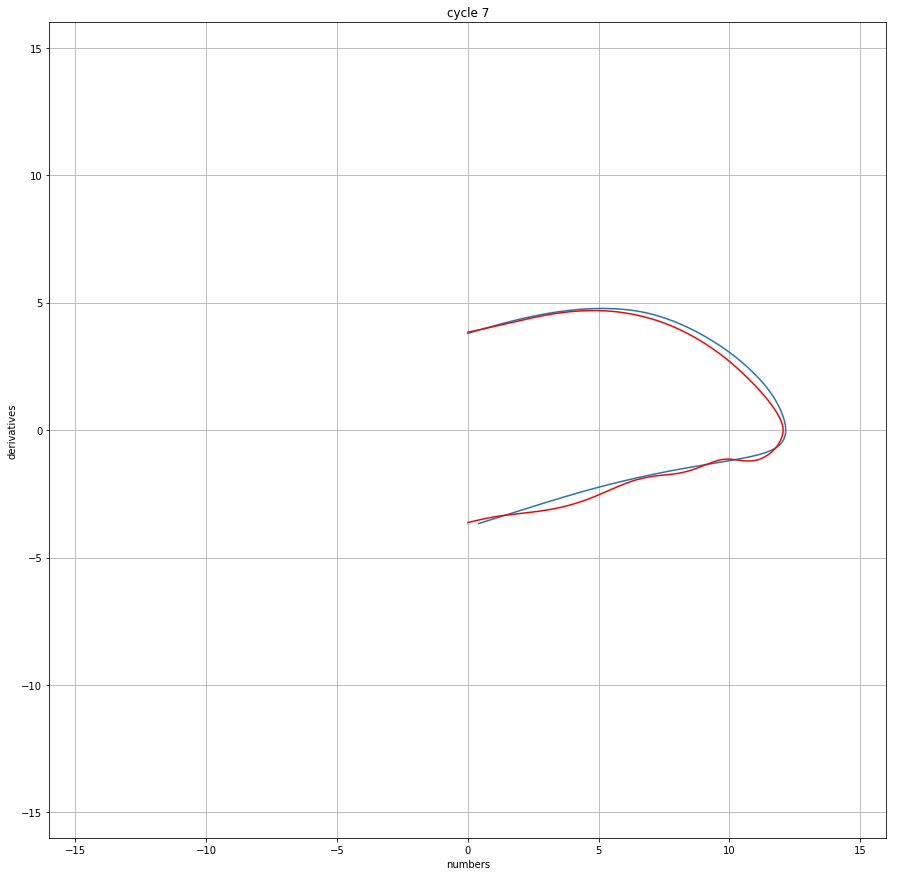

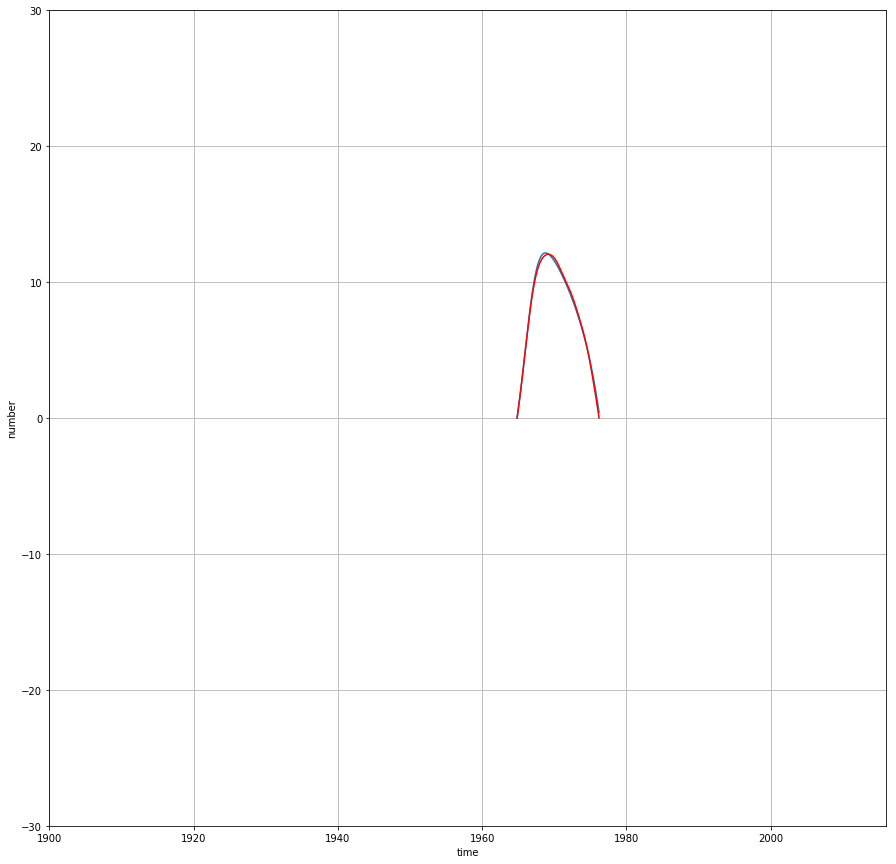

mistake = 0.5635278559662462
lamda = 0.0
mu = 0.1091
eps = 0.0194
omega = 0.3202


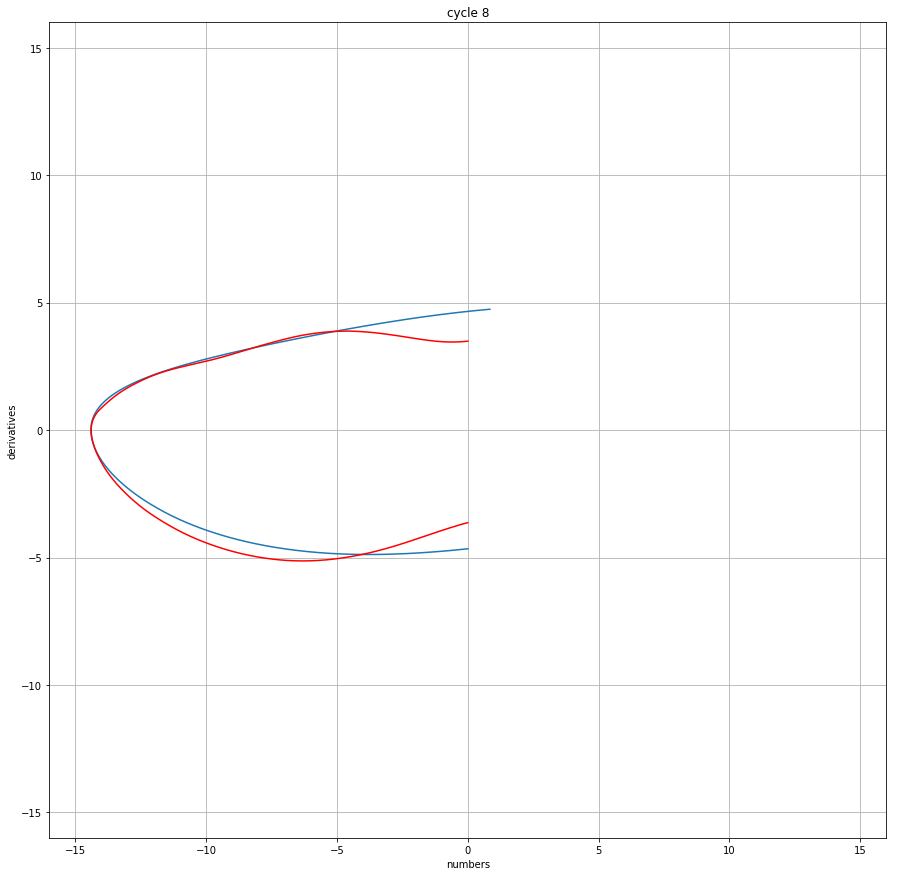

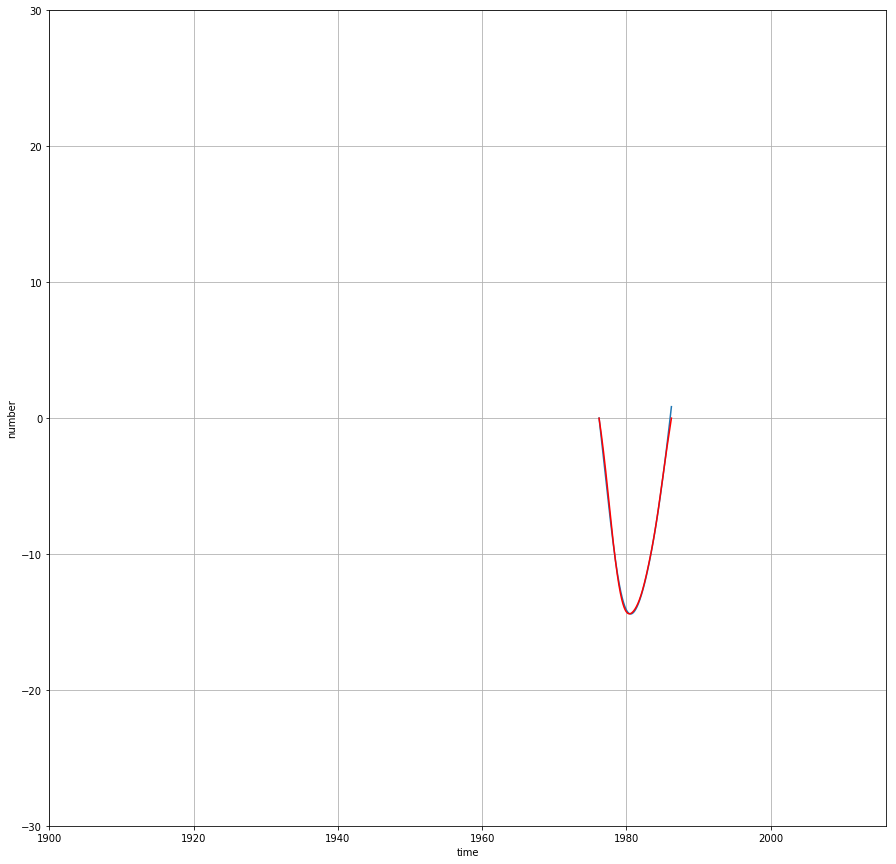

mistake = 1.7806574672629767
lamda = 0.0001
mu = 0.1889
eps = 0.0216
omega = 0.2974


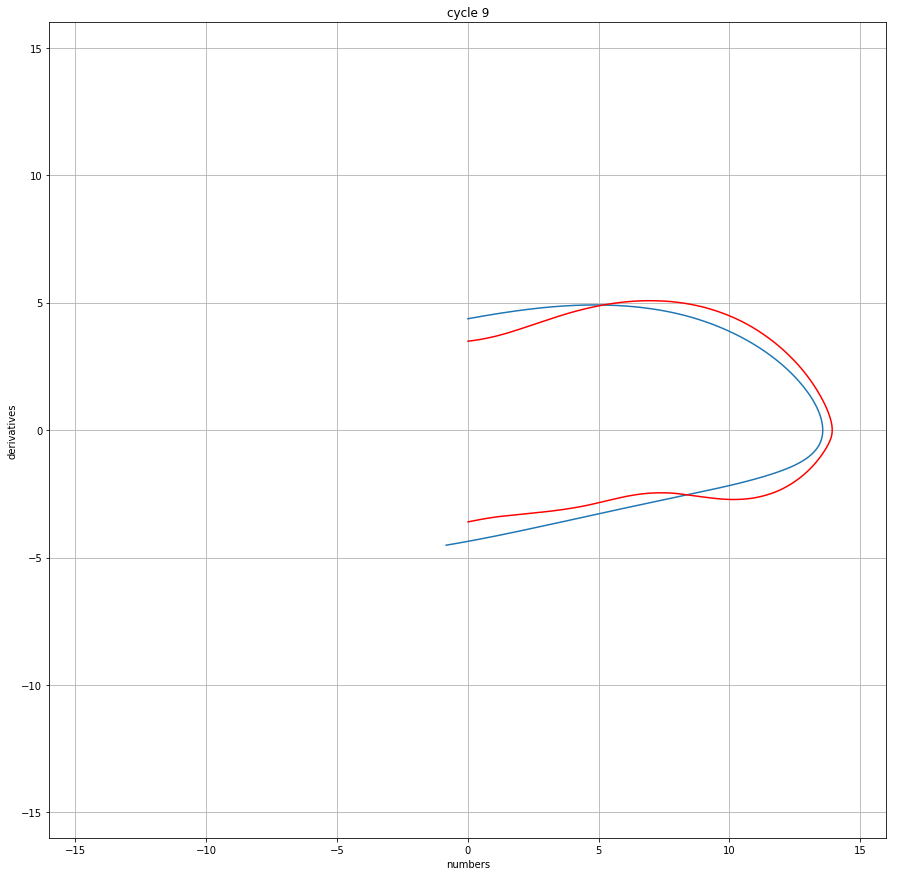

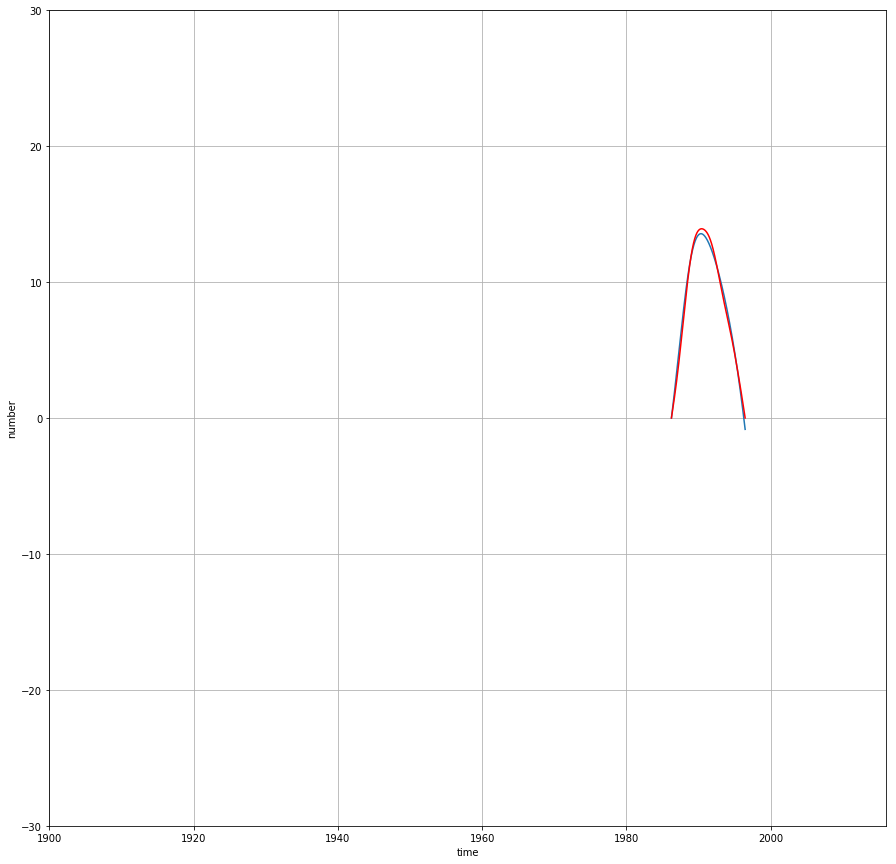

mistake = 4.583903876080289
lamda = 0.0001
mu = 0.212
eps = 0.0265
omega = 0.2529


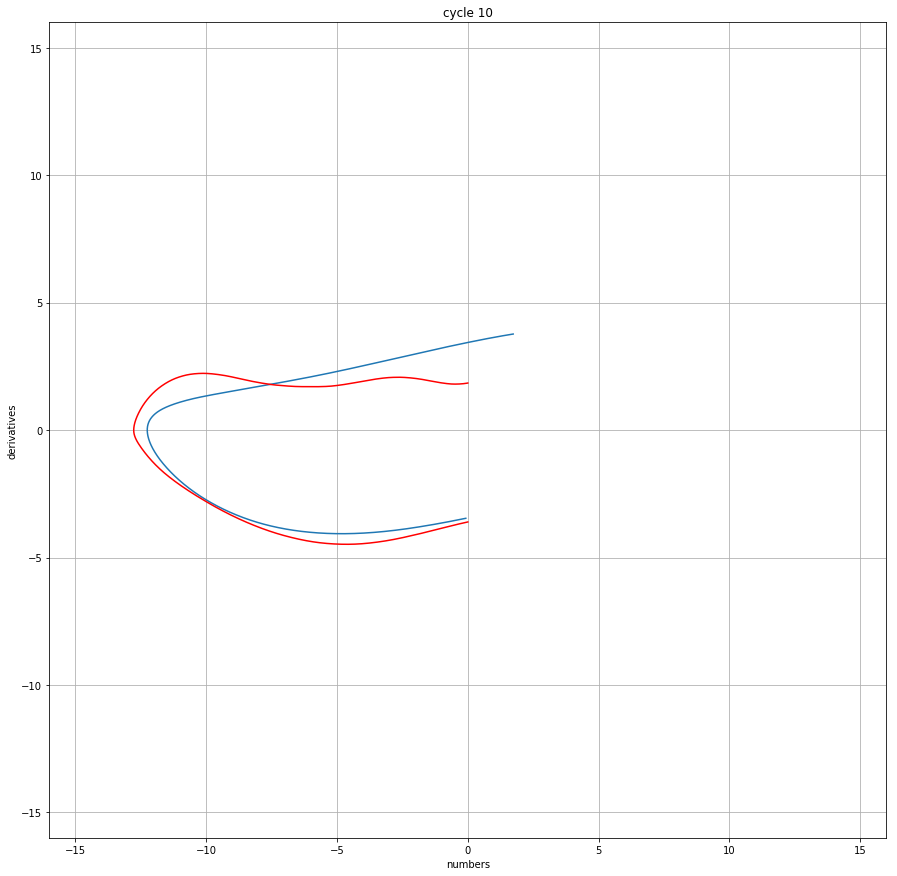

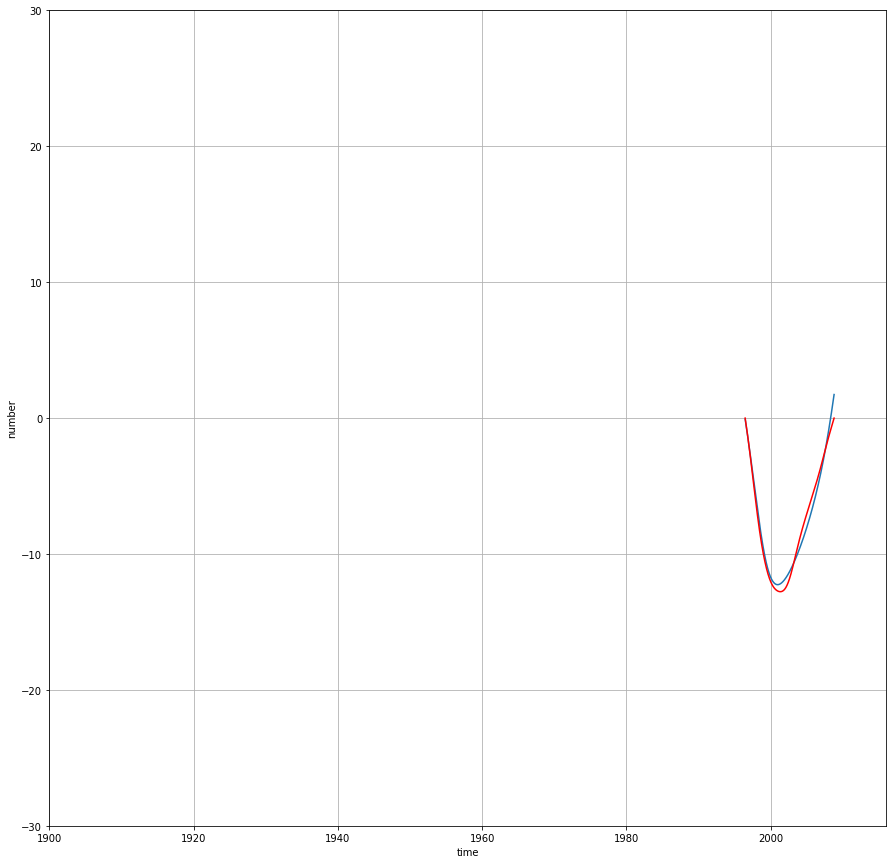

mistake = 0.49040057864358716
lamda = 0.0004
mu = 0.04
eps = 0.0424
omega = 0.2597


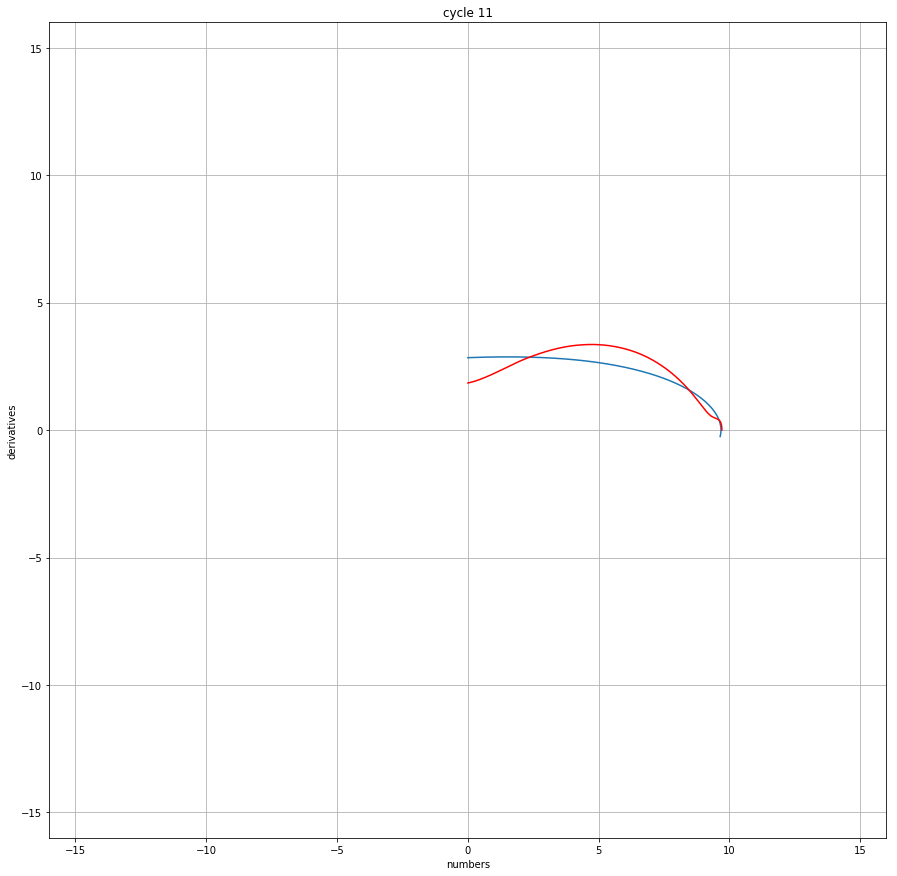

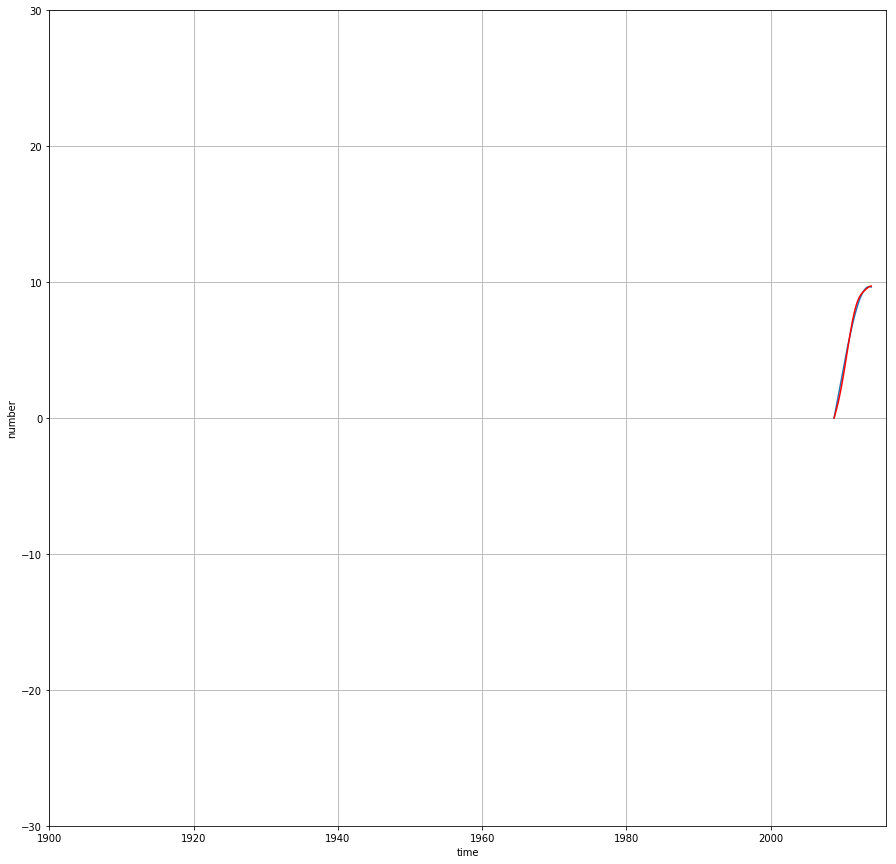

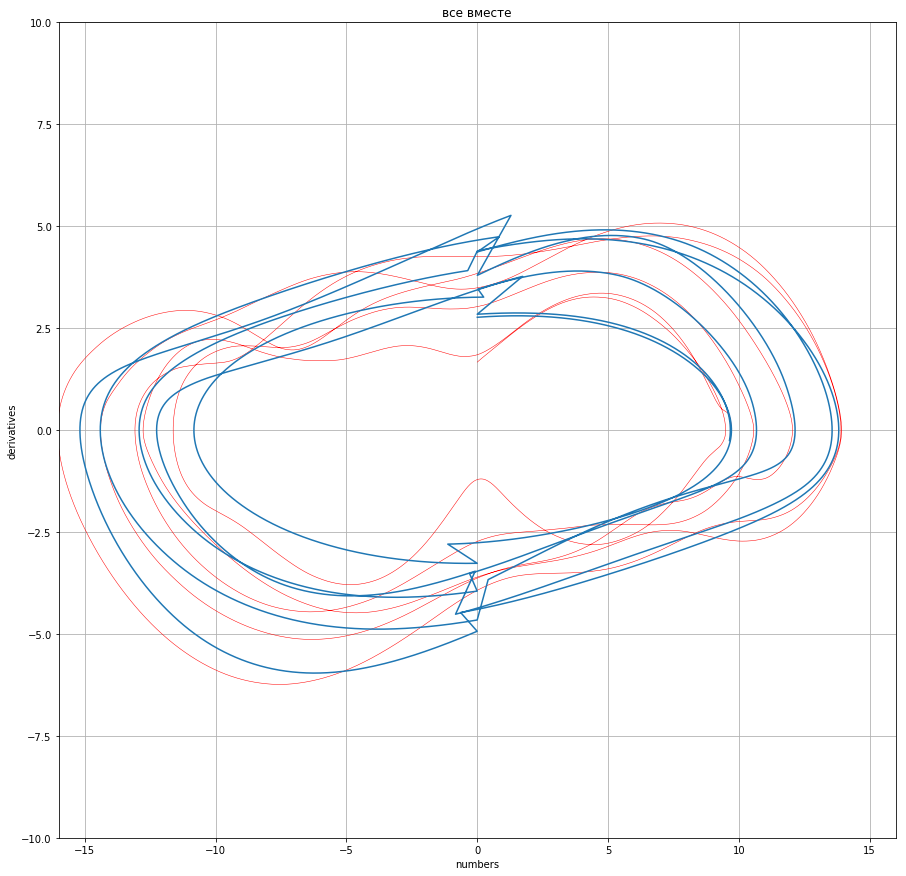

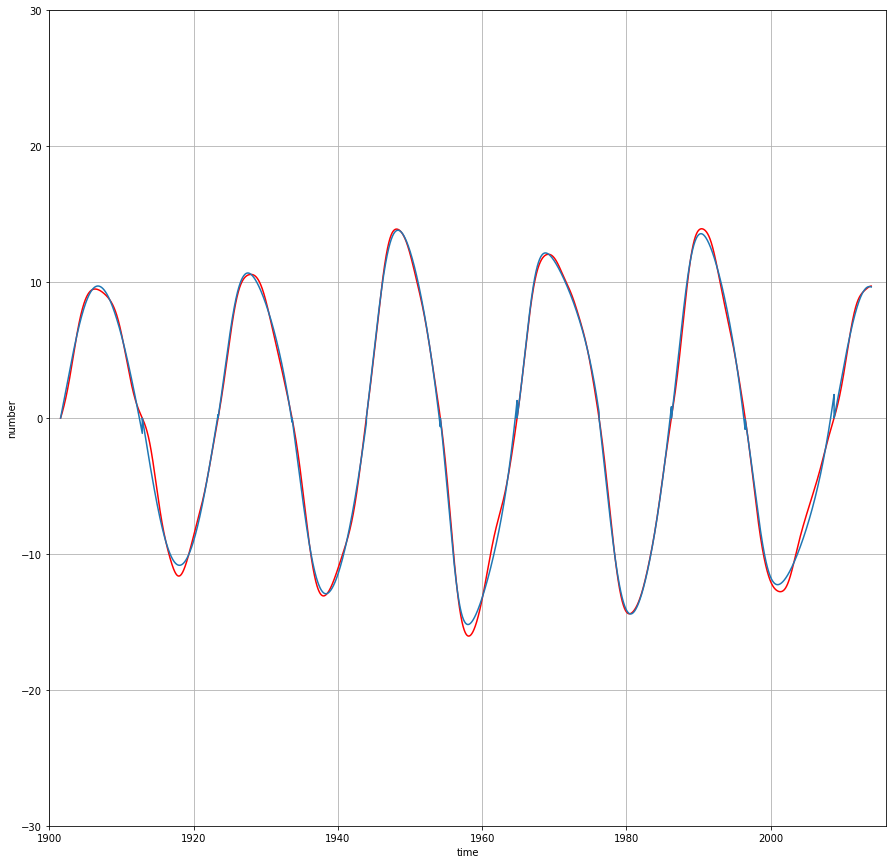

In [65]:
integral_approx_param_2 = cycles_approx(integral_difference, portraits_2, smoothed_data_2, cycles_2)

## Получение амплитуды и периодов новых данных

In [66]:
ap_table_2 = get_period_and_amplitude(cycles_2, smoothed_data_2)

## Составление таблиц данных о приближении 2

In [67]:
reg_approx_param_table_2 = np.concatenate((ap_table_2, reg_approx_param_2[0:-1,:]), axis=1)
integral_approx_param_table_2 = np.concatenate((ap_table_2, integral_approx_param_2[0:-1,:]), axis=1)

## Функции для приближения по периоду
примечание: файл half_periods.txt приложен и код по его получению в отдельном файле

In [68]:
def extract_period_data():
    text = open('half_periods.txt', "r")
    periods = []
    for line in text:
        append_list = list(map(float, line.split()))
        periods.append(append_list)
    periods_array = np.array(periods)
    a = np.arange(0.2, 3 - 0.001, 0.014)
    filtered_periods = []
    for i in range(0, np.shape(periods_array)[1]):
        numbers = periods_array[:,i]
        filtered = lowess(numbers, a, is_sorted = True, frac = 0.17, it=0)
        filtered_periods.append(filtered[:,1:2])
    return np.concatenate(filtered_periods, axis=1)
    return periods_array

In [69]:
periods = extract_period_data()

In [70]:
def find_min_indexes(array, number):
    min_indexes = [0]
    min_diff = round(abs(array[0] - number), 4)
    size  = len(array)
    for i in range(1, size):
        diff = round(abs(array[i] - number), 4)
        if (diff == min_diff):
            min_indexes.append(i)
        if (diff < min_diff):
            min_indexes = [i]
            min_diff = diff
    return min_indexes.copy()

## Функции для приближения близкого по периоду

In [79]:
a = 0
b = 0

In [80]:
def VDPD_norm (t, y):
    dydt = [y[1], -a * (y[0] ** 2 - 1) * y[1] -
                   (b * y[0] ** 2 + 1) * y[0]]
    return dydt

In [81]:
def get_moves_with_close_period(step):
    moves = []
    for i in range (-1, 2):
        for j in range (-1, 2):
            for k in range (-1, 2):
                if (k or j or i):
                    moves.append([i * step, j * step, k * step])
    return moves

In [82]:
def get_block_with_close_period(move, moves, step, b):
    global lamda, mu, eps, omega
    blocked_moves = []
    for i in range (-1, 2):
        for j in range (-1, 2):
            for k in range (-1, 2):
                v = [i * step + move[0], j * step + move[1], k * step + move[2]]
                if ((b + i * step + move[0] < 0.05) or
                    (b + i * step + move[0] >= 1.5) or
                    (j < 0 and eps < step) or
                    (k < 0 and omega < step) or
                    (v in moves)):
                    blocked_moves.append([i * step, j * step, k * step])
    return blocked_moves.copy()

In [83]:
def calculate_approx_with_close_period(events_num, period, sign):
    global eps, omega
    init_sol = solve_ivp(VDPD_norm, (0, 100), [2, 0], method='RK45',
                         t_eval=np.linspace(0, 100, 100000)).y
    i = np.shape(init_sol)[1] - 1
    while (not (init_sol[0, i] * sign <= 0 and init_sol[0, i - 1] * sign > 0)):
        i -= 1
    while (not (init_sol[0, i] * sign >= 0 and init_sol[0, i - 1] * sign < 0)):
        i -= 1
    true_start = [init_sol[0, i], init_sol[1, i]]
    sol = solve_ivp(VDPD_norm, (0, period), true_start, method='RK45',
                    t_eval=np.linspace(0, period, events_num)).y
    size = np.shape(sol)
    for i in range(size[1]):
        sol[0, i] /= np.sqrt(eps)
        sol[1, i] = sol[1, i] * omega / np.sqrt(eps)
    return sol

In [93]:
def get_approx_with_close_period(data, difference, portrait):
    global mu, omega, eps, lamda, b, a
    t_span = data[-1, 0] - data[0, 0]
    
    max_data = find_max(data)
    sign = np.sign(max_data)
    blocked = []
    
    best_approx = np.array([])
    
    best_a = 0
    b = round(lamda / (eps * omega ** 2), 4)
    init_parameters = [b, eps, omega]
    
    step = 0.1
    step_counter = 0
    mu = 0
    best_move = [0, 0, 0]
    min_difference = 1000000
    
    
    while (step_counter < 10000000 and step > 0.00001):
        moves = get_moves_with_close_period(step)
        blocked = get_block_with_close_period([0, 0, 0], [], step, init_parameters[0])
        end_flag = 0
        while (not end_flag):
            end_flag = 1
            for move in moves:
                if (not (move in blocked)):
                    step_counter += 1
                    b = round(init_parameters[0] + move[0], 4)
                    eps = round(init_parameters[1] + move[1], 4)
                    omega = round(init_parameters[2] + move[2], 4)
                    i = 0
                    if (b < 0.125):
                        i = np.floor(round((b - 0.05) / 0.001, 4))
                        b_max = round(0.05 + (i + 1) * 0.001, 3)
                        b_min = round(0.05 + i * 0.001, 3)
                        if (b_max - b < b - b_min):
                            i += 1
                    else:
                        i = np.floor(round((b - 0.125) / 0.011, 4))
                        b_max = round(0.125 + (i + 1) * 0.011, 3)
                        b_min = round(0.125 + i * 0.011, 3)
                        i += 75
                        if (b_max < 1.5 and b_max - b < b - b_min):
                            i += 1
                    index = int(i)
                    chosen_periods = periods[:, index]
                    min_ind = find_min_indexes(chosen_periods, t_span * omega)
                    for j in min_ind:
                        a = round(0.2 + j * 0.014, 3)
                        approx_data = calculate_approx_with_close_period(np.shape(data)[0],
                                                                         t_span * omega, sign)
    
                        diff = difference(approx_data, portrait)
                        if (diff < min_difference):
                            end_flag = 0
                            min_difference = diff
                            best_approx = approx_data
                            best_move = move
                            best_a = a

            if (not end_flag):
                init_parameters = [round(init_parameters[0] + best_move[0], 4),
                                   round(init_parameters[1] + best_move[1], 4),
                                   round(init_parameters[2] + best_move[2], 4)]
            if (step_counter >= 10000000):
                end_flag = 1
            b, eps, omega = init_parameters
            blocked = get_block_with_close_period(best_move, moves, step, init_parameters[0])
        step /= 10
      
    b, eps, omega = init_parameters
    a = best_a
    diff_from_zero = best_approx[0, -1]
    flag = 1
    if (abs(diff_from_zero) < 0.1):
        flag = 0
    diff_from_zero_2 = 0
    while (flag):
        a += -sign * np.sign(diff_from_zero) * 0.00015
        a = round(a, 5)
        approx_data = calculate_approx_with_close_period(np.shape(data)[0],
                                                     t_span * omega, sign)
        diff_from_zero_2 = approx_data[0, -1]
        if (diff_from_zero_2 * diff_from_zero < 0 or abs(diff_from_zero_2) < 0.1):
            flag = 0
    
    if (abs(diff_from_zero_2) >= abs(diff_from_zero)):
        a = round(best_a, 5)
    best_approx = calculate_approx_with_close_period(np.shape(data)[0],
                                                     t_span * omega, sign)

    min_difference = difference(best_approx, portrait)
    diff_from_zero = best_approx[0, -1]
    return_parameters = [round(b * omega ** 2 * eps, 6),
                         round(a * omega, 4),
                         eps, omega]
    return (best_approx.copy(), min_difference, return_parameters)

In [94]:
def approximate_cycle_with_close_period(number, difference, portraits, smoothed_data, cycles):
    cycle_data = smoothed_data[cycles[number][0] : cycles[number][1] + 1,:]
    approx_data = get_approx_with_close_period(cycle_data, difference, portraits[number])
    return [cycle_data[:, 0], approx_data]

In [95]:
def cycles_approx_with_close_period(difference, portraits, smoothed_data, cycles, approx_param):
    data_span = smoothed_data[cycles[0][0]:cycles[-2][1] + 1, :]
    global lamda, mu, eps, omega 
    cycles_num = len(cycles)
    total_result = []
    parameters = []
    for i in range (0, cycles_num - 1): #у 11 не известен период
        lamda, mu, eps, omega = approx_param[i]
        result_data = approximate_cycle_with_close_period(i, difference,
                                                                portraits, smoothed_data, cycles)
        total_result.append(result_data[1][0])
        c_parameters = drow_cycle_results(result_data, i, portraits)
        parameters.append(c_parameters)
    all_approx_data = np.concatenate(total_result, axis = 1)
    add_graph_parametrs(lower_border=-10, upper_border = 10,
                        left_border = -16, right_border = 16)
    plt.title(u'все вместе')
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    draw_cycles(portraits, -1)
    plt.plot(all_approx_data[0,:], all_approx_data[1,:])
    plt.show()
    add_graph_parametrs()
    plt.plot(data_span[:, 0], data_span[:, 1], color='r')
    plt.plot(data_span[:, 0], all_approx_data[0, :])
    plt.show()
    return np.array(parameters)

## Получение приближения близкого по периоду с функцией ошибки равной среднему расстоянию для исходных данных

mistake = 0.5524552205235005
lamda = 0.000312
mu = 0.2028
eps = 0.0431
omega = 0.244


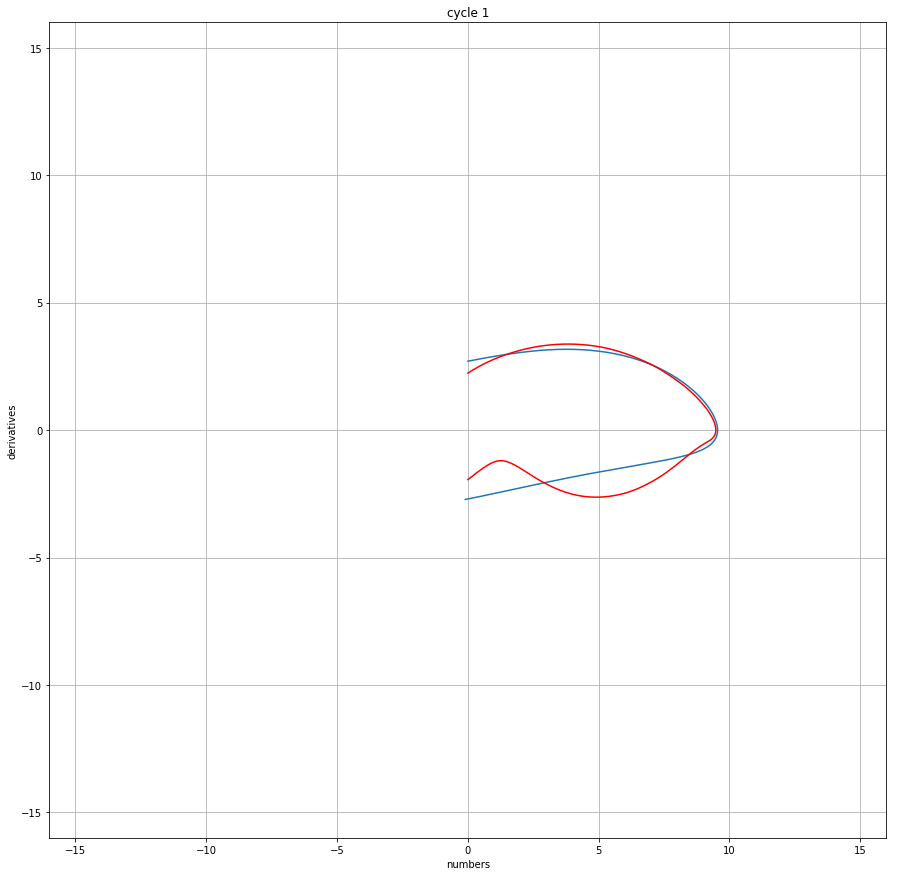

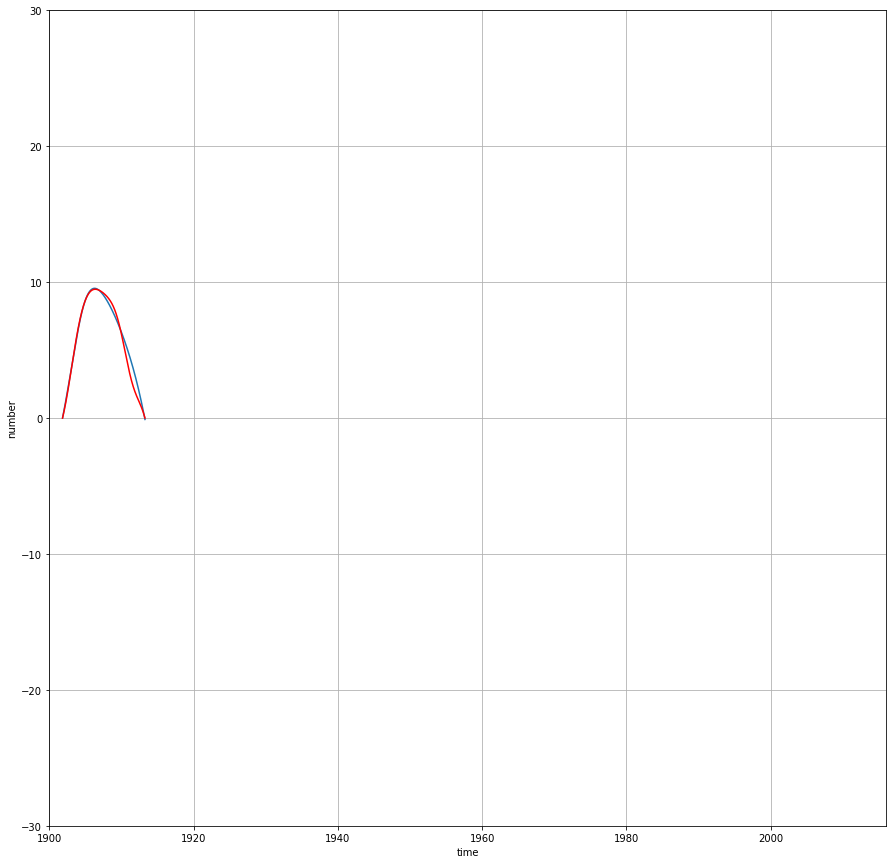

mistake = 0.47286715054264383
lamda = 0.000218
mu = 0.086
eps = 0.0319
omega = 0.2755


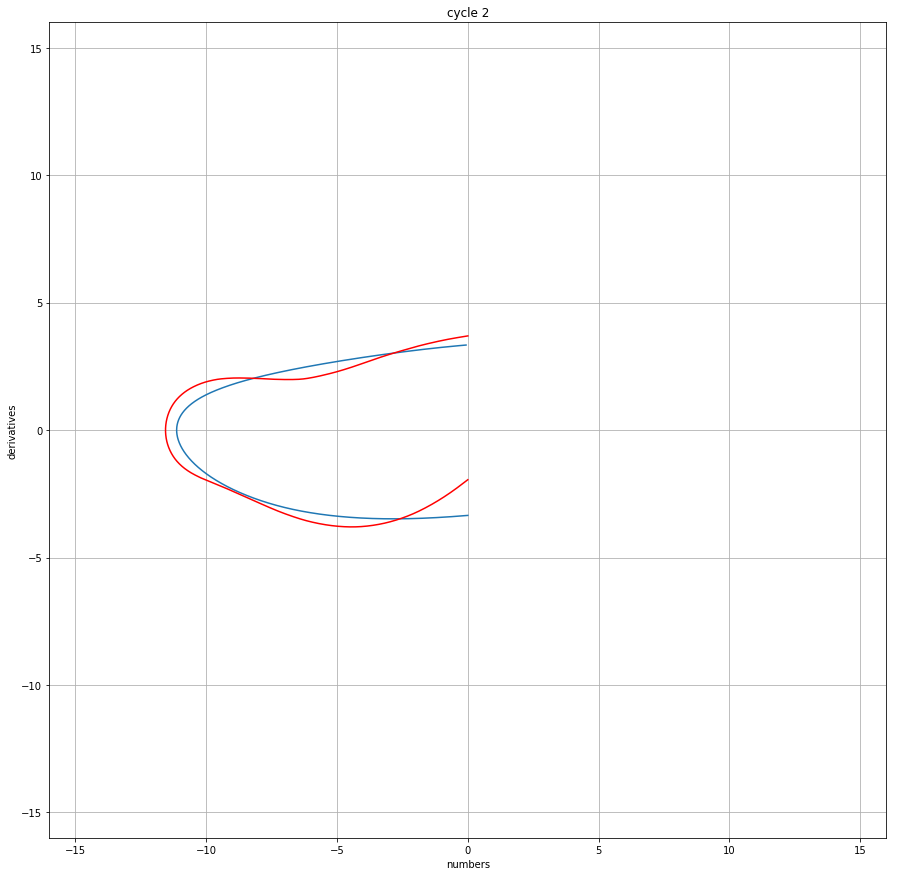

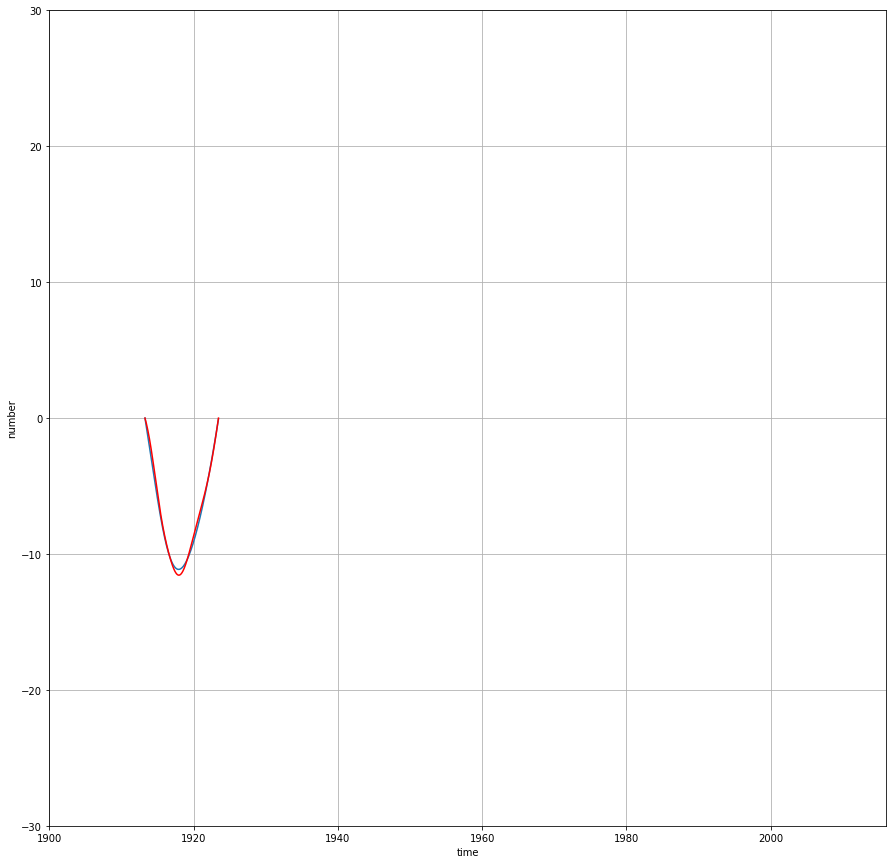

mistake = 0.31586096789401663
lamda = 0.000202
mu = 0.1982
eps = 0.0355
omega = 0.2872


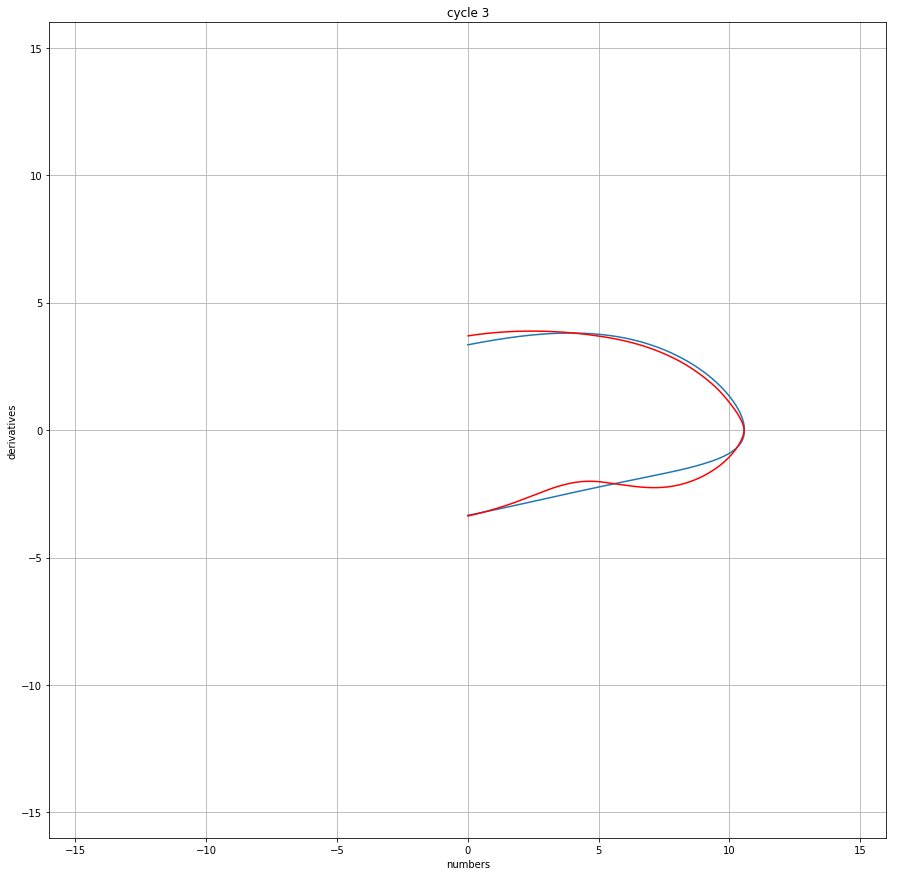

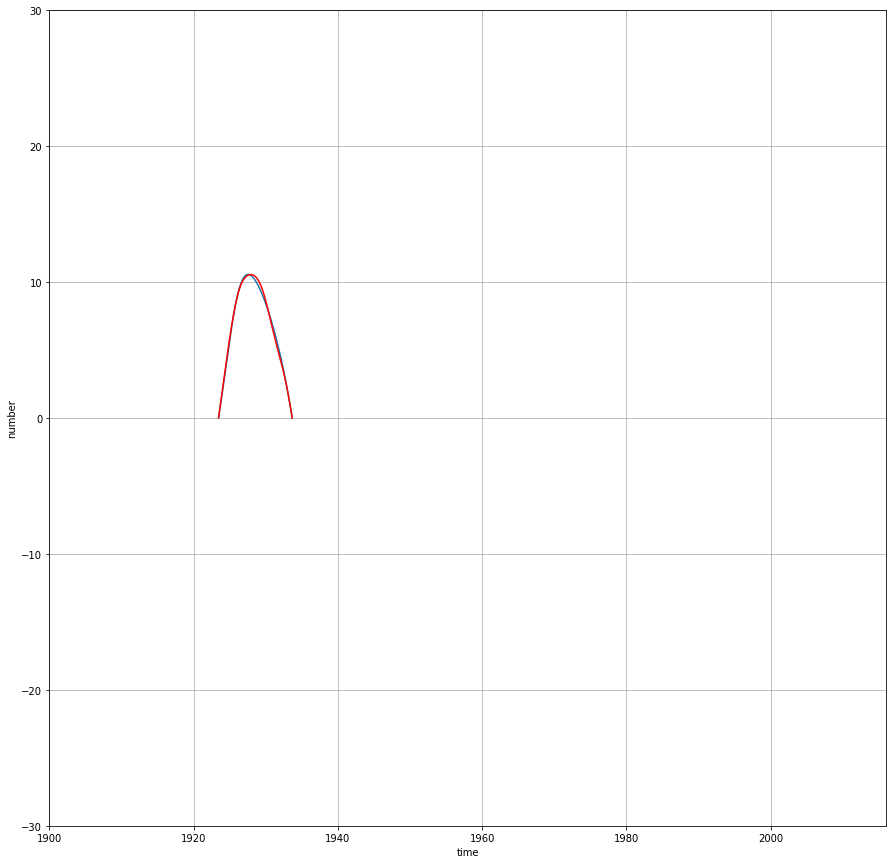

mistake = 0.49385532748490807
lamda = 0.000128
mu = 0.1325
eps = 0.0237
omega = 0.2761


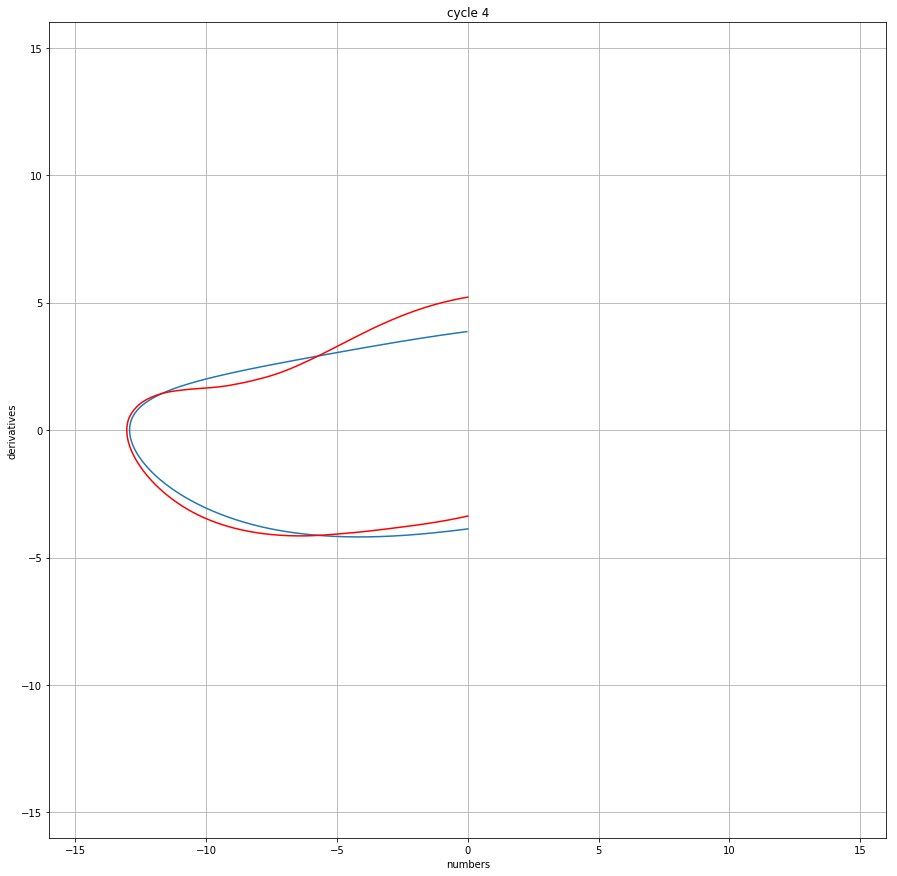

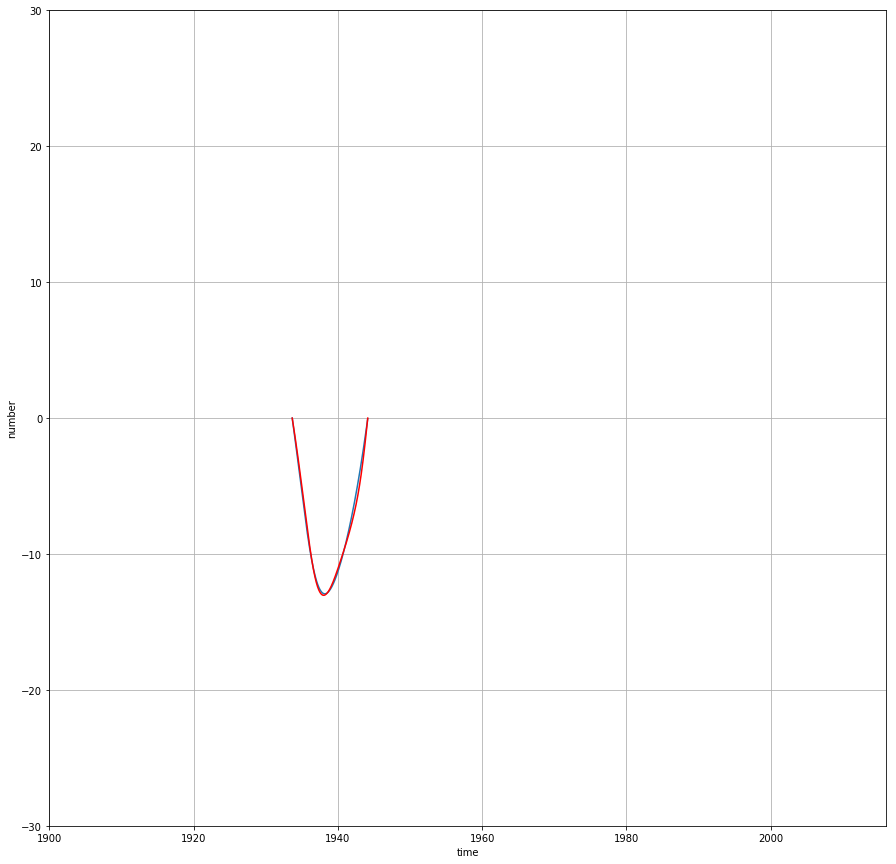

mistake = 0.21861126315897847
lamda = 0.000137
mu = 0.2233
eps = 0.0206
omega = 0.2885


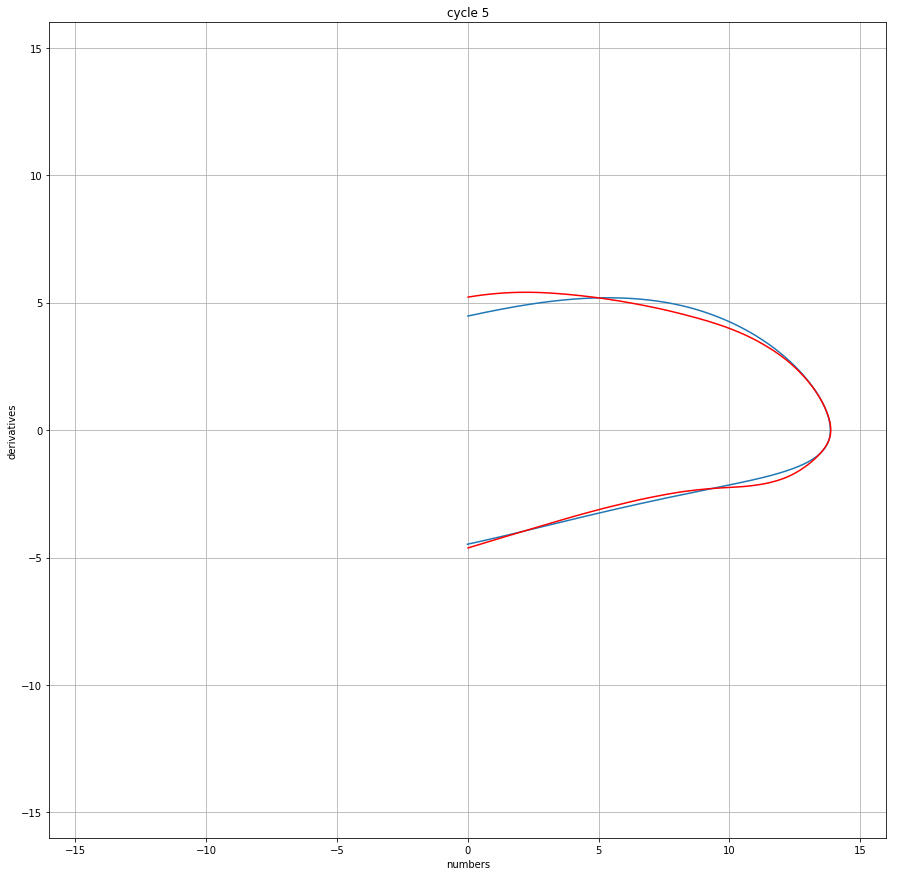

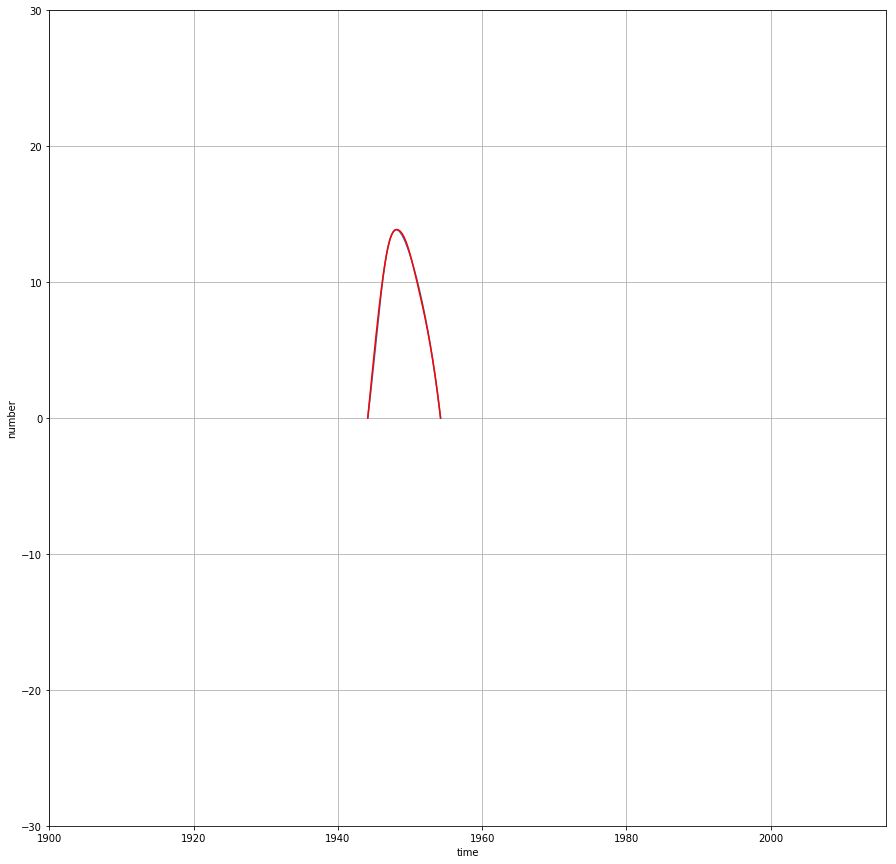

mistake = 0.7581659162998379
lamda = 0.000112
mu = 0.2533
eps = 0.0164
omega = 0.2771


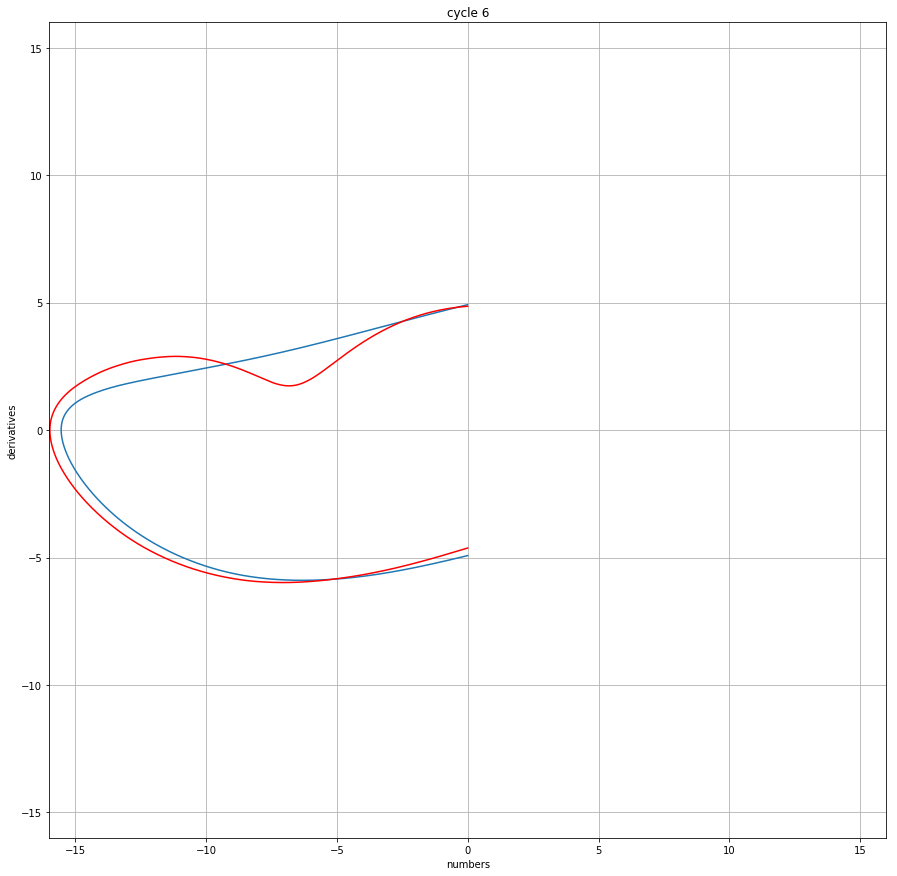

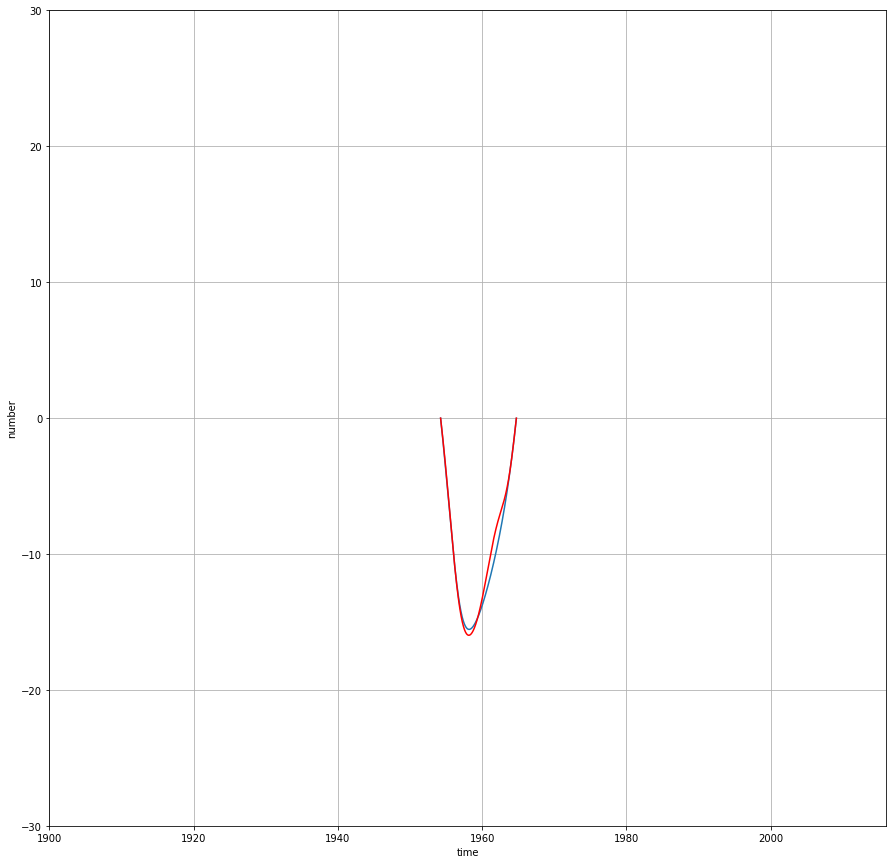

mistake = 0.4788231775206511
lamda = 0.000104
mu = 0.256
eps = 0.0279
omega = 0.264


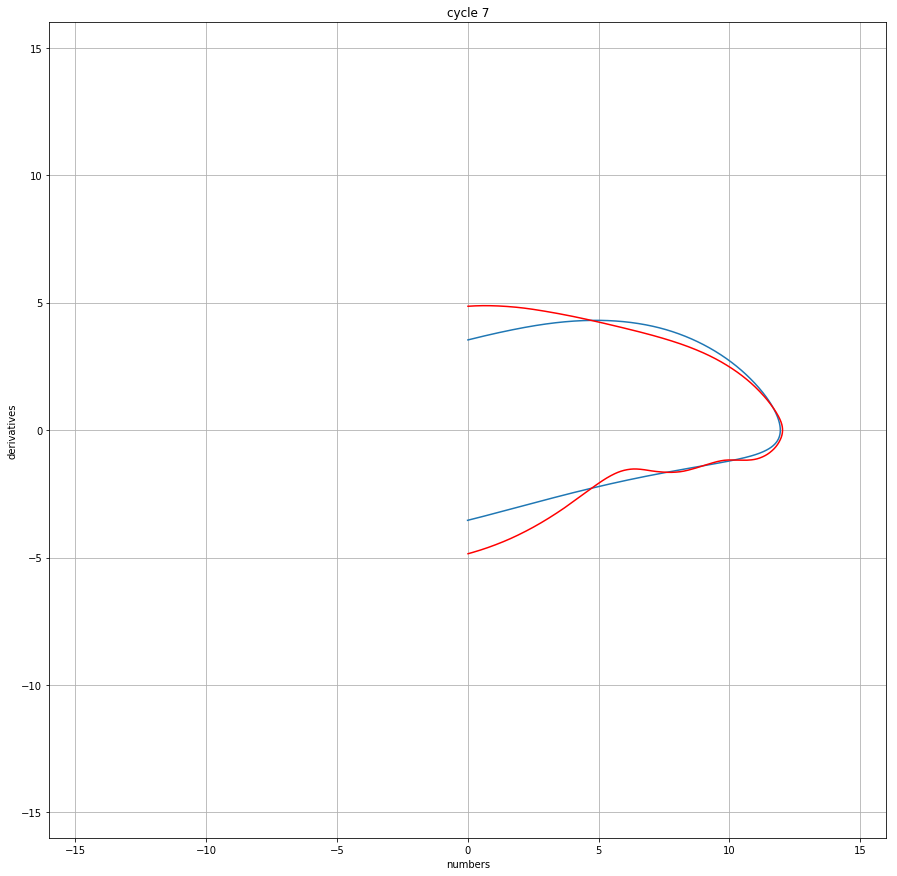

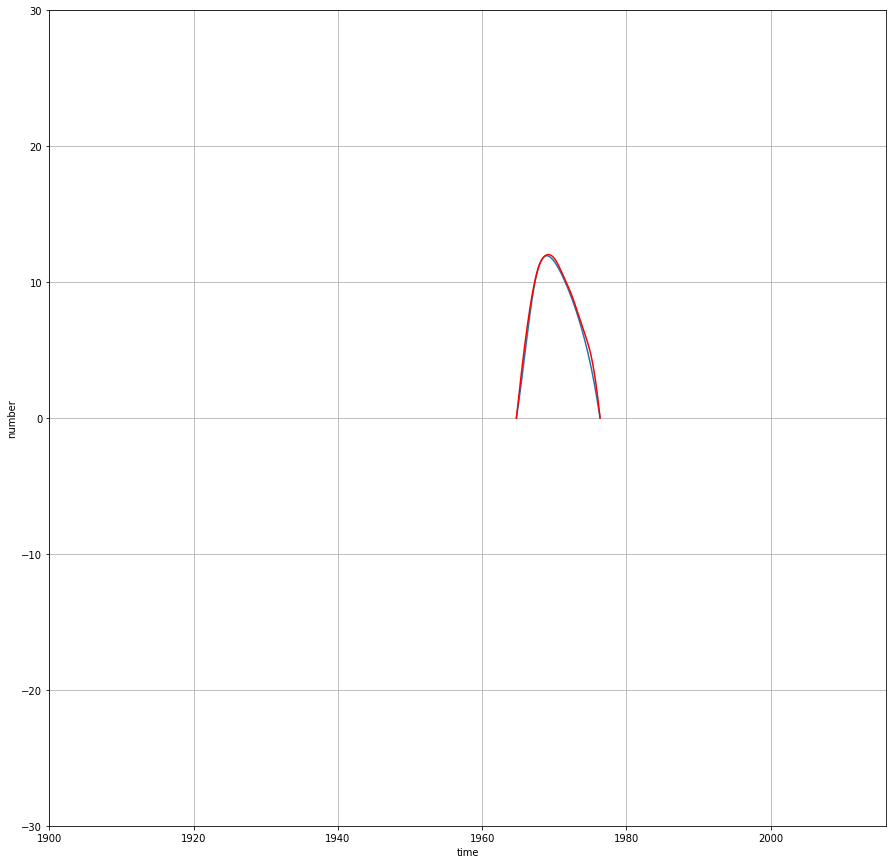

mistake = 0.2755911125162989
lamda = 0.000113
mu = 0.2034
eps = 0.0193
omega = 0.2888


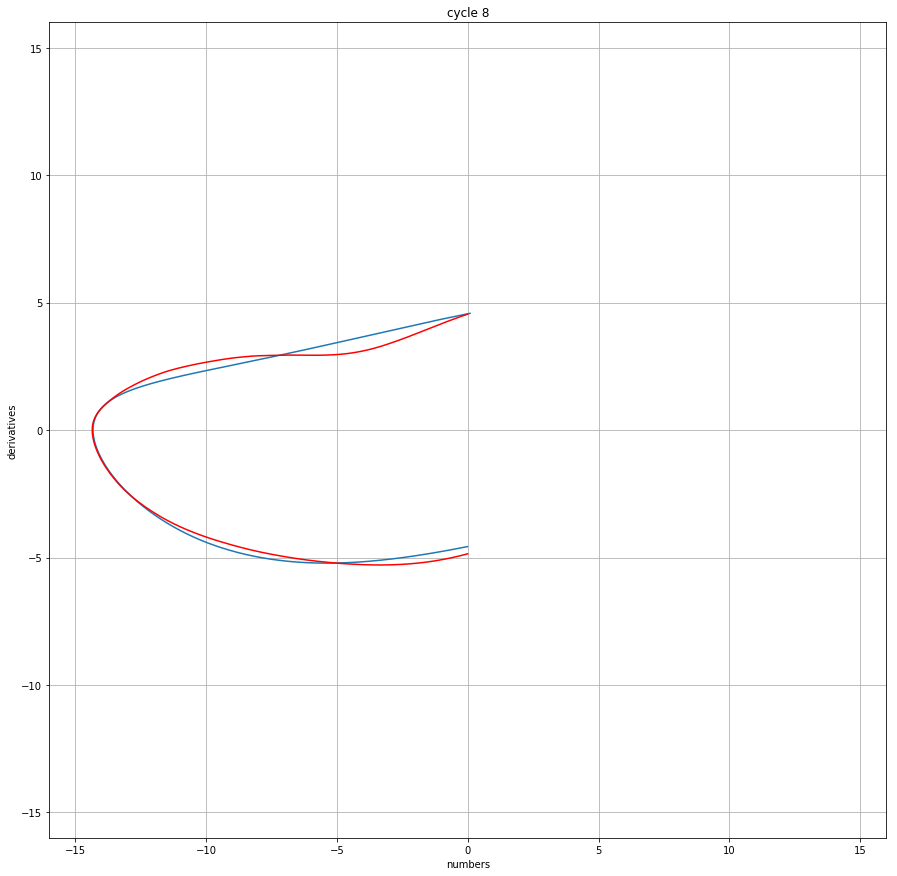

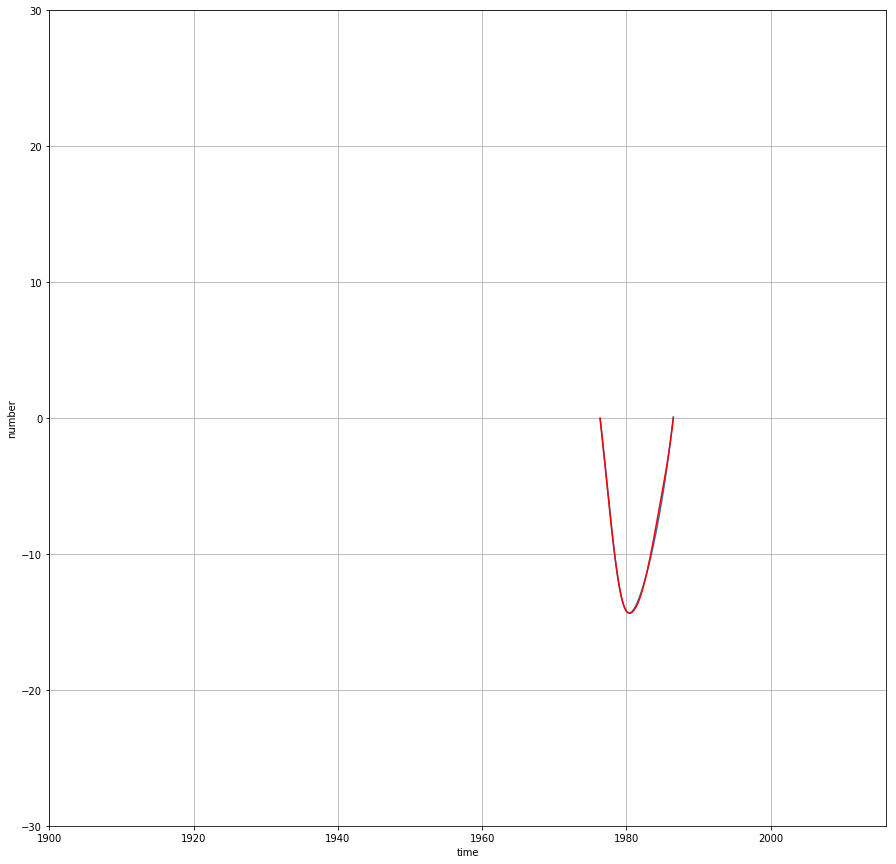

mistake = 0.3458052185810284
lamda = 0.0001
mu = 0.2323
eps = 0.0208
omega = 0.3056


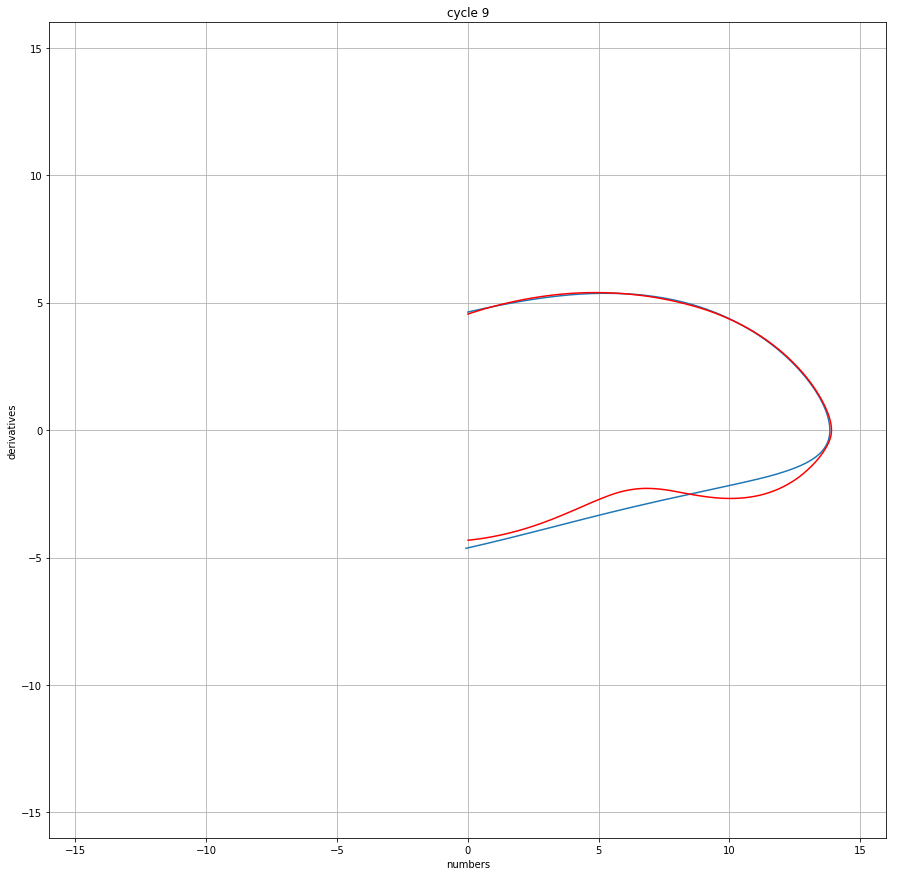

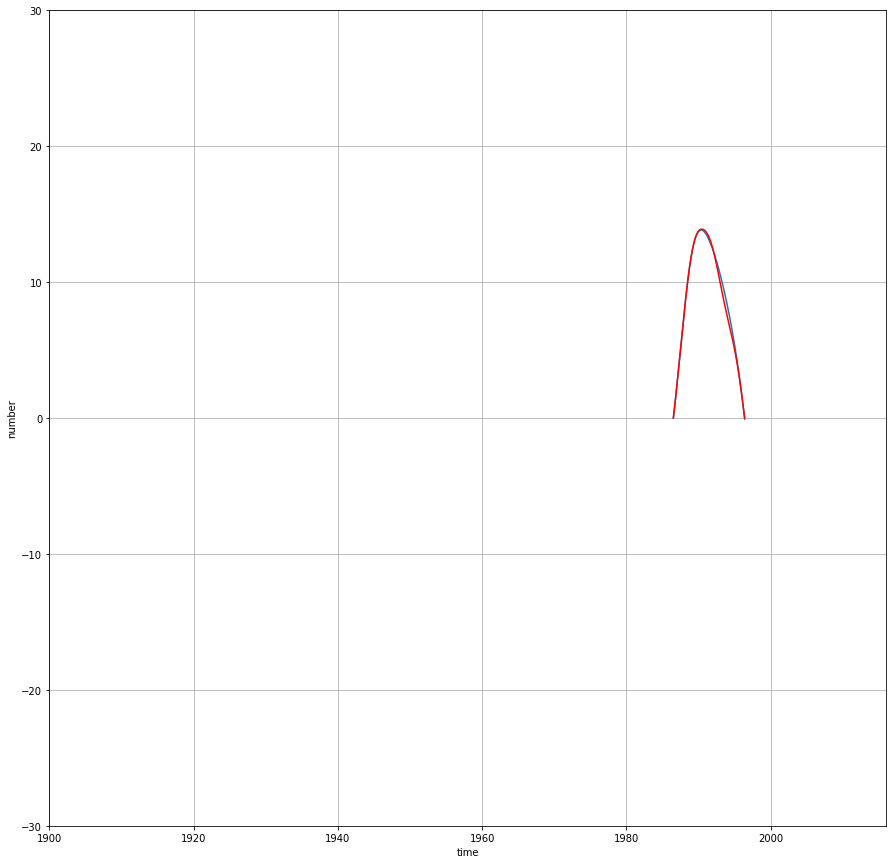

mistake = 0.9186955479914638
lamda = 0.000112
mu = 0.2534
eps = 0.0262
omega = 0.2404


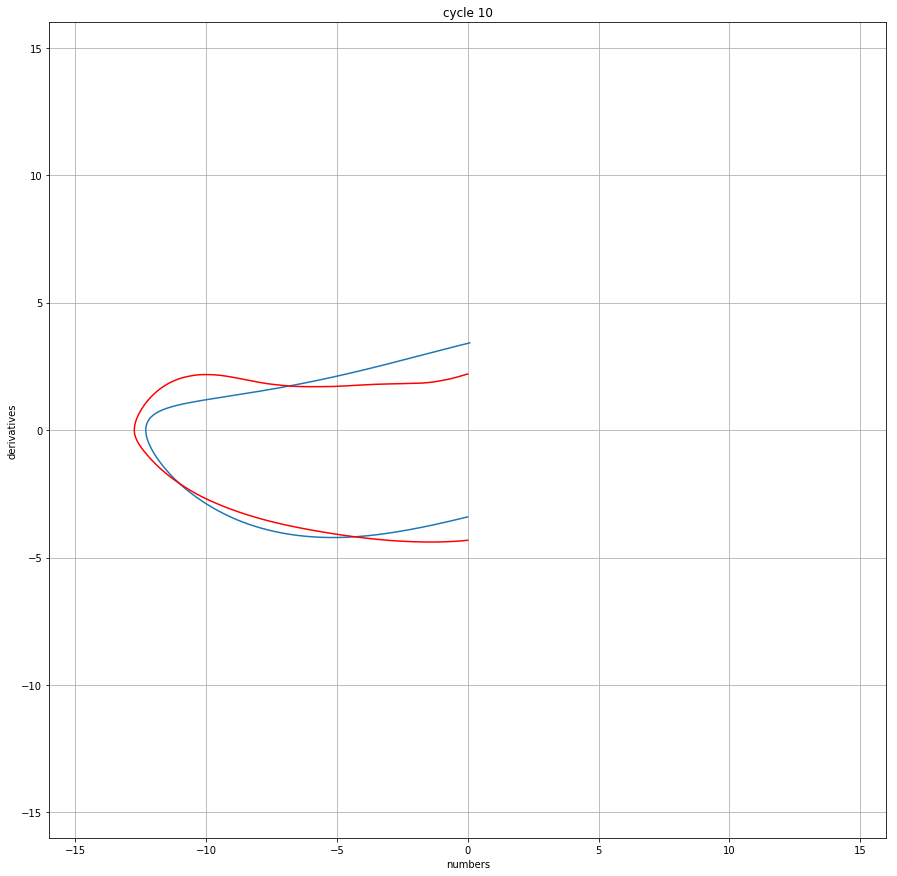

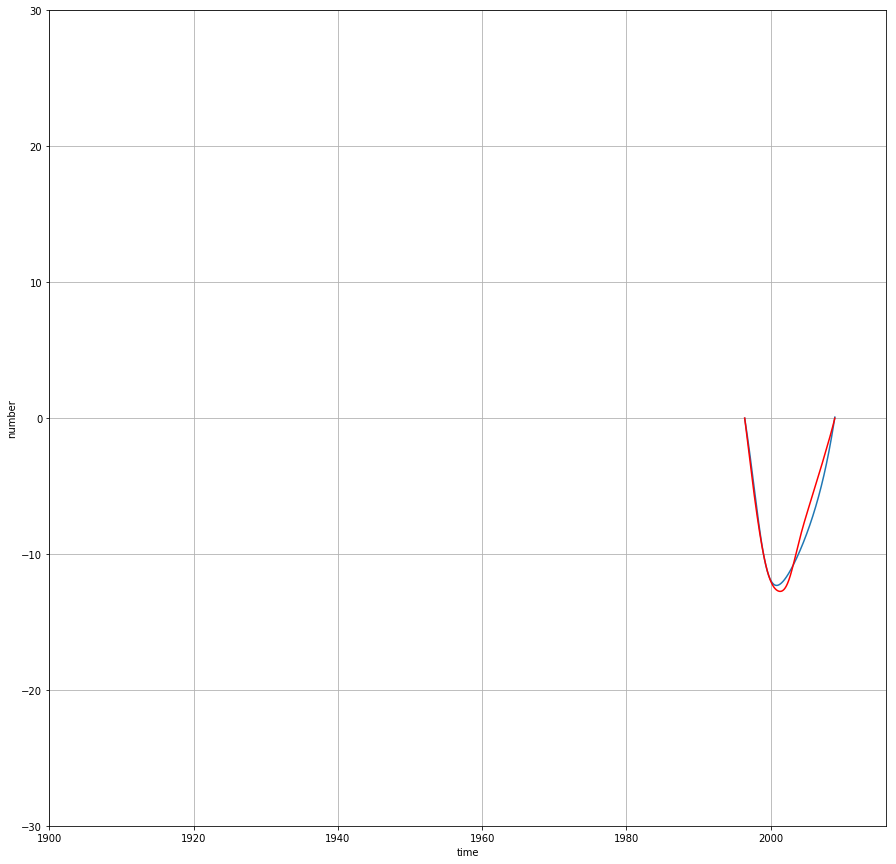

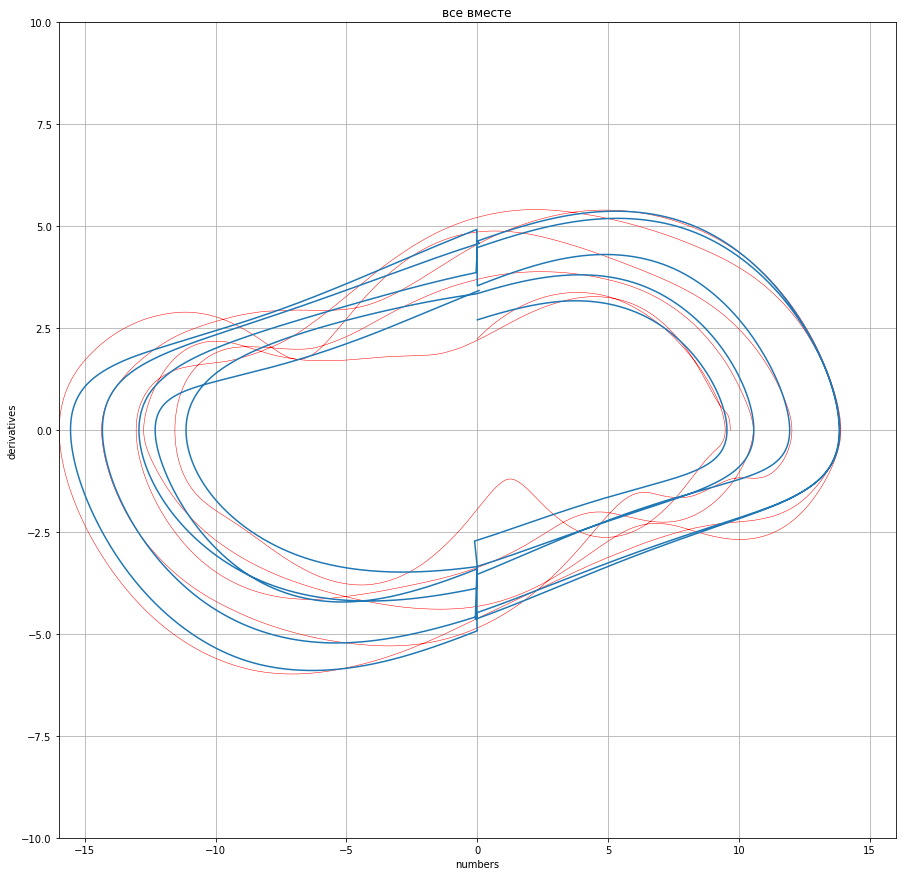

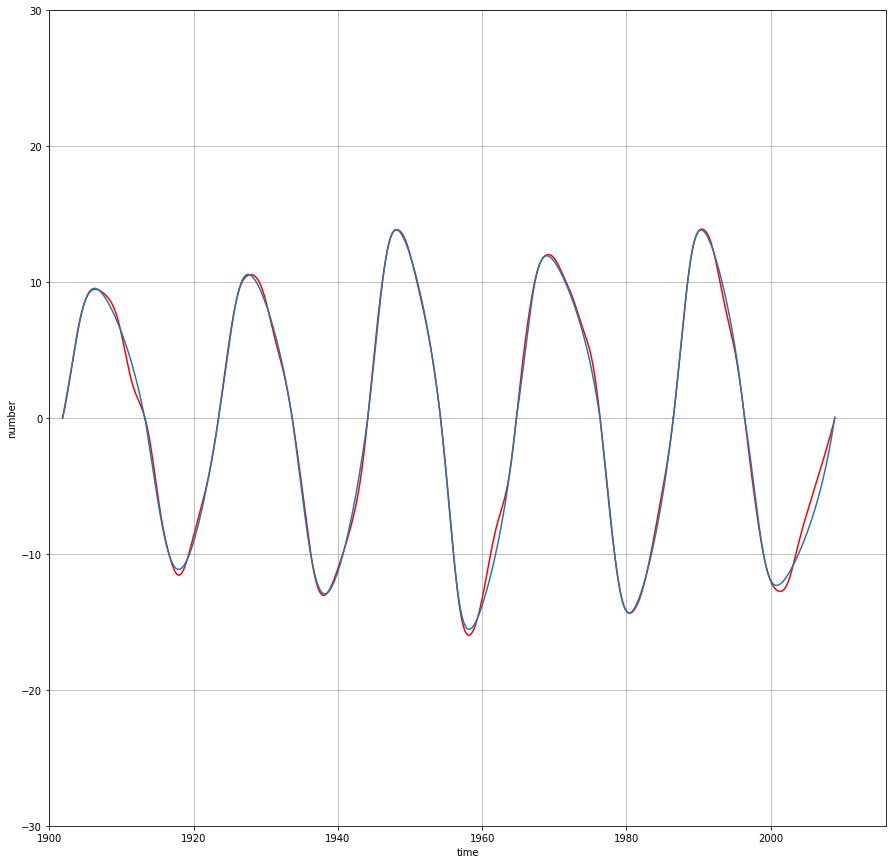

In [96]:
close_period_reg_approx_param = cycles_approx_with_close_period(reg_difference,
                                                                      portraits,
                                                                      smoothed_data,
                                                                      cycles, reg_approx_param)

## Получение приближения близкого по периоду с функцией ошибки равной интегралу для исходных данных

mistake = 3.239644979941926
lamda = 0.000291
mu = 0.1869
eps = 0.0436
omega = 0.2458


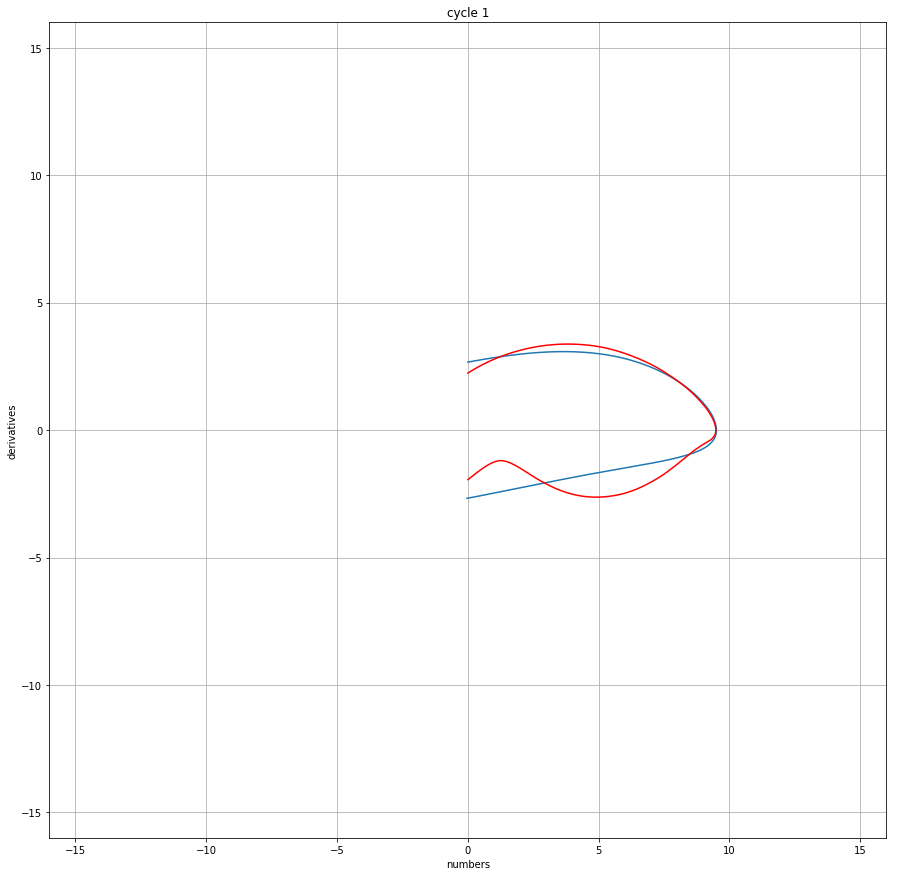

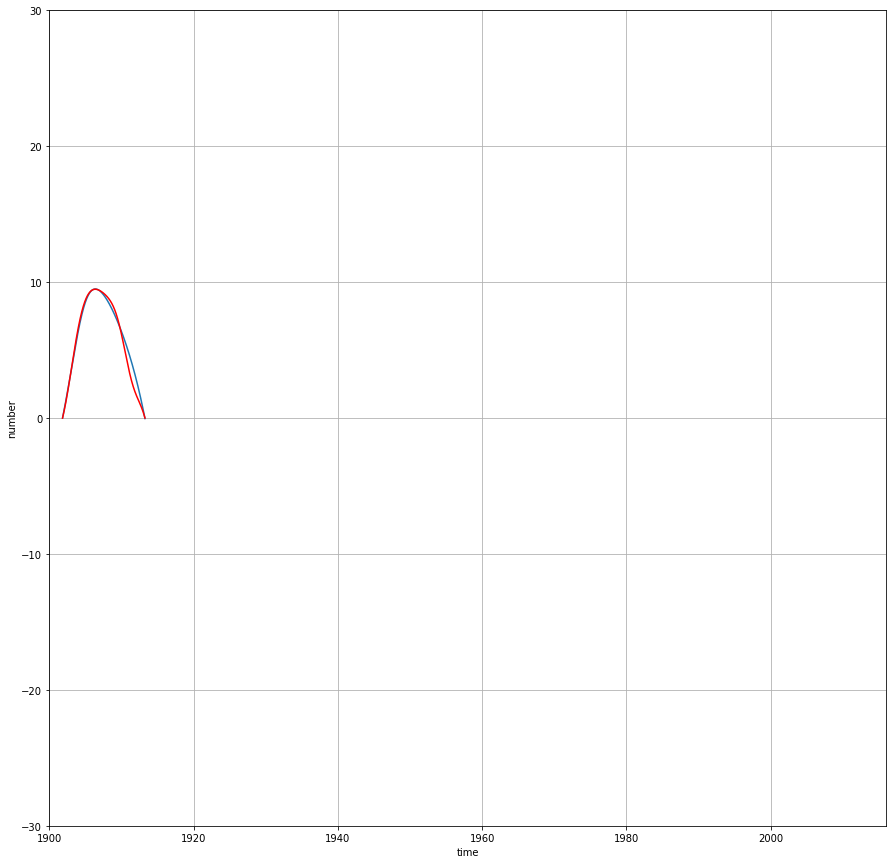

mistake = 0.9336769075877153
lamda = 0.000275
mu = 0.0794
eps = 0.0316
omega = 0.2655


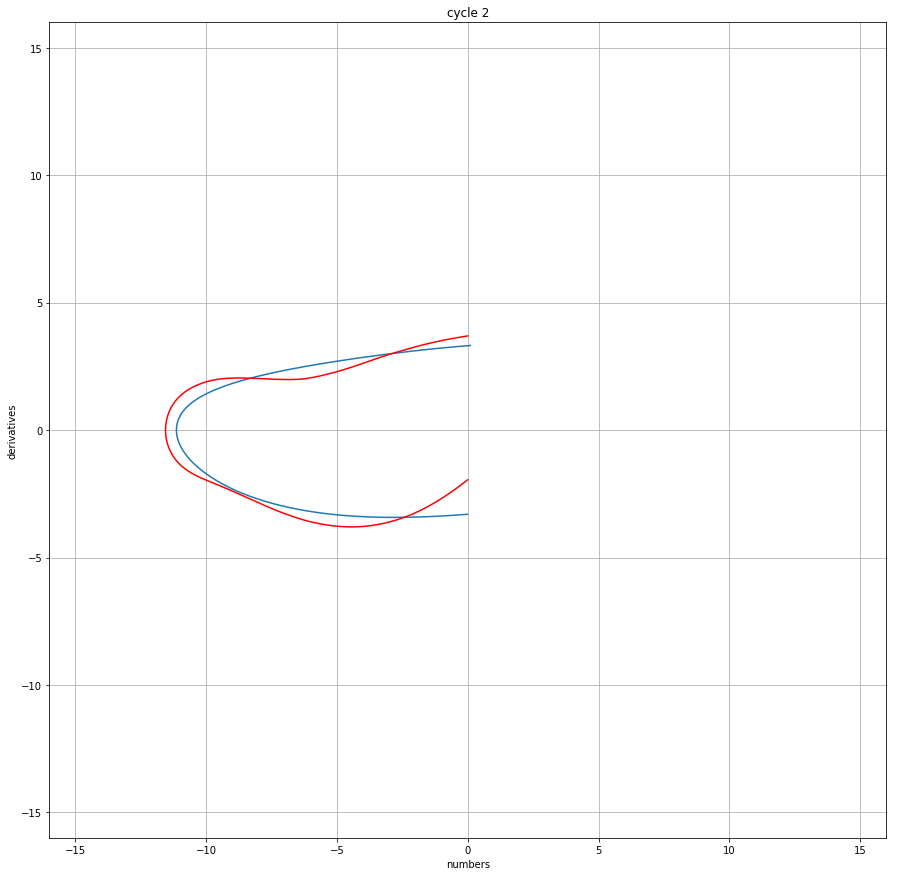

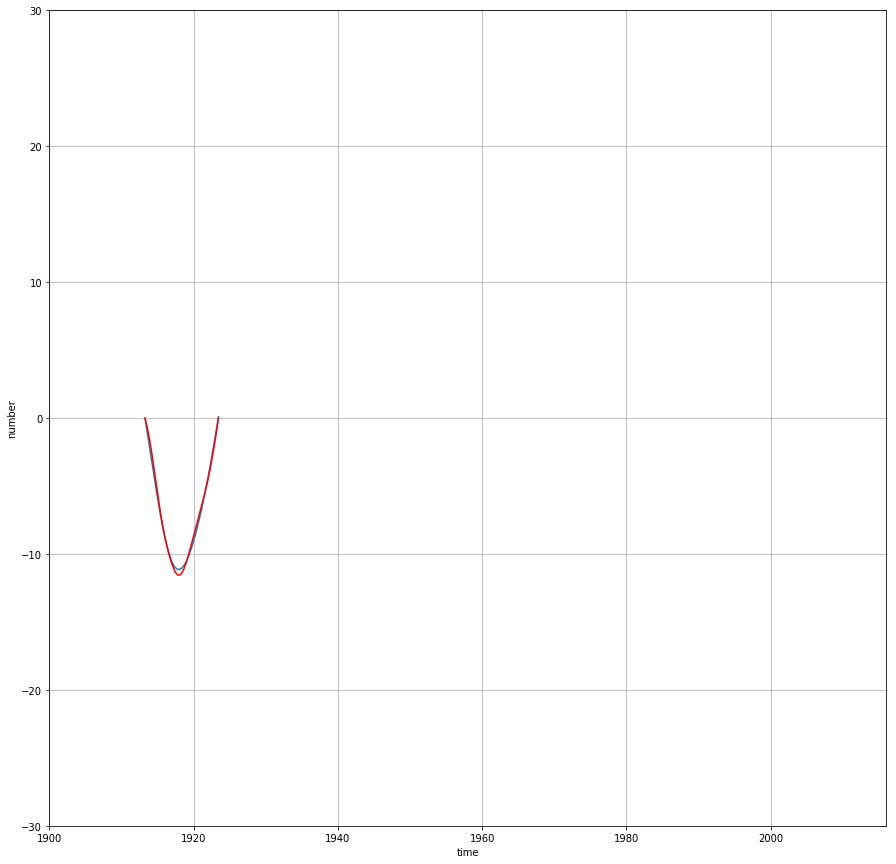

mistake = 0.4177633546630129
lamda = 0.000198
mu = 0.1898
eps = 0.0349
omega = 0.2866


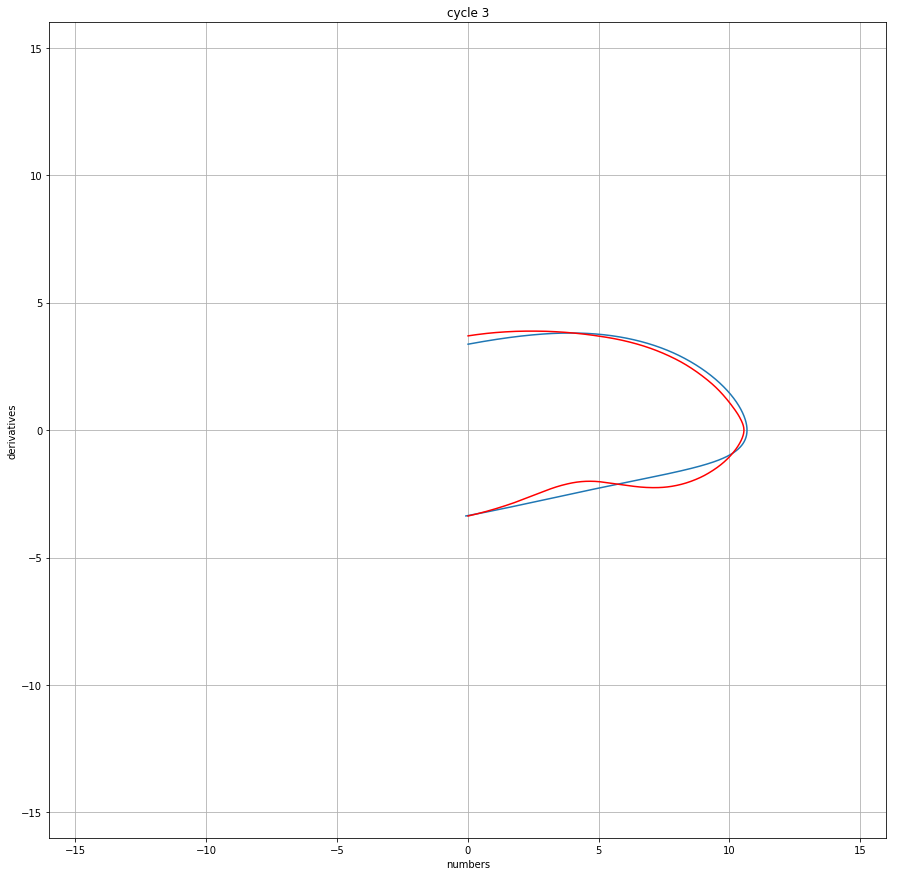

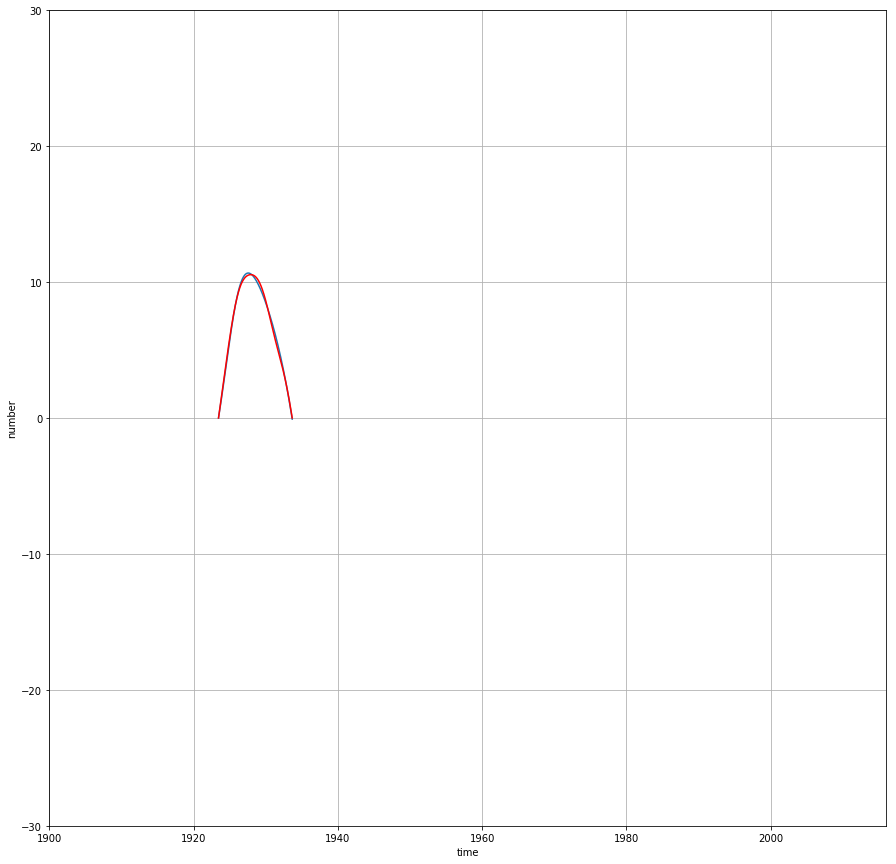

mistake = 1.6867191253838176
lamda = 0.000126
mu = 0.1485
eps = 0.0235
omega = 0.2771


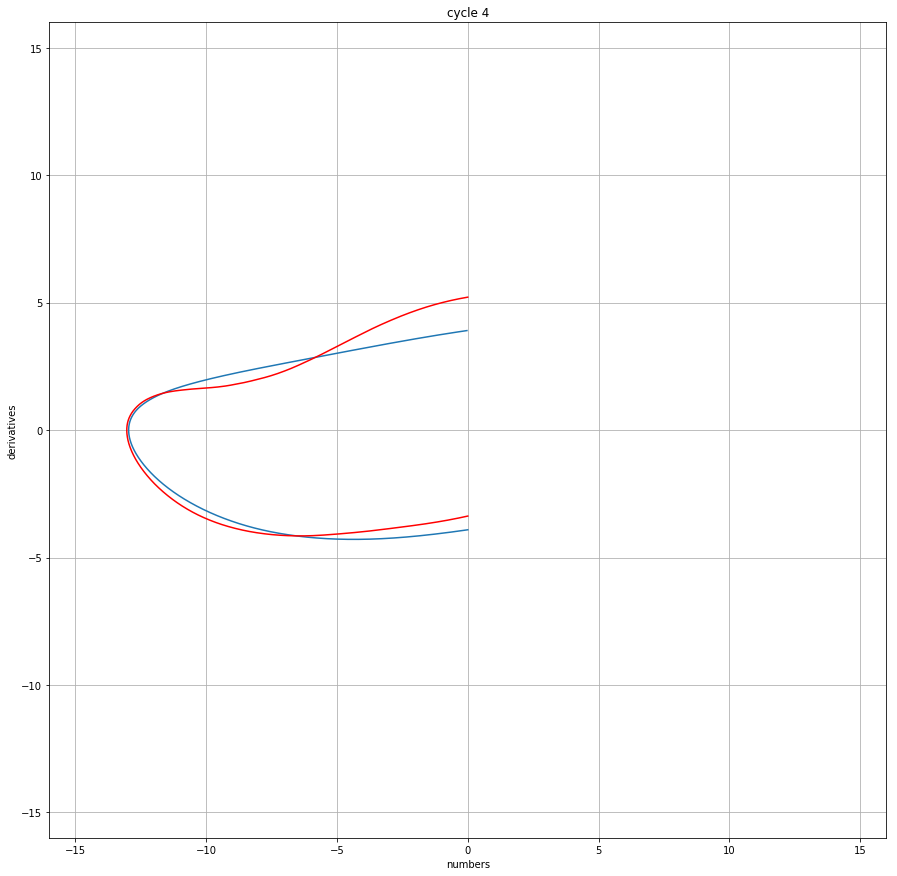

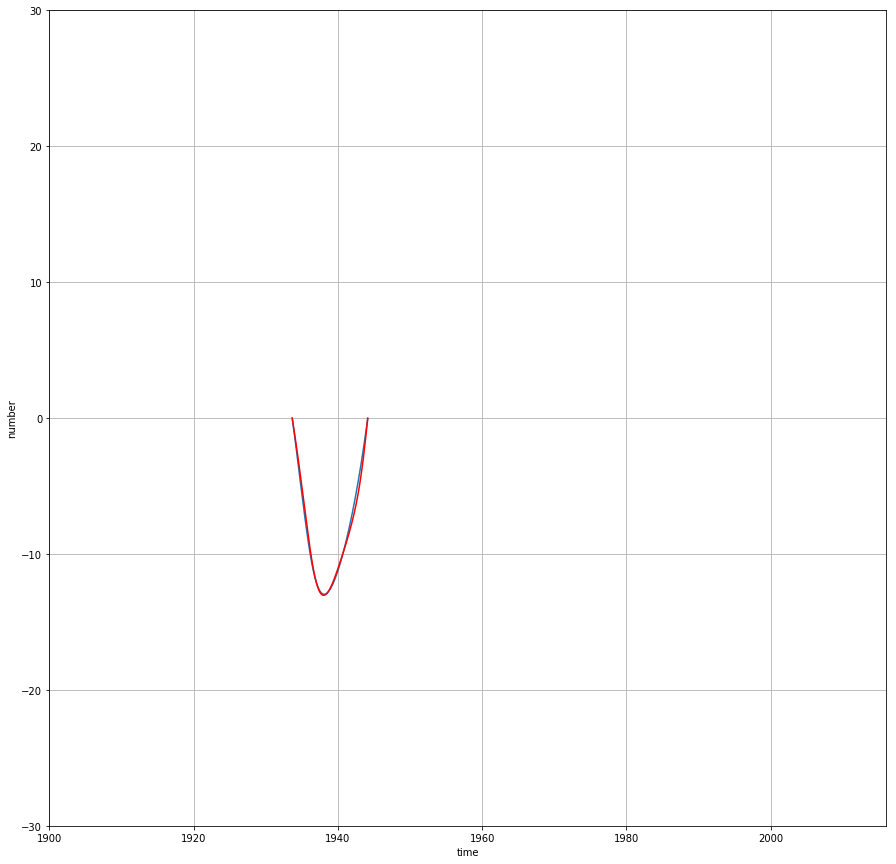

mistake = 0.21282058780647076
lamda = 0.000135
mu = 0.232
eps = 0.0204
omega = 0.2893


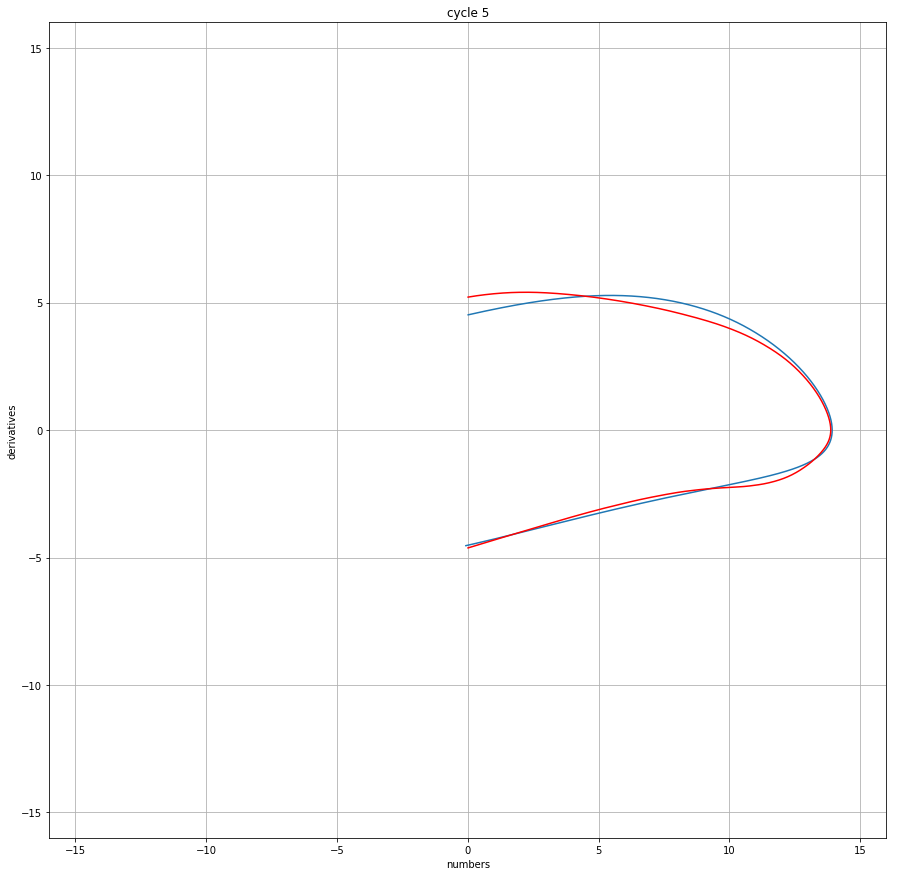

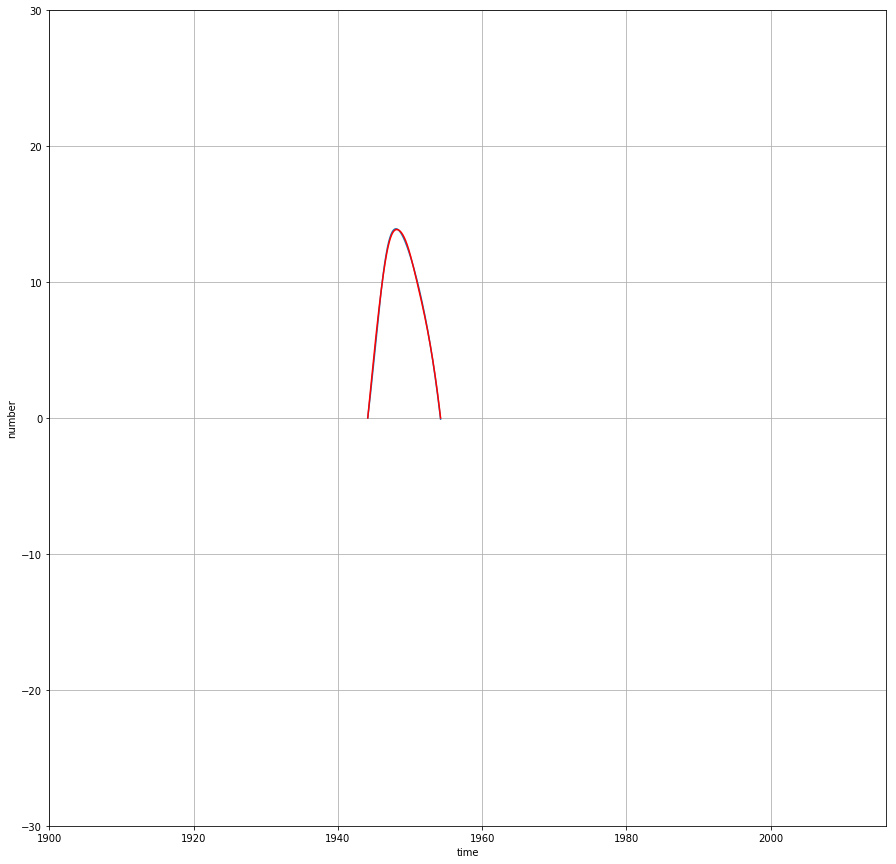

mistake = 4.715814560193886
lamda = 9e-05
mu = 0.3068
eps = 0.0175
omega = 0.2911


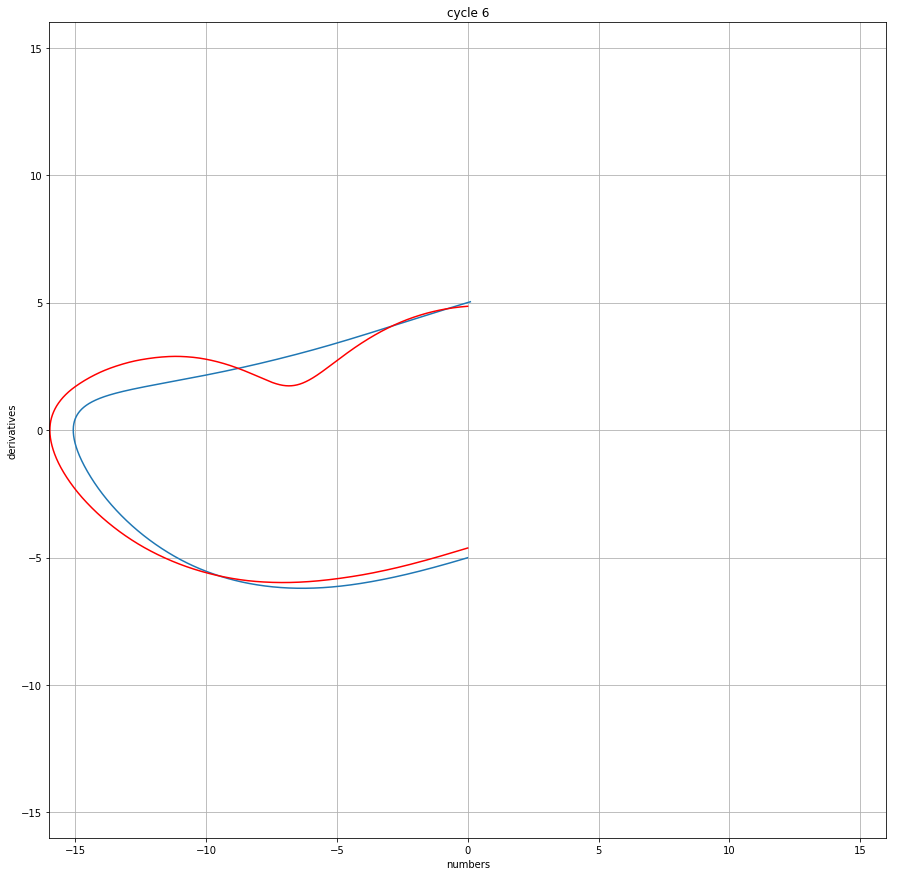

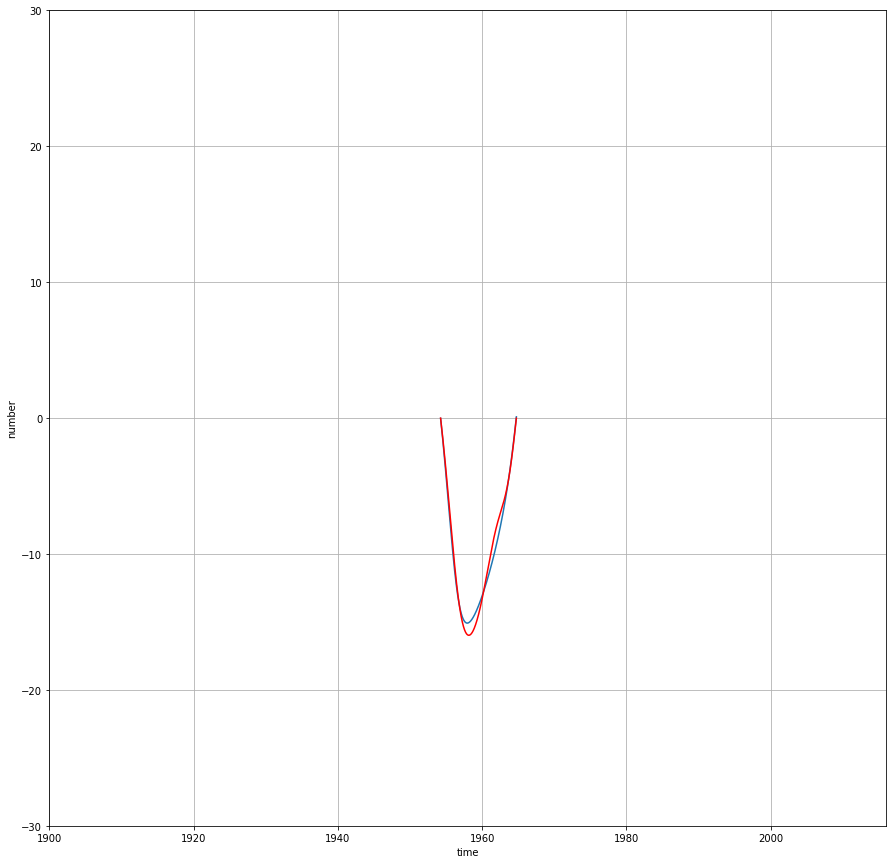

mistake = 1.5615998411316434
lamda = 0.000136
mu = 0.2928
eps = 0.0269
omega = 0.2605


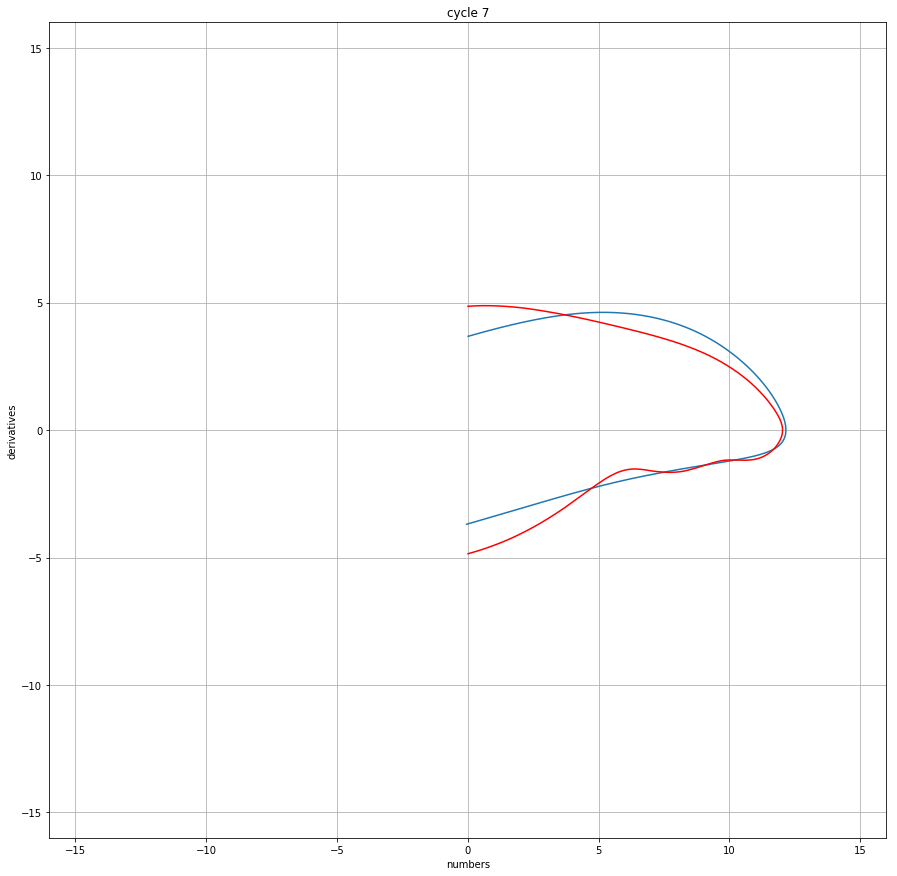

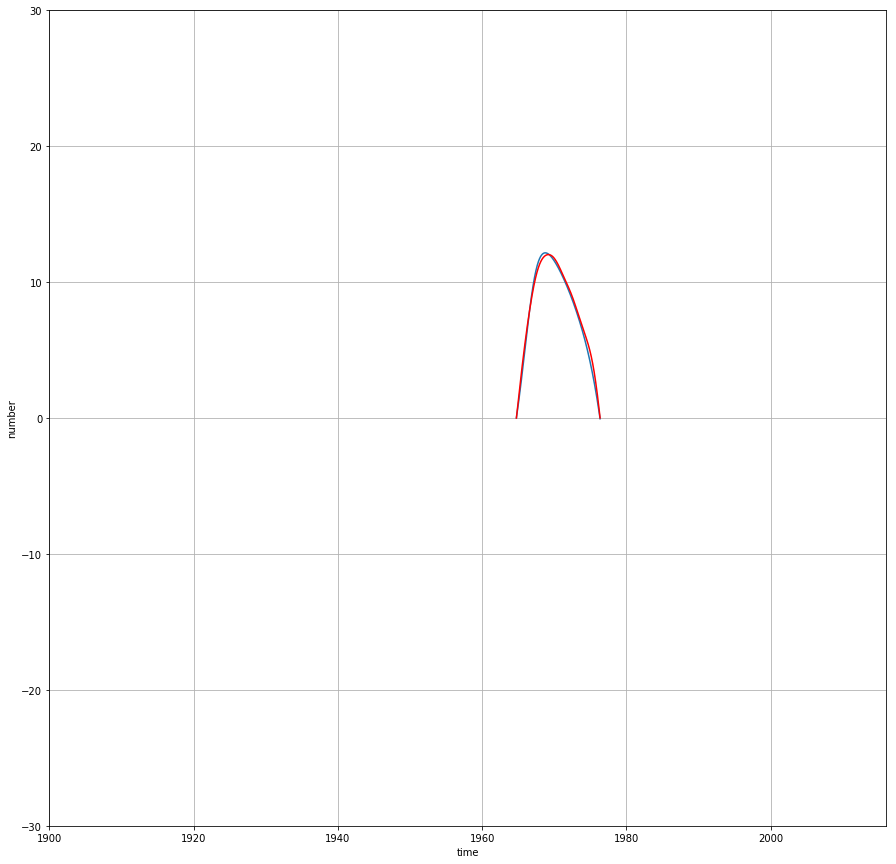

mistake = 0.5240428782307742
lamda = 0.000115
mu = 0.2079
eps = 0.0193
omega = 0.2891


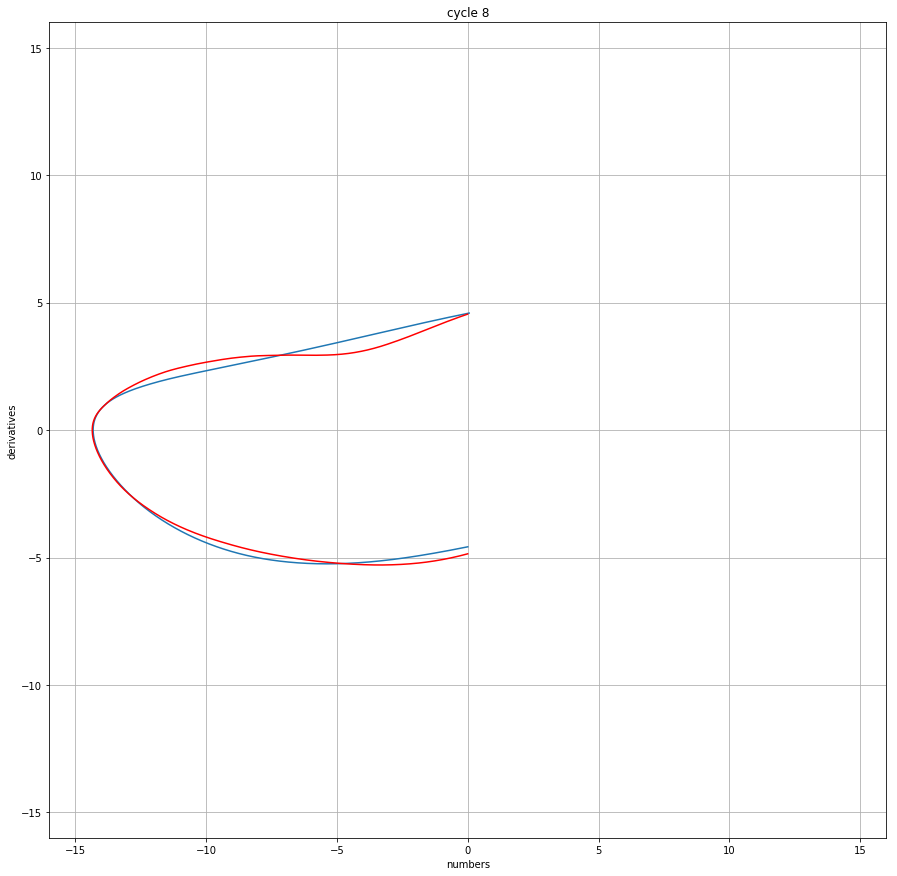

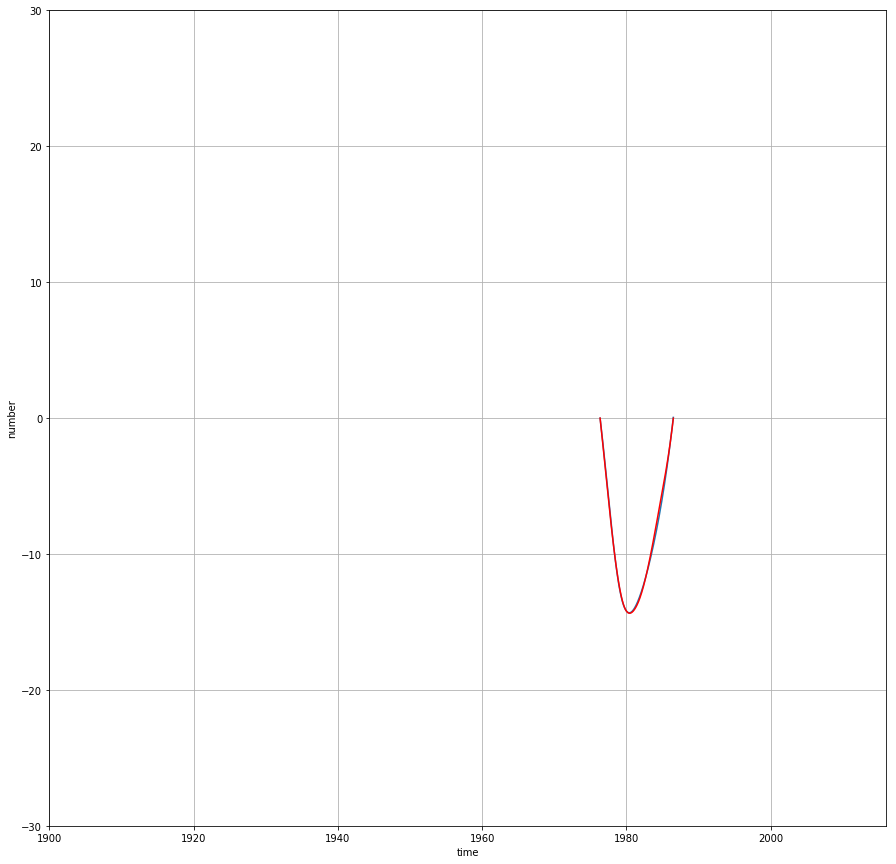

mistake = 0.8131583251876546
lamda = 0.000184
mu = 0.2553
eps = 0.0209
omega = 0.2881


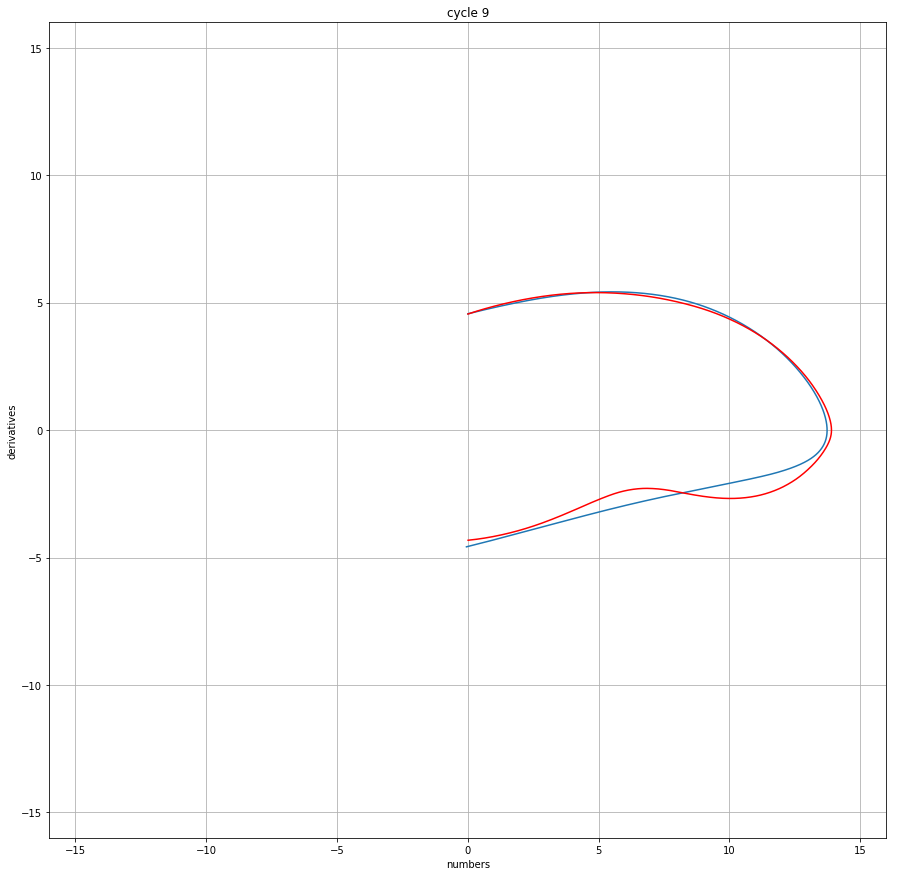

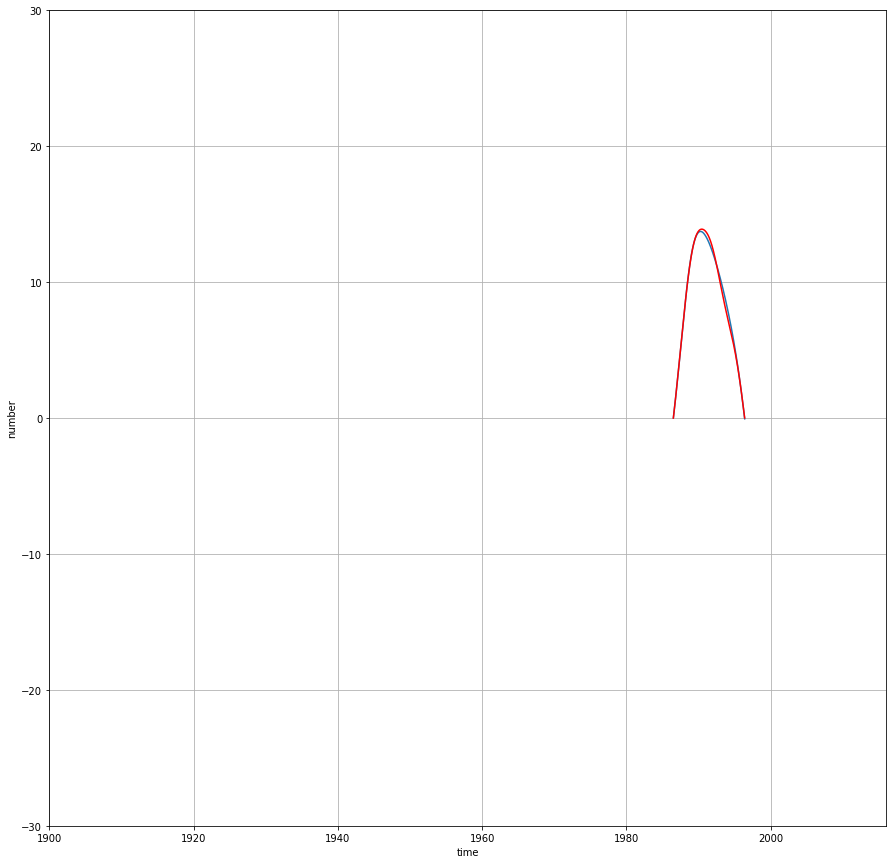

mistake = 8.305919027850301
lamda = 0.000128
mu = 0.2815
eps = 0.0276
omega = 0.2414


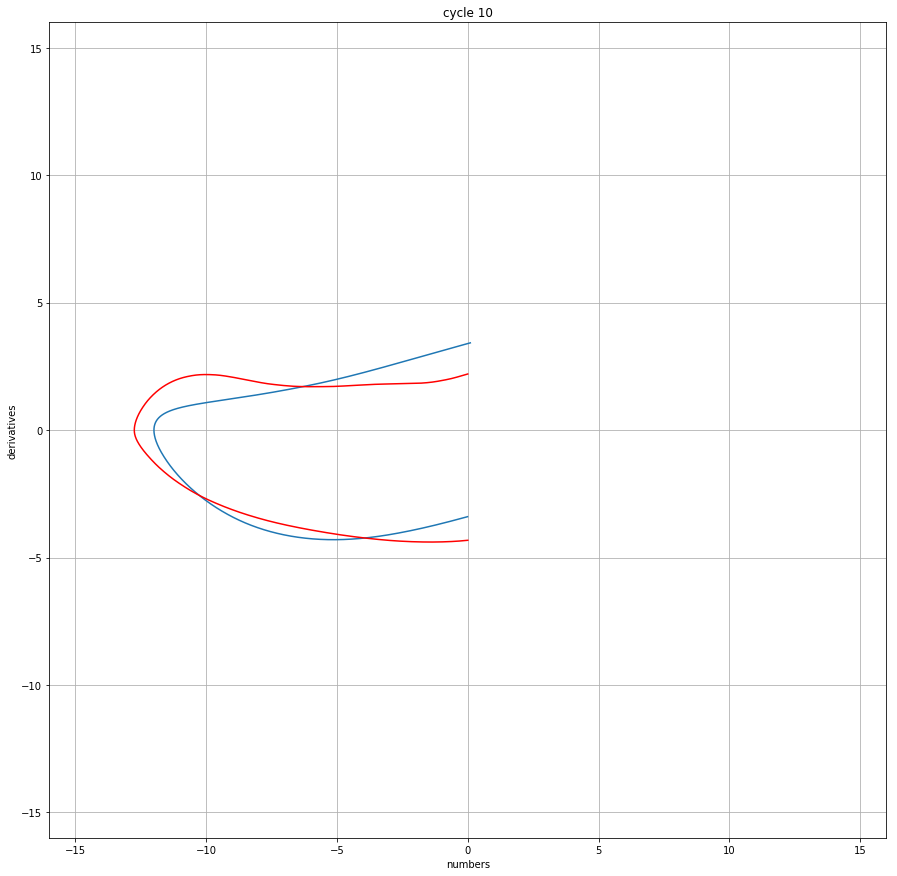

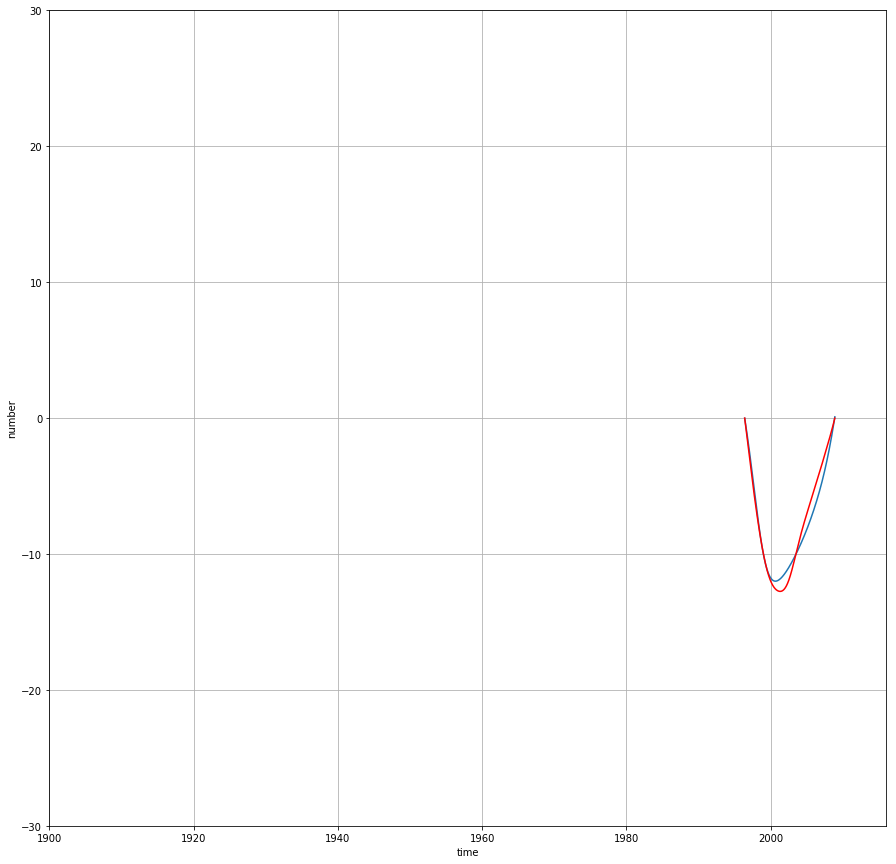

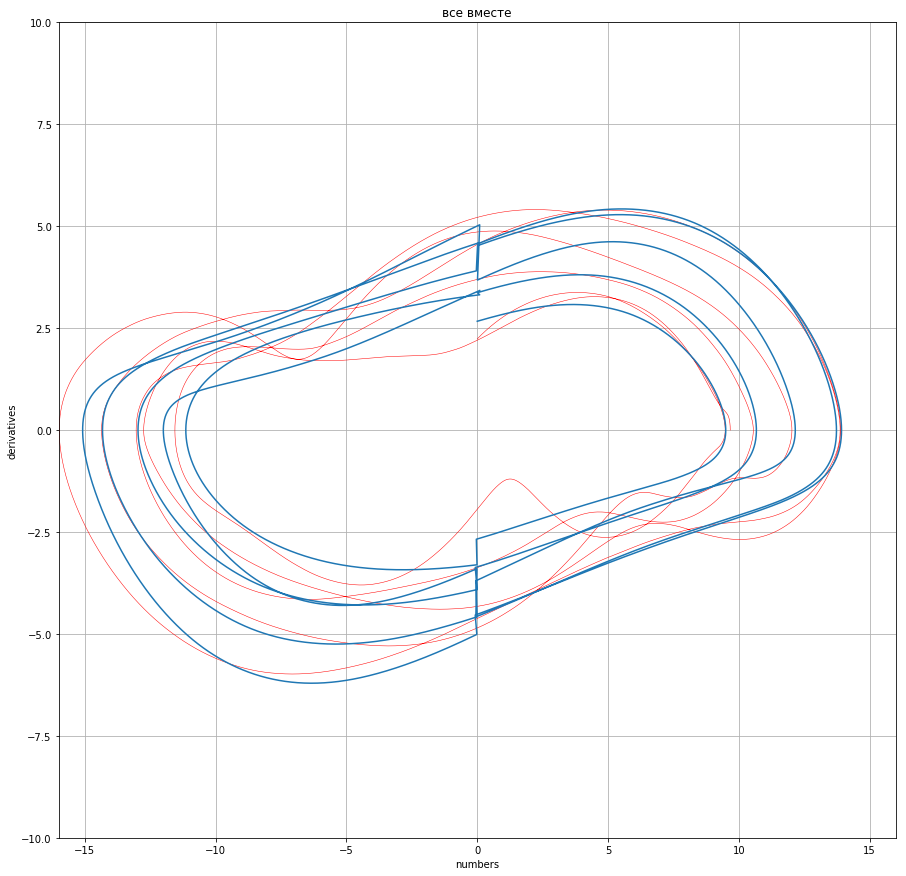

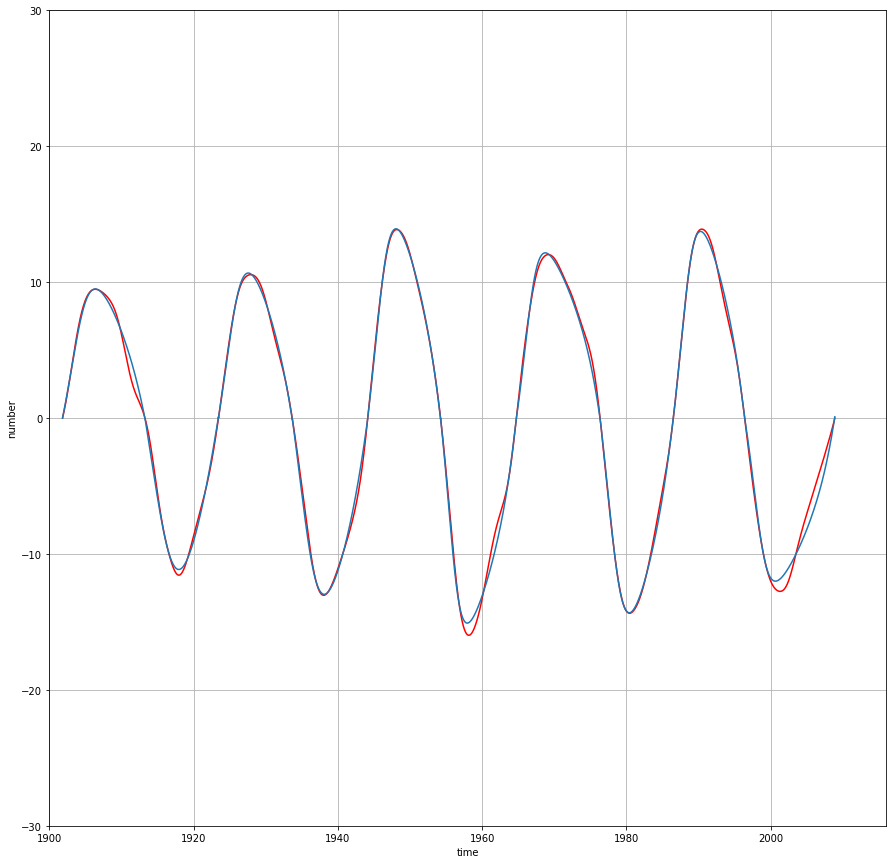

In [97]:
close_period_integral_approx_param = cycles_approx_with_close_period(integral_difference,
                                                                      portraits,
                                                                      smoothed_data,
                                                                      cycles, integral_approx_param)

## Составление таблиц данных о приближении 3

In [98]:
close_period_reg_approx_param_table = np.concatenate((ap_table, close_period_reg_approx_param), axis=1)
close_period_integral_approx_param_table = np.concatenate((ap_table, close_period_integral_approx_param),
                                                            axis=1)

## Получение приближения близкого по периоду с функцией ошибки равной среднему расстоянию для 'новых' данных

mistake = 0.58619278298181
lamda = 0.000262
mu = 0.1148
eps = 0.0426
omega = 0.2463


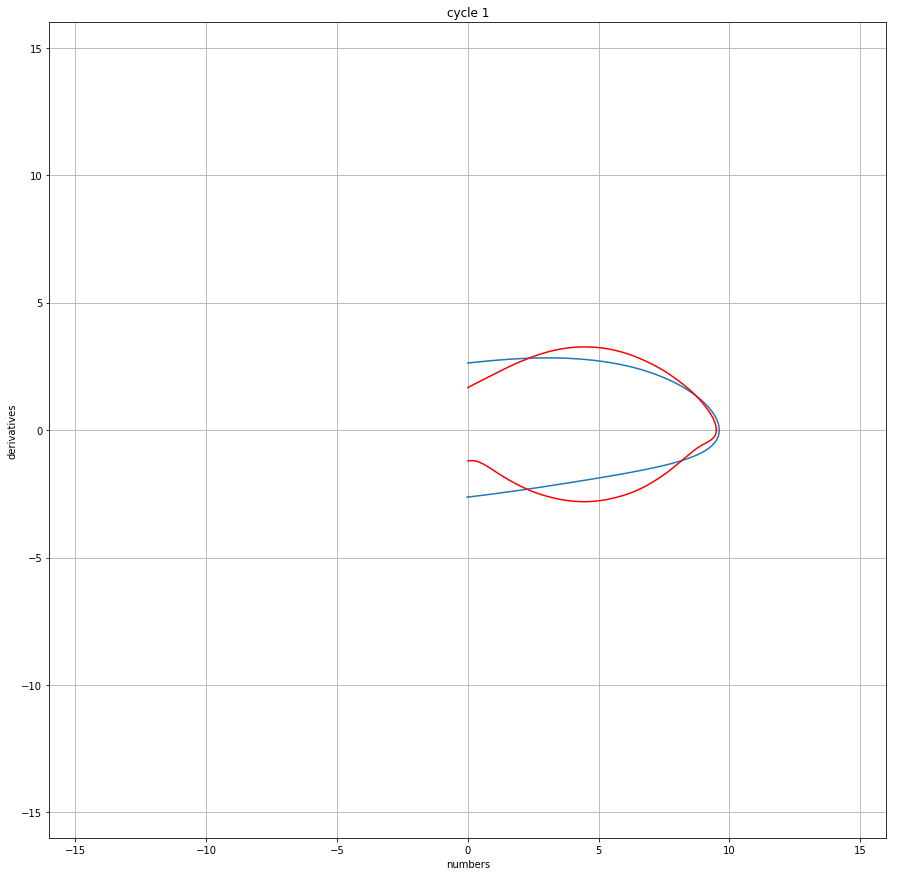

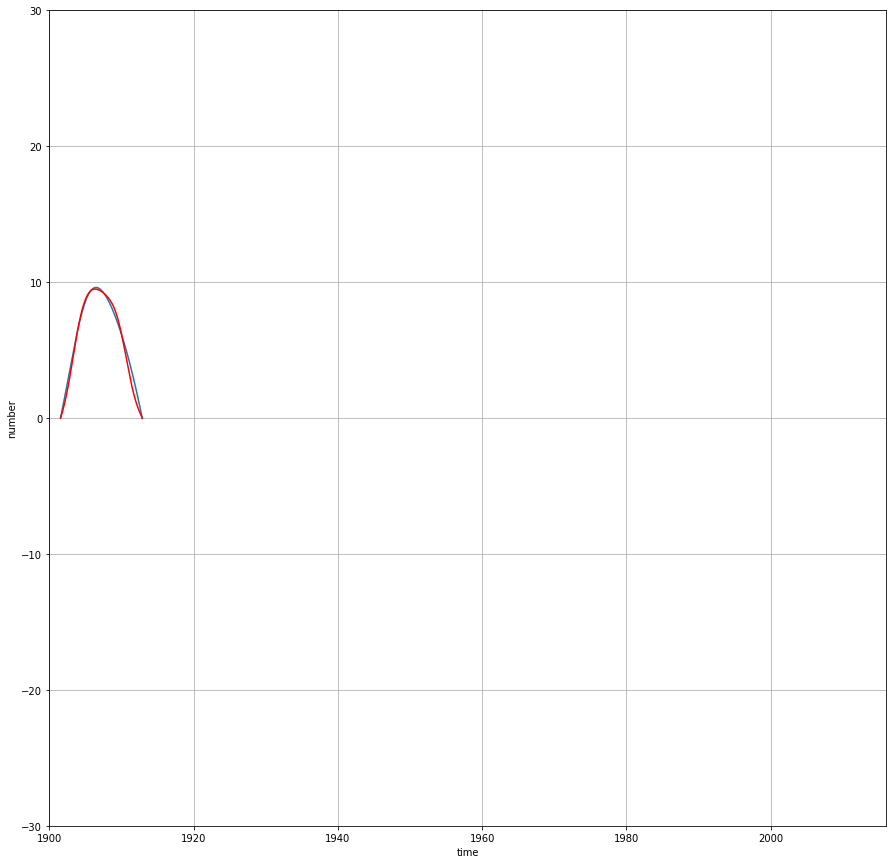

mistake = 0.6060626915427725
lamda = 0.000527
mu = 0.0408
eps = 0.0309
omega = 0.2038


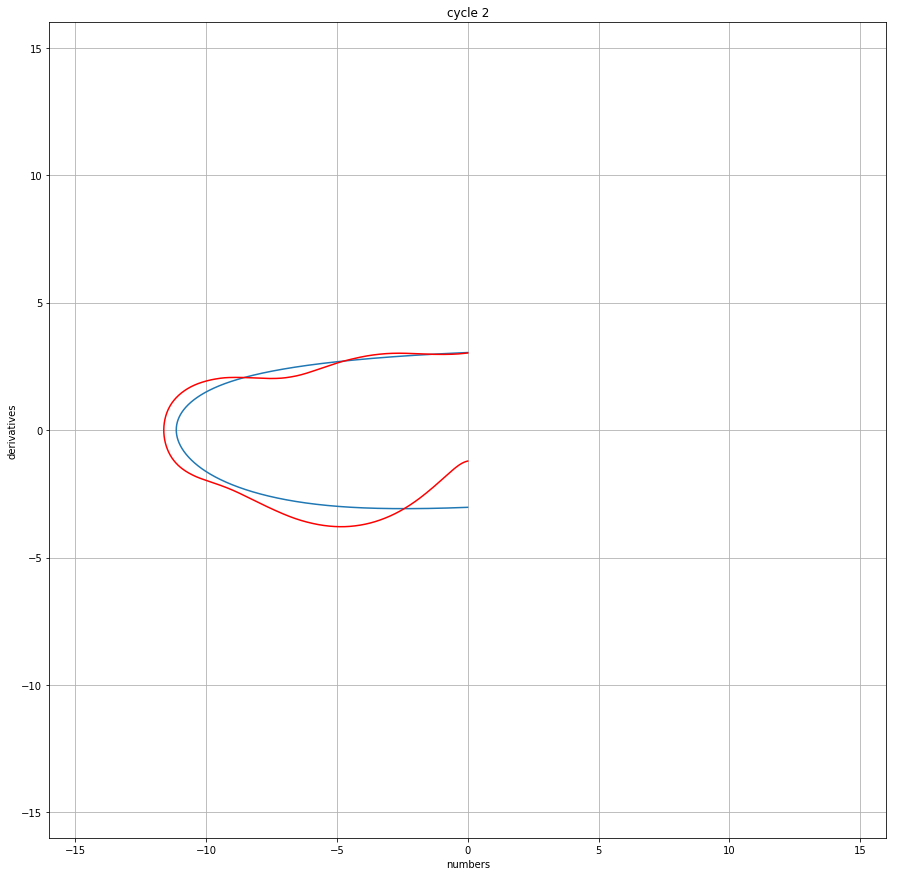

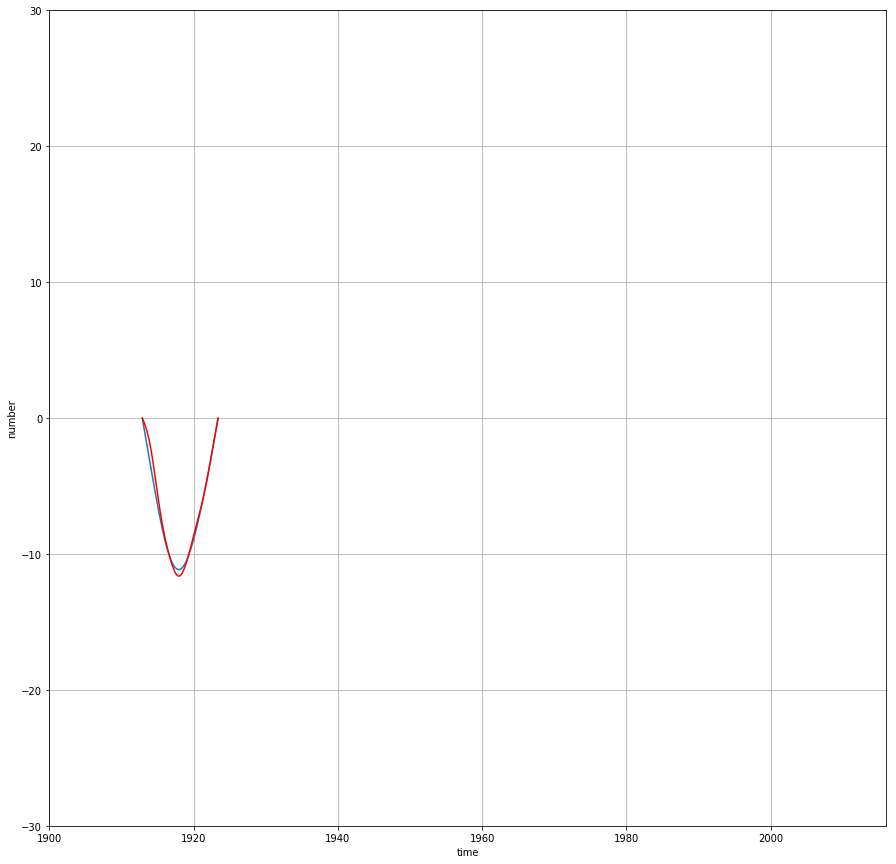

mistake = 0.3557955735774425
lamda = 0.000175
mu = 0.1663
eps = 0.0352
omega = 0.2876


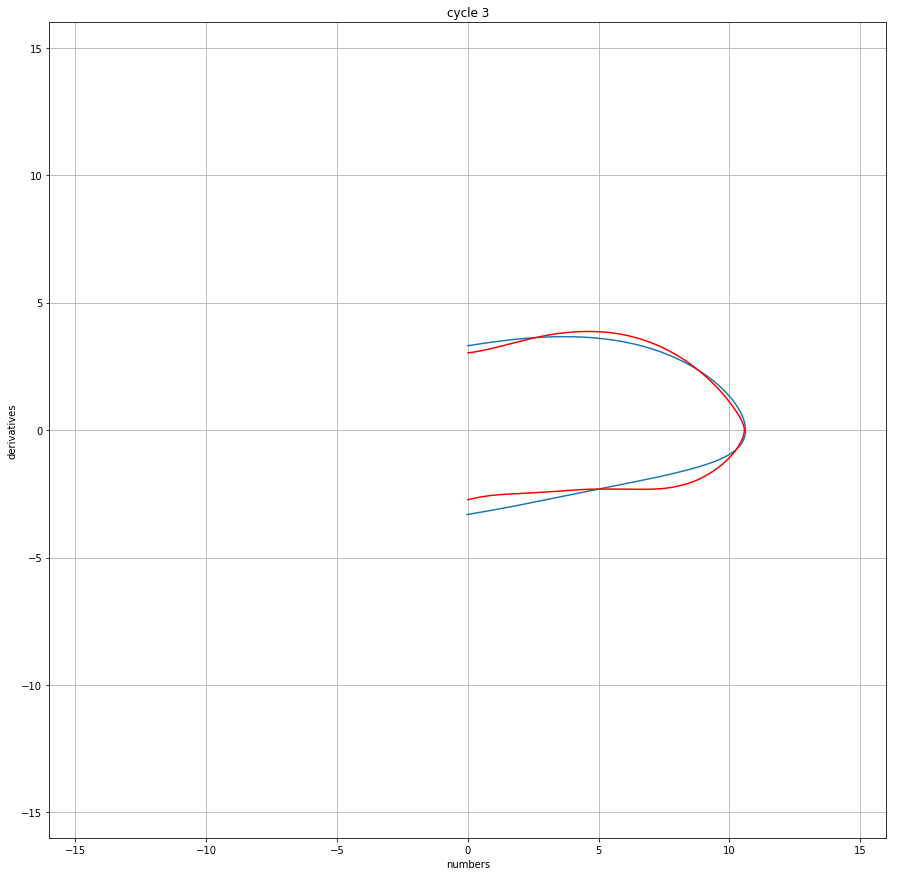

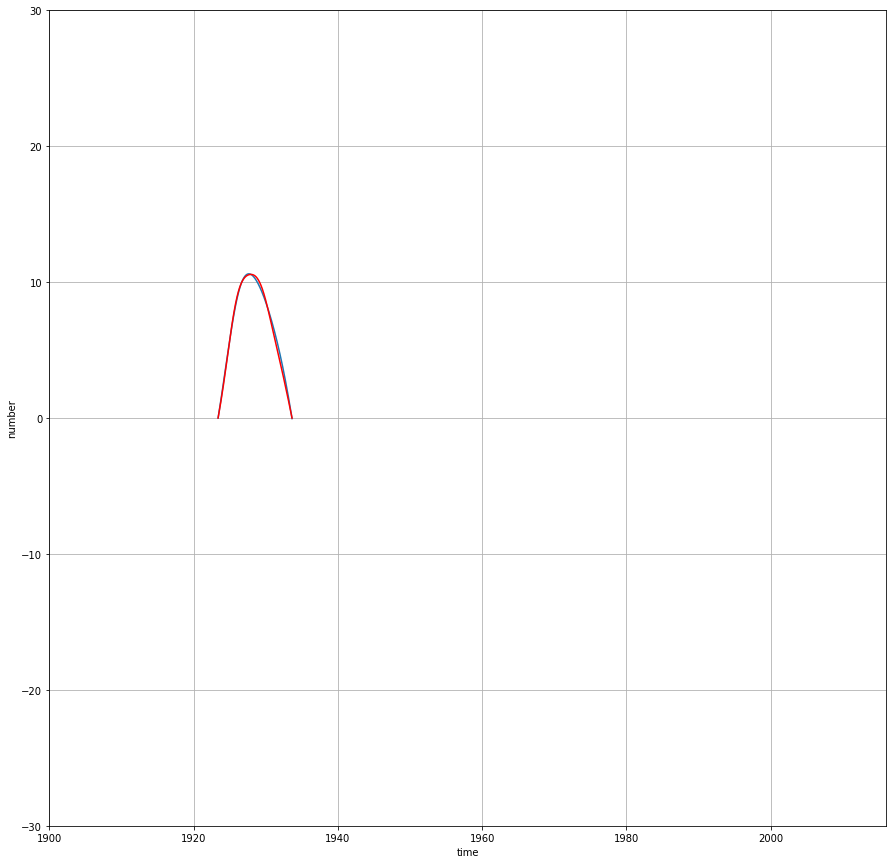

mistake = 0.567316925254328
lamda = 0.000158
mu = 0.116
eps = 0.0232
omega = 0.2735


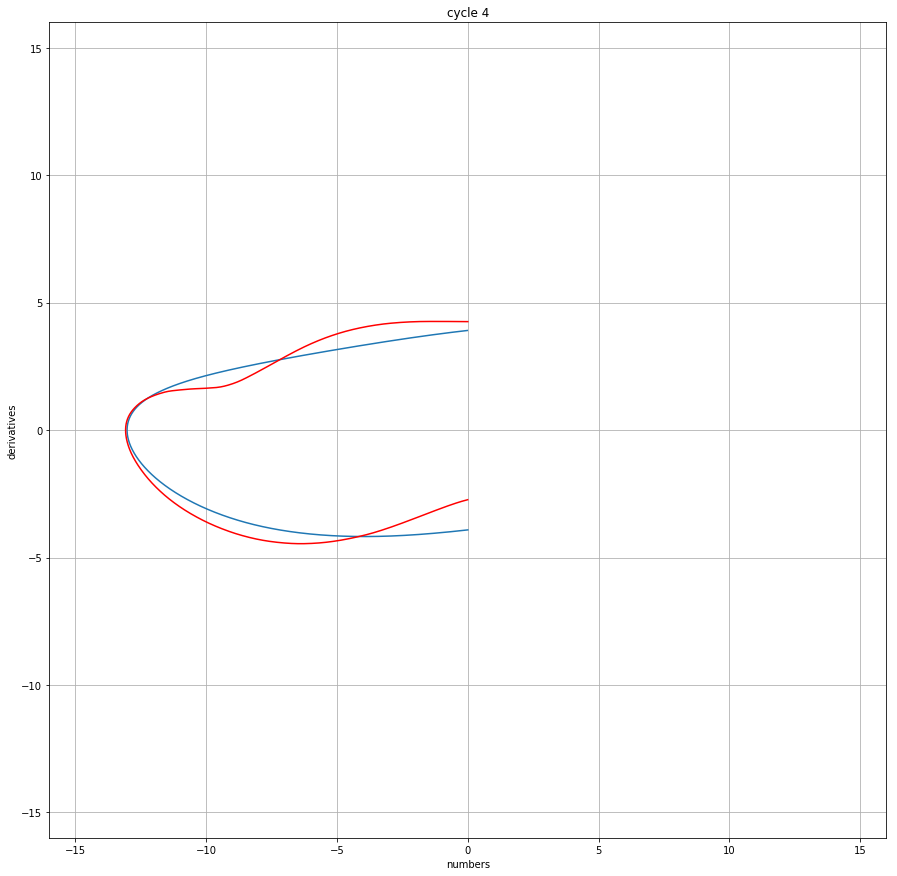

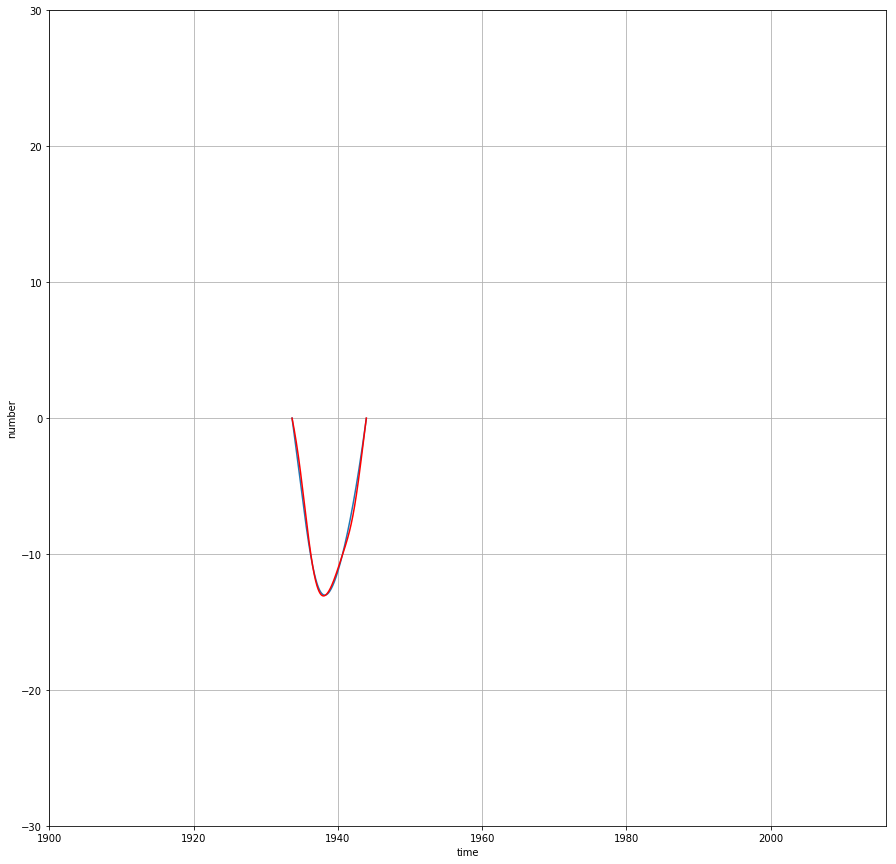

mistake = 0.2607611844590834
lamda = 0.000103
mu = 0.1537
eps = 0.0205
omega = 0.2864


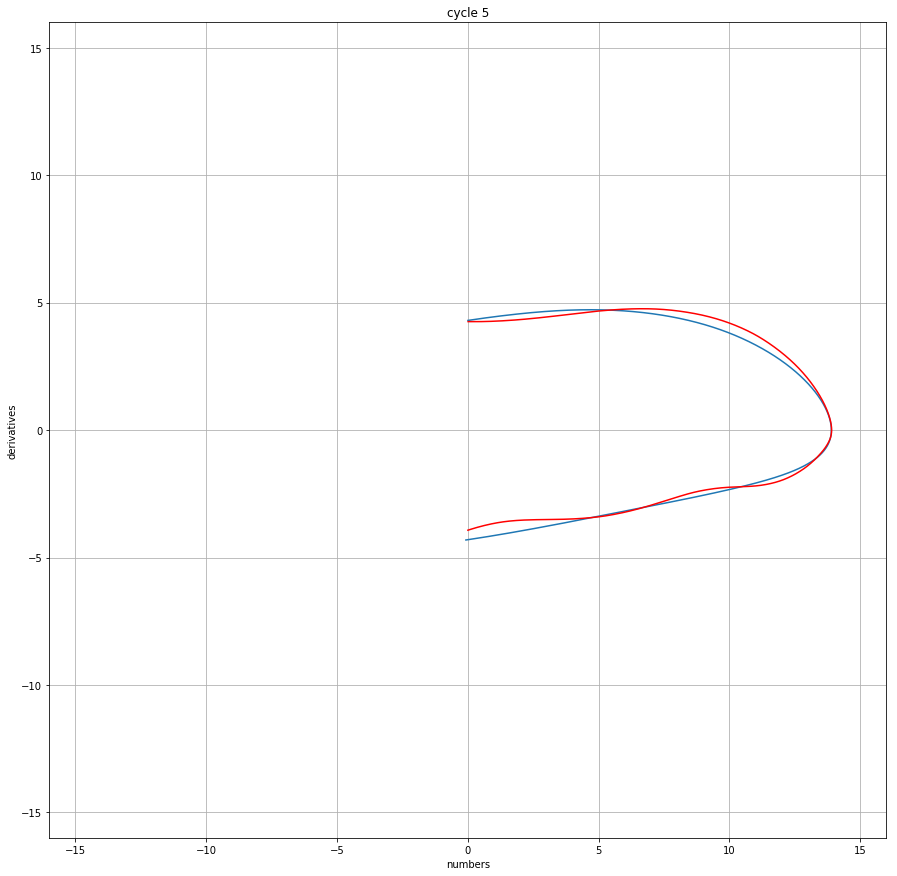

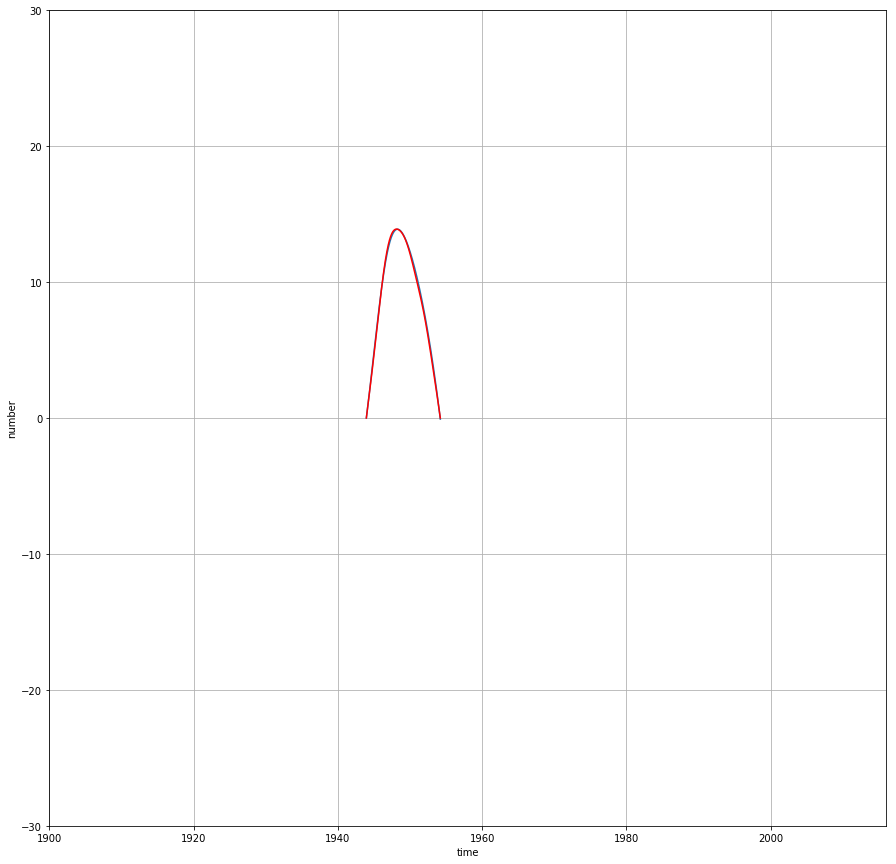

mistake = 0.9803364145247673
lamda = 0.00011
mu = 0.2644
eps = 0.0169
omega = 0.2765


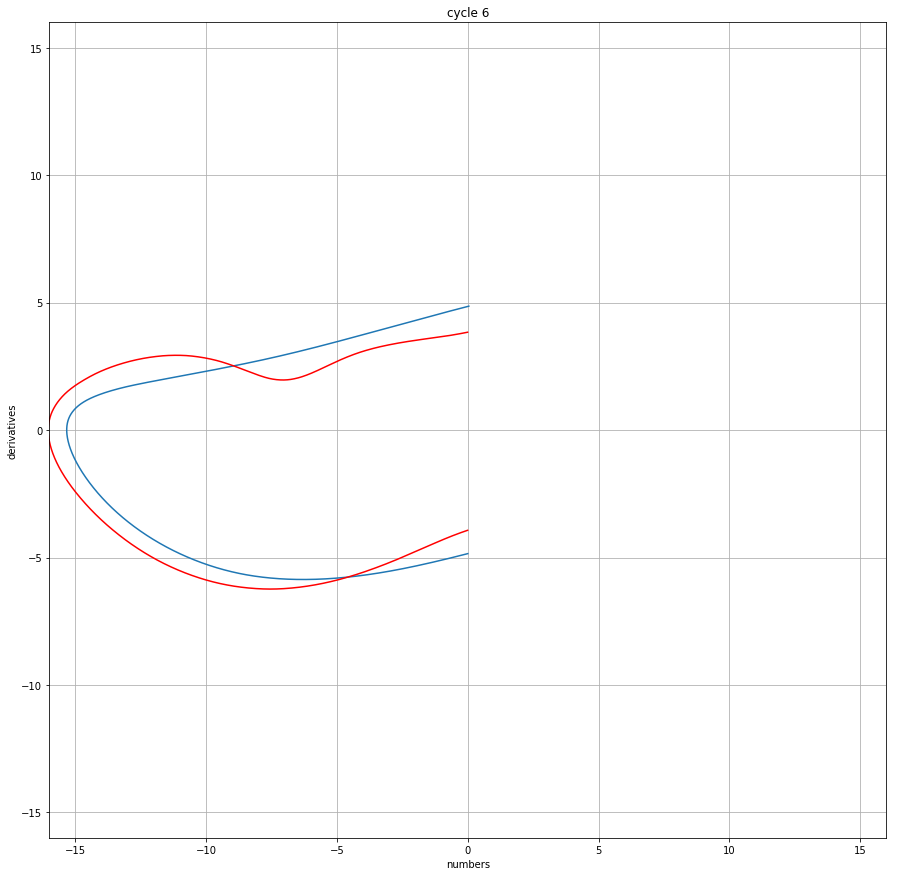

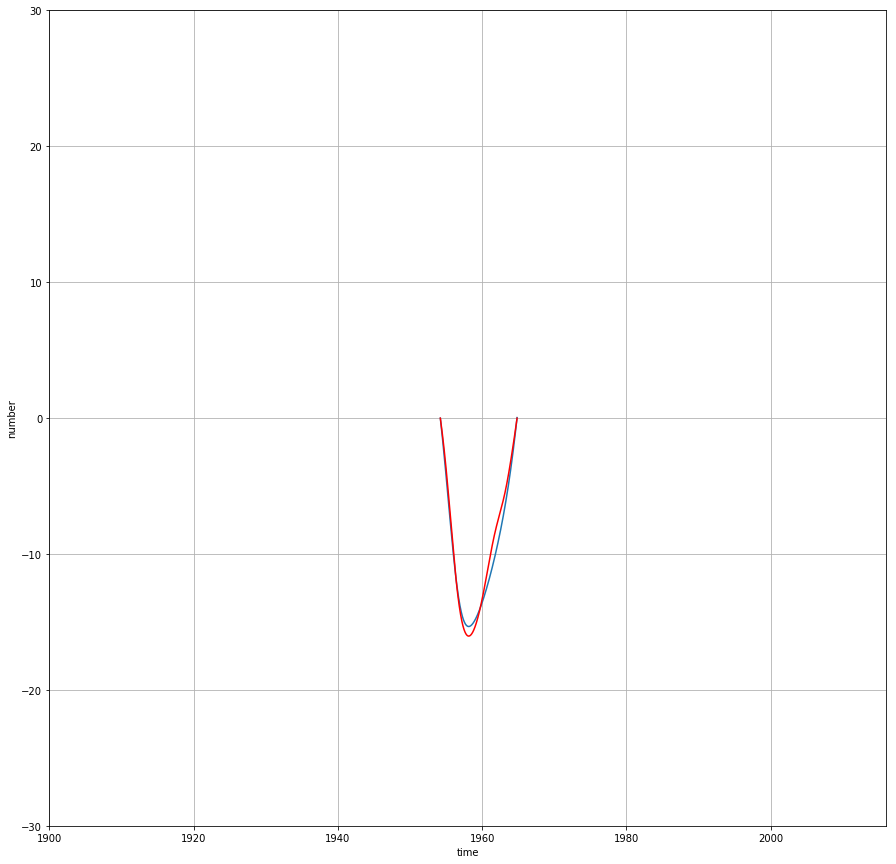

mistake = 0.29246485476364303
lamda = 0.000231
mu = 0.2854
eps = 0.0262
omega = 0.2448


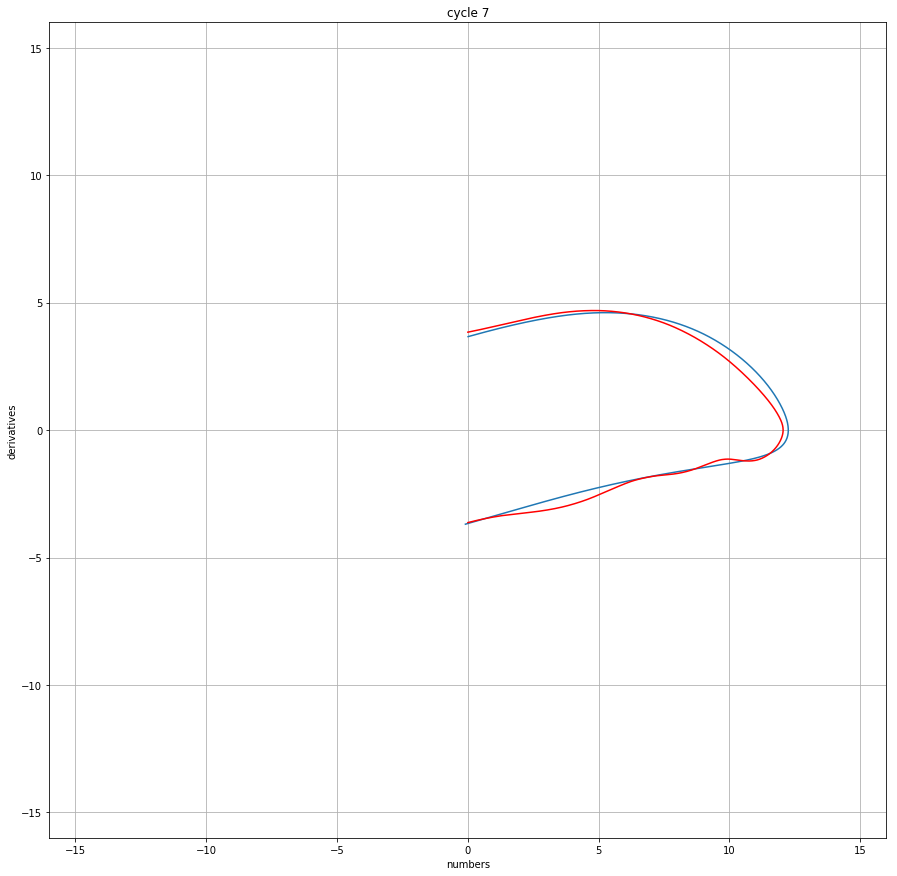

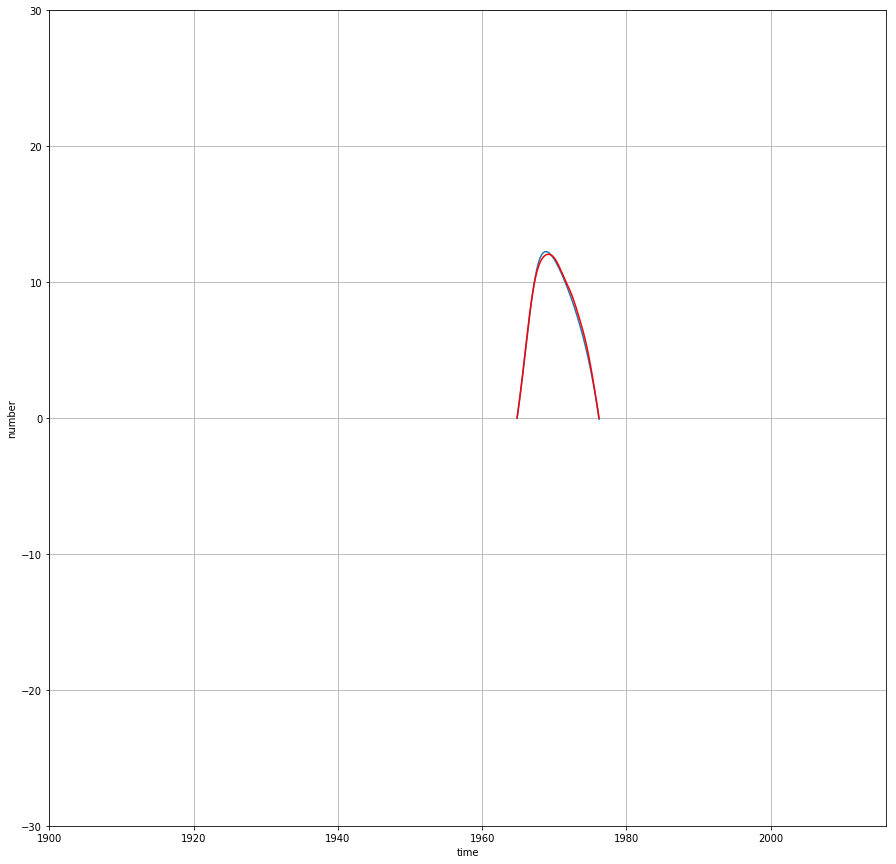

mistake = 0.30581186939438415
lamda = 0.000335
mu = 0.1495
eps = 0.018
omega = 0.2212


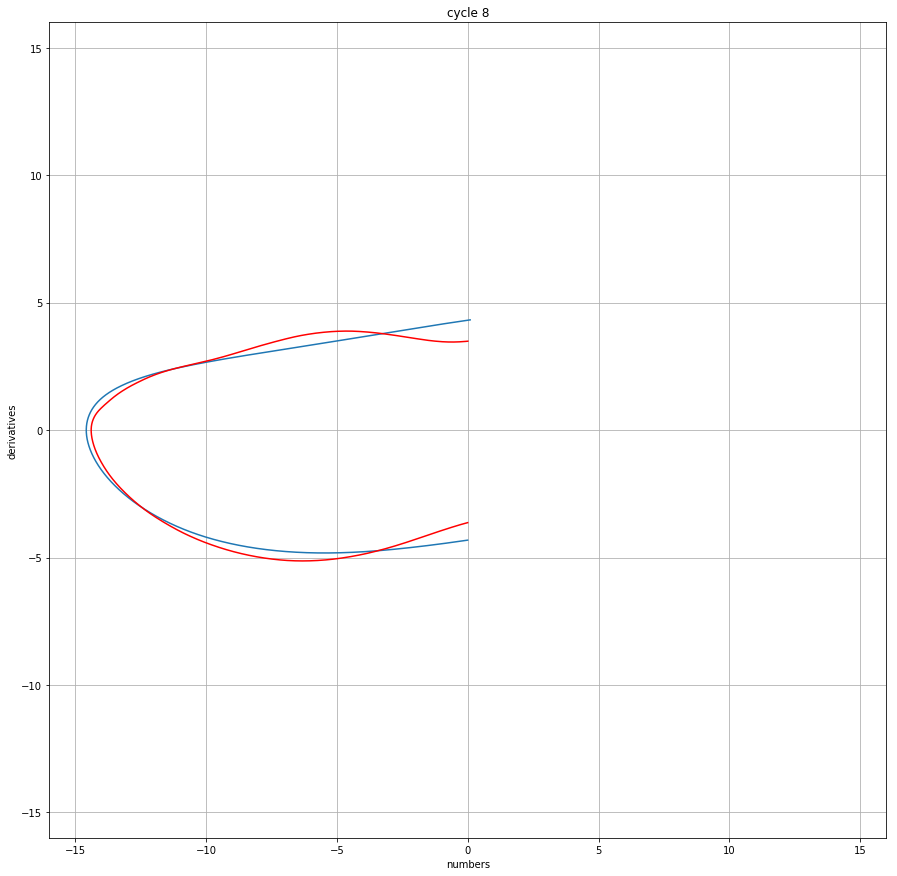

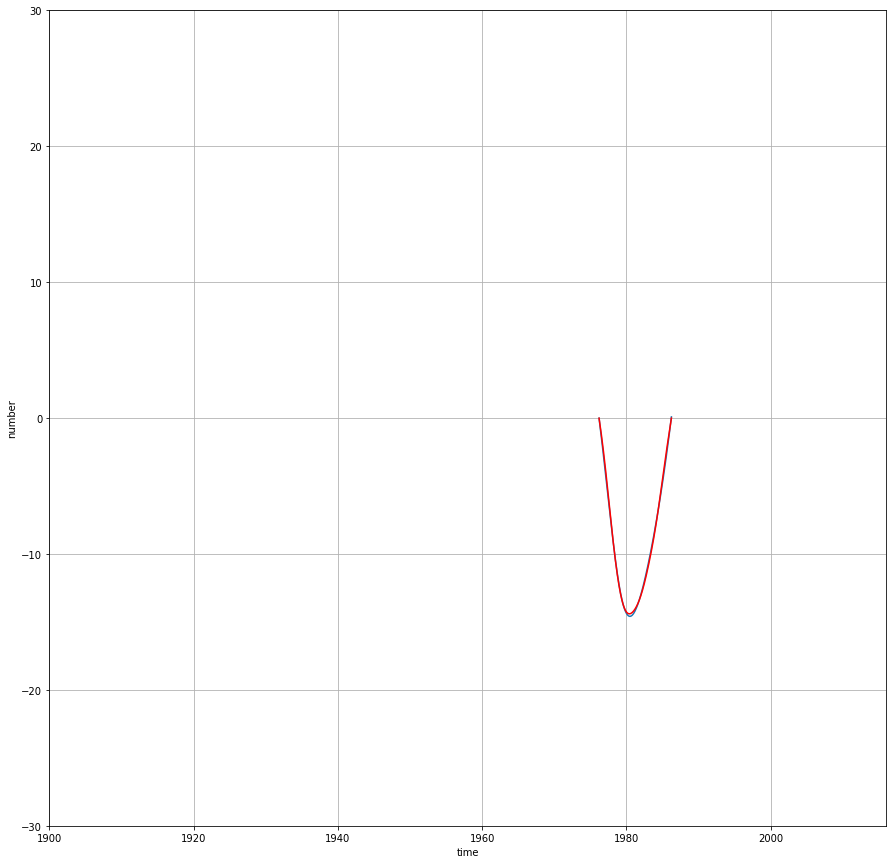

mistake = 0.6230414228696303
lamda = 0.000125
mu = 0.1595
eps = 0.0206
omega = 0.2826


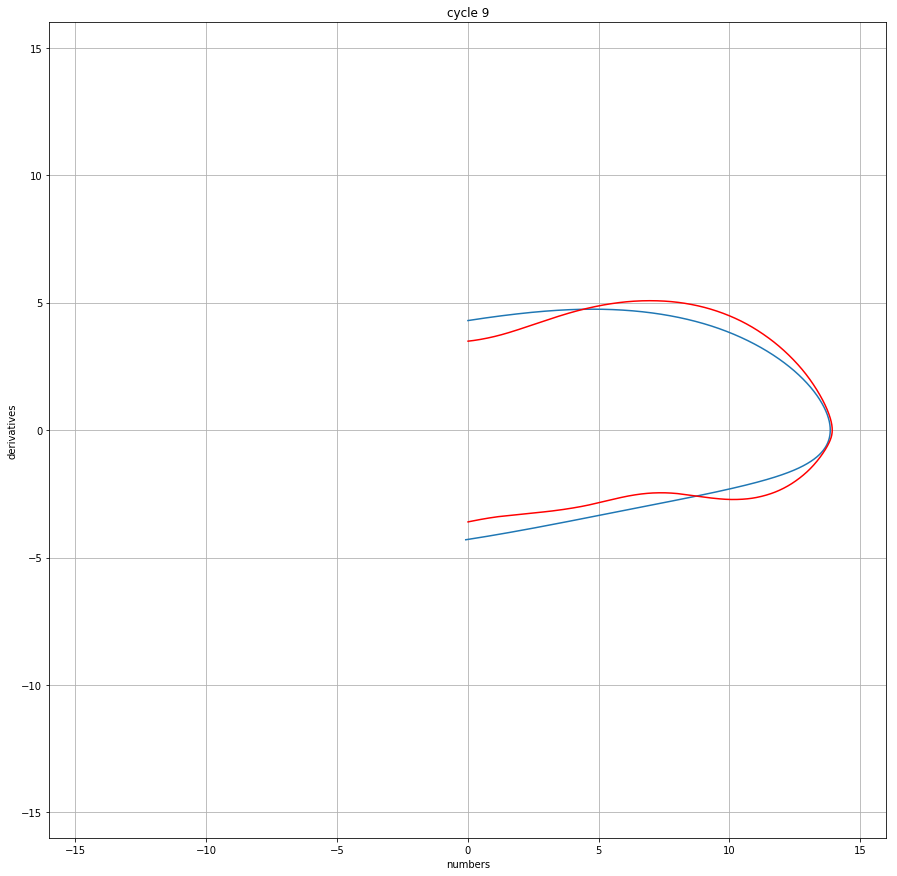

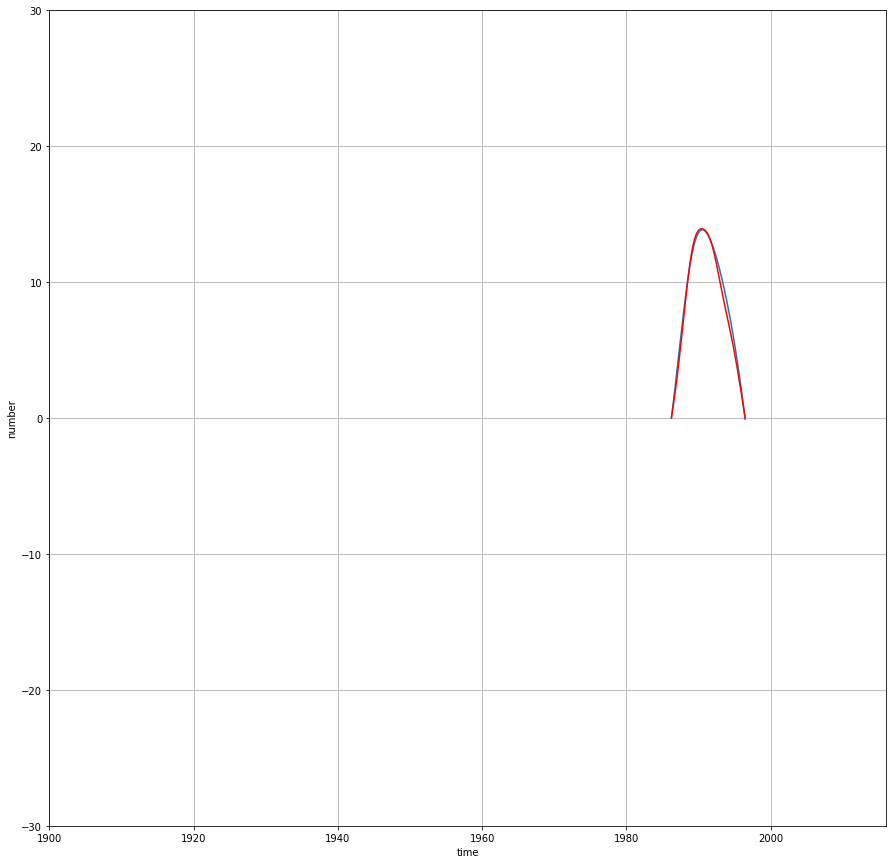

mistake = 0.8614481207941735
lamda = 0.00011
mu = 0.2661
eps = 0.0261
omega = 0.2459


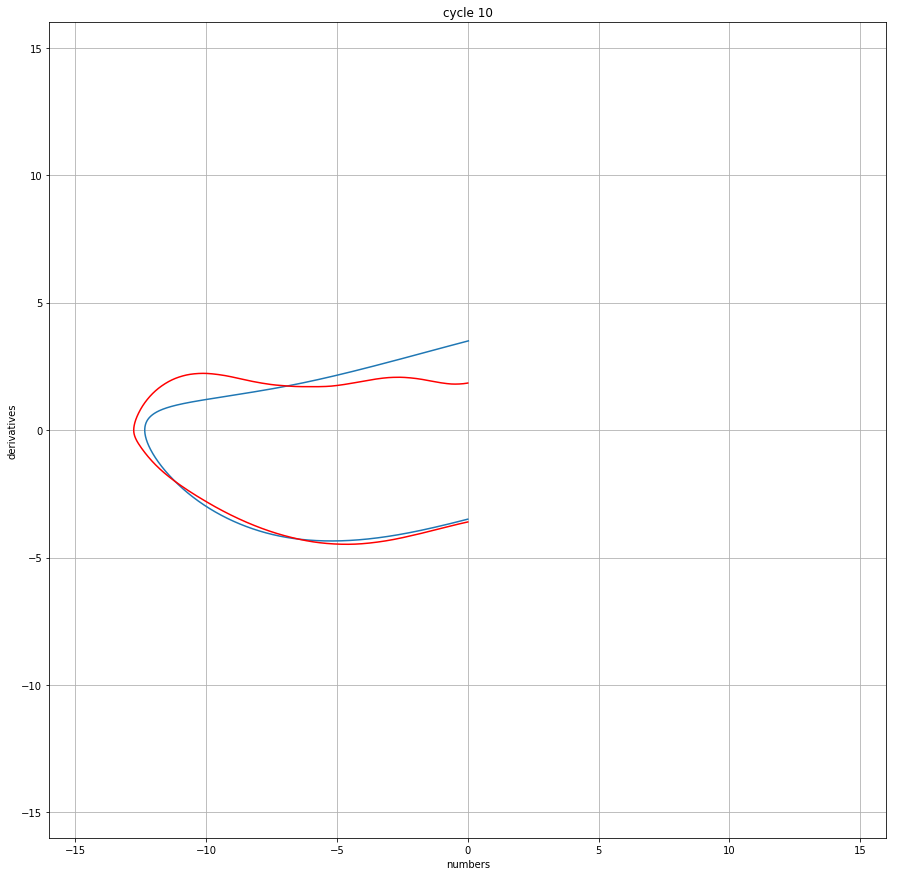

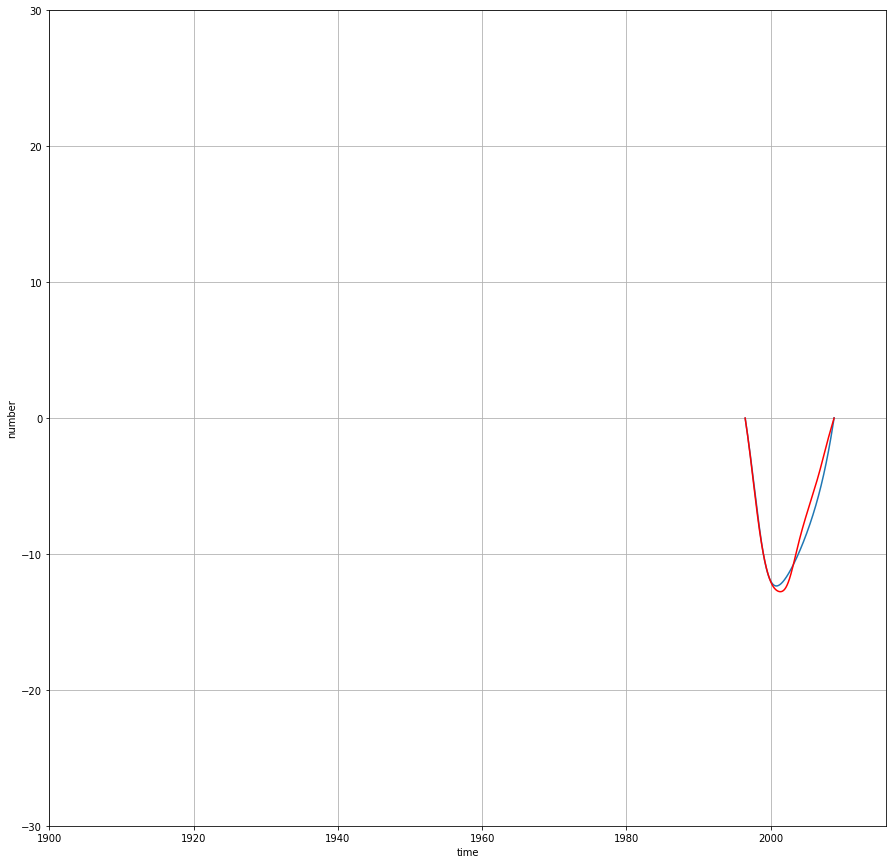

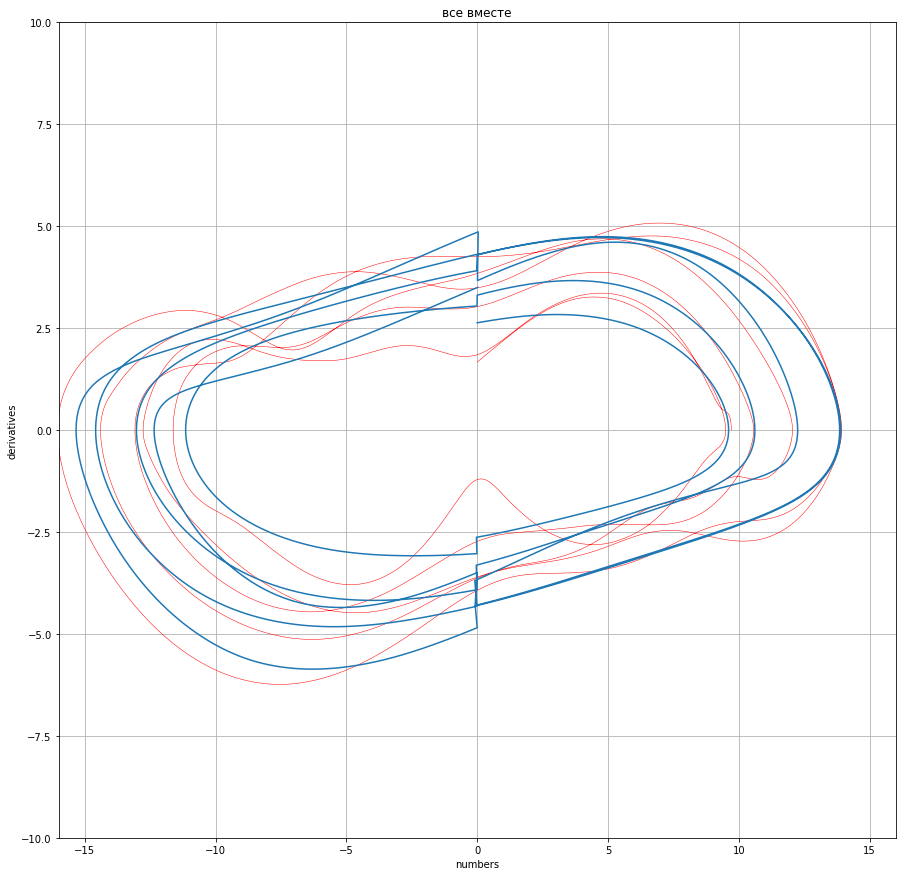

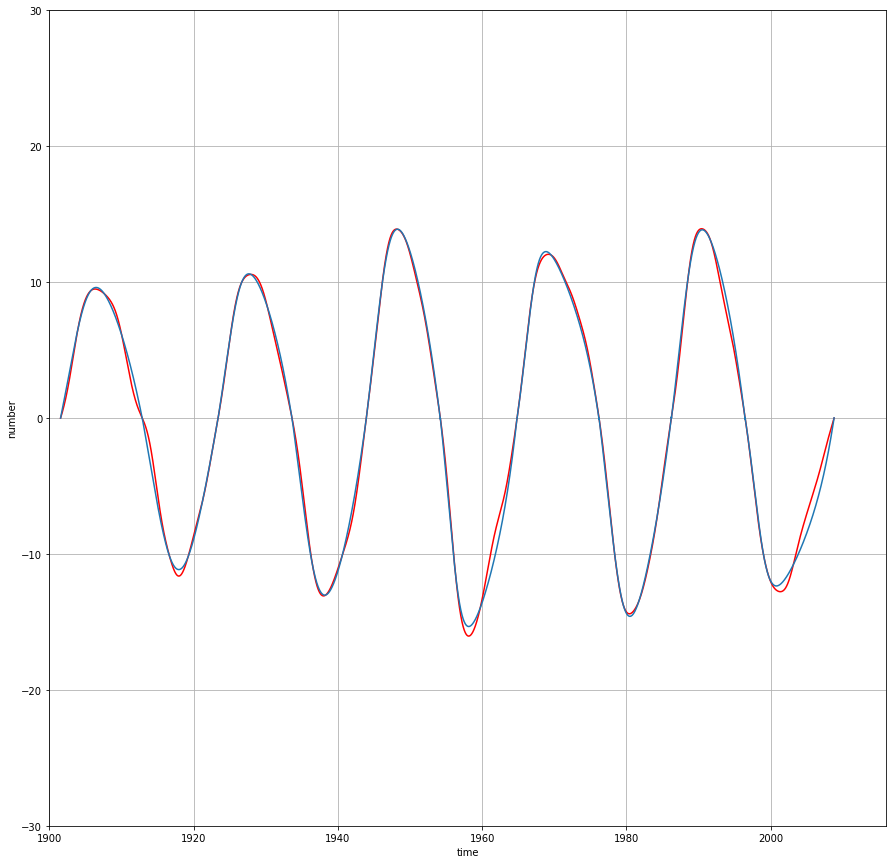

In [99]:
close_period_reg_approx_param_2 = cycles_approx_with_close_period(reg_difference,
                                                                      portraits_2,
                                                                      smoothed_data_2,
                                                                      cycles_2, reg_approx_param_2)

##  Получение приближения близкого по периоду с функцией ошибки равной интегралу для 'новых' данных

mistake = 2.0509179995055535
lamda = 0.000262
mu = 0.1006
eps = 0.0428
omega = 0.2452


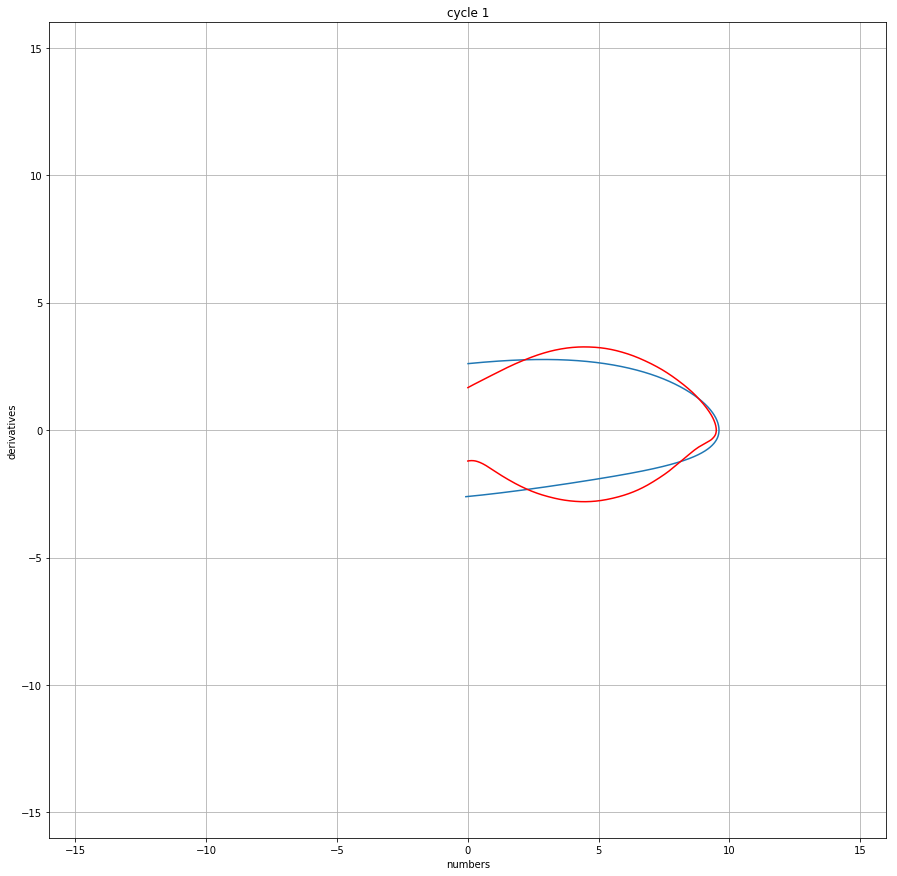

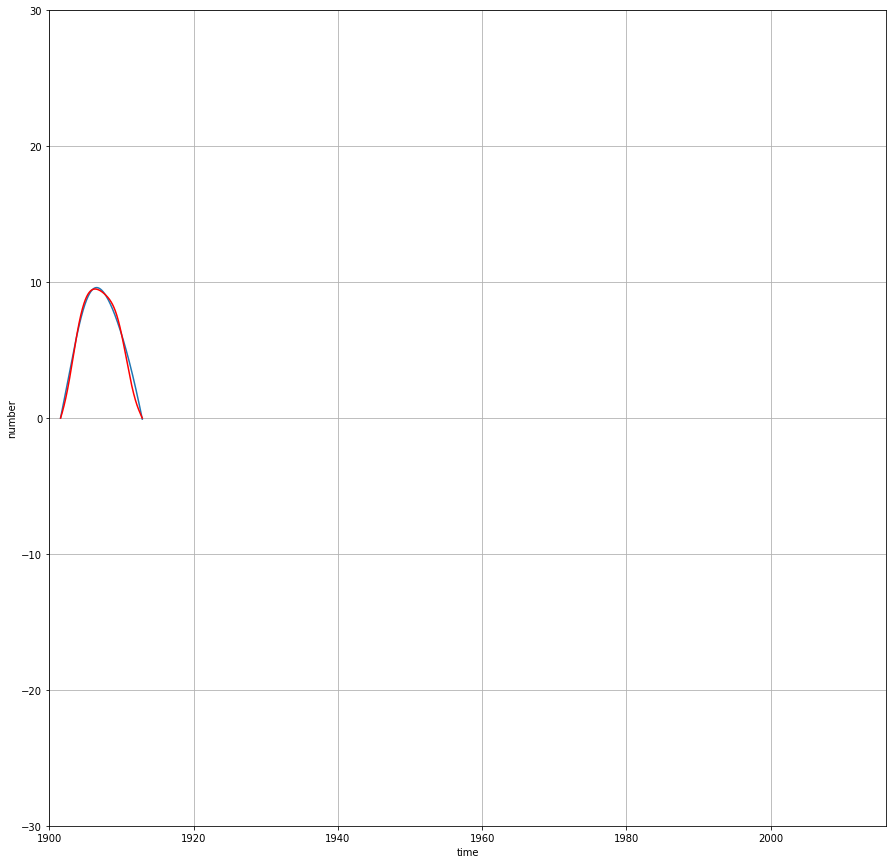

mistake = 3.0127686689202844
lamda = 0.000535
mu = -0.006
eps = 0.0317
omega = 0.2027


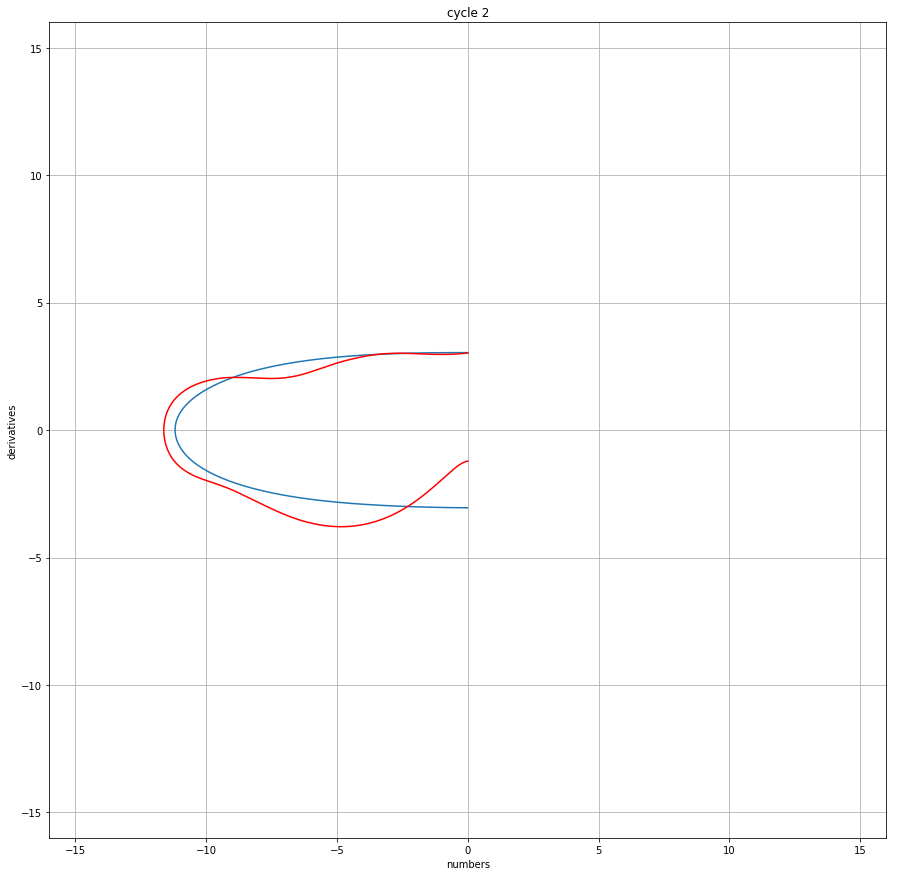

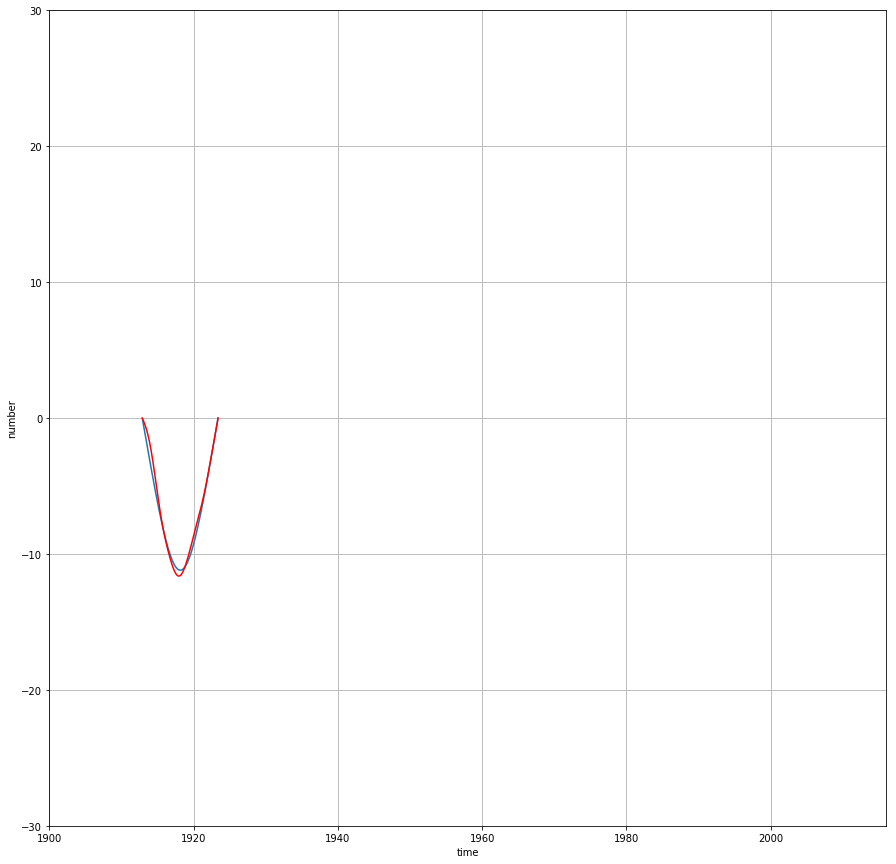

mistake = 0.699066125816584
lamda = 0.000174
mu = 0.1663
eps = 0.0349
omega = 0.2876


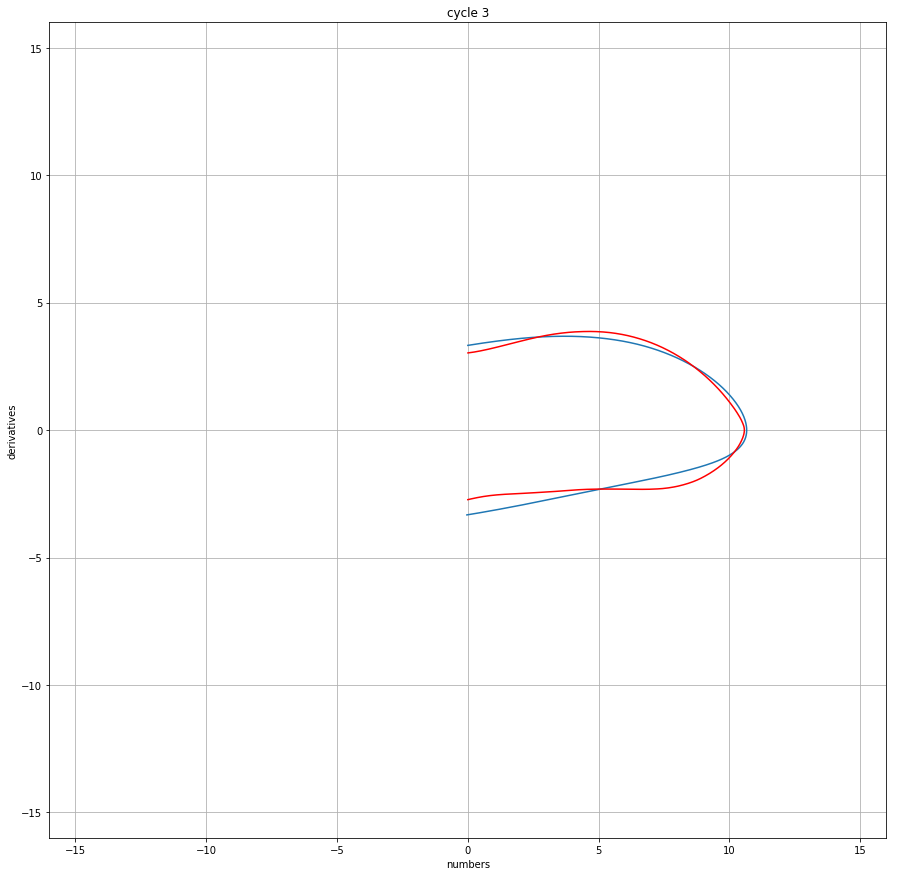

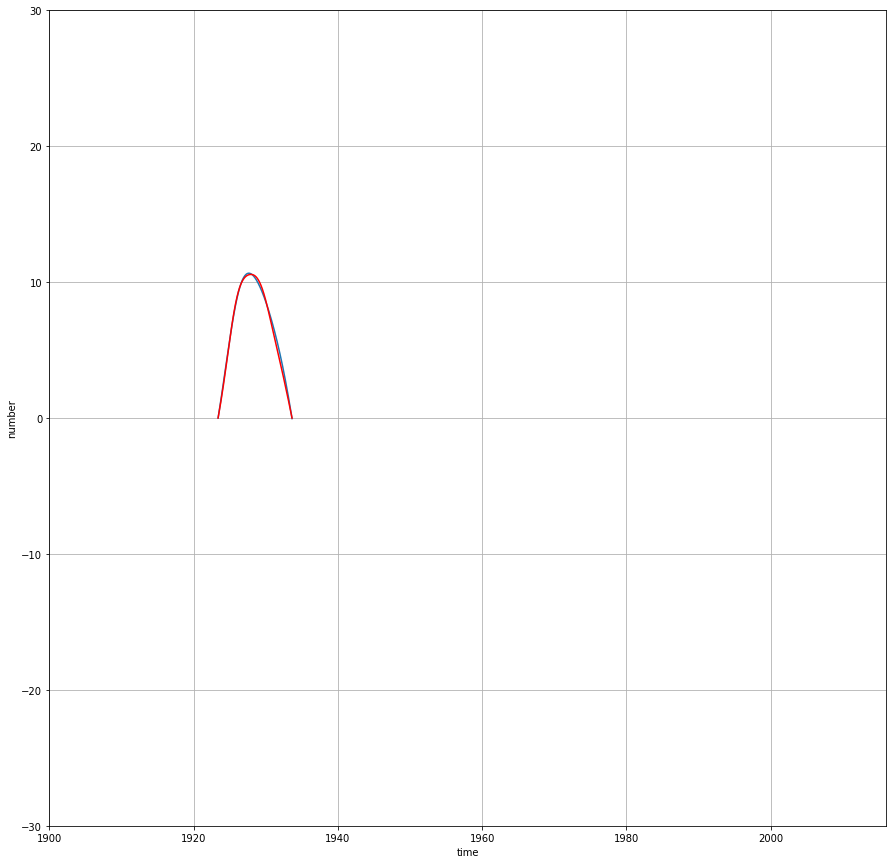

mistake = 4.090945668915654
lamda = 0.000142
mu = 0.0061
eps = 0.0236
omega = 0.2725


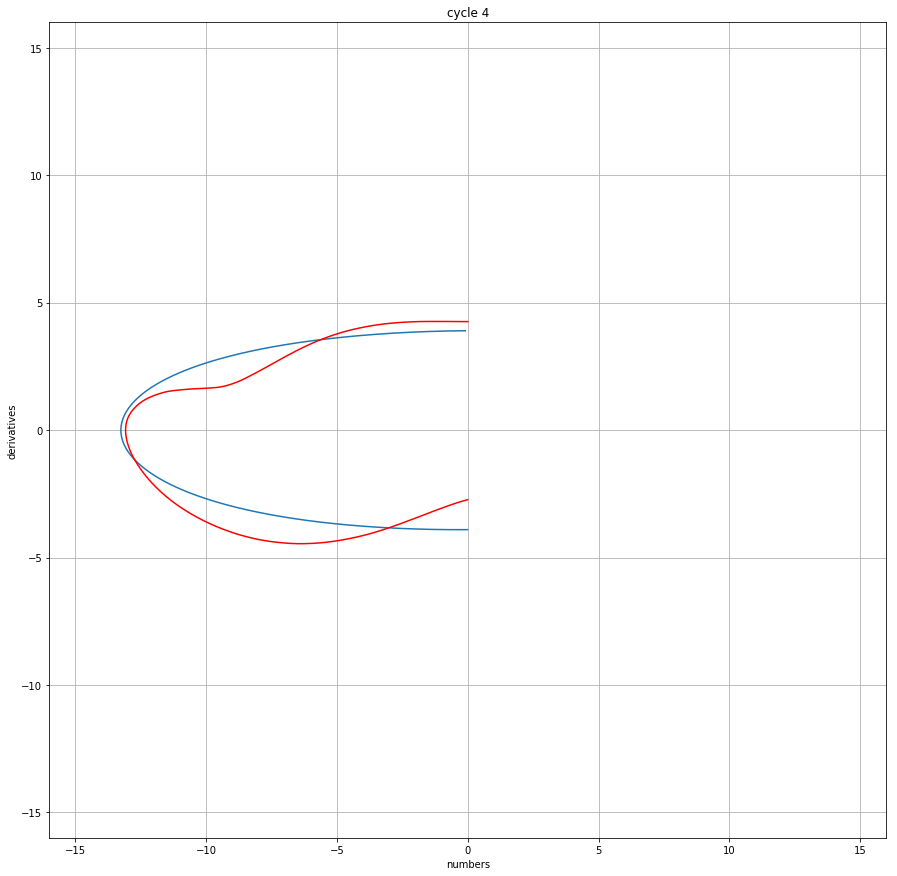

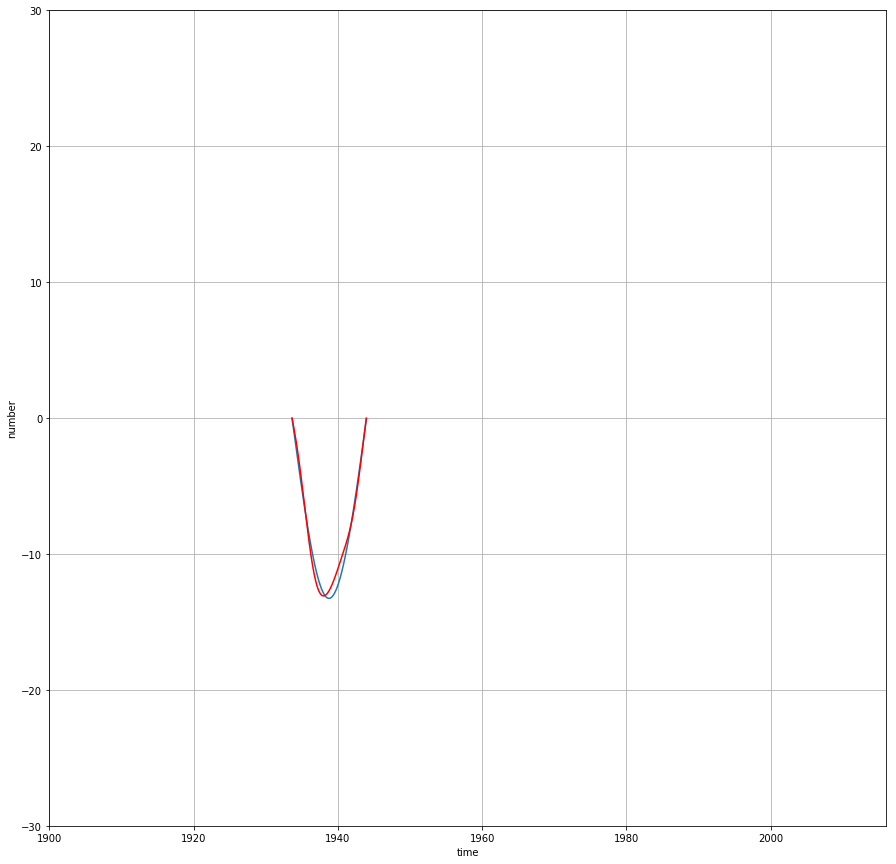

mistake = 0.2678297922694837
lamda = 0.000103
mu = 0.1663
eps = 0.0207
omega = 0.2876


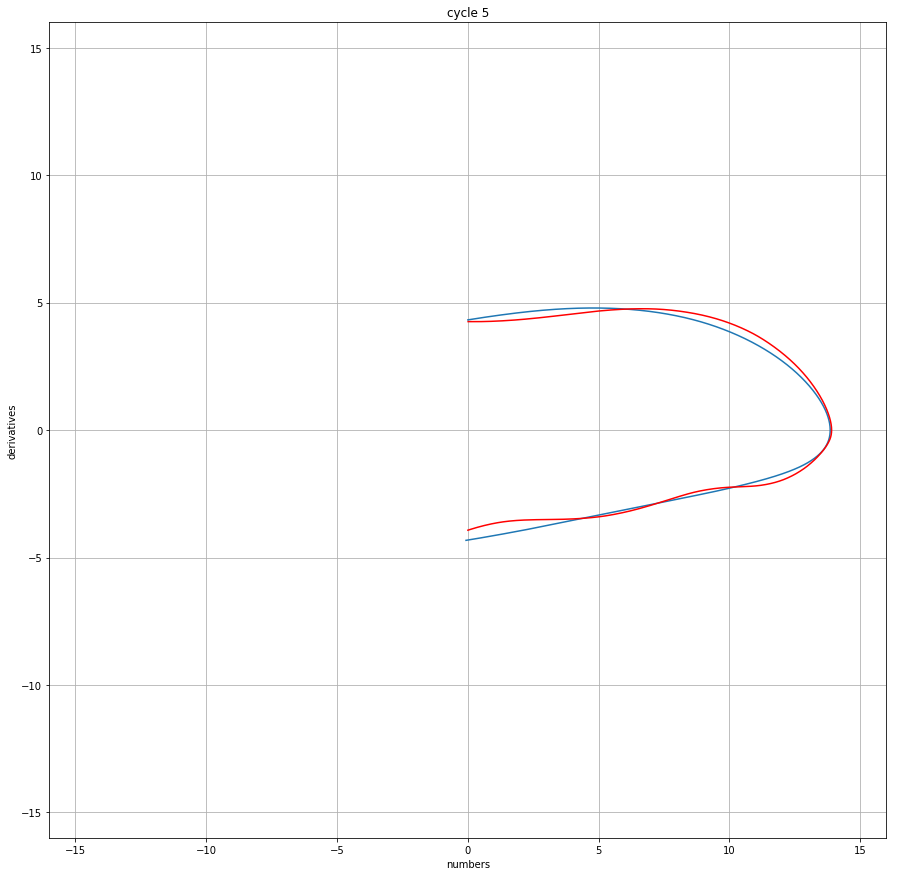

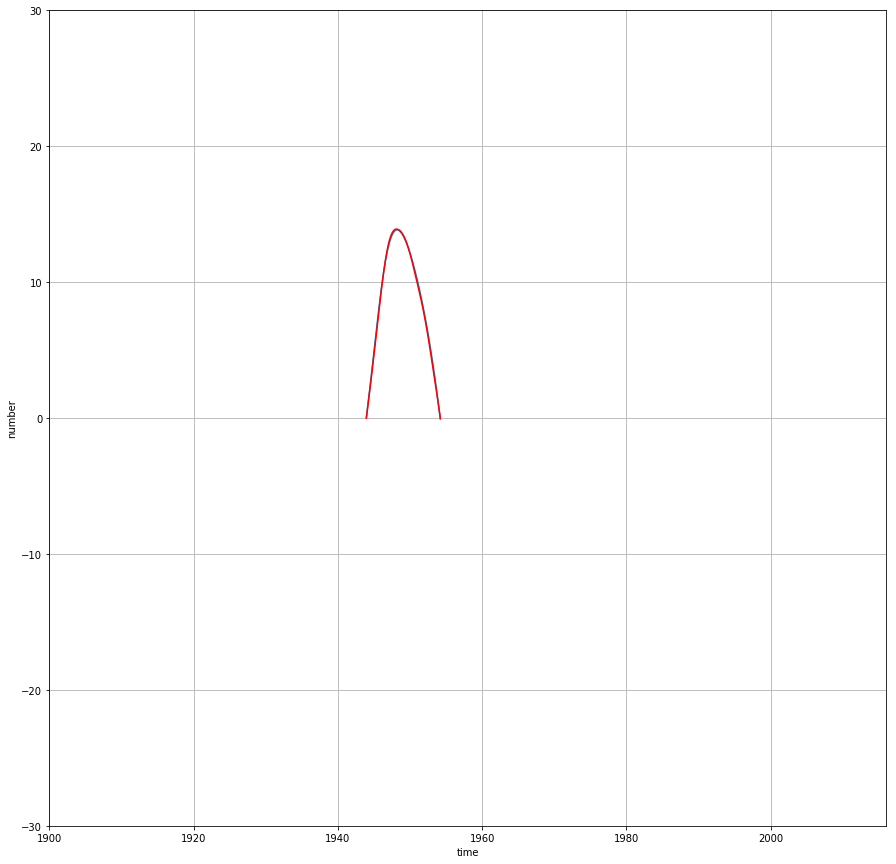

mistake = 6.285298403845806
lamda = 0.000125
mu = 0.2904
eps = 0.0175
omega = 0.2755


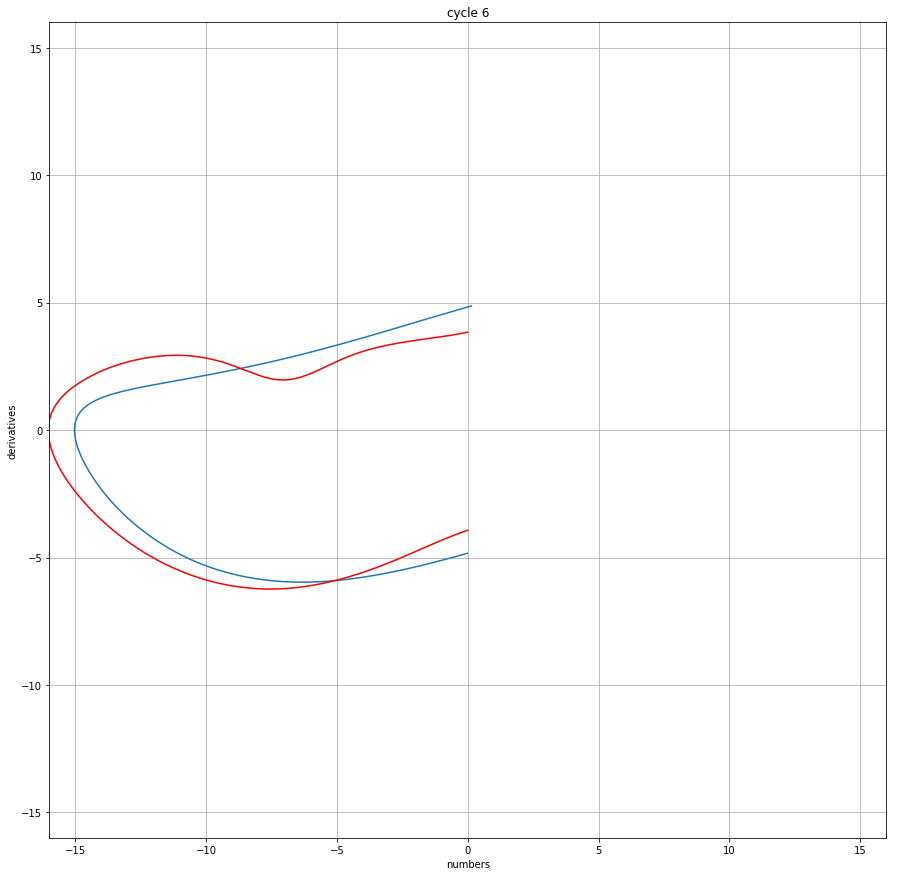

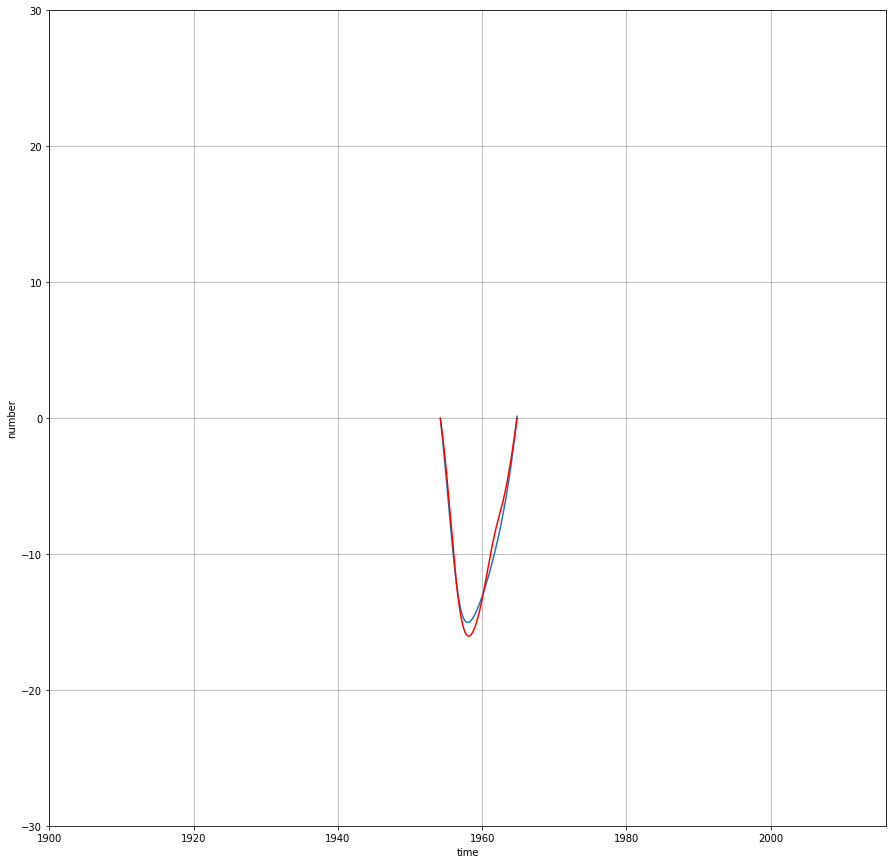

mistake = 0.4552222056692108
lamda = 0.000213
mu = 0.2874
eps = 0.0263
omega = 0.2477


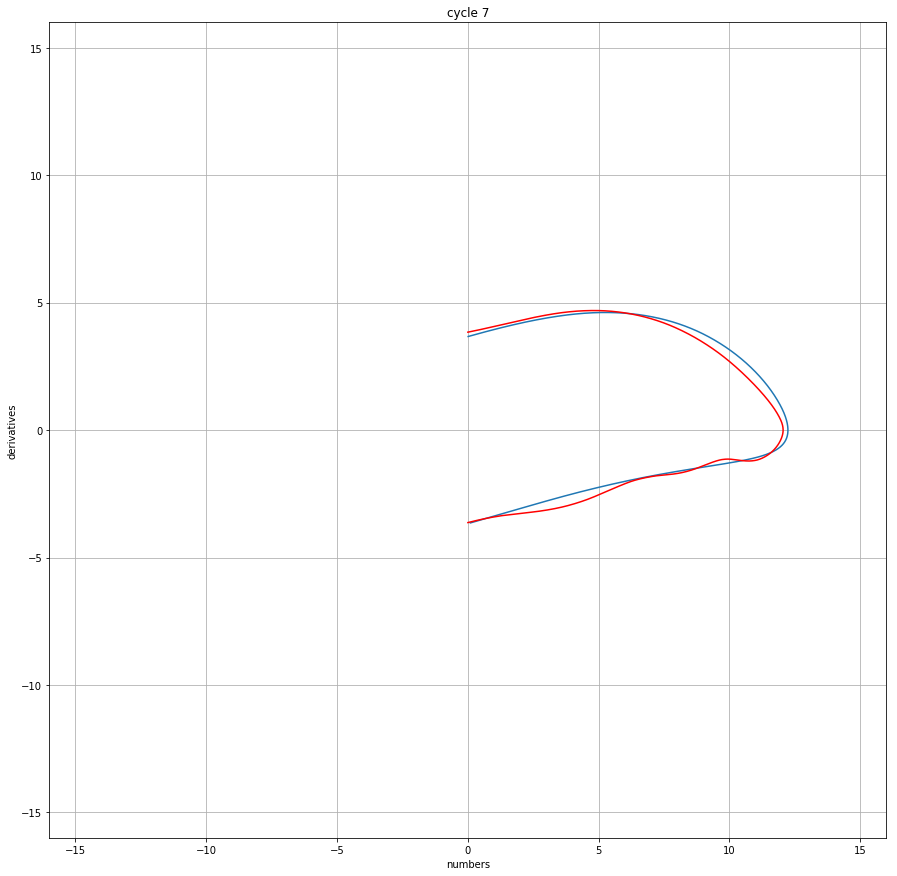

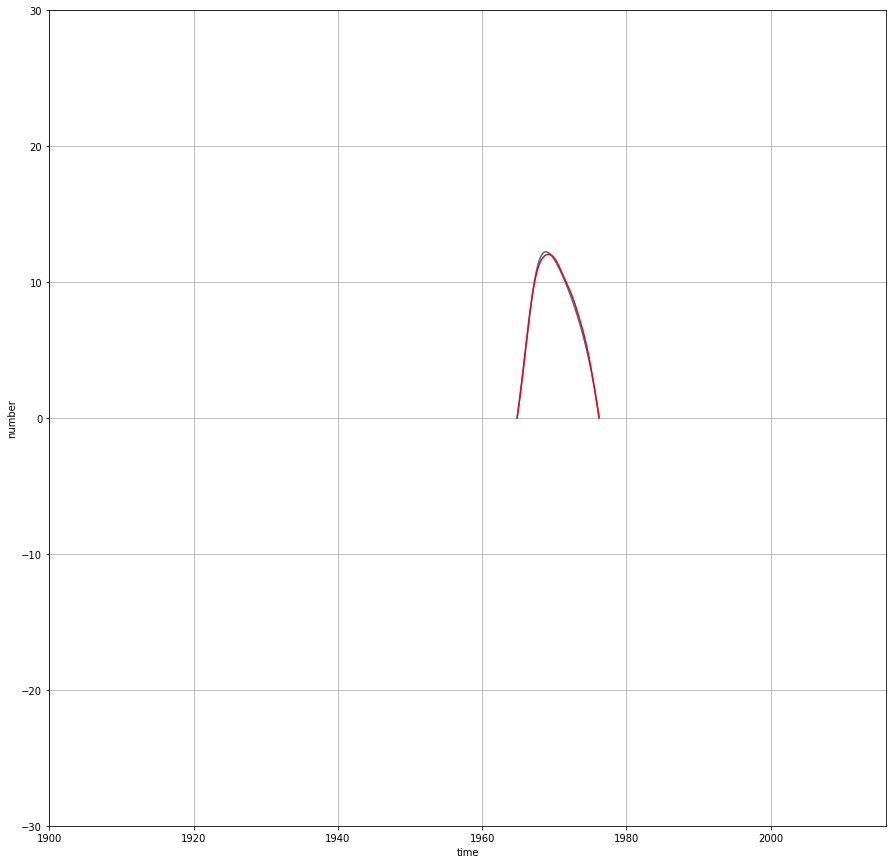

mistake = 0.602091254666264
lamda = 9.9e-05
mu = 0.1447
eps = 0.0192
omega = 0.2925


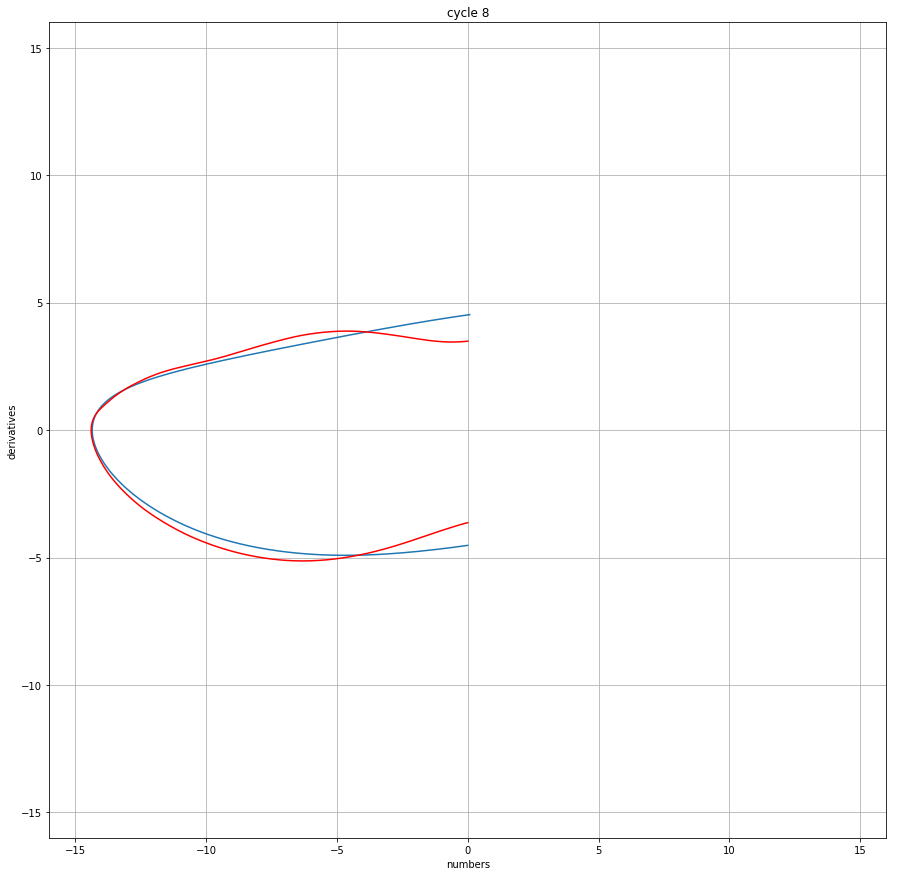

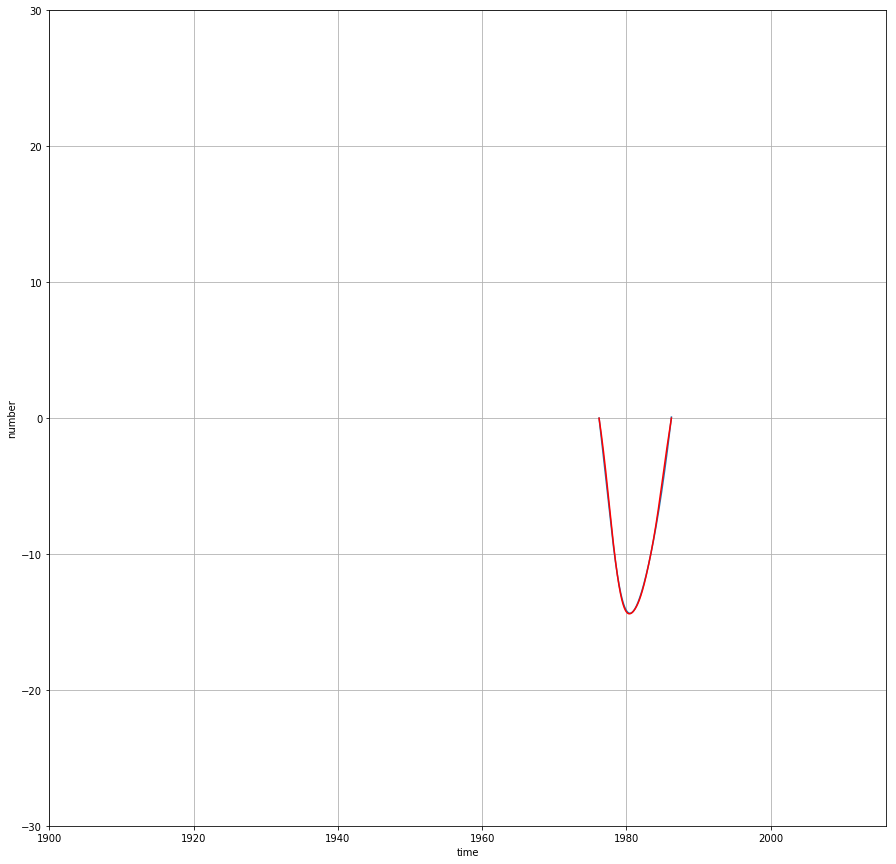

mistake = 2.302079589928002
lamda = 0.000129
mu = 0.1595
eps = 0.0212
omega = 0.2826


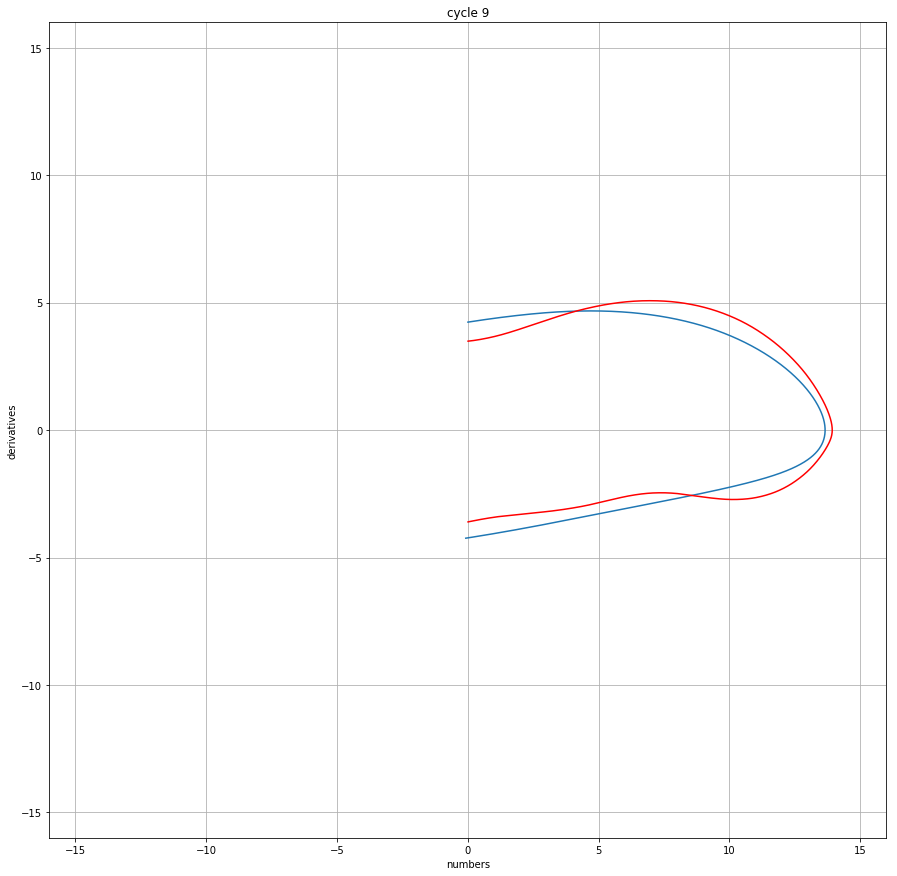

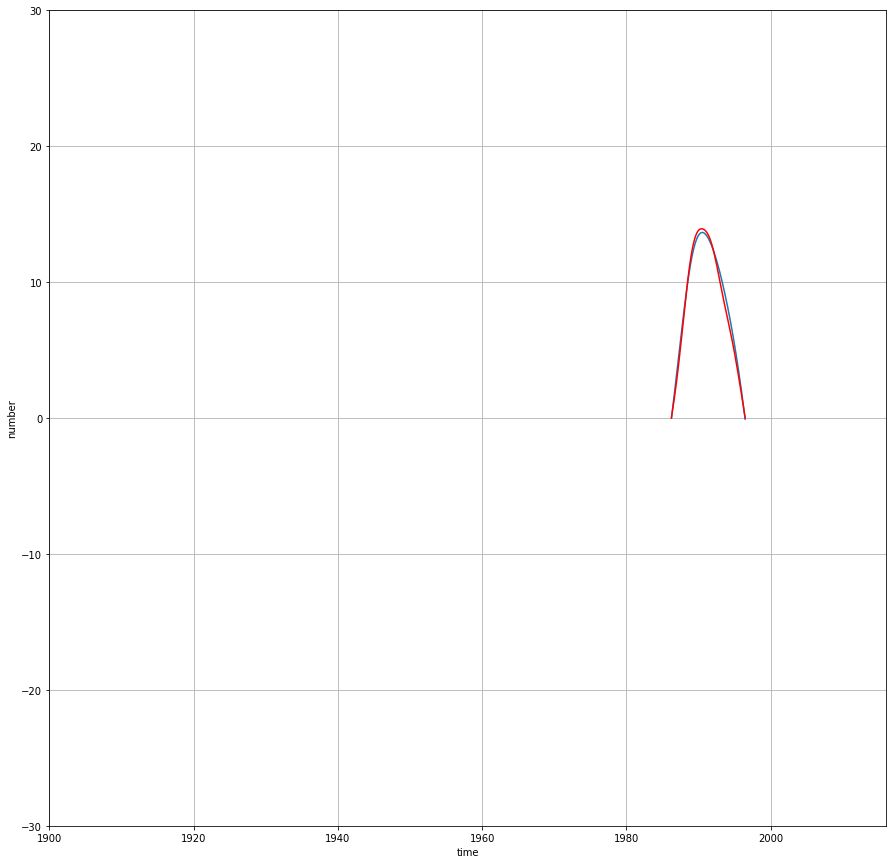

mistake = 7.894626542474868
lamda = 0.000133
mu = 0.2924
eps = 0.0274
omega = 0.2449


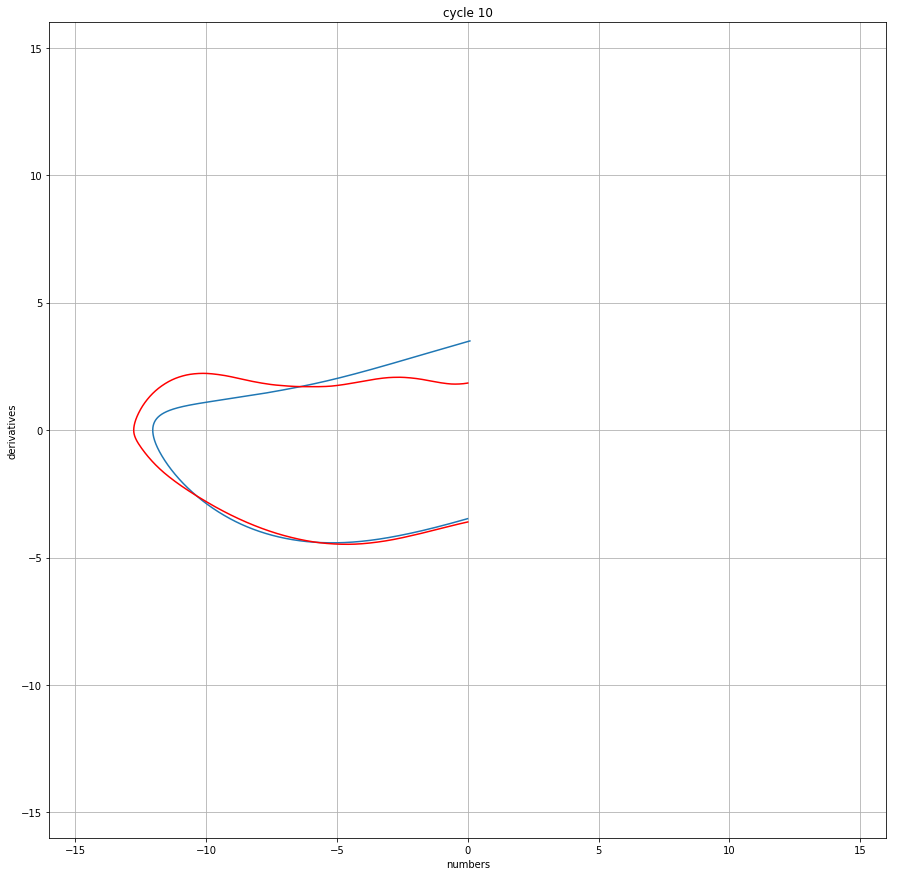

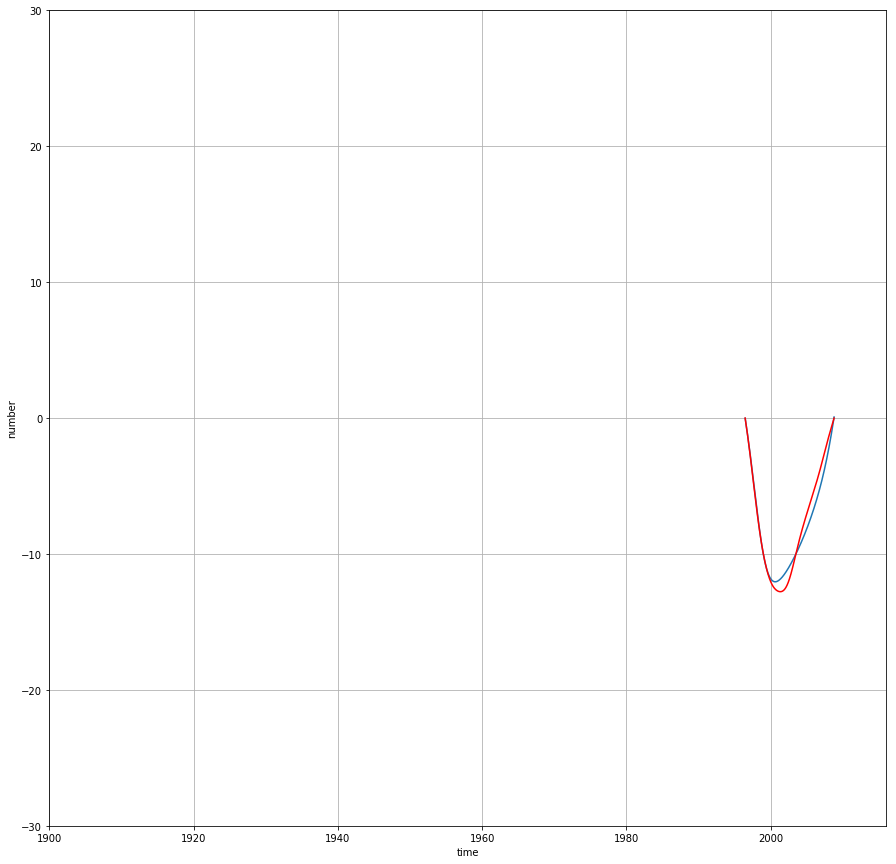

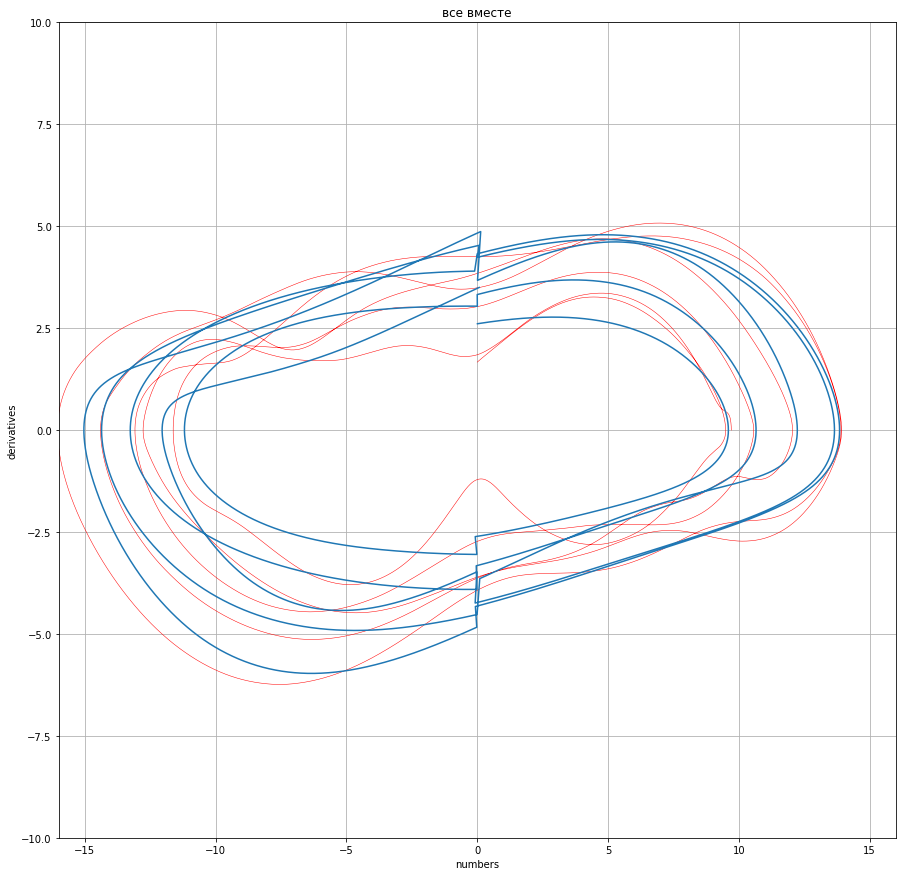

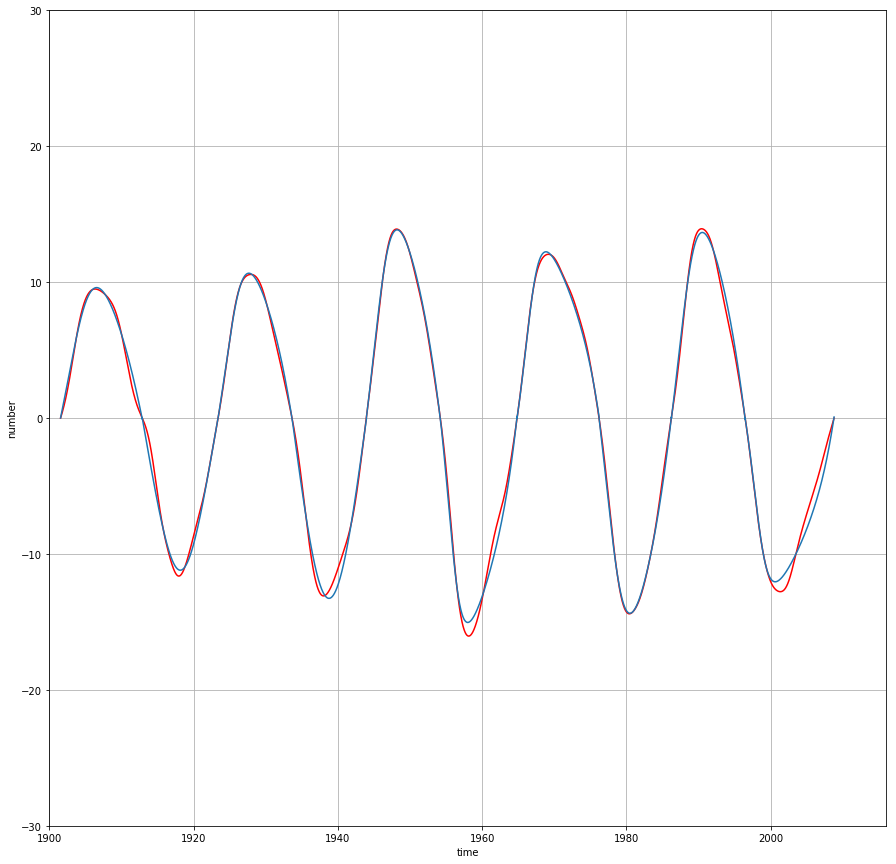

In [100]:
close_period_integral_approx_param_2 = cycles_approx_with_close_period(integral_difference,
                                                                      portraits_2,
                                                                      smoothed_data_2,
                                                                      cycles_2, reg_approx_param_2)
#выбор последнего параметра связан со слишком большим значением b некоторых циклов из-за чего работает дольше остальных

## Составление таблиц данных о приближении 4

In [101]:
close_period_reg_approx_param_table = np.concatenate((ap_table, close_period_reg_approx_param), axis=1)
close_period_integral_approx_param_table = np.concatenate((ap_table, close_period_integral_approx_param),
                                                            axis=1)

## Функция для нахождения кореляции столбцов таблицы данных
1-ый параметр - таблица данных с которой хотим работать из списка:

reg_approx_param_table,

integral_approx_param_table,

reg_approx_param_table_2,

integral_approx_param_table_2,

close_period_reg_approx_param_table,

close_period_integral_approx_param_table,

close_period_reg_approx_param_table_2,

close_period_integral_approx_param_table_2,

2-й и 3-й - номера столбцов (соответствие параметрам указано в 'Составление таблиц данных о приближении 1'),

для которых считается коэффициент корреляции и строится точечный график

данные первого столбца - по оси абсцисс, второго - по оси ординат.

In [102]:
def get_correlation(approx_table, i, j):
    if (i == 0):
        plt.xlabel('amplitude')
    if (i == 1):
        plt.xlabel('period')
    if (i == 2):
        plt.xlabel(r'$\lambda$')
    if (i == 3):
        plt.xlabel(r'$\mu$')
    if (i == 4):
        plt.xlabel(r'$\epsilon$')
    if (i == 5):
        plt.xlabel(r'$\omega$')
    if (j == 0):
        plt.ylabel('amplitude')
    if (j == 1):
        plt.ylabel('period')
    if (j == 2):
        plt.ylabel(r'$\lambda$')
    if (j == 3):
        plt.ylabel(r'$\mu$')
    if (j == 4):
        plt.ylabel(r'$\epsilon$')
    if (j == 5):
        plt.ylabel(r'$\omega$')    
    plt.scatter(approx_table[:,i], approx_table[:,j])
    return pearsonr(approx_table[:,i], approx_table[:,j])[0]

-0.3105977021068306


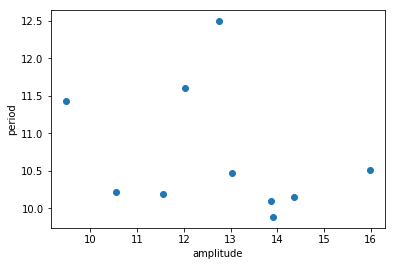

In [103]:
k = get_correlation(reg_approx_param_table, 0, 1)
print(k)
# пример - амплитуда и период для reg_approx_param_table